In [250]:
from __future__ import division, print_function

import os
from datetime import datetime

# Ignore warnings
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from skimage import io, transform
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from sklearn.metrics import average_precision_score, accuracy_score

warnings.filterwarnings("ignore")


import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import random
import albumentations as A
from math import ceil
from collections import Counter
from skimage.metrics import structural_similarity as ssim

In [156]:
# import sys
# sys.path.append("../")

# %load_ext autoreload
# %autoreload 2

### Prepare data

In [157]:
dataset = torchvision.datasets.ImageFolder(root="../data/chest_xray", 
                                 transform = None,
                                 target_transform = None,
                                 )

In [158]:
len(dataset)

5856

In [159]:
Counter(dataset.targets)

Counter({0: 1583, 1: 4273})

In [160]:
def visualize_classes(dataset: Dataset, classes: list = [0, 1], columns: int = 6, inv_normalize = None):
    np.random.seed(0)
    classes_ids = [[] for _ in range(len(classes))]
    for i, class_ in enumerate(classes):
        for _ in range(columns):
            id_ = np.random.randint(len(dataset), size=1)[0]
            while dataset[id_][1] != class_:
                id_ = np.random.randint(len(dataset), size=1)[0]
            classes_ids[i].append(id_)
    f, ax = plt.subplots(len(classes), columns)
    f.set_size_inches(18.5, 10.5)
    for i in range(len(classes)):
        for j in range(columns):
            ax[i, j].set_title(f"id - {classes_ids[i][j]}; label - {dataset[classes_ids[i][j]][1]}")
            image = dataset[classes_ids[i][j]][0]
            if inv_normalize is not None:
                image = inv_normalize(image)
            if isinstance(image, torch.Tensor):
                image = image.permute(1, 2, 0).numpy()
            ax[i, j].imshow(image)
            ax[i, j].axis('off')

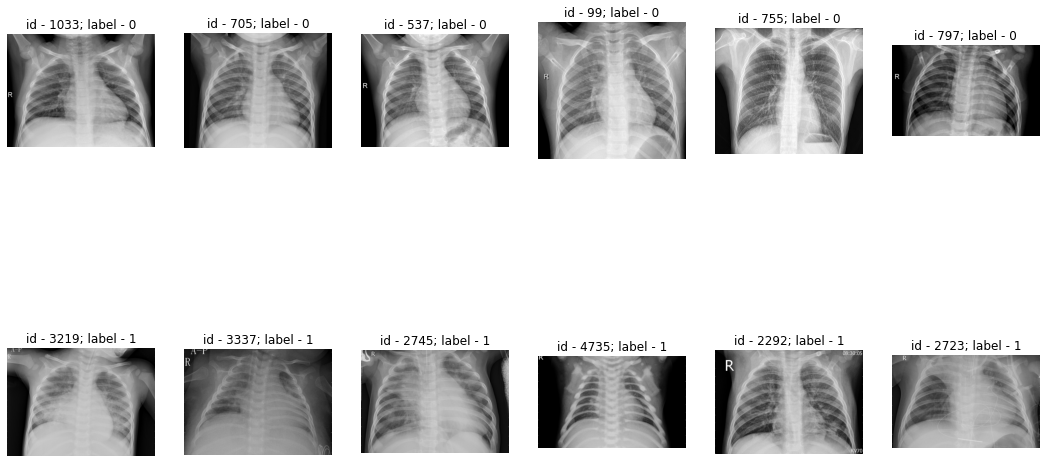

In [161]:
visualize_classes(dataset)

In [162]:
dataset = torchvision.datasets.ImageFolder(
    root="../data/chest_xray", 
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
#             transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    target_transform = None,
)

In [163]:
inv_normalize = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
])

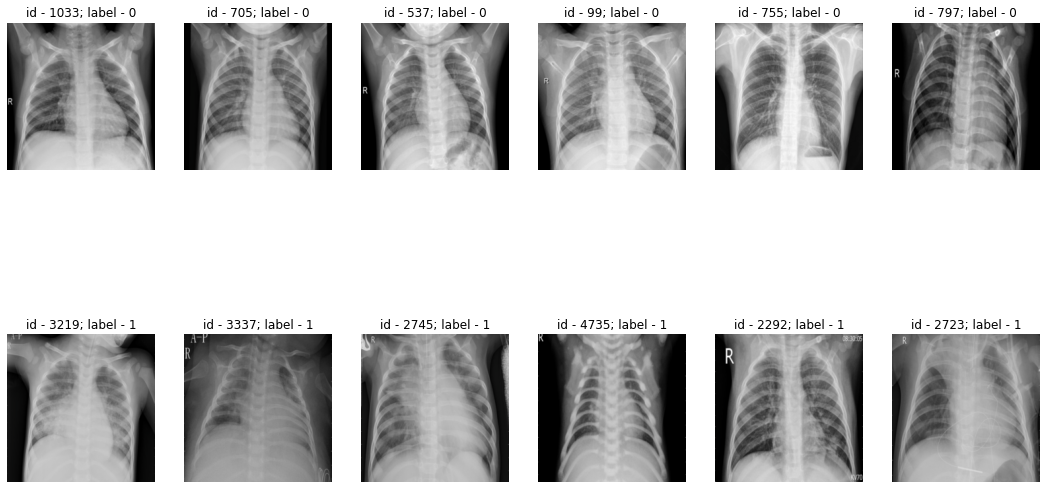

In [164]:
visualize_classes(dataset, inv_normalize=inv_normalize)

In [165]:
device = "cuda:0"
# device = "cpu"

In [166]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size], torch.Generator().manual_seed(0)
)

### Load model

In [14]:
save_path = "../models/1_resnet18_2021-04-11_20-47-32.pt"

In [19]:
model = models.resnet18()
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 2),
    nn.Softmax(),
)

model.load_state_dict(torch.load(save_path))
model.eval()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Analyze results

In [25]:
val_image = []
val_true = []
val_pred = []
val_prob = []
model.eval()
model.to(device)
with torch.no_grad():
    for inputs, batch_labels in tqdm(test_loader):
        inputs = inputs.to("cuda:0")
        outputs = model(inputs)
        prob = outputs.to("cpu").numpy()[:, 1]
        preds = (prob > 0.5).astype(int)
        val_prob.extend(prob)
        val_pred.extend(preds)
        val_true.extend(batch_labels.to("cpu").numpy())
        val_image.extend(inputs.to("cpu"))

100%|██████████| 37/37 [00:06<00:00,  6.12it/s]


In [26]:
def error_class(row):
    if row["true"] == row["pred"] == 1:
        return "TP"
    elif row["true"] == row["pred"] == 0:
        return "TN"
    elif row["true"] != row["pred"] and row["pred"] == 1:
        return "FP"
    else:
        return "FN"

In [27]:
df = pd.DataFrame({"true": val_true, "pred": val_pred, "prob": val_prob})

In [28]:
df["error_type"] = df.apply(error_class, axis=1)

In [29]:
df.groupby("error_type").count()

true  pred  prob
error_type                  
FN            19    19    19
FP            29    29    29
TN           278   278   278
TP           846   846   846

In [30]:
print(f"accuracy_score - {accuracy_score(df['true'], df['pred'])}")
print(f"average_precision_score - {average_precision_score(df['true'], df['pred'])}")

accuracy_score - 0.9590443686006825
average_precision_score - 0.9618314224275203


In [31]:
n = 10
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)
def view_images(df: pd.DataFrame, images: np.ndarray, columns: int = 5, fig_size: tuple = (18.5, 10.5)):
    f, ax = plt.subplots(ceil(df.shape[0] / columns), columns)
    f.set_size_inches(*fig_size)
    for i, (id_, row) in enumerate(df.iterrows()):
        if ax.ndim  == 2:
            current_ax = ax[i // columns, i % columns]
        else:
            current_ax = ax[i]
        current_ax.set_title(str(row))
        current_ax.imshow(inv_normalize(images[id_]).permute(1, 2, 0).numpy())
        current_ax.axis('off')

In [32]:
df

true  pred          prob error_type
0        1     1  9.988525e-01         TP
1        0     0  2.065364e-05         TN
2        1     1  9.999206e-01         TP
3        1     1  9.999782e-01         TP
4        1     1  9.999698e-01         TP
...    ...   ...           ...        ...
1167     1     1  9.766493e-01         TP
1168     1     1  9.999834e-01         TP
1169     0     0  9.334633e-09         TN
1170     1     1  9.999846e-01         TP
1171     1     1  9.999331e-01         TP

[1172 rows x 4 columns]

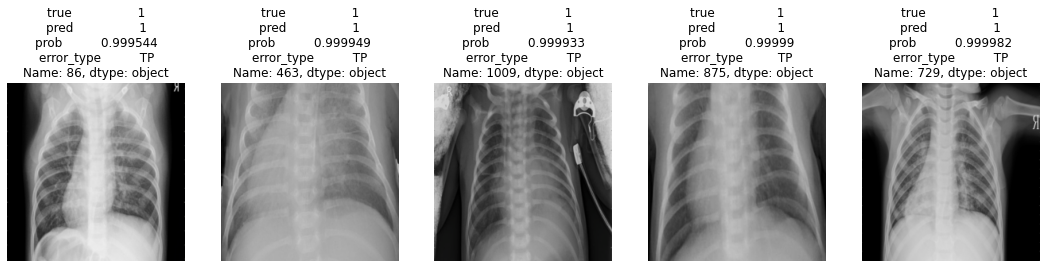

In [262]:
view_images(df[df["error_type"]=="TP"].sample(5), val_image)

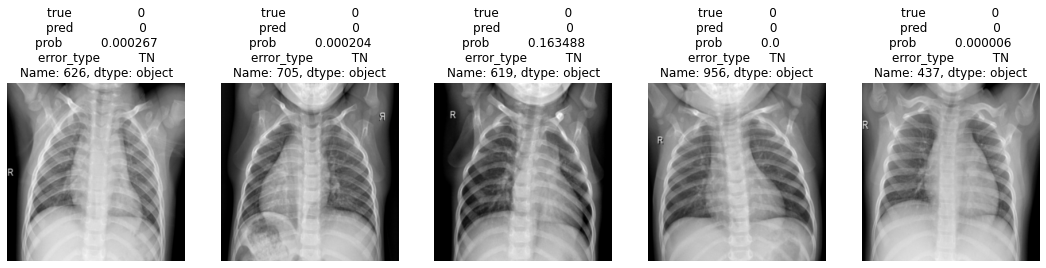

In [263]:
view_images(df[df["error_type"]=="TN"].sample(5), val_image)

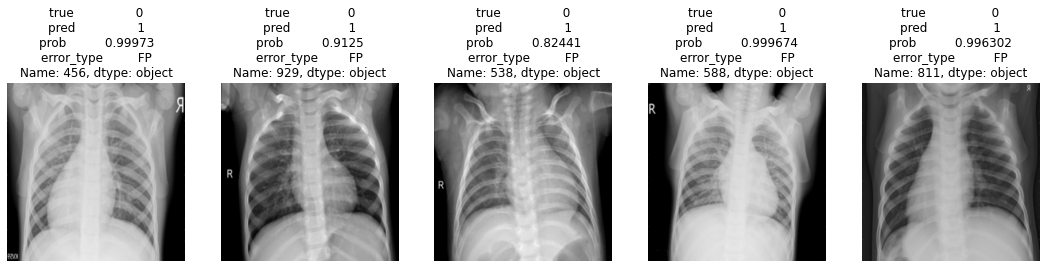

In [264]:
view_images(df[df["error_type"]=="FP"].sample(5), val_image)

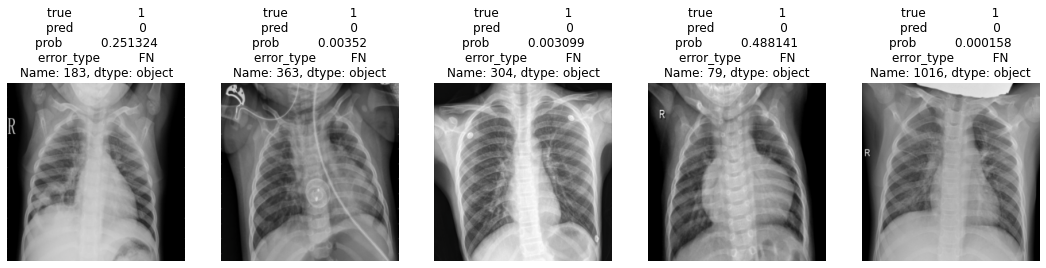

In [265]:
view_images(df[df["error_type"]=="FN"].sample(5), val_image)

### Attacks

In [20]:
# Load ART dependencies:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import ProjectedGradientDescent
from art.utils import to_categorical

In [21]:
image, label = dataset[0]
image = torch.unsqueeze(image, 0)
image = image.to(device)
output = model(image)
output = output.to("cpu").detach().numpy()[0, 1]

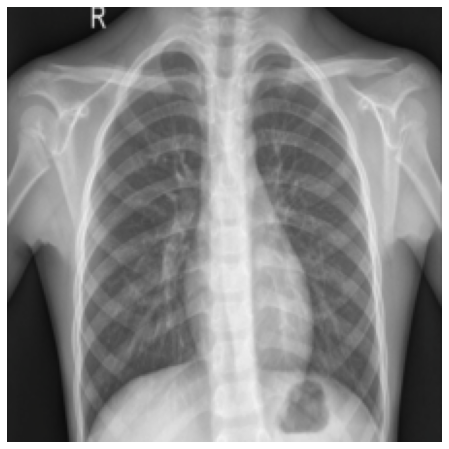

1.0332582e-05

In [22]:
img_to_show = inv_normalize(image[0].cpu()).permute(1, 2, 0)
plt.figure(figsize=(8,8))
plt.imshow(img_to_show)
plt.axis('off')
plt.show()
output

#### Art wrapper

In [23]:
from art.estimators.classification import PyTorchClassifier

In [24]:
art_classifier = PyTorchClassifier(
    model=model, 
    loss=nn.CrossEntropyLoss(), 
    input_shape=(3, 244, 244), 
    nb_classes=2
)

In [25]:
image, label = dataset[0]
image = torch.unsqueeze(image, 0)
output = art_classifier.predict(image)[0, 1]
print(output)

1.0332582e-05


#### Loss gradient 

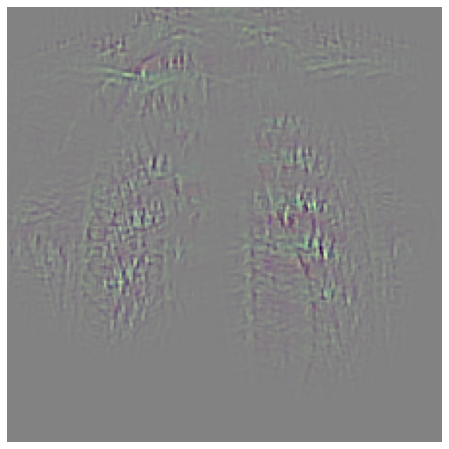

In [26]:
loss_gradient = art_classifier.loss_gradient(x=image, y=to_categorical([1], nb_classes=2))[0].permute(1, 2, 0).cpu().numpy()

# Let's plot the loss gradient. 
# First, swap color channels back to RGB order:
loss_gradient_plot = loss_gradient

# Then normalize loss gradient values to be in [0,1]:
loss_gradient_min = np.min(loss_gradient)
loss_gradient_max = np.max(loss_gradient)
loss_gradient_plot = (loss_gradient_plot - loss_gradient_min)/(loss_gradient_max - loss_gradient_min)

# Show plot:
plt.figure(figsize=(8,8))
plt.imshow(loss_gradient_plot)
plt.axis('off')
plt.show()

In [27]:
def norms(image, image_adv):
    img_original = inv_normalize(torch.tensor(image[0].cpu())).numpy() * 255
    img_adv = inv_normalize(torch.tensor(image_adv[0])).numpy() * 255

    l_0 = int(99*len(np.where(np.abs(img_original - img_adv)>0.5)[0]) / (224*224*3)) + 1   
    l_1 = int(99*np.sum(np.abs(img_original - img_adv)) / np.sum(np.abs(img_original))) + 1
    l_2 = int(99*np.linalg.norm(img_original - img_adv) / np.linalg.norm(img_original)) + 1 
    l_inf = int(99*np.max(np.abs(img_original - img_adv)) / 255) + 1

    print('Perturbation l_0 norm: %d%%' % l_0)
    print('Perturbation l_1 norm: %d%%' % l_1)
    print('Perturbation l_2 norm: %d%%' % l_2)
    print('Noise l_inf norm: %d%%' % l_inf)

    # Let's also plot the absolute amount of adversarial pixel perturbations:
    pert = img_original - img_adv
    pert_min = np.min(pert)
    pert_max = np.max(pert)

    plt.figure(figsize=(8,8))
    img_to_show = (pert - pert_min) / (pert_max - pert_min)
    img_to_show = np.transpose(img_to_show, (1, 2, 0))
    plt.imshow(img_to_show)
    plt.axis('off')
    plt.show()

### Metrics

#### Original data

In [218]:
def get_misclassification_rate(df):
    errors = df.groupby("error_type").count().T.iloc[0]
    misclassification_rate = (errors["FP"] + errors["FN"]) / errors.sum() * 100
    return misclassification_rate

In [220]:
def get_robustness_to_gaussian_blur(df_blur, df_orig):
    robustness_to_gaussian_blur = len(df_blur[df_blur["pred"]!=df_blur["true"]]) / len(df_orig[df_orig["pred"]!=df_orig["true"]])
    return robustness_to_gaussian_blur

In [253]:
def get_av_ssim(orig_images, adv_images):
    values = []
    for i in tqdm(range(len(orig_images))):
        values.append(ssim(np.transpose(orig_images[i], (1, 2, 0)), np.transpose(adv_images[i], (1, 2, 0)), multichannel=True))
    return np.mean(values)

In [167]:
def error_class(row):
    if row["true"] == row["pred"] == 1:
        return "TP"
    elif row["true"] == row["pred"] == 0:
        return "TN"
    elif row["true"] != row["pred"] and row["pred"] == 1:
        return "FP"
    else:
        return "FN"

In [291]:
def get_preds(adv = None, batch_size=1, blur=False, max_iter=None):
    prob = []
    pred = []
    true = []
    images = []
    original_images = []
    
    if max_iter is not None:
        loader = torch.utils.data.DataLoader(
            test_dataset, batch_size=batch_size, shuffle=True, num_workers=1
        )
    else:
        loader = torch.utils.data.DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, num_workers=1
        )
    blur_transform = transforms.GaussianBlur(3)
    counter = 0
    for image, label in tqdm(loader, total=max_iter if max_iter is not None else len(loader)):
        if max_iter is not None:
            original_images.append(np.array(image[0]).copy())
        if adv is not None:
            image = adv.generate(image.cpu(), y=to_categorical([1-label], nb_classes=2))
        if blur:
            for i in range(image.shape[0]):
                image[i] = blur_transform(torch.Tensor(image[i]))
        pred_adv = art_classifier.predict(image)[:,1].reshape(-1)
        prob.extend(list(pred_adv))
        pred.extend(list((pred_adv > 0.5).astype(int)))
        true.extend(list(label.numpy().reshape(-1)))
        images.append(np.array(image[0]))
        if max_iter is not None:
            counter += 1
            if counter >= max_iter:
                break

    df = pd.DataFrame({"prob":prob, "pred":pred, "true":true})
    df["error_type"] = df.apply(error_class, axis=1)
    if max_iter is not None:
        return df, np.array(images), np.array(original_images)
    else:
        return df, np.array(images)

In [292]:
df_orig, orig_images = get_preds()

100%|██████████| 1172/1172 [00:12<00:00, 94.84it/s] 


In [293]:
misclassification_rate = get_misclassification_rate(df_orig)
misclassification_rate

3.668941979522184

In [238]:
df_orig_blur, orig_blur_images = get_preds(blur=True)

100%|██████████| 1172/1172 [00:13<00:00, 88.29it/s]


In [221]:
robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_orig_blur, df_orig)
robustness_to_gaussian_blur

1.4651162790697674

In [217]:
misclassification_rate = get_misclassification_rate(df_orig_blur)
misclassification_rate

5.375426621160409

In [261]:
average_ssim = get_av_ssim(orig_images, orig_blur_images)
average_ssim

100%|██████████| 1172/1172 [00:06<00:00, 175.47it/s]


0.9740317005197504

#### ProjectedGradientDescent

In [262]:
adv = ProjectedGradientDescent(art_classifier, targeted=True, max_iter=50, eps_step=1, eps=0.02)

In [263]:
df_pgd, pgd_images = get_preds(adv, batch_size=1)

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 1/1172 [00:00<09:01,  2.16it/s]

  0%|          | 2/1172 [00:00<08:24,  2.32it/s]

  0%|          | 3/1172 [00:01<07:56,  2.46it/s]

  0%|          | 4/1172 [00:01<07:36,  2.56it/s]

  0%|          | 5/1172 [00:01<07:22,  2.64it/s]

  1%|          | 6/1172 [00:02<07:05,  2.74it/s]

  1%|          | 7/1172 [00:02<06:51,  2.83it/s]

  1%|          | 8/1172 [00:02<06:41,  2.90it/s]

  1%|          | 9/1172 [00:03<06:33,  2.95it/s]

  1%|          | 10/1172 [00:03<06:35,  2.94it/s]

  1%|          | 11/1172 [00:03<06:29,  2.98it/s]

  1%|          | 12/1172 [00:04<06:25,  3.01it/s]

  1%|          | 13/1172 [00:04<06:22,  3.03it/s]

  1%|          | 14/1172 [00:04<06:20,  3.04it/s]

  1%|▏         | 15/1172 [00:05<06:19,  3.05it/s]

  1%|▏         | 16/1172 [00:05<06:17,  3.06it/s]

  1%|▏         | 17/1172 [00:05<06:16,  3.06it/s]

  2%|▏         | 18/1172 [00:06<06:15,  3.07it/s]

  2%|▏         | 19/1172 [00:06<06:15,  3.07it/s]

  2%|▏         | 20/1172 [00:06<06:14,  3.08it/s]

  2%|▏         | 21/1172 [00:07<06:14,  3.08it/s]

  2%|▏         | 22/1172 [00:07<06:13,  3.08it/s]

  2%|▏         | 23/1172 [00:07<06:13,  3.08it/s]

  2%|▏         | 24/1172 [00:08<06:12,  3.08it/s]

  2%|▏         | 25/1172 [00:08<06:12,  3.08it/s]

  2%|▏         | 26/1172 [00:08<06:12,  3.08it/s]

  2%|▏         | 27/1172 [00:09<06:12,  3.08it/s]

  2%|▏         | 28/1172 [00:09<06:11,  3.08it/s]

  2%|▏         | 29/1172 [00:09<06:11,  3.08it/s]

  3%|▎         | 30/1172 [00:10<06:19,  3.01it/s]

  3%|▎         | 31/1172 [00:10<06:22,  2.98it/s]

  3%|▎         | 32/1172 [00:10<06:18,  3.01it/s]

  3%|▎         | 33/1172 [00:11<06:15,  3.03it/s]

  3%|▎         | 34/1172 [00:11<06:13,  3.05it/s]

  3%|▎         | 35/1172 [00:11<06:11,  3.06it/s]

  3%|▎         | 36/1172 [00:12<06:10,  3.07it/s]

  3%|▎         | 37/1172 [00:12<06:09,  3.07it/s]

  3%|▎         | 38/1172 [00:12<06:08,  3.07it/s]

  3%|▎         | 39/1172 [00:12<06:08,  3.08it/s]

  3%|▎         | 40/1172 [00:13<06:07,  3.08it/s]

  3%|▎         | 41/1172 [00:13<06:07,  3.08it/s]

  4%|▎         | 42/1172 [00:13<06:06,  3.08it/s]

  4%|▎         | 43/1172 [00:14<06:06,  3.08it/s]

  4%|▍         | 44/1172 [00:14<06:06,  3.08it/s]

  4%|▍         | 45/1172 [00:14<06:05,  3.08it/s]

  4%|▍         | 46/1172 [00:15<06:05,  3.08it/s]

  4%|▍         | 47/1172 [00:15<06:05,  3.08it/s]

  4%|▍         | 48/1172 [00:15<06:04,  3.08it/s]

  4%|▍         | 49/1172 [00:16<06:04,  3.08it/s]

  4%|▍         | 50/1172 [00:16<06:03,  3.08it/s]

  4%|▍         | 51/1172 [00:16<06:03,  3.08it/s]

  4%|▍         | 52/1172 [00:17<06:03,  3.08it/s]

  5%|▍         | 53/1172 [00:17<06:02,  3.08it/s]

  5%|▍         | 54/1172 [00:17<06:02,  3.08it/s]

  5%|▍         | 55/1172 [00:18<06:02,  3.08it/s]

  5%|▍         | 56/1172 [00:18<06:02,  3.08it/s]

  5%|▍         | 57/1172 [00:18<06:02,  3.08it/s]

  5%|▍         | 58/1172 [00:19<06:01,  3.08it/s]

  5%|▌         | 59/1172 [00:19<06:01,  3.08it/s]

  5%|▌         | 60/1172 [00:19<06:01,  3.08it/s]

  5%|▌         | 61/1172 [00:20<06:00,  3.08it/s]

  5%|▌         | 62/1172 [00:20<06:00,  3.08it/s]

  5%|▌         | 63/1172 [00:20<06:00,  3.08it/s]

  5%|▌         | 64/1172 [00:21<05:59,  3.08it/s]

  6%|▌         | 65/1172 [00:21<05:59,  3.08it/s]

  6%|▌         | 66/1172 [00:21<05:59,  3.08it/s]

  6%|▌         | 67/1172 [00:22<05:59,  3.08it/s]

  6%|▌         | 68/1172 [00:22<05:58,  3.08it/s]

  6%|▌         | 69/1172 [00:22<05:58,  3.08it/s]

  6%|▌         | 70/1172 [00:23<05:57,  3.08it/s]

  6%|▌         | 71/1172 [00:23<05:57,  3.08it/s]

  6%|▌         | 72/1172 [00:23<05:56,  3.08it/s]

  6%|▌         | 73/1172 [00:24<05:56,  3.08it/s]

  6%|▋         | 74/1172 [00:24<05:56,  3.08it/s]

  6%|▋         | 75/1172 [00:24<05:55,  3.08it/s]

  6%|▋         | 76/1172 [00:24<05:55,  3.08it/s]

  7%|▋         | 77/1172 [00:25<05:54,  3.09it/s]

  7%|▋         | 78/1172 [00:25<05:54,  3.08it/s]

  7%|▋         | 79/1172 [00:25<05:54,  3.08it/s]

  7%|▋         | 80/1172 [00:26<05:54,  3.08it/s]

  7%|▋         | 81/1172 [00:26<05:54,  3.08it/s]

  7%|▋         | 82/1172 [00:26<05:53,  3.08it/s]

  7%|▋         | 83/1172 [00:27<05:53,  3.08it/s]

  7%|▋         | 84/1172 [00:27<05:53,  3.08it/s]

  7%|▋         | 85/1172 [00:27<05:52,  3.08it/s]

  7%|▋         | 86/1172 [00:28<05:52,  3.08it/s]

  7%|▋         | 87/1172 [00:28<05:52,  3.08it/s]

  8%|▊         | 88/1172 [00:28<05:52,  3.08it/s]

  8%|▊         | 89/1172 [00:29<05:51,  3.08it/s]

  8%|▊         | 90/1172 [00:29<05:52,  3.07it/s]

  8%|▊         | 91/1172 [00:29<05:52,  3.07it/s]

  8%|▊         | 92/1172 [00:30<05:52,  3.07it/s]

  8%|▊         | 93/1172 [00:30<05:51,  3.07it/s]

  8%|▊         | 94/1172 [00:30<05:51,  3.07it/s]

  8%|▊         | 95/1172 [00:31<05:51,  3.07it/s]

  8%|▊         | 96/1172 [00:31<05:50,  3.07it/s]

  8%|▊         | 97/1172 [00:31<05:50,  3.07it/s]

  8%|▊         | 98/1172 [00:32<05:50,  3.07it/s]

  8%|▊         | 99/1172 [00:32<05:49,  3.07it/s]

  9%|▊         | 100/1172 [00:32<05:49,  3.07it/s]

  9%|▊         | 101/1172 [00:33<05:49,  3.07it/s]

  9%|▊         | 102/1172 [00:33<05:48,  3.07it/s]

  9%|▉         | 103/1172 [00:33<05:48,  3.07it/s]

  9%|▉         | 104/1172 [00:34<05:47,  3.07it/s]

  9%|▉         | 105/1172 [00:34<05:47,  3.07it/s]

  9%|▉         | 106/1172 [00:34<05:47,  3.07it/s]

  9%|▉         | 107/1172 [00:35<05:46,  3.07it/s]

  9%|▉         | 108/1172 [00:35<05:46,  3.07it/s]

  9%|▉         | 109/1172 [00:35<05:46,  3.07it/s]

  9%|▉         | 110/1172 [00:36<05:45,  3.07it/s]

  9%|▉         | 111/1172 [00:36<05:45,  3.07it/s]

 10%|▉         | 112/1172 [00:36<05:45,  3.07it/s]

 10%|▉         | 113/1172 [00:37<05:44,  3.07it/s]

 10%|▉         | 114/1172 [00:37<05:44,  3.07it/s]

 10%|▉         | 115/1172 [00:37<05:44,  3.07it/s]

 10%|▉         | 116/1172 [00:38<05:44,  3.07it/s]

 10%|▉         | 117/1172 [00:38<05:43,  3.07it/s]

 10%|█         | 118/1172 [00:38<05:43,  3.07it/s]

 10%|█         | 119/1172 [00:38<05:42,  3.07it/s]

 10%|█         | 120/1172 [00:39<05:42,  3.07it/s]

 10%|█         | 121/1172 [00:39<05:42,  3.07it/s]

 10%|█         | 122/1172 [00:39<05:42,  3.07it/s]

 10%|█         | 123/1172 [00:40<05:41,  3.07it/s]

 11%|█         | 124/1172 [00:40<05:41,  3.07it/s]

 11%|█         | 125/1172 [00:40<05:40,  3.07it/s]

 11%|█         | 126/1172 [00:41<05:40,  3.07it/s]

 11%|█         | 127/1172 [00:41<05:40,  3.07it/s]

 11%|█         | 128/1172 [00:41<05:40,  3.07it/s]

 11%|█         | 129/1172 [00:42<05:39,  3.07it/s]

 11%|█         | 130/1172 [00:42<05:39,  3.07it/s]

 11%|█         | 131/1172 [00:42<05:39,  3.07it/s]

 11%|█▏        | 132/1172 [00:43<05:38,  3.07it/s]

 11%|█▏        | 133/1172 [00:43<05:38,  3.07it/s]

 11%|█▏        | 134/1172 [00:43<05:38,  3.07it/s]

 12%|█▏        | 135/1172 [00:44<05:37,  3.07it/s]

 12%|█▏        | 136/1172 [00:44<05:37,  3.07it/s]

 12%|█▏        | 137/1172 [00:44<05:37,  3.07it/s]

 12%|█▏        | 138/1172 [00:45<05:37,  3.07it/s]

 12%|█▏        | 139/1172 [00:45<05:36,  3.07it/s]

 12%|█▏        | 140/1172 [00:45<05:36,  3.07it/s]

 12%|█▏        | 141/1172 [00:46<05:35,  3.07it/s]

 12%|█▏        | 142/1172 [00:46<05:35,  3.07it/s]

 12%|█▏        | 143/1172 [00:46<05:35,  3.07it/s]

 12%|█▏        | 144/1172 [00:47<05:34,  3.07it/s]

 12%|█▏        | 145/1172 [00:47<05:34,  3.07it/s]

 12%|█▏        | 146/1172 [00:47<05:34,  3.07it/s]

 13%|█▎        | 147/1172 [00:48<05:33,  3.07it/s]

 13%|█▎        | 148/1172 [00:48<05:33,  3.07it/s]

 13%|█▎        | 149/1172 [00:48<05:33,  3.07it/s]

 13%|█▎        | 150/1172 [00:49<05:33,  3.07it/s]

 13%|█▎        | 151/1172 [00:49<05:32,  3.07it/s]

 13%|█▎        | 152/1172 [00:49<05:32,  3.07it/s]

 13%|█▎        | 153/1172 [00:50<05:31,  3.07it/s]

 13%|█▎        | 154/1172 [00:50<05:31,  3.07it/s]

 13%|█▎        | 155/1172 [00:50<05:31,  3.07it/s]

 13%|█▎        | 156/1172 [00:51<05:31,  3.07it/s]

 13%|█▎        | 157/1172 [00:51<05:30,  3.07it/s]

 13%|█▎        | 158/1172 [00:51<05:30,  3.07it/s]

 14%|█▎        | 159/1172 [00:52<05:30,  3.07it/s]

 14%|█▎        | 160/1172 [00:52<05:29,  3.07it/s]

 14%|█▎        | 161/1172 [00:52<05:29,  3.07it/s]

 14%|█▍        | 162/1172 [00:53<05:29,  3.07it/s]

 14%|█▍        | 163/1172 [00:53<05:29,  3.07it/s]

 14%|█▍        | 164/1172 [00:53<05:37,  2.98it/s]

 14%|█▍        | 165/1172 [00:54<05:42,  2.94it/s]

 14%|█▍        | 166/1172 [00:54<05:45,  2.91it/s]

 14%|█▍        | 167/1172 [00:54<05:48,  2.88it/s]

 14%|█▍        | 168/1172 [00:55<05:51,  2.86it/s]

 14%|█▍        | 169/1172 [00:55<05:50,  2.87it/s]

 15%|█▍        | 170/1172 [00:55<05:49,  2.87it/s]

 15%|█▍        | 171/1172 [00:56<05:48,  2.87it/s]

 15%|█▍        | 172/1172 [00:56<05:47,  2.87it/s]

 15%|█▍        | 173/1172 [00:56<05:47,  2.88it/s]

 15%|█▍        | 174/1172 [00:57<05:46,  2.88it/s]

 15%|█▍        | 175/1172 [00:57<05:45,  2.88it/s]

 15%|█▌        | 176/1172 [00:57<05:45,  2.88it/s]

 15%|█▌        | 177/1172 [00:58<05:45,  2.88it/s]

 15%|█▌        | 178/1172 [00:58<05:44,  2.88it/s]

 15%|█▌        | 179/1172 [00:58<05:44,  2.88it/s]

 15%|█▌        | 180/1172 [00:59<05:44,  2.88it/s]

 15%|█▌        | 181/1172 [00:59<05:43,  2.88it/s]

 16%|█▌        | 182/1172 [00:59<05:43,  2.88it/s]

 16%|█▌        | 183/1172 [01:00<05:41,  2.89it/s]

 16%|█▌        | 184/1172 [01:00<05:41,  2.90it/s]

 16%|█▌        | 185/1172 [01:00<05:40,  2.90it/s]

 16%|█▌        | 186/1172 [01:01<05:40,  2.90it/s]

 16%|█▌        | 187/1172 [01:01<05:39,  2.90it/s]

 16%|█▌        | 188/1172 [01:02<05:36,  2.93it/s]

 16%|█▌        | 189/1172 [01:02<05:34,  2.94it/s]

 16%|█▌        | 190/1172 [01:02<05:32,  2.95it/s]

 16%|█▋        | 191/1172 [01:03<05:31,  2.96it/s]

 16%|█▋        | 192/1172 [01:03<05:30,  2.96it/s]

 16%|█▋        | 193/1172 [01:03<05:29,  2.97it/s]

 17%|█▋        | 194/1172 [01:04<05:29,  2.97it/s]

 17%|█▋        | 195/1172 [01:04<05:28,  2.97it/s]

 17%|█▋        | 196/1172 [01:04<05:28,  2.97it/s]

 17%|█▋        | 197/1172 [01:05<05:27,  2.97it/s]

 17%|█▋        | 198/1172 [01:05<05:27,  2.97it/s]

 17%|█▋        | 199/1172 [01:05<05:27,  2.97it/s]

 17%|█▋        | 200/1172 [01:06<05:26,  2.97it/s]

 17%|█▋        | 201/1172 [01:06<05:26,  2.97it/s]

 17%|█▋        | 202/1172 [01:06<05:26,  2.97it/s]

 17%|█▋        | 203/1172 [01:07<05:25,  2.97it/s]

 17%|█▋        | 204/1172 [01:07<05:25,  2.97it/s]

 17%|█▋        | 205/1172 [01:07<05:25,  2.97it/s]

 18%|█▊        | 206/1172 [01:08<05:25,  2.97it/s]

 18%|█▊        | 207/1172 [01:08<05:24,  2.97it/s]

 18%|█▊        | 208/1172 [01:08<05:24,  2.97it/s]

 18%|█▊        | 209/1172 [01:09<05:23,  2.97it/s]

 18%|█▊        | 210/1172 [01:09<05:29,  2.92it/s]

 18%|█▊        | 211/1172 [01:09<05:29,  2.91it/s]

 18%|█▊        | 212/1172 [01:10<05:31,  2.90it/s]

 18%|█▊        | 213/1172 [01:10<05:31,  2.89it/s]

 18%|█▊        | 214/1172 [01:10<05:32,  2.88it/s]

 18%|█▊        | 215/1172 [01:11<05:32,  2.88it/s]

 18%|█▊        | 216/1172 [01:11<05:32,  2.87it/s]

 19%|█▊        | 217/1172 [01:11<05:32,  2.87it/s]

 19%|█▊        | 218/1172 [01:12<05:31,  2.88it/s]

 19%|█▊        | 219/1172 [01:12<05:31,  2.88it/s]

 19%|█▉        | 220/1172 [01:12<05:30,  2.88it/s]

 19%|█▉        | 221/1172 [01:13<05:28,  2.90it/s]

 19%|█▉        | 222/1172 [01:13<05:25,  2.92it/s]

 19%|█▉        | 223/1172 [01:13<05:23,  2.93it/s]

 19%|█▉        | 224/1172 [01:14<05:22,  2.94it/s]

 19%|█▉        | 225/1172 [01:14<05:21,  2.95it/s]

 19%|█▉        | 226/1172 [01:14<05:20,  2.95it/s]

 19%|█▉        | 227/1172 [01:15<05:16,  2.98it/s]

 19%|█▉        | 228/1172 [01:15<05:14,  3.00it/s]

 20%|█▉        | 229/1172 [01:15<05:12,  3.02it/s]

 20%|█▉        | 230/1172 [01:16<05:10,  3.03it/s]

 20%|█▉        | 231/1172 [01:16<05:10,  3.03it/s]

 20%|█▉        | 232/1172 [01:16<05:14,  2.99it/s]

 20%|█▉        | 233/1172 [01:17<05:14,  2.98it/s]

 20%|█▉        | 234/1172 [01:17<05:15,  2.98it/s]

 20%|██        | 235/1172 [01:17<05:15,  2.97it/s]

 20%|██        | 236/1172 [01:18<05:15,  2.97it/s]

 20%|██        | 237/1172 [01:18<05:14,  2.97it/s]

 20%|██        | 238/1172 [01:18<05:14,  2.97it/s]

 20%|██        | 239/1172 [01:19<05:13,  2.97it/s]

 20%|██        | 240/1172 [01:19<05:11,  2.99it/s]

 21%|██        | 241/1172 [01:19<05:12,  2.98it/s]

 21%|██        | 242/1172 [01:20<05:12,  2.97it/s]

 21%|██        | 243/1172 [01:20<05:12,  2.97it/s]

 21%|██        | 244/1172 [01:20<05:12,  2.97it/s]

 21%|██        | 245/1172 [01:21<05:12,  2.97it/s]

 21%|██        | 246/1172 [01:21<05:11,  2.97it/s]

 21%|██        | 247/1172 [01:21<05:11,  2.97it/s]

 21%|██        | 248/1172 [01:22<05:11,  2.97it/s]

 21%|██        | 249/1172 [01:22<05:10,  2.97it/s]

 21%|██▏       | 250/1172 [01:22<05:10,  2.97it/s]

 21%|██▏       | 251/1172 [01:23<05:10,  2.97it/s]

 22%|██▏       | 252/1172 [01:23<05:10,  2.96it/s]

 22%|██▏       | 253/1172 [01:23<05:10,  2.96it/s]

 22%|██▏       | 254/1172 [01:24<05:09,  2.96it/s]

 22%|██▏       | 255/1172 [01:24<05:09,  2.96it/s]

 22%|██▏       | 256/1172 [01:25<05:09,  2.96it/s]

 22%|██▏       | 257/1172 [01:25<05:09,  2.96it/s]

 22%|██▏       | 258/1172 [01:25<05:08,  2.96it/s]

 22%|██▏       | 259/1172 [01:26<05:08,  2.96it/s]

 22%|██▏       | 260/1172 [01:26<05:08,  2.96it/s]

 22%|██▏       | 261/1172 [01:26<05:07,  2.96it/s]

 22%|██▏       | 262/1172 [01:27<05:07,  2.96it/s]

 22%|██▏       | 263/1172 [01:27<05:07,  2.96it/s]

 23%|██▎       | 264/1172 [01:27<05:06,  2.96it/s]

 23%|██▎       | 265/1172 [01:28<05:06,  2.96it/s]

 23%|██▎       | 266/1172 [01:28<05:06,  2.96it/s]

 23%|██▎       | 267/1172 [01:28<05:05,  2.96it/s]

 23%|██▎       | 268/1172 [01:29<05:05,  2.96it/s]

 23%|██▎       | 269/1172 [01:29<05:04,  2.96it/s]

 23%|██▎       | 270/1172 [01:29<05:04,  2.96it/s]

 23%|██▎       | 271/1172 [01:30<05:04,  2.96it/s]

 23%|██▎       | 272/1172 [01:30<05:03,  2.96it/s]

 23%|██▎       | 273/1172 [01:30<05:03,  2.96it/s]

 23%|██▎       | 274/1172 [01:31<05:03,  2.96it/s]

 23%|██▎       | 275/1172 [01:31<05:02,  2.96it/s]

 24%|██▎       | 276/1172 [01:31<05:02,  2.96it/s]

 24%|██▎       | 277/1172 [01:32<05:02,  2.96it/s]

 24%|██▎       | 278/1172 [01:32<05:01,  2.96it/s]

 24%|██▍       | 279/1172 [01:32<05:01,  2.96it/s]

 24%|██▍       | 280/1172 [01:33<05:00,  2.96it/s]

 24%|██▍       | 281/1172 [01:33<04:59,  2.98it/s]

 24%|██▍       | 282/1172 [01:33<04:59,  2.97it/s]

 24%|██▍       | 283/1172 [01:34<04:59,  2.97it/s]

 24%|██▍       | 284/1172 [01:34<04:59,  2.97it/s]

 24%|██▍       | 285/1172 [01:34<04:59,  2.97it/s]

 24%|██▍       | 286/1172 [01:35<04:58,  2.96it/s]

 24%|██▍       | 287/1172 [01:35<04:58,  2.96it/s]

 25%|██▍       | 288/1172 [01:35<04:58,  2.96it/s]

 25%|██▍       | 289/1172 [01:36<04:57,  2.96it/s]

 25%|██▍       | 290/1172 [01:36<04:57,  2.96it/s]

 25%|██▍       | 291/1172 [01:36<04:57,  2.96it/s]

 25%|██▍       | 292/1172 [01:37<04:57,  2.96it/s]

 25%|██▌       | 293/1172 [01:37<04:56,  2.96it/s]

 25%|██▌       | 294/1172 [01:37<04:56,  2.96it/s]

 25%|██▌       | 295/1172 [01:38<04:55,  2.96it/s]

 25%|██▌       | 296/1172 [01:38<04:55,  2.96it/s]

 25%|██▌       | 297/1172 [01:38<04:55,  2.96it/s]

 25%|██▌       | 298/1172 [01:39<04:56,  2.95it/s]

 26%|██▌       | 299/1172 [01:39<04:55,  2.95it/s]

 26%|██▌       | 300/1172 [01:39<04:55,  2.95it/s]

 26%|██▌       | 301/1172 [01:40<04:55,  2.95it/s]

 26%|██▌       | 302/1172 [01:40<04:54,  2.95it/s]

 26%|██▌       | 303/1172 [01:40<04:54,  2.95it/s]

 26%|██▌       | 304/1172 [01:41<04:53,  2.96it/s]

 26%|██▌       | 305/1172 [01:41<04:53,  2.96it/s]

 26%|██▌       | 306/1172 [01:41<04:52,  2.96it/s]

 26%|██▌       | 307/1172 [01:42<04:52,  2.96it/s]

 26%|██▋       | 308/1172 [01:42<04:51,  2.96it/s]

 26%|██▋       | 309/1172 [01:42<04:51,  2.96it/s]

 26%|██▋       | 310/1172 [01:43<04:51,  2.96it/s]

 27%|██▋       | 311/1172 [01:43<04:51,  2.96it/s]

 27%|██▋       | 312/1172 [01:43<04:50,  2.96it/s]

 27%|██▋       | 313/1172 [01:44<04:51,  2.95it/s]

 27%|██▋       | 314/1172 [01:44<04:50,  2.95it/s]

 27%|██▋       | 315/1172 [01:44<04:49,  2.96it/s]

 27%|██▋       | 316/1172 [01:45<04:49,  2.96it/s]

 27%|██▋       | 317/1172 [01:45<04:49,  2.96it/s]

 27%|██▋       | 318/1172 [01:45<04:48,  2.96it/s]

 27%|██▋       | 319/1172 [01:46<04:48,  2.96it/s]

 27%|██▋       | 320/1172 [01:46<04:47,  2.96it/s]

 27%|██▋       | 321/1172 [01:46<04:47,  2.96it/s]

 27%|██▋       | 322/1172 [01:47<04:47,  2.96it/s]

 28%|██▊       | 323/1172 [01:47<04:46,  2.96it/s]

 28%|██▊       | 324/1172 [01:47<04:46,  2.96it/s]

 28%|██▊       | 325/1172 [01:48<04:45,  2.96it/s]

 28%|██▊       | 326/1172 [01:48<04:45,  2.96it/s]

 28%|██▊       | 327/1172 [01:48<04:45,  2.96it/s]

 28%|██▊       | 328/1172 [01:49<04:45,  2.95it/s]

 28%|██▊       | 329/1172 [01:49<04:45,  2.96it/s]

 28%|██▊       | 330/1172 [01:50<04:44,  2.96it/s]

 28%|██▊       | 331/1172 [01:50<04:44,  2.96it/s]

 28%|██▊       | 332/1172 [01:50<04:43,  2.96it/s]

 28%|██▊       | 333/1172 [01:51<04:43,  2.96it/s]

 28%|██▊       | 334/1172 [01:51<04:42,  2.96it/s]

 29%|██▊       | 335/1172 [01:51<04:42,  2.96it/s]

 29%|██▊       | 336/1172 [01:52<04:42,  2.96it/s]

 29%|██▉       | 337/1172 [01:52<04:41,  2.96it/s]

 29%|██▉       | 338/1172 [01:52<04:41,  2.96it/s]

 29%|██▉       | 339/1172 [01:53<04:41,  2.96it/s]

 29%|██▉       | 340/1172 [01:53<04:40,  2.96it/s]

 29%|██▉       | 341/1172 [01:53<04:40,  2.96it/s]

 29%|██▉       | 342/1172 [01:54<04:40,  2.96it/s]

 29%|██▉       | 343/1172 [01:54<04:40,  2.95it/s]

 29%|██▉       | 344/1172 [01:54<04:40,  2.95it/s]

 29%|██▉       | 345/1172 [01:55<04:39,  2.95it/s]

 30%|██▉       | 346/1172 [01:55<04:39,  2.95it/s]

 30%|██▉       | 347/1172 [01:55<04:39,  2.96it/s]

 30%|██▉       | 348/1172 [01:56<04:38,  2.96it/s]

 30%|██▉       | 349/1172 [01:56<04:38,  2.96it/s]

 30%|██▉       | 350/1172 [01:56<04:37,  2.96it/s]

 30%|██▉       | 351/1172 [01:57<04:37,  2.96it/s]

 30%|███       | 352/1172 [01:57<04:37,  2.96it/s]

 30%|███       | 353/1172 [01:57<04:36,  2.96it/s]

 30%|███       | 354/1172 [01:58<04:36,  2.96it/s]

 30%|███       | 355/1172 [01:58<04:35,  2.96it/s]

 30%|███       | 356/1172 [01:58<04:35,  2.96it/s]

 30%|███       | 357/1172 [01:59<04:35,  2.96it/s]

 31%|███       | 358/1172 [01:59<04:36,  2.94it/s]

 31%|███       | 359/1172 [01:59<04:35,  2.95it/s]

 31%|███       | 360/1172 [02:00<04:35,  2.95it/s]

 31%|███       | 361/1172 [02:00<04:34,  2.96it/s]

 31%|███       | 362/1172 [02:00<04:33,  2.96it/s]

 31%|███       | 363/1172 [02:01<04:33,  2.96it/s]

 31%|███       | 364/1172 [02:01<04:34,  2.94it/s]

 31%|███       | 365/1172 [02:01<04:36,  2.92it/s]

 31%|███       | 366/1172 [02:02<04:37,  2.90it/s]

 31%|███▏      | 367/1172 [02:02<04:38,  2.89it/s]

 31%|███▏      | 368/1172 [02:02<04:39,  2.88it/s]

 31%|███▏      | 369/1172 [02:03<04:36,  2.90it/s]

 32%|███▏      | 370/1172 [02:03<04:31,  2.95it/s]

 32%|███▏      | 371/1172 [02:03<04:28,  2.98it/s]

 32%|███▏      | 372/1172 [02:04<04:26,  3.01it/s]

 32%|███▏      | 373/1172 [02:04<04:24,  3.02it/s]

 32%|███▏      | 374/1172 [02:04<04:22,  3.04it/s]

 32%|███▏      | 375/1172 [02:05<04:21,  3.04it/s]

 32%|███▏      | 376/1172 [02:05<04:20,  3.05it/s]

 32%|███▏      | 377/1172 [02:05<04:20,  3.06it/s]

 32%|███▏      | 378/1172 [02:06<04:19,  3.06it/s]

 32%|███▏      | 379/1172 [02:06<04:19,  3.06it/s]

 32%|███▏      | 380/1172 [02:06<04:18,  3.06it/s]

 33%|███▎      | 381/1172 [02:07<04:18,  3.06it/s]

 33%|███▎      | 382/1172 [02:07<04:17,  3.06it/s]

 33%|███▎      | 383/1172 [02:07<04:17,  3.06it/s]

 33%|███▎      | 384/1172 [02:08<04:17,  3.06it/s]

 33%|███▎      | 385/1172 [02:08<04:16,  3.06it/s]

 33%|███▎      | 386/1172 [02:08<04:16,  3.06it/s]

 33%|███▎      | 387/1172 [02:09<04:16,  3.06it/s]

 33%|███▎      | 388/1172 [02:09<04:15,  3.06it/s]

 33%|███▎      | 389/1172 [02:09<04:15,  3.06it/s]

 33%|███▎      | 390/1172 [02:10<04:15,  3.06it/s]

 33%|███▎      | 391/1172 [02:10<04:15,  3.06it/s]

 33%|███▎      | 392/1172 [02:10<04:14,  3.06it/s]

 34%|███▎      | 393/1172 [02:11<04:14,  3.06it/s]

 34%|███▎      | 394/1172 [02:11<04:13,  3.07it/s]

 34%|███▎      | 395/1172 [02:11<04:13,  3.07it/s]

 34%|███▍      | 396/1172 [02:12<04:13,  3.07it/s]

 34%|███▍      | 397/1172 [02:12<04:12,  3.06it/s]

 34%|███▍      | 398/1172 [02:12<04:12,  3.07it/s]

 34%|███▍      | 399/1172 [02:13<04:12,  3.07it/s]

 34%|███▍      | 400/1172 [02:13<04:11,  3.07it/s]

 34%|███▍      | 401/1172 [02:13<04:11,  3.07it/s]

 34%|███▍      | 402/1172 [02:14<04:11,  3.07it/s]

 34%|███▍      | 403/1172 [02:14<04:10,  3.07it/s]

 34%|███▍      | 404/1172 [02:14<04:10,  3.07it/s]

 35%|███▍      | 405/1172 [02:14<04:10,  3.07it/s]

 35%|███▍      | 406/1172 [02:15<04:09,  3.07it/s]

 35%|███▍      | 407/1172 [02:15<04:09,  3.06it/s]

 35%|███▍      | 408/1172 [02:15<04:09,  3.06it/s]

 35%|███▍      | 409/1172 [02:16<04:08,  3.07it/s]

 35%|███▍      | 410/1172 [02:16<04:08,  3.06it/s]

 35%|███▌      | 411/1172 [02:16<04:08,  3.06it/s]

 35%|███▌      | 412/1172 [02:17<04:08,  3.06it/s]

 35%|███▌      | 413/1172 [02:17<04:07,  3.06it/s]

 35%|███▌      | 414/1172 [02:17<04:07,  3.06it/s]

 35%|███▌      | 415/1172 [02:18<04:06,  3.07it/s]

 35%|███▌      | 416/1172 [02:18<04:06,  3.07it/s]

 36%|███▌      | 417/1172 [02:18<04:06,  3.06it/s]

 36%|███▌      | 418/1172 [02:19<04:05,  3.07it/s]

 36%|███▌      | 419/1172 [02:19<04:05,  3.06it/s]

 36%|███▌      | 420/1172 [02:19<04:06,  3.06it/s]

 36%|███▌      | 421/1172 [02:20<04:05,  3.06it/s]

 36%|███▌      | 422/1172 [02:20<04:06,  3.04it/s]

 36%|███▌      | 423/1172 [02:20<04:05,  3.05it/s]

 36%|███▌      | 424/1172 [02:21<04:05,  3.05it/s]

 36%|███▋      | 425/1172 [02:21<04:05,  3.05it/s]

 36%|███▋      | 426/1172 [02:21<04:04,  3.05it/s]

 36%|███▋      | 427/1172 [02:22<04:04,  3.05it/s]

 37%|███▋      | 428/1172 [02:22<04:03,  3.05it/s]

 37%|███▋      | 429/1172 [02:22<04:03,  3.05it/s]

 37%|███▋      | 430/1172 [02:23<04:02,  3.06it/s]

 37%|███▋      | 431/1172 [02:23<04:02,  3.06it/s]

 37%|███▋      | 432/1172 [02:23<04:01,  3.06it/s]

 37%|███▋      | 433/1172 [02:24<04:01,  3.06it/s]

 37%|███▋      | 434/1172 [02:24<04:01,  3.06it/s]

 37%|███▋      | 435/1172 [02:24<04:00,  3.06it/s]

 37%|███▋      | 436/1172 [02:25<04:00,  3.06it/s]

 37%|███▋      | 437/1172 [02:25<04:00,  3.06it/s]

 37%|███▋      | 438/1172 [02:25<03:59,  3.06it/s]

 37%|███▋      | 439/1172 [02:26<03:59,  3.06it/s]

 38%|███▊      | 440/1172 [02:26<03:59,  3.06it/s]

 38%|███▊      | 441/1172 [02:26<03:58,  3.06it/s]

 38%|███▊      | 442/1172 [02:27<03:58,  3.07it/s]

 38%|███▊      | 443/1172 [02:27<03:57,  3.06it/s]

 38%|███▊      | 444/1172 [02:27<03:57,  3.06it/s]

 38%|███▊      | 445/1172 [02:28<03:57,  3.06it/s]

 38%|███▊      | 446/1172 [02:28<03:57,  3.06it/s]

 38%|███▊      | 447/1172 [02:28<03:56,  3.06it/s]

 38%|███▊      | 448/1172 [02:29<03:56,  3.06it/s]

 38%|███▊      | 449/1172 [02:29<03:56,  3.06it/s]

 38%|███▊      | 450/1172 [02:29<03:55,  3.06it/s]

 38%|███▊      | 451/1172 [02:30<03:55,  3.06it/s]

 39%|███▊      | 452/1172 [02:30<03:55,  3.06it/s]

 39%|███▊      | 453/1172 [02:30<03:55,  3.06it/s]

 39%|███▊      | 454/1172 [02:31<03:54,  3.06it/s]

 39%|███▉      | 455/1172 [02:31<03:54,  3.06it/s]

 39%|███▉      | 456/1172 [02:31<03:53,  3.06it/s]

 39%|███▉      | 457/1172 [02:31<03:53,  3.06it/s]

 39%|███▉      | 458/1172 [02:32<03:53,  3.06it/s]

 39%|███▉      | 459/1172 [02:32<03:52,  3.06it/s]

 39%|███▉      | 460/1172 [02:32<03:52,  3.06it/s]

 39%|███▉      | 461/1172 [02:33<03:52,  3.06it/s]

 39%|███▉      | 462/1172 [02:33<03:57,  2.99it/s]

 40%|███▉      | 463/1172 [02:33<03:59,  2.97it/s]

 40%|███▉      | 464/1172 [02:34<03:56,  2.99it/s]

 40%|███▉      | 465/1172 [02:34<03:54,  3.01it/s]

 40%|███▉      | 466/1172 [02:34<03:53,  3.03it/s]

 40%|███▉      | 467/1172 [02:35<03:51,  3.04it/s]

 40%|███▉      | 468/1172 [02:35<03:51,  3.05it/s]

 40%|████      | 469/1172 [02:35<03:50,  3.05it/s]

 40%|████      | 470/1172 [02:36<03:49,  3.05it/s]

 40%|████      | 471/1172 [02:36<03:49,  3.06it/s]

 40%|████      | 472/1172 [02:36<03:48,  3.06it/s]

 40%|████      | 473/1172 [02:37<03:48,  3.06it/s]

 40%|████      | 474/1172 [02:37<03:48,  3.06it/s]

 41%|████      | 475/1172 [02:37<03:47,  3.06it/s]

 41%|████      | 476/1172 [02:38<03:47,  3.06it/s]

 41%|████      | 477/1172 [02:38<03:46,  3.06it/s]

 41%|████      | 478/1172 [02:38<03:46,  3.06it/s]

 41%|████      | 479/1172 [02:39<03:46,  3.06it/s]

 41%|████      | 480/1172 [02:39<03:46,  3.06it/s]

 41%|████      | 481/1172 [02:39<03:45,  3.06it/s]

 41%|████      | 482/1172 [02:40<03:45,  3.06it/s]

 41%|████      | 483/1172 [02:40<03:45,  3.06it/s]

 41%|████▏     | 484/1172 [02:40<03:44,  3.06it/s]

 41%|████▏     | 485/1172 [02:41<03:44,  3.06it/s]

 41%|████▏     | 486/1172 [02:41<03:44,  3.06it/s]

 42%|████▏     | 487/1172 [02:41<03:43,  3.06it/s]

 42%|████▏     | 488/1172 [02:42<03:43,  3.06it/s]

 42%|████▏     | 489/1172 [02:42<03:42,  3.06it/s]

 42%|████▏     | 490/1172 [02:42<03:42,  3.06it/s]

 42%|████▏     | 491/1172 [02:43<03:42,  3.07it/s]

 42%|████▏     | 492/1172 [02:43<03:41,  3.07it/s]

 42%|████▏     | 493/1172 [02:43<03:41,  3.07it/s]

 42%|████▏     | 494/1172 [02:44<03:41,  3.07it/s]

 42%|████▏     | 495/1172 [02:44<03:40,  3.07it/s]

 42%|████▏     | 496/1172 [02:44<03:40,  3.06it/s]

 42%|████▏     | 497/1172 [02:45<03:40,  3.06it/s]

 42%|████▏     | 498/1172 [02:45<03:39,  3.06it/s]

 43%|████▎     | 499/1172 [02:45<03:39,  3.07it/s]

 43%|████▎     | 500/1172 [02:46<03:39,  3.06it/s]

 43%|████▎     | 501/1172 [02:46<03:38,  3.06it/s]

 43%|████▎     | 502/1172 [02:46<03:38,  3.06it/s]

 43%|████▎     | 503/1172 [02:47<03:38,  3.06it/s]

 43%|████▎     | 504/1172 [02:47<03:38,  3.06it/s]

 43%|████▎     | 505/1172 [02:47<03:37,  3.06it/s]

 43%|████▎     | 506/1172 [02:48<03:37,  3.06it/s]

 43%|████▎     | 507/1172 [02:48<03:37,  3.06it/s]

 43%|████▎     | 508/1172 [02:48<03:36,  3.06it/s]

 43%|████▎     | 509/1172 [02:49<03:36,  3.06it/s]

 44%|████▎     | 510/1172 [02:49<03:36,  3.06it/s]

 44%|████▎     | 511/1172 [02:49<03:36,  3.06it/s]

 44%|████▎     | 512/1172 [02:49<03:35,  3.06it/s]

 44%|████▍     | 513/1172 [02:50<03:35,  3.06it/s]

 44%|████▍     | 514/1172 [02:50<03:34,  3.06it/s]

 44%|████▍     | 515/1172 [02:50<03:34,  3.06it/s]

 44%|████▍     | 516/1172 [02:51<03:34,  3.06it/s]

 44%|████▍     | 517/1172 [02:51<03:33,  3.06it/s]

 44%|████▍     | 518/1172 [02:51<03:33,  3.07it/s]

 44%|████▍     | 519/1172 [02:52<03:32,  3.07it/s]

 44%|████▍     | 520/1172 [02:52<03:36,  3.01it/s]

 44%|████▍     | 521/1172 [02:52<03:39,  2.97it/s]

 45%|████▍     | 522/1172 [02:53<03:41,  2.94it/s]

 45%|████▍     | 523/1172 [02:53<03:42,  2.92it/s]

 45%|████▍     | 524/1172 [02:54<03:43,  2.90it/s]

 45%|████▍     | 525/1172 [02:54<03:43,  2.90it/s]

 45%|████▍     | 526/1172 [02:54<03:44,  2.88it/s]

 45%|████▍     | 527/1172 [02:55<03:44,  2.88it/s]

 45%|████▌     | 528/1172 [02:55<03:43,  2.88it/s]

 45%|████▌     | 529/1172 [02:55<03:43,  2.88it/s]

 45%|████▌     | 530/1172 [02:56<03:43,  2.88it/s]

 45%|████▌     | 531/1172 [02:56<03:42,  2.88it/s]

 45%|████▌     | 532/1172 [02:56<03:41,  2.88it/s]

 45%|████▌     | 533/1172 [02:57<03:42,  2.88it/s]

 46%|████▌     | 534/1172 [02:57<03:41,  2.88it/s]

 46%|████▌     | 535/1172 [02:57<03:41,  2.87it/s]

 46%|████▌     | 536/1172 [02:58<03:41,  2.87it/s]

 46%|████▌     | 537/1172 [02:58<03:41,  2.87it/s]

 46%|████▌     | 538/1172 [02:58<03:40,  2.88it/s]

 46%|████▌     | 539/1172 [02:59<03:39,  2.88it/s]

 46%|████▌     | 540/1172 [02:59<03:39,  2.88it/s]

 46%|████▌     | 541/1172 [02:59<03:39,  2.88it/s]

 46%|████▌     | 542/1172 [03:00<03:39,  2.87it/s]

 46%|████▋     | 543/1172 [03:00<03:39,  2.87it/s]

 46%|████▋     | 544/1172 [03:00<03:38,  2.87it/s]

 47%|████▋     | 545/1172 [03:01<03:38,  2.87it/s]

 47%|████▋     | 546/1172 [03:01<03:38,  2.87it/s]

 47%|████▋     | 547/1172 [03:02<03:38,  2.86it/s]

 47%|████▋     | 548/1172 [03:02<03:37,  2.87it/s]

 47%|████▋     | 549/1172 [03:02<03:37,  2.87it/s]

 47%|████▋     | 550/1172 [03:03<03:36,  2.87it/s]

 47%|████▋     | 551/1172 [03:03<03:36,  2.87it/s]

 47%|████▋     | 552/1172 [03:03<03:35,  2.88it/s]

 47%|████▋     | 553/1172 [03:04<03:35,  2.88it/s]

 47%|████▋     | 554/1172 [03:04<03:34,  2.87it/s]

 47%|████▋     | 555/1172 [03:04<03:34,  2.88it/s]

 47%|████▋     | 556/1172 [03:05<03:34,  2.88it/s]

 48%|████▊     | 557/1172 [03:05<03:33,  2.88it/s]

 48%|████▊     | 558/1172 [03:05<03:31,  2.90it/s]

 48%|████▊     | 559/1172 [03:06<03:30,  2.91it/s]

 48%|████▊     | 560/1172 [03:06<03:29,  2.92it/s]

 48%|████▊     | 561/1172 [03:06<03:29,  2.92it/s]

 48%|████▊     | 562/1172 [03:07<03:31,  2.89it/s]

 48%|████▊     | 563/1172 [03:07<03:29,  2.90it/s]

 48%|████▊     | 564/1172 [03:07<03:28,  2.91it/s]

 48%|████▊     | 565/1172 [03:08<03:28,  2.92it/s]

 48%|████▊     | 566/1172 [03:08<03:27,  2.92it/s]

 48%|████▊     | 567/1172 [03:08<03:26,  2.93it/s]

 48%|████▊     | 568/1172 [03:09<03:26,  2.93it/s]

 49%|████▊     | 569/1172 [03:09<03:26,  2.93it/s]

 49%|████▊     | 570/1172 [03:09<03:25,  2.93it/s]

 49%|████▊     | 571/1172 [03:10<03:25,  2.93it/s]

 49%|████▉     | 572/1172 [03:10<03:25,  2.92it/s]

 49%|████▉     | 573/1172 [03:10<03:25,  2.92it/s]

 49%|████▉     | 574/1172 [03:11<03:24,  2.92it/s]

 49%|████▉     | 575/1172 [03:11<03:24,  2.92it/s]

 49%|████▉     | 576/1172 [03:11<03:22,  2.94it/s]

 49%|████▉     | 577/1172 [03:12<03:21,  2.95it/s]

 49%|████▉     | 578/1172 [03:12<03:21,  2.95it/s]

 49%|████▉     | 579/1172 [03:12<03:20,  2.96it/s]

 49%|████▉     | 580/1172 [03:13<03:19,  2.97it/s]

 50%|████▉     | 581/1172 [03:13<03:17,  3.00it/s]

 50%|████▉     | 582/1172 [03:13<03:15,  3.02it/s]

 50%|████▉     | 583/1172 [03:14<03:13,  3.04it/s]

 50%|████▉     | 584/1172 [03:14<03:14,  3.02it/s]

 50%|████▉     | 585/1172 [03:14<03:15,  3.00it/s]

 50%|█████     | 586/1172 [03:15<03:16,  2.99it/s]

 50%|█████     | 587/1172 [03:15<03:16,  2.98it/s]

 50%|█████     | 588/1172 [03:15<03:16,  2.96it/s]

 50%|█████     | 589/1172 [03:16<03:17,  2.95it/s]

 50%|█████     | 590/1172 [03:16<03:17,  2.95it/s]

 50%|█████     | 591/1172 [03:17<03:17,  2.94it/s]

 51%|█████     | 592/1172 [03:17<03:17,  2.93it/s]

 51%|█████     | 593/1172 [03:17<03:19,  2.90it/s]

 51%|█████     | 594/1172 [03:18<03:19,  2.89it/s]

 51%|█████     | 595/1172 [03:18<03:19,  2.89it/s]

 51%|█████     | 596/1172 [03:18<03:20,  2.88it/s]

 51%|█████     | 597/1172 [03:19<03:20,  2.87it/s]

 51%|█████     | 598/1172 [03:19<03:20,  2.86it/s]

 51%|█████     | 599/1172 [03:19<03:18,  2.88it/s]

 51%|█████     | 600/1172 [03:20<03:17,  2.89it/s]

 51%|█████▏    | 601/1172 [03:20<03:16,  2.90it/s]

 51%|█████▏    | 602/1172 [03:20<03:16,  2.91it/s]

 51%|█████▏    | 603/1172 [03:21<03:15,  2.91it/s]

 52%|█████▏    | 604/1172 [03:21<03:14,  2.91it/s]

 52%|█████▏    | 605/1172 [03:21<03:14,  2.92it/s]

 52%|█████▏    | 606/1172 [03:22<03:13,  2.92it/s]

 52%|█████▏    | 607/1172 [03:22<03:13,  2.92it/s]

 52%|█████▏    | 608/1172 [03:22<03:12,  2.92it/s]

 52%|█████▏    | 609/1172 [03:23<03:12,  2.92it/s]

 52%|█████▏    | 610/1172 [03:23<03:12,  2.93it/s]

 52%|█████▏    | 611/1172 [03:23<03:11,  2.93it/s]

 52%|█████▏    | 612/1172 [03:24<03:11,  2.92it/s]

 52%|█████▏    | 613/1172 [03:24<03:11,  2.91it/s]

 52%|█████▏    | 614/1172 [03:24<03:11,  2.92it/s]

 52%|█████▏    | 615/1172 [03:25<03:10,  2.92it/s]

 53%|█████▎    | 616/1172 [03:25<03:09,  2.93it/s]

 53%|█████▎    | 617/1172 [03:25<03:09,  2.93it/s]

 53%|█████▎    | 618/1172 [03:26<03:08,  2.94it/s]

 53%|█████▎    | 619/1172 [03:26<03:07,  2.94it/s]

 53%|█████▎    | 620/1172 [03:26<03:07,  2.95it/s]

 53%|█████▎    | 621/1172 [03:27<03:06,  2.95it/s]

 53%|█████▎    | 622/1172 [03:27<03:06,  2.95it/s]

 53%|█████▎    | 623/1172 [03:27<03:06,  2.95it/s]

 53%|█████▎    | 624/1172 [03:28<03:05,  2.95it/s]

 53%|█████▎    | 625/1172 [03:28<03:05,  2.95it/s]

 53%|█████▎    | 626/1172 [03:29<03:05,  2.95it/s]

 53%|█████▎    | 627/1172 [03:29<03:04,  2.95it/s]

 54%|█████▎    | 628/1172 [03:29<03:05,  2.94it/s]

 54%|█████▎    | 629/1172 [03:30<03:04,  2.94it/s]

 54%|█████▍    | 630/1172 [03:30<03:03,  2.95it/s]

 54%|█████▍    | 631/1172 [03:30<03:03,  2.95it/s]

 54%|█████▍    | 632/1172 [03:31<03:02,  2.95it/s]

 54%|█████▍    | 633/1172 [03:31<03:02,  2.95it/s]

 54%|█████▍    | 634/1172 [03:31<03:02,  2.95it/s]

 54%|█████▍    | 635/1172 [03:32<03:01,  2.96it/s]

 54%|█████▍    | 636/1172 [03:32<03:01,  2.96it/s]

 54%|█████▍    | 637/1172 [03:32<03:01,  2.96it/s]

 54%|█████▍    | 638/1172 [03:33<03:00,  2.96it/s]

 55%|█████▍    | 639/1172 [03:33<03:00,  2.96it/s]

 55%|█████▍    | 640/1172 [03:33<02:59,  2.96it/s]

 55%|█████▍    | 641/1172 [03:34<02:59,  2.96it/s]

 55%|█████▍    | 642/1172 [03:34<02:59,  2.96it/s]

 55%|█████▍    | 643/1172 [03:34<02:59,  2.95it/s]

 55%|█████▍    | 644/1172 [03:35<02:58,  2.95it/s]

 55%|█████▌    | 645/1172 [03:35<02:58,  2.95it/s]

 55%|█████▌    | 646/1172 [03:35<02:57,  2.96it/s]

 55%|█████▌    | 647/1172 [03:36<02:57,  2.96it/s]

 55%|█████▌    | 648/1172 [03:36<02:57,  2.96it/s]

 55%|█████▌    | 649/1172 [03:36<02:56,  2.96it/s]

 55%|█████▌    | 650/1172 [03:37<02:56,  2.96it/s]

 56%|█████▌    | 651/1172 [03:37<02:56,  2.96it/s]

 56%|█████▌    | 652/1172 [03:37<02:55,  2.96it/s]

 56%|█████▌    | 653/1172 [03:38<02:55,  2.96it/s]

 56%|█████▌    | 654/1172 [03:38<02:55,  2.96it/s]

 56%|█████▌    | 655/1172 [03:38<02:54,  2.96it/s]

 56%|█████▌    | 656/1172 [03:39<02:54,  2.96it/s]

 56%|█████▌    | 657/1172 [03:39<02:54,  2.96it/s]

 56%|█████▌    | 658/1172 [03:39<02:54,  2.95it/s]

 56%|█████▌    | 659/1172 [03:40<02:53,  2.95it/s]

 56%|█████▋    | 660/1172 [03:40<02:53,  2.95it/s]

 56%|█████▋    | 661/1172 [03:40<02:53,  2.95it/s]

 56%|█████▋    | 662/1172 [03:41<02:52,  2.95it/s]

 57%|█████▋    | 663/1172 [03:41<02:52,  2.96it/s]

 57%|█████▋    | 664/1172 [03:41<02:51,  2.96it/s]

 57%|█████▋    | 665/1172 [03:42<02:51,  2.96it/s]

 57%|█████▋    | 666/1172 [03:42<02:51,  2.96it/s]

 57%|█████▋    | 667/1172 [03:42<02:50,  2.96it/s]

 57%|█████▋    | 668/1172 [03:43<02:50,  2.96it/s]

 57%|█████▋    | 669/1172 [03:43<02:49,  2.96it/s]

 57%|█████▋    | 670/1172 [03:43<02:49,  2.96it/s]

 57%|█████▋    | 671/1172 [03:44<02:49,  2.96it/s]

 57%|█████▋    | 672/1172 [03:44<02:49,  2.94it/s]

 57%|█████▋    | 673/1172 [03:44<02:49,  2.95it/s]

 58%|█████▊    | 674/1172 [03:45<02:49,  2.94it/s]

 58%|█████▊    | 675/1172 [03:45<02:50,  2.92it/s]

 58%|█████▊    | 676/1172 [03:45<02:50,  2.91it/s]

 58%|█████▊    | 677/1172 [03:46<02:50,  2.91it/s]

 58%|█████▊    | 678/1172 [03:46<02:50,  2.90it/s]

 58%|█████▊    | 679/1172 [03:46<02:50,  2.90it/s]

 58%|█████▊    | 680/1172 [03:47<02:49,  2.90it/s]

 58%|█████▊    | 681/1172 [03:47<02:49,  2.89it/s]

 58%|█████▊    | 682/1172 [03:48<02:49,  2.90it/s]

 58%|█████▊    | 683/1172 [03:48<02:47,  2.92it/s]

 58%|█████▊    | 684/1172 [03:48<02:46,  2.93it/s]

 58%|█████▊    | 685/1172 [03:49<02:45,  2.94it/s]

 59%|█████▊    | 686/1172 [03:49<02:44,  2.95it/s]

 59%|█████▊    | 687/1172 [03:49<02:44,  2.94it/s]

 59%|█████▊    | 688/1172 [03:50<02:44,  2.95it/s]

 59%|█████▉    | 689/1172 [03:50<02:43,  2.95it/s]

 59%|█████▉    | 690/1172 [03:50<02:43,  2.95it/s]

 59%|█████▉    | 691/1172 [03:51<02:42,  2.95it/s]

 59%|█████▉    | 692/1172 [03:51<02:42,  2.96it/s]

 59%|█████▉    | 693/1172 [03:51<02:42,  2.96it/s]

 59%|█████▉    | 694/1172 [03:52<02:41,  2.96it/s]

 59%|█████▉    | 695/1172 [03:52<02:41,  2.95it/s]

 59%|█████▉    | 696/1172 [03:52<02:41,  2.94it/s]

 59%|█████▉    | 697/1172 [03:53<02:41,  2.94it/s]

 60%|█████▉    | 698/1172 [03:53<02:41,  2.93it/s]

 60%|█████▉    | 699/1172 [03:53<02:41,  2.93it/s]

 60%|█████▉    | 700/1172 [03:54<02:41,  2.93it/s]

 60%|█████▉    | 701/1172 [03:54<02:40,  2.93it/s]

 60%|█████▉    | 702/1172 [03:54<02:41,  2.92it/s]

 60%|█████▉    | 703/1172 [03:55<02:40,  2.92it/s]

 60%|██████    | 704/1172 [03:55<02:40,  2.92it/s]

 60%|██████    | 705/1172 [03:55<02:39,  2.92it/s]

 60%|██████    | 706/1172 [03:56<02:39,  2.92it/s]

 60%|██████    | 707/1172 [03:56<02:39,  2.92it/s]

 60%|██████    | 708/1172 [03:56<02:38,  2.92it/s]

 60%|██████    | 709/1172 [03:57<02:39,  2.90it/s]

 61%|██████    | 710/1172 [03:57<02:39,  2.89it/s]

 61%|██████    | 711/1172 [03:57<02:40,  2.88it/s]

 61%|██████    | 712/1172 [03:58<02:40,  2.87it/s]

 61%|██████    | 713/1172 [03:58<02:39,  2.87it/s]

 61%|██████    | 714/1172 [03:58<02:39,  2.86it/s]

 61%|██████    | 715/1172 [03:59<02:39,  2.86it/s]

 61%|██████    | 716/1172 [03:59<02:39,  2.85it/s]

 61%|██████    | 717/1172 [04:00<02:39,  2.86it/s]

 61%|██████▏   | 718/1172 [04:00<02:37,  2.88it/s]

 61%|██████▏   | 719/1172 [04:00<02:36,  2.89it/s]

 61%|██████▏   | 720/1172 [04:01<02:35,  2.90it/s]

 62%|██████▏   | 721/1172 [04:01<02:35,  2.91it/s]

 62%|██████▏   | 722/1172 [04:01<02:34,  2.91it/s]

 62%|██████▏   | 723/1172 [04:02<02:33,  2.92it/s]

 62%|██████▏   | 724/1172 [04:02<02:33,  2.92it/s]

 62%|██████▏   | 725/1172 [04:02<02:33,  2.92it/s]

 62%|██████▏   | 726/1172 [04:03<02:32,  2.92it/s]

 62%|██████▏   | 727/1172 [04:03<02:32,  2.92it/s]

 62%|██████▏   | 728/1172 [04:03<02:32,  2.91it/s]

 62%|██████▏   | 729/1172 [04:04<02:32,  2.91it/s]

 62%|██████▏   | 730/1172 [04:04<02:31,  2.91it/s]

 62%|██████▏   | 731/1172 [04:04<02:32,  2.89it/s]

 62%|██████▏   | 732/1172 [04:05<02:31,  2.89it/s]

 63%|██████▎   | 733/1172 [04:05<02:31,  2.90it/s]

 63%|██████▎   | 734/1172 [04:05<02:31,  2.90it/s]

 63%|██████▎   | 735/1172 [04:06<02:30,  2.90it/s]

 63%|██████▎   | 736/1172 [04:06<02:30,  2.90it/s]

 63%|██████▎   | 737/1172 [04:06<02:29,  2.90it/s]

 63%|██████▎   | 738/1172 [04:07<02:29,  2.90it/s]

 63%|██████▎   | 739/1172 [04:07<02:29,  2.90it/s]

 63%|██████▎   | 740/1172 [04:07<02:28,  2.90it/s]

 63%|██████▎   | 741/1172 [04:08<02:28,  2.90it/s]

 63%|██████▎   | 742/1172 [04:08<02:28,  2.90it/s]

 63%|██████▎   | 743/1172 [04:08<02:27,  2.90it/s]

 63%|██████▎   | 744/1172 [04:09<02:27,  2.90it/s]

 64%|██████▎   | 745/1172 [04:09<02:27,  2.90it/s]

 64%|██████▎   | 746/1172 [04:10<02:27,  2.89it/s]

 64%|██████▎   | 747/1172 [04:10<02:26,  2.90it/s]

 64%|██████▍   | 748/1172 [04:10<02:26,  2.90it/s]

 64%|██████▍   | 749/1172 [04:11<02:25,  2.90it/s]

 64%|██████▍   | 750/1172 [04:11<02:25,  2.90it/s]

 64%|██████▍   | 751/1172 [04:11<02:25,  2.90it/s]

 64%|██████▍   | 752/1172 [04:12<02:25,  2.88it/s]

 64%|██████▍   | 753/1172 [04:12<02:24,  2.90it/s]

 64%|██████▍   | 754/1172 [04:12<02:23,  2.92it/s]

 64%|██████▍   | 755/1172 [04:13<02:23,  2.91it/s]

 65%|██████▍   | 756/1172 [04:13<02:23,  2.90it/s]

 65%|██████▍   | 757/1172 [04:13<02:23,  2.90it/s]

 65%|██████▍   | 758/1172 [04:14<02:23,  2.89it/s]

 65%|██████▍   | 759/1172 [04:14<02:22,  2.89it/s]

 65%|██████▍   | 760/1172 [04:14<02:22,  2.89it/s]

 65%|██████▍   | 761/1172 [04:15<02:21,  2.89it/s]

 65%|██████▌   | 762/1172 [04:15<02:21,  2.90it/s]

 65%|██████▌   | 763/1172 [04:15<02:20,  2.91it/s]

 65%|██████▌   | 764/1172 [04:16<02:19,  2.92it/s]

 65%|██████▌   | 765/1172 [04:16<02:19,  2.93it/s]

 65%|██████▌   | 766/1172 [04:16<02:18,  2.93it/s]

 65%|██████▌   | 767/1172 [04:17<02:18,  2.93it/s]

 66%|██████▌   | 768/1172 [04:17<02:17,  2.93it/s]

 66%|██████▌   | 769/1172 [04:17<02:17,  2.93it/s]

 66%|██████▌   | 770/1172 [04:18<02:16,  2.94it/s]

 66%|██████▌   | 771/1172 [04:18<02:16,  2.94it/s]

 66%|██████▌   | 772/1172 [04:18<02:16,  2.94it/s]

 66%|██████▌   | 773/1172 [04:19<02:15,  2.94it/s]

 66%|██████▌   | 774/1172 [04:19<02:15,  2.94it/s]

 66%|██████▌   | 775/1172 [04:19<02:15,  2.94it/s]

 66%|██████▌   | 776/1172 [04:20<02:14,  2.94it/s]

 66%|██████▋   | 777/1172 [04:20<02:14,  2.94it/s]

 66%|██████▋   | 778/1172 [04:20<02:14,  2.94it/s]

 66%|██████▋   | 779/1172 [04:21<02:13,  2.94it/s]

 67%|██████▋   | 780/1172 [04:21<02:13,  2.94it/s]

 67%|██████▋   | 781/1172 [04:21<02:13,  2.94it/s]

 67%|██████▋   | 782/1172 [04:22<02:12,  2.94it/s]

 67%|██████▋   | 783/1172 [04:22<02:13,  2.92it/s]

 67%|██████▋   | 784/1172 [04:23<02:12,  2.92it/s]

 67%|██████▋   | 785/1172 [04:23<02:12,  2.93it/s]

 67%|██████▋   | 786/1172 [04:23<02:11,  2.93it/s]

 67%|██████▋   | 787/1172 [04:24<02:11,  2.93it/s]

 67%|██████▋   | 788/1172 [04:24<02:12,  2.91it/s]

 67%|██████▋   | 789/1172 [04:24<02:13,  2.88it/s]

 67%|██████▋   | 790/1172 [04:25<02:14,  2.84it/s]

 67%|██████▋   | 791/1172 [04:25<02:14,  2.83it/s]

 68%|██████▊   | 792/1172 [04:25<02:14,  2.82it/s]

 68%|██████▊   | 793/1172 [04:26<02:15,  2.79it/s]

 68%|██████▊   | 794/1172 [04:26<02:15,  2.78it/s]

 68%|██████▊   | 795/1172 [04:26<02:16,  2.77it/s]

 68%|██████▊   | 796/1172 [04:27<02:15,  2.77it/s]

 68%|██████▊   | 797/1172 [04:27<02:14,  2.79it/s]

 68%|██████▊   | 798/1172 [04:27<02:13,  2.79it/s]

 68%|██████▊   | 799/1172 [04:28<02:13,  2.80it/s]

 68%|██████▊   | 800/1172 [04:28<02:10,  2.85it/s]

 68%|██████▊   | 801/1172 [04:29<02:07,  2.91it/s]

 68%|██████▊   | 802/1172 [04:29<02:05,  2.96it/s]

 69%|██████▊   | 803/1172 [04:29<02:05,  2.93it/s]

 69%|██████▊   | 804/1172 [04:30<02:06,  2.92it/s]

 69%|██████▊   | 805/1172 [04:30<02:06,  2.91it/s]

 69%|██████▉   | 806/1172 [04:30<02:06,  2.90it/s]

 69%|██████▉   | 807/1172 [04:31<02:06,  2.90it/s]

 69%|██████▉   | 808/1172 [04:31<02:05,  2.89it/s]

 69%|██████▉   | 809/1172 [04:31<02:05,  2.89it/s]

 69%|██████▉   | 810/1172 [04:32<02:05,  2.89it/s]

 69%|██████▉   | 811/1172 [04:32<02:05,  2.89it/s]

 69%|██████▉   | 812/1172 [04:32<02:04,  2.89it/s]

 69%|██████▉   | 813/1172 [04:33<02:04,  2.88it/s]

 69%|██████▉   | 814/1172 [04:33<02:04,  2.88it/s]

 70%|██████▉   | 815/1172 [04:33<02:04,  2.88it/s]

 70%|██████▉   | 816/1172 [04:34<02:03,  2.87it/s]

 70%|██████▉   | 817/1172 [04:34<02:03,  2.87it/s]

 70%|██████▉   | 818/1172 [04:34<02:02,  2.89it/s]

 70%|██████▉   | 819/1172 [04:35<02:02,  2.87it/s]

 70%|██████▉   | 820/1172 [04:35<02:01,  2.91it/s]

 70%|███████   | 821/1172 [04:35<02:01,  2.90it/s]

 70%|███████   | 822/1172 [04:36<02:01,  2.89it/s]

 70%|███████   | 823/1172 [04:36<02:00,  2.89it/s]

 70%|███████   | 824/1172 [04:36<02:00,  2.88it/s]

 70%|███████   | 825/1172 [04:37<02:00,  2.88it/s]

 70%|███████   | 826/1172 [04:37<02:00,  2.88it/s]

 71%|███████   | 827/1172 [04:38<01:59,  2.88it/s]

 71%|███████   | 828/1172 [04:38<01:59,  2.88it/s]

 71%|███████   | 829/1172 [04:38<01:58,  2.89it/s]

 71%|███████   | 830/1172 [04:39<01:58,  2.89it/s]

 71%|███████   | 831/1172 [04:39<01:57,  2.89it/s]

 71%|███████   | 832/1172 [04:39<01:57,  2.90it/s]

 71%|███████   | 833/1172 [04:40<01:57,  2.89it/s]

 71%|███████   | 834/1172 [04:40<01:56,  2.89it/s]

 71%|███████   | 835/1172 [04:40<01:56,  2.89it/s]

 71%|███████▏  | 836/1172 [04:41<01:56,  2.89it/s]

 71%|███████▏  | 837/1172 [04:41<01:55,  2.90it/s]

 72%|███████▏  | 838/1172 [04:41<01:55,  2.90it/s]

 72%|███████▏  | 839/1172 [04:42<01:54,  2.90it/s]

 72%|███████▏  | 840/1172 [04:42<01:54,  2.90it/s]

 72%|███████▏  | 841/1172 [04:42<01:54,  2.90it/s]

 72%|███████▏  | 842/1172 [04:43<01:53,  2.90it/s]

 72%|███████▏  | 843/1172 [04:43<01:53,  2.90it/s]

 72%|███████▏  | 844/1172 [04:43<01:53,  2.90it/s]

 72%|███████▏  | 845/1172 [04:44<01:52,  2.90it/s]

 72%|███████▏  | 846/1172 [04:44<01:52,  2.90it/s]

 72%|███████▏  | 847/1172 [04:44<01:52,  2.89it/s]

 72%|███████▏  | 848/1172 [04:45<01:52,  2.89it/s]

 72%|███████▏  | 849/1172 [04:45<01:51,  2.90it/s]

 73%|███████▎  | 850/1172 [04:45<01:50,  2.92it/s]

 73%|███████▎  | 851/1172 [04:46<01:49,  2.94it/s]

 73%|███████▎  | 852/1172 [04:46<01:48,  2.95it/s]

 73%|███████▎  | 853/1172 [04:46<01:47,  2.96it/s]

 73%|███████▎  | 854/1172 [04:47<01:47,  2.96it/s]

 73%|███████▎  | 855/1172 [04:47<01:46,  2.97it/s]

 73%|███████▎  | 856/1172 [04:47<01:46,  2.97it/s]

 73%|███████▎  | 857/1172 [04:48<01:46,  2.97it/s]

 73%|███████▎  | 858/1172 [04:48<01:45,  2.97it/s]

 73%|███████▎  | 859/1172 [04:48<01:45,  2.97it/s]

 73%|███████▎  | 860/1172 [04:49<01:44,  2.97it/s]

 73%|███████▎  | 861/1172 [04:49<01:44,  2.97it/s]

 74%|███████▎  | 862/1172 [04:49<01:44,  2.96it/s]

 74%|███████▎  | 863/1172 [04:50<01:45,  2.93it/s]

 74%|███████▎  | 864/1172 [04:50<01:46,  2.90it/s]

 74%|███████▍  | 865/1172 [04:51<01:45,  2.90it/s]

 74%|███████▍  | 866/1172 [04:51<01:45,  2.91it/s]

 74%|███████▍  | 867/1172 [04:51<01:44,  2.91it/s]

 74%|███████▍  | 868/1172 [04:52<01:44,  2.91it/s]

 74%|███████▍  | 869/1172 [04:52<01:43,  2.91it/s]

 74%|███████▍  | 870/1172 [04:52<01:43,  2.92it/s]

 74%|███████▍  | 871/1172 [04:53<01:43,  2.92it/s]

 74%|███████▍  | 872/1172 [04:53<01:42,  2.92it/s]

 74%|███████▍  | 873/1172 [04:53<01:42,  2.92it/s]

 75%|███████▍  | 874/1172 [04:54<01:42,  2.92it/s]

 75%|███████▍  | 875/1172 [04:54<01:41,  2.92it/s]

 75%|███████▍  | 876/1172 [04:54<01:41,  2.92it/s]

 75%|███████▍  | 877/1172 [04:55<01:40,  2.92it/s]

 75%|███████▍  | 878/1172 [04:55<01:40,  2.92it/s]

 75%|███████▌  | 879/1172 [04:55<01:40,  2.92it/s]

 75%|███████▌  | 880/1172 [04:56<01:39,  2.92it/s]

 75%|███████▌  | 881/1172 [04:56<01:39,  2.92it/s]

 75%|███████▌  | 882/1172 [04:56<01:39,  2.92it/s]

 75%|███████▌  | 883/1172 [04:57<01:39,  2.92it/s]

 75%|███████▌  | 884/1172 [04:57<01:38,  2.92it/s]

 76%|███████▌  | 885/1172 [04:57<01:38,  2.92it/s]

 76%|███████▌  | 886/1172 [04:58<01:37,  2.92it/s]

 76%|███████▌  | 887/1172 [04:58<01:37,  2.92it/s]

 76%|███████▌  | 888/1172 [04:58<01:37,  2.92it/s]

 76%|███████▌  | 889/1172 [04:59<01:36,  2.92it/s]

 76%|███████▌  | 890/1172 [04:59<01:36,  2.92it/s]

 76%|███████▌  | 891/1172 [04:59<01:36,  2.92it/s]

 76%|███████▌  | 892/1172 [05:00<01:35,  2.92it/s]

 76%|███████▌  | 893/1172 [05:00<01:35,  2.92it/s]

 76%|███████▋  | 894/1172 [05:00<01:35,  2.92it/s]

 76%|███████▋  | 895/1172 [05:01<01:34,  2.92it/s]

 76%|███████▋  | 896/1172 [05:01<01:34,  2.92it/s]

 77%|███████▋  | 897/1172 [05:01<01:34,  2.92it/s]

 77%|███████▋  | 898/1172 [05:02<01:33,  2.92it/s]

 77%|███████▋  | 899/1172 [05:02<01:33,  2.92it/s]

 77%|███████▋  | 900/1172 [05:03<01:33,  2.92it/s]

 77%|███████▋  | 901/1172 [05:03<01:32,  2.92it/s]

 77%|███████▋  | 902/1172 [05:03<01:32,  2.92it/s]

 77%|███████▋  | 903/1172 [05:04<01:32,  2.92it/s]

 77%|███████▋  | 904/1172 [05:04<01:31,  2.92it/s]

 77%|███████▋  | 905/1172 [05:04<01:31,  2.92it/s]

 77%|███████▋  | 906/1172 [05:05<01:31,  2.91it/s]

 77%|███████▋  | 907/1172 [05:05<01:30,  2.91it/s]

 77%|███████▋  | 908/1172 [05:05<01:30,  2.92it/s]

 78%|███████▊  | 909/1172 [05:06<01:30,  2.92it/s]

 78%|███████▊  | 910/1172 [05:06<01:29,  2.92it/s]

 78%|███████▊  | 911/1172 [05:06<01:29,  2.92it/s]

 78%|███████▊  | 912/1172 [05:07<01:29,  2.92it/s]

 78%|███████▊  | 913/1172 [05:07<01:28,  2.92it/s]

 78%|███████▊  | 914/1172 [05:07<01:28,  2.92it/s]

 78%|███████▊  | 915/1172 [05:08<01:28,  2.92it/s]

 78%|███████▊  | 916/1172 [05:08<01:28,  2.90it/s]

 78%|███████▊  | 917/1172 [05:08<01:28,  2.89it/s]

 78%|███████▊  | 918/1172 [05:09<01:27,  2.89it/s]

 78%|███████▊  | 919/1172 [05:09<01:27,  2.88it/s]

 78%|███████▊  | 920/1172 [05:09<01:27,  2.88it/s]

 79%|███████▊  | 921/1172 [05:10<01:27,  2.88it/s]

 79%|███████▊  | 922/1172 [05:10<01:26,  2.88it/s]

 79%|███████▉  | 923/1172 [05:10<01:26,  2.89it/s]

 79%|███████▉  | 924/1172 [05:11<01:25,  2.89it/s]

 79%|███████▉  | 925/1172 [05:11<01:25,  2.88it/s]

 79%|███████▉  | 926/1172 [05:11<01:25,  2.88it/s]

 79%|███████▉  | 927/1172 [05:12<01:25,  2.88it/s]

 79%|███████▉  | 928/1172 [05:12<01:24,  2.88it/s]

 79%|███████▉  | 929/1172 [05:13<01:24,  2.88it/s]

 79%|███████▉  | 930/1172 [05:13<01:24,  2.88it/s]

 79%|███████▉  | 931/1172 [05:13<01:23,  2.88it/s]

 80%|███████▉  | 932/1172 [05:14<01:23,  2.88it/s]

 80%|███████▉  | 933/1172 [05:14<01:23,  2.87it/s]

 80%|███████▉  | 934/1172 [05:14<01:22,  2.88it/s]

 80%|███████▉  | 935/1172 [05:15<01:22,  2.88it/s]

 80%|███████▉  | 936/1172 [05:15<01:21,  2.88it/s]

 80%|███████▉  | 937/1172 [05:15<01:21,  2.89it/s]

 80%|████████  | 938/1172 [05:16<01:20,  2.89it/s]

 80%|████████  | 939/1172 [05:16<01:20,  2.90it/s]

 80%|████████  | 940/1172 [05:16<01:20,  2.90it/s]

 80%|████████  | 941/1172 [05:17<01:19,  2.90it/s]

 80%|████████  | 942/1172 [05:17<01:19,  2.90it/s]

 80%|████████  | 943/1172 [05:17<01:18,  2.90it/s]

 81%|████████  | 944/1172 [05:18<01:18,  2.90it/s]

 81%|████████  | 945/1172 [05:18<01:18,  2.90it/s]

 81%|████████  | 946/1172 [05:18<01:17,  2.90it/s]

 81%|████████  | 947/1172 [05:19<01:17,  2.90it/s]

 81%|████████  | 948/1172 [05:19<01:17,  2.90it/s]

 81%|████████  | 949/1172 [05:19<01:17,  2.87it/s]

 81%|████████  | 950/1172 [05:20<01:17,  2.87it/s]

 81%|████████  | 951/1172 [05:20<01:17,  2.84it/s]

 81%|████████  | 952/1172 [05:20<01:17,  2.84it/s]

 81%|████████▏ | 953/1172 [05:21<01:16,  2.85it/s]

 81%|████████▏ | 954/1172 [05:21<01:16,  2.85it/s]

 81%|████████▏ | 955/1172 [05:22<01:16,  2.86it/s]

 82%|████████▏ | 956/1172 [05:22<01:15,  2.87it/s]

 82%|████████▏ | 957/1172 [05:22<01:14,  2.88it/s]

 82%|████████▏ | 958/1172 [05:23<01:14,  2.89it/s]

 82%|████████▏ | 959/1172 [05:23<01:13,  2.89it/s]

 82%|████████▏ | 960/1172 [05:23<01:13,  2.89it/s]

 82%|████████▏ | 961/1172 [05:24<01:12,  2.90it/s]

 82%|████████▏ | 962/1172 [05:24<01:12,  2.90it/s]

 82%|████████▏ | 963/1172 [05:24<01:12,  2.90it/s]

 82%|████████▏ | 964/1172 [05:25<01:11,  2.90it/s]

 82%|████████▏ | 965/1172 [05:25<01:11,  2.90it/s]

 82%|████████▏ | 966/1172 [05:25<01:11,  2.90it/s]

 83%|████████▎ | 967/1172 [05:26<01:10,  2.90it/s]

 83%|████████▎ | 968/1172 [05:26<01:10,  2.90it/s]

 83%|████████▎ | 969/1172 [05:26<01:09,  2.90it/s]

 83%|████████▎ | 970/1172 [05:27<01:09,  2.90it/s]

 83%|████████▎ | 971/1172 [05:27<01:09,  2.90it/s]

 83%|████████▎ | 972/1172 [05:27<01:08,  2.90it/s]

 83%|████████▎ | 973/1172 [05:28<01:08,  2.90it/s]

 83%|████████▎ | 974/1172 [05:28<01:08,  2.90it/s]

 83%|████████▎ | 975/1172 [05:28<01:07,  2.90it/s]

 83%|████████▎ | 976/1172 [05:29<01:07,  2.90it/s]

 83%|████████▎ | 977/1172 [05:29<01:07,  2.90it/s]

 83%|████████▎ | 978/1172 [05:29<01:06,  2.90it/s]

 84%|████████▎ | 979/1172 [05:30<01:06,  2.90it/s]

 84%|████████▎ | 980/1172 [05:30<01:06,  2.90it/s]

 84%|████████▎ | 981/1172 [05:31<01:05,  2.90it/s]

 84%|████████▍ | 982/1172 [05:31<01:05,  2.90it/s]

 84%|████████▍ | 983/1172 [05:31<01:05,  2.90it/s]

 84%|████████▍ | 984/1172 [05:32<01:04,  2.90it/s]

 84%|████████▍ | 985/1172 [05:32<01:04,  2.90it/s]

 84%|████████▍ | 986/1172 [05:32<01:04,  2.90it/s]

 84%|████████▍ | 987/1172 [05:33<01:03,  2.90it/s]

 84%|████████▍ | 988/1172 [05:33<01:03,  2.90it/s]

 84%|████████▍ | 989/1172 [05:33<01:03,  2.90it/s]

 84%|████████▍ | 990/1172 [05:34<01:02,  2.90it/s]

 85%|████████▍ | 991/1172 [05:34<01:02,  2.90it/s]

 85%|████████▍ | 992/1172 [05:34<01:02,  2.90it/s]

 85%|████████▍ | 993/1172 [05:35<01:01,  2.90it/s]

 85%|████████▍ | 994/1172 [05:35<01:01,  2.90it/s]

 85%|████████▍ | 995/1172 [05:35<01:01,  2.90it/s]

 85%|████████▍ | 996/1172 [05:36<01:00,  2.90it/s]

 85%|████████▌ | 997/1172 [05:36<01:00,  2.90it/s]

 85%|████████▌ | 998/1172 [05:36<01:00,  2.90it/s]

 85%|████████▌ | 999/1172 [05:37<00:59,  2.90it/s]

 85%|████████▌ | 1000/1172 [05:37<00:59,  2.90it/s]

 85%|████████▌ | 1001/1172 [05:37<00:58,  2.90it/s]

 85%|████████▌ | 1002/1172 [05:38<00:58,  2.90it/s]

 86%|████████▌ | 1003/1172 [05:38<00:58,  2.90it/s]

 86%|████████▌ | 1004/1172 [05:38<00:57,  2.90it/s]

 86%|████████▌ | 1005/1172 [05:39<00:57,  2.90it/s]

 86%|████████▌ | 1006/1172 [05:39<00:57,  2.90it/s]

 86%|████████▌ | 1007/1172 [05:39<00:56,  2.90it/s]

 86%|████████▌ | 1008/1172 [05:40<00:56,  2.90it/s]

 86%|████████▌ | 1009/1172 [05:40<00:56,  2.90it/s]

 86%|████████▌ | 1010/1172 [05:41<00:55,  2.90it/s]

 86%|████████▋ | 1011/1172 [05:41<00:55,  2.90it/s]

 86%|████████▋ | 1012/1172 [05:41<00:55,  2.90it/s]

 86%|████████▋ | 1013/1172 [05:42<00:54,  2.90it/s]

 87%|████████▋ | 1014/1172 [05:42<01:09,  2.28it/s]

 87%|████████▋ | 1015/1172 [05:43<01:04,  2.44it/s]

 87%|████████▋ | 1016/1172 [05:43<01:00,  2.56it/s]

 87%|████████▋ | 1017/1172 [05:43<00:58,  2.65it/s]

 87%|████████▋ | 1018/1172 [05:44<00:56,  2.72it/s]

 87%|████████▋ | 1019/1172 [05:44<00:55,  2.77it/s]

 87%|████████▋ | 1020/1172 [05:44<00:54,  2.80it/s]

 87%|████████▋ | 1021/1172 [05:45<00:53,  2.83it/s]

 87%|████████▋ | 1022/1172 [05:45<00:52,  2.85it/s]

 87%|████████▋ | 1023/1172 [05:45<00:52,  2.86it/s]

 87%|████████▋ | 1024/1172 [05:46<00:51,  2.87it/s]

 87%|████████▋ | 1025/1172 [05:46<00:51,  2.87it/s]

 88%|████████▊ | 1026/1172 [05:46<00:51,  2.86it/s]

 88%|████████▊ | 1027/1172 [05:47<00:50,  2.85it/s]

 88%|████████▊ | 1028/1172 [05:47<00:50,  2.84it/s]

 88%|████████▊ | 1029/1172 [05:47<00:50,  2.84it/s]

 88%|████████▊ | 1030/1172 [05:48<00:49,  2.86it/s]

 88%|████████▊ | 1031/1172 [05:48<00:49,  2.87it/s]

 88%|████████▊ | 1032/1172 [05:48<00:48,  2.88it/s]

 88%|████████▊ | 1033/1172 [05:49<00:48,  2.88it/s]

 88%|████████▊ | 1034/1172 [05:49<00:47,  2.88it/s]

 88%|████████▊ | 1035/1172 [05:49<00:47,  2.89it/s]

 88%|████████▊ | 1036/1172 [05:50<00:47,  2.89it/s]

 88%|████████▊ | 1037/1172 [05:50<00:46,  2.89it/s]

 89%|████████▊ | 1038/1172 [05:51<00:46,  2.89it/s]

 89%|████████▊ | 1039/1172 [05:51<00:45,  2.91it/s]

 89%|████████▊ | 1040/1172 [05:51<00:45,  2.91it/s]

 89%|████████▉ | 1041/1172 [05:52<00:45,  2.90it/s]

 89%|████████▉ | 1042/1172 [05:52<00:44,  2.90it/s]

 89%|████████▉ | 1043/1172 [05:52<00:44,  2.90it/s]

 89%|████████▉ | 1044/1172 [05:53<00:43,  2.91it/s]

 89%|████████▉ | 1045/1172 [05:53<00:43,  2.90it/s]

 89%|████████▉ | 1046/1172 [05:53<00:43,  2.89it/s]

 89%|████████▉ | 1047/1172 [05:54<00:43,  2.88it/s]

 89%|████████▉ | 1048/1172 [05:54<00:42,  2.89it/s]

 90%|████████▉ | 1049/1172 [05:54<00:42,  2.88it/s]

 90%|████████▉ | 1050/1172 [05:55<00:42,  2.89it/s]

 90%|████████▉ | 1051/1172 [05:55<00:42,  2.88it/s]

 90%|████████▉ | 1052/1172 [05:55<00:41,  2.88it/s]

 90%|████████▉ | 1053/1172 [05:56<00:41,  2.89it/s]

 90%|████████▉ | 1054/1172 [05:56<00:40,  2.89it/s]

 90%|█████████ | 1055/1172 [05:56<00:40,  2.89it/s]

 90%|█████████ | 1056/1172 [05:57<00:40,  2.89it/s]

 90%|█████████ | 1057/1172 [05:57<00:39,  2.88it/s]

 90%|█████████ | 1058/1172 [05:57<00:39,  2.88it/s]

 90%|█████████ | 1059/1172 [05:58<00:39,  2.88it/s]

 90%|█████████ | 1060/1172 [05:58<00:38,  2.87it/s]

 91%|█████████ | 1061/1172 [05:58<00:38,  2.88it/s]

 91%|█████████ | 1062/1172 [05:59<00:38,  2.88it/s]

 91%|█████████ | 1063/1172 [05:59<00:37,  2.89it/s]

 91%|█████████ | 1064/1172 [06:00<00:37,  2.89it/s]

 91%|█████████ | 1065/1172 [06:00<00:37,  2.89it/s]

 91%|█████████ | 1066/1172 [06:00<00:36,  2.89it/s]

 91%|█████████ | 1067/1172 [06:01<00:36,  2.89it/s]

 91%|█████████ | 1068/1172 [06:01<00:36,  2.89it/s]

 91%|█████████ | 1069/1172 [06:01<00:35,  2.88it/s]

 91%|█████████▏| 1070/1172 [06:02<00:35,  2.89it/s]

 91%|█████████▏| 1071/1172 [06:02<00:34,  2.89it/s]

 91%|█████████▏| 1072/1172 [06:02<00:34,  2.89it/s]

 92%|█████████▏| 1073/1172 [06:03<00:34,  2.89it/s]

 92%|█████████▏| 1074/1172 [06:03<00:33,  2.89it/s]

 92%|█████████▏| 1075/1172 [06:03<00:33,  2.89it/s]

 92%|█████████▏| 1076/1172 [06:04<00:33,  2.89it/s]

 92%|█████████▏| 1077/1172 [06:04<00:32,  2.90it/s]

 92%|█████████▏| 1078/1172 [06:04<00:32,  2.90it/s]

 92%|█████████▏| 1079/1172 [06:05<00:32,  2.89it/s]

 92%|█████████▏| 1080/1172 [06:05<00:31,  2.90it/s]

 92%|█████████▏| 1081/1172 [06:05<00:31,  2.89it/s]

 92%|█████████▏| 1082/1172 [06:06<00:31,  2.89it/s]

 92%|█████████▏| 1083/1172 [06:06<00:30,  2.88it/s]

 92%|█████████▏| 1084/1172 [06:06<00:30,  2.88it/s]

 93%|█████████▎| 1085/1172 [06:07<00:30,  2.88it/s]

 93%|█████████▎| 1086/1172 [06:07<00:29,  2.88it/s]

 93%|█████████▎| 1087/1172 [06:07<00:29,  2.89it/s]

 93%|█████████▎| 1088/1172 [06:08<00:29,  2.88it/s]

 93%|█████████▎| 1089/1172 [06:08<00:28,  2.89it/s]

 93%|█████████▎| 1090/1172 [06:09<00:28,  2.89it/s]

 93%|█████████▎| 1091/1172 [06:09<00:28,  2.89it/s]

 93%|█████████▎| 1092/1172 [06:09<00:27,  2.89it/s]

 93%|█████████▎| 1093/1172 [06:10<00:27,  2.89it/s]

 93%|█████████▎| 1094/1172 [06:10<00:26,  2.89it/s]

 93%|█████████▎| 1095/1172 [06:10<00:26,  2.89it/s]

 94%|█████████▎| 1096/1172 [06:11<00:26,  2.88it/s]

 94%|█████████▎| 1097/1172 [06:11<00:26,  2.88it/s]

 94%|█████████▎| 1098/1172 [06:11<00:25,  2.88it/s]

 94%|█████████▍| 1099/1172 [06:12<00:25,  2.87it/s]

 94%|█████████▍| 1100/1172 [06:12<00:25,  2.87it/s]

 94%|█████████▍| 1101/1172 [06:12<00:24,  2.88it/s]

 94%|█████████▍| 1102/1172 [06:13<00:24,  2.87it/s]

 94%|█████████▍| 1103/1172 [06:13<00:23,  2.88it/s]

 94%|█████████▍| 1104/1172 [06:13<00:23,  2.88it/s]

 94%|█████████▍| 1105/1172 [06:14<00:23,  2.88it/s]

 94%|█████████▍| 1106/1172 [06:14<00:22,  2.88it/s]

 94%|█████████▍| 1107/1172 [06:14<00:22,  2.88it/s]

 95%|█████████▍| 1108/1172 [06:15<00:22,  2.87it/s]

 95%|█████████▍| 1109/1172 [06:15<00:21,  2.87it/s]

 95%|█████████▍| 1110/1172 [06:15<00:21,  2.88it/s]

 95%|█████████▍| 1111/1172 [06:16<00:21,  2.88it/s]

 95%|█████████▍| 1112/1172 [06:16<00:20,  2.88it/s]

 95%|█████████▍| 1113/1172 [06:17<00:20,  2.88it/s]

 95%|█████████▌| 1114/1172 [06:17<00:20,  2.88it/s]

 95%|█████████▌| 1115/1172 [06:17<00:19,  2.88it/s]

 95%|█████████▌| 1116/1172 [06:18<00:19,  2.88it/s]

 95%|█████████▌| 1117/1172 [06:18<00:19,  2.87it/s]

 95%|█████████▌| 1118/1172 [06:18<00:18,  2.88it/s]

 95%|█████████▌| 1119/1172 [06:19<00:18,  2.90it/s]

 96%|█████████▌| 1120/1172 [06:19<00:17,  2.92it/s]

 96%|█████████▌| 1121/1172 [06:19<00:17,  2.94it/s]

 96%|█████████▌| 1122/1172 [06:20<00:16,  2.95it/s]

 96%|█████████▌| 1123/1172 [06:20<00:16,  2.95it/s]

 96%|█████████▌| 1124/1172 [06:20<00:16,  2.96it/s]

 96%|█████████▌| 1125/1172 [06:21<00:15,  2.97it/s]

 96%|█████████▌| 1126/1172 [06:21<00:15,  2.97it/s]

 96%|█████████▌| 1127/1172 [06:21<00:15,  2.97it/s]

 96%|█████████▌| 1128/1172 [06:22<00:14,  2.97it/s]

 96%|█████████▋| 1129/1172 [06:22<00:14,  2.97it/s]

 96%|█████████▋| 1130/1172 [06:22<00:14,  2.97it/s]

 97%|█████████▋| 1131/1172 [06:23<00:13,  2.97it/s]

 97%|█████████▋| 1132/1172 [06:23<00:13,  2.97it/s]

 97%|█████████▋| 1133/1172 [06:23<00:13,  2.97it/s]

 97%|█████████▋| 1134/1172 [06:24<00:12,  2.98it/s]

 97%|█████████▋| 1135/1172 [06:24<00:12,  2.97it/s]

 97%|█████████▋| 1136/1172 [06:24<00:12,  2.97it/s]

 97%|█████████▋| 1137/1172 [06:25<00:11,  2.97it/s]

 97%|█████████▋| 1138/1172 [06:25<00:11,  2.97it/s]

 97%|█████████▋| 1139/1172 [06:25<00:11,  2.97it/s]

 97%|█████████▋| 1140/1172 [06:26<00:10,  2.97it/s]

 97%|█████████▋| 1141/1172 [06:26<00:10,  2.97it/s]

 97%|█████████▋| 1142/1172 [06:26<00:10,  2.97it/s]

 98%|█████████▊| 1143/1172 [06:27<00:09,  2.97it/s]

 98%|█████████▊| 1144/1172 [06:27<00:09,  2.97it/s]

 98%|█████████▊| 1145/1172 [06:27<00:09,  2.97it/s]

 98%|█████████▊| 1146/1172 [06:28<00:08,  2.97it/s]

 98%|█████████▊| 1147/1172 [06:28<00:08,  2.97it/s]

 98%|█████████▊| 1148/1172 [06:28<00:08,  2.97it/s]

 98%|█████████▊| 1149/1172 [06:29<00:07,  2.97it/s]

 98%|█████████▊| 1150/1172 [06:29<00:07,  2.97it/s]

 98%|█████████▊| 1151/1172 [06:29<00:07,  2.97it/s]

 98%|█████████▊| 1152/1172 [06:30<00:06,  2.96it/s]

 98%|█████████▊| 1153/1172 [06:30<00:06,  2.93it/s]

 98%|█████████▊| 1154/1172 [06:30<00:06,  2.92it/s]

 99%|█████████▊| 1155/1172 [06:31<00:05,  2.90it/s]

 99%|█████████▊| 1156/1172 [06:31<00:05,  2.90it/s]

 99%|█████████▊| 1157/1172 [06:31<00:05,  2.89it/s]

 99%|█████████▉| 1158/1172 [06:32<00:04,  2.89it/s]

 99%|█████████▉| 1159/1172 [06:32<00:04,  2.89it/s]

 99%|█████████▉| 1160/1172 [06:32<00:04,  2.89it/s]

 99%|█████████▉| 1161/1172 [06:33<00:03,  2.90it/s]

 99%|█████████▉| 1162/1172 [06:33<00:03,  2.89it/s]

 99%|█████████▉| 1163/1172 [06:34<00:03,  2.90it/s]

 99%|█████████▉| 1164/1172 [06:34<00:02,  2.91it/s]

 99%|█████████▉| 1165/1172 [06:34<00:02,  2.91it/s]

 99%|█████████▉| 1166/1172 [06:35<00:02,  2.89it/s]

100%|█████████▉| 1167/1172 [06:35<00:01,  2.88it/s]

100%|█████████▉| 1168/1172 [06:35<00:01,  2.86it/s]

100%|█████████▉| 1169/1172 [06:36<00:01,  2.86it/s]

100%|█████████▉| 1170/1172 [06:36<00:00,  2.85it/s]

100%|█████████▉| 1171/1172 [06:36<00:00,  2.85it/s]

100%|██████████| 1172/1172 [06:37<00:00,  2.95it/s]


In [264]:
df_pgd_blur, _ = get_preds(adv, batch_size=1, blur=True)

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 1/1172 [00:00<08:12,  2.38it/s]

  0%|          | 2/1172 [00:00<07:46,  2.51it/s]

  0%|          | 3/1172 [00:01<07:28,  2.60it/s]

  0%|          | 4/1172 [00:01<07:16,  2.68it/s]

  0%|          | 5/1172 [00:01<07:07,  2.73it/s]

  1%|          | 6/1172 [00:02<07:00,  2.77it/s]

  1%|          | 7/1172 [00:02<06:56,  2.80it/s]

  1%|          | 8/1172 [00:02<06:52,  2.82it/s]

  1%|          | 9/1172 [00:03<06:50,  2.84it/s]

  1%|          | 10/1172 [00:03<06:48,  2.84it/s]

  1%|          | 11/1172 [00:03<06:47,  2.85it/s]

  1%|          | 12/1172 [00:04<06:45,  2.86it/s]

  1%|          | 13/1172 [00:04<06:44,  2.86it/s]

  1%|          | 14/1172 [00:04<06:43,  2.87it/s]

  1%|▏         | 15/1172 [00:05<06:43,  2.87it/s]

  1%|▏         | 16/1172 [00:05<06:43,  2.87it/s]

  1%|▏         | 17/1172 [00:05<06:42,  2.87it/s]

  2%|▏         | 18/1172 [00:06<06:41,  2.87it/s]

  2%|▏         | 19/1172 [00:06<06:42,  2.87it/s]

  2%|▏         | 20/1172 [00:07<06:47,  2.82it/s]

  2%|▏         | 21/1172 [00:07<06:45,  2.84it/s]

  2%|▏         | 22/1172 [00:07<06:43,  2.85it/s]

  2%|▏         | 23/1172 [00:08<06:40,  2.87it/s]

  2%|▏         | 24/1172 [00:08<06:38,  2.88it/s]

  2%|▏         | 25/1172 [00:08<06:36,  2.89it/s]

  2%|▏         | 26/1172 [00:09<06:34,  2.90it/s]

  2%|▏         | 27/1172 [00:09<06:33,  2.91it/s]

  2%|▏         | 28/1172 [00:09<06:33,  2.91it/s]

  2%|▏         | 29/1172 [00:10<06:32,  2.91it/s]

  3%|▎         | 30/1172 [00:10<06:31,  2.92it/s]

  3%|▎         | 31/1172 [00:10<06:31,  2.92it/s]

  3%|▎         | 32/1172 [00:11<06:30,  2.92it/s]

  3%|▎         | 33/1172 [00:11<06:33,  2.89it/s]

  3%|▎         | 34/1172 [00:11<06:35,  2.88it/s]

  3%|▎         | 35/1172 [00:12<06:36,  2.87it/s]

  3%|▎         | 36/1172 [00:12<06:35,  2.87it/s]

  3%|▎         | 37/1172 [00:12<06:36,  2.86it/s]

  3%|▎         | 38/1172 [00:13<06:37,  2.86it/s]

  3%|▎         | 39/1172 [00:13<06:34,  2.88it/s]

  3%|▎         | 40/1172 [00:13<06:33,  2.88it/s]

  3%|▎         | 41/1172 [00:14<06:32,  2.88it/s]

  4%|▎         | 42/1172 [00:14<06:32,  2.88it/s]

  4%|▎         | 43/1172 [00:15<06:33,  2.87it/s]

  4%|▍         | 44/1172 [00:15<06:32,  2.87it/s]

  4%|▍         | 45/1172 [00:15<06:33,  2.86it/s]

  4%|▍         | 46/1172 [00:16<06:33,  2.86it/s]

  4%|▍         | 47/1172 [00:16<06:32,  2.87it/s]

  4%|▍         | 48/1172 [00:16<06:34,  2.85it/s]

  4%|▍         | 49/1172 [00:17<06:31,  2.87it/s]

  4%|▍         | 50/1172 [00:17<06:32,  2.86it/s]

  4%|▍         | 51/1172 [00:17<06:30,  2.87it/s]

  4%|▍         | 52/1172 [00:18<06:32,  2.86it/s]

  5%|▍         | 53/1172 [00:18<06:30,  2.86it/s]

  5%|▍         | 54/1172 [00:18<06:30,  2.86it/s]

  5%|▍         | 55/1172 [00:19<06:30,  2.86it/s]

  5%|▍         | 56/1172 [00:19<06:30,  2.86it/s]

  5%|▍         | 57/1172 [00:19<06:31,  2.85it/s]

  5%|▍         | 58/1172 [00:20<06:30,  2.85it/s]

  5%|▌         | 59/1172 [00:20<06:30,  2.85it/s]

  5%|▌         | 60/1172 [00:20<06:32,  2.83it/s]

  5%|▌         | 61/1172 [00:21<06:32,  2.83it/s]

  5%|▌         | 62/1172 [00:21<06:28,  2.85it/s]

  5%|▌         | 63/1172 [00:22<06:26,  2.87it/s]

  5%|▌         | 64/1172 [00:22<06:24,  2.88it/s]

  6%|▌         | 65/1172 [00:22<06:22,  2.89it/s]

  6%|▌         | 66/1172 [00:23<06:21,  2.90it/s]

  6%|▌         | 67/1172 [00:23<06:20,  2.90it/s]

  6%|▌         | 68/1172 [00:23<06:21,  2.90it/s]

  6%|▌         | 69/1172 [00:24<06:21,  2.89it/s]

  6%|▌         | 70/1172 [00:24<06:21,  2.89it/s]

  6%|▌         | 71/1172 [00:24<06:20,  2.89it/s]

  6%|▌         | 72/1172 [00:25<06:20,  2.89it/s]

  6%|▌         | 73/1172 [00:25<06:21,  2.88it/s]

  6%|▋         | 74/1172 [00:25<06:20,  2.88it/s]

  6%|▋         | 75/1172 [00:26<06:20,  2.88it/s]

  6%|▋         | 76/1172 [00:26<06:20,  2.88it/s]

  7%|▋         | 77/1172 [00:26<06:19,  2.89it/s]

  7%|▋         | 78/1172 [00:27<06:19,  2.89it/s]

  7%|▋         | 79/1172 [00:27<06:19,  2.88it/s]

  7%|▋         | 80/1172 [00:27<06:20,  2.87it/s]

  7%|▋         | 81/1172 [00:28<06:20,  2.87it/s]

  7%|▋         | 82/1172 [00:28<06:18,  2.88it/s]

  7%|▋         | 83/1172 [00:28<06:19,  2.87it/s]

  7%|▋         | 84/1172 [00:29<06:19,  2.87it/s]

  7%|▋         | 85/1172 [00:29<06:19,  2.86it/s]

  7%|▋         | 86/1172 [00:30<06:18,  2.87it/s]

  7%|▋         | 87/1172 [00:30<06:20,  2.85it/s]

  8%|▊         | 88/1172 [00:30<06:21,  2.84it/s]

  8%|▊         | 89/1172 [00:31<06:12,  2.90it/s]

  8%|▊         | 90/1172 [00:31<06:06,  2.95it/s]

  8%|▊         | 91/1172 [00:31<06:02,  2.98it/s]

  8%|▊         | 92/1172 [00:32<05:59,  3.00it/s]

  8%|▊         | 93/1172 [00:32<05:57,  3.02it/s]

  8%|▊         | 94/1172 [00:32<05:55,  3.03it/s]

  8%|▊         | 95/1172 [00:33<05:54,  3.04it/s]

  8%|▊         | 96/1172 [00:33<05:53,  3.04it/s]

  8%|▊         | 97/1172 [00:33<05:52,  3.05it/s]

  8%|▊         | 98/1172 [00:33<05:51,  3.05it/s]

  8%|▊         | 99/1172 [00:34<05:51,  3.05it/s]

  9%|▊         | 100/1172 [00:34<05:50,  3.06it/s]

  9%|▊         | 101/1172 [00:34<05:50,  3.06it/s]

  9%|▊         | 102/1172 [00:35<05:49,  3.06it/s]

  9%|▉         | 103/1172 [00:35<05:49,  3.06it/s]

  9%|▉         | 104/1172 [00:35<05:49,  3.06it/s]

  9%|▉         | 105/1172 [00:36<05:48,  3.06it/s]

  9%|▉         | 106/1172 [00:36<05:48,  3.06it/s]

  9%|▉         | 107/1172 [00:36<05:48,  3.06it/s]

  9%|▉         | 108/1172 [00:37<05:47,  3.06it/s]

  9%|▉         | 109/1172 [00:37<05:47,  3.06it/s]

  9%|▉         | 110/1172 [00:37<05:47,  3.06it/s]

  9%|▉         | 111/1172 [00:38<05:46,  3.06it/s]

 10%|▉         | 112/1172 [00:38<05:46,  3.06it/s]

 10%|▉         | 113/1172 [00:38<05:46,  3.06it/s]

 10%|▉         | 114/1172 [00:39<05:45,  3.06it/s]

 10%|▉         | 115/1172 [00:39<05:45,  3.06it/s]

 10%|▉         | 116/1172 [00:39<05:45,  3.06it/s]

 10%|▉         | 117/1172 [00:40<05:44,  3.06it/s]

 10%|█         | 118/1172 [00:40<05:44,  3.06it/s]

 10%|█         | 119/1172 [00:40<05:44,  3.06it/s]

 10%|█         | 120/1172 [00:41<05:43,  3.06it/s]

 10%|█         | 121/1172 [00:41<05:43,  3.06it/s]

 10%|█         | 122/1172 [00:41<05:43,  3.06it/s]

 10%|█         | 123/1172 [00:42<05:42,  3.06it/s]

 11%|█         | 124/1172 [00:42<05:42,  3.06it/s]

 11%|█         | 125/1172 [00:42<05:41,  3.06it/s]

 11%|█         | 126/1172 [00:43<05:41,  3.06it/s]

 11%|█         | 127/1172 [00:43<05:41,  3.06it/s]

 11%|█         | 128/1172 [00:43<05:41,  3.06it/s]

 11%|█         | 129/1172 [00:44<05:41,  3.06it/s]

 11%|█         | 130/1172 [00:44<05:40,  3.06it/s]

 11%|█         | 131/1172 [00:44<05:40,  3.06it/s]

 11%|█▏        | 132/1172 [00:45<05:39,  3.06it/s]

 11%|█▏        | 133/1172 [00:45<05:39,  3.06it/s]

 11%|█▏        | 134/1172 [00:45<05:39,  3.06it/s]

 12%|█▏        | 135/1172 [00:46<05:39,  3.06it/s]

 12%|█▏        | 136/1172 [00:46<05:38,  3.06it/s]

 12%|█▏        | 137/1172 [00:46<05:38,  3.06it/s]

 12%|█▏        | 138/1172 [00:47<05:38,  3.06it/s]

 12%|█▏        | 139/1172 [00:47<05:38,  3.06it/s]

 12%|█▏        | 140/1172 [00:47<05:37,  3.06it/s]

 12%|█▏        | 141/1172 [00:48<05:37,  3.06it/s]

 12%|█▏        | 142/1172 [00:48<05:36,  3.06it/s]

 12%|█▏        | 143/1172 [00:48<05:36,  3.06it/s]

 12%|█▏        | 144/1172 [00:49<05:36,  3.06it/s]

 12%|█▏        | 145/1172 [00:49<05:35,  3.06it/s]

 12%|█▏        | 146/1172 [00:49<05:35,  3.06it/s]

 13%|█▎        | 147/1172 [00:50<05:34,  3.06it/s]

 13%|█▎        | 148/1172 [00:50<05:34,  3.06it/s]

 13%|█▎        | 149/1172 [00:50<05:34,  3.06it/s]

 13%|█▎        | 150/1172 [00:50<05:33,  3.06it/s]

 13%|█▎        | 151/1172 [00:51<05:33,  3.06it/s]

 13%|█▎        | 152/1172 [00:51<05:33,  3.06it/s]

 13%|█▎        | 153/1172 [00:51<05:32,  3.06it/s]

 13%|█▎        | 154/1172 [00:52<05:32,  3.06it/s]

 13%|█▎        | 155/1172 [00:52<05:32,  3.06it/s]

 13%|█▎        | 156/1172 [00:52<05:31,  3.06it/s]

 13%|█▎        | 157/1172 [00:53<05:31,  3.06it/s]

 13%|█▎        | 158/1172 [00:53<05:31,  3.06it/s]

 14%|█▎        | 159/1172 [00:53<05:31,  3.06it/s]

 14%|█▎        | 160/1172 [00:54<05:30,  3.06it/s]

 14%|█▎        | 161/1172 [00:54<05:30,  3.06it/s]

 14%|█▍        | 162/1172 [00:54<05:30,  3.05it/s]

 14%|█▍        | 163/1172 [00:55<05:30,  3.05it/s]

 14%|█▍        | 164/1172 [00:55<05:29,  3.05it/s]

 14%|█▍        | 165/1172 [00:55<05:29,  3.05it/s]

 14%|█▍        | 166/1172 [00:56<05:29,  3.06it/s]

 14%|█▍        | 167/1172 [00:56<05:28,  3.06it/s]

 14%|█▍        | 168/1172 [00:56<05:28,  3.06it/s]

 14%|█▍        | 169/1172 [00:57<05:28,  3.06it/s]

 15%|█▍        | 170/1172 [00:57<05:27,  3.06it/s]

 15%|█▍        | 171/1172 [00:57<05:27,  3.06it/s]

 15%|█▍        | 172/1172 [00:58<05:26,  3.06it/s]

 15%|█▍        | 173/1172 [00:58<05:26,  3.06it/s]

 15%|█▍        | 174/1172 [00:58<05:26,  3.06it/s]

 15%|█▍        | 175/1172 [00:59<05:26,  3.06it/s]

 15%|█▌        | 176/1172 [00:59<05:25,  3.06it/s]

 15%|█▌        | 177/1172 [00:59<05:25,  3.06it/s]

 15%|█▌        | 178/1172 [01:00<05:25,  3.06it/s]

 15%|█▌        | 179/1172 [01:00<05:24,  3.06it/s]

 15%|█▌        | 180/1172 [01:00<05:24,  3.06it/s]

 15%|█▌        | 181/1172 [01:01<05:24,  3.06it/s]

 16%|█▌        | 182/1172 [01:01<05:23,  3.06it/s]

 16%|█▌        | 183/1172 [01:01<05:23,  3.06it/s]

 16%|█▌        | 184/1172 [01:02<05:23,  3.06it/s]

 16%|█▌        | 185/1172 [01:02<05:22,  3.06it/s]

 16%|█▌        | 186/1172 [01:02<05:22,  3.06it/s]

 16%|█▌        | 187/1172 [01:03<05:21,  3.06it/s]

 16%|█▌        | 188/1172 [01:03<05:28,  3.00it/s]

 16%|█▌        | 189/1172 [01:03<05:32,  2.96it/s]

 16%|█▌        | 190/1172 [01:04<05:35,  2.93it/s]

 16%|█▋        | 191/1172 [01:04<05:35,  2.92it/s]

 16%|█▋        | 192/1172 [01:04<05:37,  2.91it/s]

 16%|█▋        | 193/1172 [01:05<05:38,  2.90it/s]

 17%|█▋        | 194/1172 [01:05<05:38,  2.89it/s]

 17%|█▋        | 195/1172 [01:05<05:32,  2.94it/s]

 17%|█▋        | 196/1172 [01:06<05:28,  2.98it/s]

 17%|█▋        | 197/1172 [01:06<05:25,  3.00it/s]

 17%|█▋        | 198/1172 [01:06<05:22,  3.02it/s]

 17%|█▋        | 199/1172 [01:07<05:21,  3.03it/s]

 17%|█▋        | 200/1172 [01:07<05:19,  3.04it/s]

 17%|█▋        | 201/1172 [01:07<05:18,  3.04it/s]

 17%|█▋        | 202/1172 [01:08<05:18,  3.05it/s]

 17%|█▋        | 203/1172 [01:08<05:19,  3.03it/s]

 17%|█▋        | 204/1172 [01:08<05:26,  2.97it/s]

 17%|█▋        | 205/1172 [01:09<05:22,  2.99it/s]

 18%|█▊        | 206/1172 [01:09<05:20,  3.01it/s]

 18%|█▊        | 207/1172 [01:09<05:18,  3.03it/s]

 18%|█▊        | 208/1172 [01:10<05:17,  3.04it/s]

 18%|█▊        | 209/1172 [01:10<05:16,  3.04it/s]

 18%|█▊        | 210/1172 [01:10<05:15,  3.05it/s]

 18%|█▊        | 211/1172 [01:11<05:14,  3.05it/s]

 18%|█▊        | 212/1172 [01:11<05:14,  3.06it/s]

 18%|█▊        | 213/1172 [01:11<05:13,  3.06it/s]

 18%|█▊        | 214/1172 [01:12<05:13,  3.06it/s]

 18%|█▊        | 215/1172 [01:12<05:12,  3.06it/s]

 18%|█▊        | 216/1172 [01:12<05:12,  3.06it/s]

 19%|█▊        | 217/1172 [01:13<05:12,  3.06it/s]

 19%|█▊        | 218/1172 [01:13<05:11,  3.06it/s]

 19%|█▊        | 219/1172 [01:13<05:11,  3.06it/s]

 19%|█▉        | 220/1172 [01:14<05:11,  3.06it/s]

 19%|█▉        | 221/1172 [01:14<05:10,  3.06it/s]

 19%|█▉        | 222/1172 [01:14<05:10,  3.06it/s]

 19%|█▉        | 223/1172 [01:15<05:10,  3.06it/s]

 19%|█▉        | 224/1172 [01:15<05:09,  3.06it/s]

 19%|█▉        | 225/1172 [01:15<05:09,  3.06it/s]

 19%|█▉        | 226/1172 [01:16<05:09,  3.06it/s]

 19%|█▉        | 227/1172 [01:16<05:08,  3.06it/s]

 19%|█▉        | 228/1172 [01:16<05:08,  3.06it/s]

 20%|█▉        | 229/1172 [01:17<05:16,  2.98it/s]

 20%|█▉        | 230/1172 [01:17<05:21,  2.93it/s]

 20%|█▉        | 231/1172 [01:17<05:25,  2.89it/s]

 20%|█▉        | 232/1172 [01:18<05:28,  2.86it/s]

 20%|█▉        | 233/1172 [01:18<05:23,  2.90it/s]

 20%|█▉        | 234/1172 [01:18<05:18,  2.95it/s]

 20%|██        | 235/1172 [01:19<05:14,  2.98it/s]

 20%|██        | 236/1172 [01:19<05:11,  3.01it/s]

 20%|██        | 237/1172 [01:19<05:09,  3.02it/s]

 20%|██        | 238/1172 [01:20<05:08,  3.03it/s]

 20%|██        | 239/1172 [01:20<05:06,  3.04it/s]

 20%|██        | 240/1172 [01:20<05:06,  3.04it/s]

 21%|██        | 241/1172 [01:21<05:05,  3.05it/s]

 21%|██        | 242/1172 [01:21<05:04,  3.05it/s]

 21%|██        | 243/1172 [01:21<05:04,  3.05it/s]

 21%|██        | 244/1172 [01:22<05:03,  3.05it/s]

 21%|██        | 245/1172 [01:22<05:03,  3.06it/s]

 21%|██        | 246/1172 [01:22<05:02,  3.06it/s]

 21%|██        | 247/1172 [01:22<05:02,  3.06it/s]

 21%|██        | 248/1172 [01:23<05:02,  3.06it/s]

 21%|██        | 249/1172 [01:23<05:01,  3.06it/s]

 21%|██▏       | 250/1172 [01:23<05:01,  3.06it/s]

 21%|██▏       | 251/1172 [01:24<05:01,  3.06it/s]

 22%|██▏       | 252/1172 [01:24<05:01,  3.06it/s]

 22%|██▏       | 253/1172 [01:24<05:00,  3.05it/s]

 22%|██▏       | 254/1172 [01:25<05:01,  3.05it/s]

 22%|██▏       | 255/1172 [01:25<05:00,  3.05it/s]

 22%|██▏       | 256/1172 [01:25<05:00,  3.05it/s]

 22%|██▏       | 257/1172 [01:26<04:59,  3.05it/s]

 22%|██▏       | 258/1172 [01:26<04:59,  3.05it/s]

 22%|██▏       | 259/1172 [01:26<04:58,  3.06it/s]

 22%|██▏       | 260/1172 [01:27<04:58,  3.06it/s]

 22%|██▏       | 261/1172 [01:27<04:58,  3.06it/s]

 22%|██▏       | 262/1172 [01:27<04:57,  3.06it/s]

 22%|██▏       | 263/1172 [01:28<04:57,  3.06it/s]

 23%|██▎       | 264/1172 [01:28<04:57,  3.06it/s]

 23%|██▎       | 265/1172 [01:28<04:56,  3.06it/s]

 23%|██▎       | 266/1172 [01:29<04:56,  3.06it/s]

 23%|██▎       | 267/1172 [01:29<04:56,  3.06it/s]

 23%|██▎       | 268/1172 [01:29<04:55,  3.06it/s]

 23%|██▎       | 269/1172 [01:30<04:55,  3.06it/s]

 23%|██▎       | 270/1172 [01:30<04:55,  3.06it/s]

 23%|██▎       | 271/1172 [01:30<04:54,  3.06it/s]

 23%|██▎       | 272/1172 [01:31<04:54,  3.06it/s]

 23%|██▎       | 273/1172 [01:31<04:53,  3.06it/s]

 23%|██▎       | 274/1172 [01:31<04:53,  3.06it/s]

 23%|██▎       | 275/1172 [01:32<04:57,  3.02it/s]

 24%|██▎       | 276/1172 [01:32<04:57,  3.01it/s]

 24%|██▎       | 277/1172 [01:32<04:55,  3.03it/s]

 24%|██▎       | 278/1172 [01:33<04:54,  3.04it/s]

 24%|██▍       | 279/1172 [01:33<04:53,  3.04it/s]

 24%|██▍       | 280/1172 [01:33<04:52,  3.05it/s]

 24%|██▍       | 281/1172 [01:34<04:52,  3.05it/s]

 24%|██▍       | 282/1172 [01:34<04:51,  3.06it/s]

 24%|██▍       | 283/1172 [01:34<04:50,  3.06it/s]

 24%|██▍       | 284/1172 [01:35<04:50,  3.06it/s]

 24%|██▍       | 285/1172 [01:35<04:49,  3.06it/s]

 24%|██▍       | 286/1172 [01:35<04:49,  3.06it/s]

 24%|██▍       | 287/1172 [01:36<04:48,  3.06it/s]

 25%|██▍       | 288/1172 [01:36<04:48,  3.06it/s]

 25%|██▍       | 289/1172 [01:36<04:48,  3.06it/s]

 25%|██▍       | 290/1172 [01:37<04:57,  2.97it/s]

 25%|██▍       | 291/1172 [01:37<04:54,  3.00it/s]

 25%|██▍       | 292/1172 [01:37<04:51,  3.02it/s]

 25%|██▌       | 293/1172 [01:38<04:50,  3.03it/s]

 25%|██▌       | 294/1172 [01:38<04:48,  3.04it/s]

 25%|██▌       | 295/1172 [01:38<04:48,  3.04it/s]

 25%|██▌       | 296/1172 [01:39<04:47,  3.05it/s]

 25%|██▌       | 297/1172 [01:39<04:46,  3.05it/s]

 25%|██▌       | 298/1172 [01:39<04:45,  3.06it/s]

 26%|██▌       | 299/1172 [01:40<04:53,  2.97it/s]

 26%|██▌       | 300/1172 [01:40<04:59,  2.92it/s]

 26%|██▌       | 301/1172 [01:40<05:02,  2.88it/s]

 26%|██▌       | 302/1172 [01:41<05:02,  2.88it/s]

 26%|██▌       | 303/1172 [01:41<05:02,  2.87it/s]

 26%|██▌       | 304/1172 [01:41<05:05,  2.84it/s]

 26%|██▌       | 305/1172 [01:42<05:06,  2.83it/s]

 26%|██▌       | 306/1172 [01:42<05:06,  2.82it/s]

 26%|██▌       | 307/1172 [01:42<05:06,  2.82it/s]

 26%|██▋       | 308/1172 [01:43<05:06,  2.82it/s]

 26%|██▋       | 309/1172 [01:43<05:06,  2.82it/s]

 26%|██▋       | 310/1172 [01:43<05:05,  2.82it/s]

 27%|██▋       | 311/1172 [01:44<05:05,  2.82it/s]

 27%|██▋       | 312/1172 [01:44<05:03,  2.84it/s]

 27%|██▋       | 313/1172 [01:45<04:58,  2.88it/s]

 27%|██▋       | 314/1172 [01:45<04:52,  2.93it/s]

 27%|██▋       | 315/1172 [01:45<04:49,  2.97it/s]

 27%|██▋       | 316/1172 [01:46<04:46,  2.99it/s]

 27%|██▋       | 317/1172 [01:46<04:44,  3.01it/s]

 27%|██▋       | 318/1172 [01:46<04:42,  3.02it/s]

 27%|██▋       | 319/1172 [01:46<04:41,  3.03it/s]

 27%|██▋       | 320/1172 [01:47<04:40,  3.04it/s]

 27%|██▋       | 321/1172 [01:47<04:39,  3.04it/s]

 27%|██▋       | 322/1172 [01:47<04:38,  3.05it/s]

 28%|██▊       | 323/1172 [01:48<04:38,  3.05it/s]

 28%|██▊       | 324/1172 [01:48<04:37,  3.05it/s]

 28%|██▊       | 325/1172 [01:48<04:37,  3.05it/s]

 28%|██▊       | 326/1172 [01:49<04:37,  3.05it/s]

 28%|██▊       | 327/1172 [01:49<04:36,  3.05it/s]

 28%|██▊       | 328/1172 [01:49<04:36,  3.05it/s]

 28%|██▊       | 329/1172 [01:50<04:36,  3.05it/s]

 28%|██▊       | 330/1172 [01:50<04:35,  3.05it/s]

 28%|██▊       | 331/1172 [01:50<04:35,  3.05it/s]

 28%|██▊       | 332/1172 [01:51<04:35,  3.05it/s]

 28%|██▊       | 333/1172 [01:51<04:35,  3.05it/s]

 28%|██▊       | 334/1172 [01:51<04:34,  3.05it/s]

 29%|██▊       | 335/1172 [01:52<04:34,  3.05it/s]

 29%|██▊       | 336/1172 [01:52<04:34,  3.05it/s]

 29%|██▉       | 337/1172 [01:52<04:34,  3.04it/s]

 29%|██▉       | 338/1172 [01:53<04:33,  3.04it/s]

 29%|██▉       | 339/1172 [01:53<04:34,  3.04it/s]

 29%|██▉       | 340/1172 [01:53<04:33,  3.04it/s]

 29%|██▉       | 341/1172 [01:54<04:33,  3.04it/s]

 29%|██▉       | 342/1172 [01:54<04:33,  3.04it/s]

 29%|██▉       | 343/1172 [01:54<04:32,  3.04it/s]

 29%|██▉       | 344/1172 [01:55<04:31,  3.04it/s]

 29%|██▉       | 345/1172 [01:55<04:31,  3.05it/s]

 30%|██▉       | 346/1172 [01:55<04:30,  3.05it/s]

 30%|██▉       | 347/1172 [01:56<04:30,  3.05it/s]

 30%|██▉       | 348/1172 [01:56<04:30,  3.05it/s]

 30%|██▉       | 349/1172 [01:56<04:29,  3.05it/s]

 30%|██▉       | 350/1172 [01:57<04:29,  3.05it/s]

 30%|██▉       | 351/1172 [01:57<04:29,  3.05it/s]

 30%|███       | 352/1172 [01:57<04:28,  3.05it/s]

 30%|███       | 353/1172 [01:58<04:28,  3.05it/s]

 30%|███       | 354/1172 [01:58<04:28,  3.05it/s]

 30%|███       | 355/1172 [01:58<04:28,  3.05it/s]

 30%|███       | 356/1172 [01:59<04:27,  3.05it/s]

 30%|███       | 357/1172 [01:59<04:27,  3.05it/s]

 31%|███       | 358/1172 [01:59<04:26,  3.05it/s]

 31%|███       | 359/1172 [02:00<04:29,  3.01it/s]

 31%|███       | 360/1172 [02:00<04:28,  3.03it/s]

 31%|███       | 361/1172 [02:00<04:27,  3.03it/s]

 31%|███       | 362/1172 [02:01<04:26,  3.04it/s]

 31%|███       | 363/1172 [02:01<04:25,  3.05it/s]

 31%|███       | 364/1172 [02:01<04:24,  3.05it/s]

 31%|███       | 365/1172 [02:02<04:24,  3.05it/s]

 31%|███       | 366/1172 [02:02<04:24,  3.05it/s]

 31%|███▏      | 367/1172 [02:02<04:23,  3.05it/s]

 31%|███▏      | 368/1172 [02:03<04:23,  3.06it/s]

 31%|███▏      | 369/1172 [02:03<04:22,  3.05it/s]

 32%|███▏      | 370/1172 [02:03<04:24,  3.04it/s]

 32%|███▏      | 371/1172 [02:04<04:23,  3.04it/s]

 32%|███▏      | 372/1172 [02:04<04:25,  3.01it/s]

 32%|███▏      | 373/1172 [02:04<04:30,  2.95it/s]

 32%|███▏      | 374/1172 [02:05<04:34,  2.90it/s]

 32%|███▏      | 375/1172 [02:05<04:37,  2.87it/s]

 32%|███▏      | 376/1172 [02:05<04:33,  2.92it/s]

 32%|███▏      | 377/1172 [02:06<04:35,  2.88it/s]

 32%|███▏      | 378/1172 [02:06<04:37,  2.86it/s]

 32%|███▏      | 379/1172 [02:06<04:34,  2.89it/s]

 32%|███▏      | 380/1172 [02:07<04:29,  2.94it/s]

 33%|███▎      | 381/1172 [02:07<04:25,  2.97it/s]

 33%|███▎      | 382/1172 [02:07<04:29,  2.93it/s]

 33%|███▎      | 383/1172 [02:08<04:26,  2.96it/s]

 33%|███▎      | 384/1172 [02:08<04:24,  2.98it/s]

 33%|███▎      | 385/1172 [02:08<04:21,  3.00it/s]

 33%|███▎      | 386/1172 [02:09<04:20,  3.02it/s]

 33%|███▎      | 387/1172 [02:09<04:18,  3.03it/s]

 33%|███▎      | 388/1172 [02:09<04:18,  3.04it/s]

 33%|███▎      | 389/1172 [02:10<04:17,  3.04it/s]

 33%|███▎      | 390/1172 [02:10<04:17,  3.04it/s]

 33%|███▎      | 391/1172 [02:10<04:16,  3.04it/s]

 33%|███▎      | 392/1172 [02:11<04:16,  3.04it/s]

 34%|███▎      | 393/1172 [02:11<04:15,  3.04it/s]

 34%|███▎      | 394/1172 [02:11<04:15,  3.05it/s]

 34%|███▎      | 395/1172 [02:12<04:14,  3.05it/s]

 34%|███▍      | 396/1172 [02:12<04:14,  3.05it/s]

 34%|███▍      | 397/1172 [02:12<04:13,  3.05it/s]

 34%|███▍      | 398/1172 [02:13<04:13,  3.05it/s]

 34%|███▍      | 399/1172 [02:13<04:13,  3.05it/s]

 34%|███▍      | 400/1172 [02:13<04:12,  3.05it/s]

 34%|███▍      | 401/1172 [02:14<04:12,  3.05it/s]

 34%|███▍      | 402/1172 [02:14<04:12,  3.05it/s]

 34%|███▍      | 403/1172 [02:14<04:11,  3.05it/s]

 34%|███▍      | 404/1172 [02:15<04:11,  3.05it/s]

 35%|███▍      | 405/1172 [02:15<04:11,  3.05it/s]

 35%|███▍      | 406/1172 [02:15<04:10,  3.05it/s]

 35%|███▍      | 407/1172 [02:16<04:10,  3.05it/s]

 35%|███▍      | 408/1172 [02:16<04:10,  3.05it/s]

 35%|███▍      | 409/1172 [02:16<04:10,  3.05it/s]

 35%|███▍      | 410/1172 [02:17<04:09,  3.05it/s]

 35%|███▌      | 411/1172 [02:17<04:09,  3.05it/s]

 35%|███▌      | 412/1172 [02:17<04:09,  3.05it/s]

 35%|███▌      | 413/1172 [02:18<04:08,  3.05it/s]

 35%|███▌      | 414/1172 [02:18<04:08,  3.05it/s]

 35%|███▌      | 415/1172 [02:18<04:08,  3.05it/s]

 35%|███▌      | 416/1172 [02:19<04:07,  3.05it/s]

 36%|███▌      | 417/1172 [02:19<04:07,  3.05it/s]

 36%|███▌      | 418/1172 [02:19<04:07,  3.05it/s]

 36%|███▌      | 419/1172 [02:19<04:07,  3.05it/s]

 36%|███▌      | 420/1172 [02:20<04:06,  3.04it/s]

 36%|███▌      | 421/1172 [02:20<04:06,  3.05it/s]

 36%|███▌      | 422/1172 [02:20<04:06,  3.05it/s]

 36%|███▌      | 423/1172 [02:21<04:05,  3.05it/s]

 36%|███▌      | 424/1172 [02:21<04:05,  3.05it/s]

 36%|███▋      | 425/1172 [02:21<04:04,  3.05it/s]

 36%|███▋      | 426/1172 [02:22<04:04,  3.05it/s]

 36%|███▋      | 427/1172 [02:22<04:04,  3.05it/s]

 37%|███▋      | 428/1172 [02:22<04:03,  3.05it/s]

 37%|███▋      | 429/1172 [02:23<04:03,  3.05it/s]

 37%|███▋      | 430/1172 [02:23<04:03,  3.05it/s]

 37%|███▋      | 431/1172 [02:23<04:03,  3.05it/s]

 37%|███▋      | 432/1172 [02:24<04:03,  3.03it/s]

 37%|███▋      | 433/1172 [02:24<04:04,  3.02it/s]

 37%|███▋      | 434/1172 [02:24<04:08,  2.97it/s]

 37%|███▋      | 435/1172 [02:25<04:11,  2.93it/s]

 37%|███▋      | 436/1172 [02:25<04:13,  2.91it/s]

 37%|███▋      | 437/1172 [02:25<04:14,  2.89it/s]

 37%|███▋      | 438/1172 [02:26<04:14,  2.88it/s]

 37%|███▋      | 439/1172 [02:26<04:15,  2.87it/s]

 38%|███▊      | 440/1172 [02:27<04:15,  2.86it/s]

 38%|███▊      | 441/1172 [02:27<04:15,  2.86it/s]

 38%|███▊      | 442/1172 [02:27<04:15,  2.86it/s]

 38%|███▊      | 443/1172 [02:28<04:15,  2.85it/s]

 38%|███▊      | 444/1172 [02:28<04:15,  2.85it/s]

 38%|███▊      | 445/1172 [02:28<04:15,  2.85it/s]

 38%|███▊      | 446/1172 [02:29<04:15,  2.85it/s]

 38%|███▊      | 447/1172 [02:29<04:14,  2.84it/s]

 38%|███▊      | 448/1172 [02:29<04:14,  2.84it/s]

 38%|███▊      | 449/1172 [02:30<04:14,  2.84it/s]

 38%|███▊      | 450/1172 [02:30<04:14,  2.84it/s]

 38%|███▊      | 451/1172 [02:30<04:13,  2.84it/s]

 39%|███▊      | 452/1172 [02:31<04:13,  2.85it/s]

 39%|███▊      | 453/1172 [02:31<04:12,  2.85it/s]

 39%|███▊      | 454/1172 [02:31<04:12,  2.84it/s]

 39%|███▉      | 455/1172 [02:32<04:11,  2.85it/s]

 39%|███▉      | 456/1172 [02:32<04:11,  2.84it/s]

 39%|███▉      | 457/1172 [02:33<04:11,  2.84it/s]

 39%|███▉      | 458/1172 [02:33<04:11,  2.84it/s]

 39%|███▉      | 459/1172 [02:33<04:10,  2.84it/s]

 39%|███▉      | 460/1172 [02:34<04:10,  2.85it/s]

 39%|███▉      | 461/1172 [02:34<04:09,  2.85it/s]

 39%|███▉      | 462/1172 [02:34<04:09,  2.85it/s]

 40%|███▉      | 463/1172 [02:35<04:08,  2.85it/s]

 40%|███▉      | 464/1172 [02:35<04:08,  2.85it/s]

 40%|███▉      | 465/1172 [02:35<04:08,  2.85it/s]

 40%|███▉      | 466/1172 [02:36<04:07,  2.85it/s]

 40%|███▉      | 467/1172 [02:36<04:07,  2.85it/s]

 40%|███▉      | 468/1172 [02:36<04:06,  2.86it/s]

 40%|████      | 469/1172 [02:37<04:06,  2.86it/s]

 40%|████      | 470/1172 [02:37<04:04,  2.87it/s]

 40%|████      | 471/1172 [02:37<04:02,  2.89it/s]

 40%|████      | 472/1172 [02:38<04:00,  2.92it/s]

 40%|████      | 473/1172 [02:38<03:59,  2.92it/s]

 40%|████      | 474/1172 [02:38<04:00,  2.90it/s]

 41%|████      | 475/1172 [02:39<04:01,  2.89it/s]

 41%|████      | 476/1172 [02:39<04:01,  2.88it/s]

 41%|████      | 477/1172 [02:39<04:01,  2.88it/s]

 41%|████      | 478/1172 [02:40<04:01,  2.87it/s]

 41%|████      | 479/1172 [02:40<04:01,  2.87it/s]

 41%|████      | 480/1172 [02:41<04:01,  2.87it/s]

 41%|████      | 481/1172 [02:41<04:00,  2.87it/s]

 41%|████      | 482/1172 [02:41<04:00,  2.87it/s]

 41%|████      | 483/1172 [02:42<04:00,  2.87it/s]

 41%|████▏     | 484/1172 [02:42<03:59,  2.87it/s]

 41%|████▏     | 485/1172 [02:42<03:59,  2.87it/s]

 41%|████▏     | 486/1172 [02:43<03:59,  2.87it/s]

 42%|████▏     | 487/1172 [02:43<03:58,  2.87it/s]

 42%|████▏     | 488/1172 [02:43<03:59,  2.85it/s]

 42%|████▏     | 489/1172 [02:44<03:59,  2.86it/s]

 42%|████▏     | 490/1172 [02:44<03:58,  2.86it/s]

 42%|████▏     | 491/1172 [02:44<03:56,  2.88it/s]

 42%|████▏     | 492/1172 [02:45<03:54,  2.90it/s]

 42%|████▏     | 493/1172 [02:45<03:52,  2.92it/s]

 42%|████▏     | 494/1172 [02:45<03:51,  2.93it/s]

 42%|████▏     | 495/1172 [02:46<03:50,  2.94it/s]

 42%|████▏     | 496/1172 [02:46<03:49,  2.95it/s]

 42%|████▏     | 497/1172 [02:46<03:48,  2.96it/s]

 42%|████▏     | 498/1172 [02:47<03:47,  2.96it/s]

 43%|████▎     | 499/1172 [02:47<03:47,  2.96it/s]

 43%|████▎     | 500/1172 [02:47<03:46,  2.96it/s]

 43%|████▎     | 501/1172 [02:48<03:46,  2.96it/s]

 43%|████▎     | 502/1172 [02:48<03:46,  2.96it/s]

 43%|████▎     | 503/1172 [02:48<03:49,  2.92it/s]

 43%|████▎     | 504/1172 [02:49<03:50,  2.90it/s]

 43%|████▎     | 505/1172 [02:49<03:50,  2.89it/s]

 43%|████▎     | 506/1172 [02:49<03:51,  2.88it/s]

 43%|████▎     | 507/1172 [02:50<03:51,  2.88it/s]

 43%|████▎     | 508/1172 [02:50<03:51,  2.87it/s]

 43%|████▎     | 509/1172 [02:51<03:50,  2.87it/s]

 44%|████▎     | 510/1172 [02:51<03:50,  2.87it/s]

 44%|████▎     | 511/1172 [02:51<03:50,  2.87it/s]

 44%|████▎     | 512/1172 [02:52<03:50,  2.87it/s]

 44%|████▍     | 513/1172 [02:52<03:49,  2.87it/s]

 44%|████▍     | 514/1172 [02:52<03:49,  2.87it/s]

 44%|████▍     | 515/1172 [02:53<03:49,  2.87it/s]

 44%|████▍     | 516/1172 [02:53<03:48,  2.87it/s]

 44%|████▍     | 517/1172 [02:53<03:49,  2.85it/s]

 44%|████▍     | 518/1172 [02:54<03:48,  2.86it/s]

 44%|████▍     | 519/1172 [02:54<03:48,  2.86it/s]

 44%|████▍     | 520/1172 [02:54<03:47,  2.86it/s]

 44%|████▍     | 521/1172 [02:55<03:46,  2.87it/s]

 45%|████▍     | 522/1172 [02:55<03:44,  2.90it/s]

 45%|████▍     | 523/1172 [02:55<03:42,  2.92it/s]

 45%|████▍     | 524/1172 [02:56<03:41,  2.93it/s]

 45%|████▍     | 525/1172 [02:56<03:40,  2.94it/s]

 45%|████▍     | 526/1172 [02:56<03:39,  2.95it/s]

 45%|████▍     | 527/1172 [02:57<03:38,  2.95it/s]

 45%|████▌     | 528/1172 [02:57<03:37,  2.96it/s]

 45%|████▌     | 529/1172 [02:57<03:37,  2.95it/s]

 45%|████▌     | 530/1172 [02:58<03:37,  2.96it/s]

 45%|████▌     | 531/1172 [02:58<03:36,  2.96it/s]

 45%|████▌     | 532/1172 [02:58<03:36,  2.96it/s]

 45%|████▌     | 533/1172 [02:59<03:37,  2.94it/s]

 46%|████▌     | 534/1172 [02:59<03:38,  2.92it/s]

 46%|████▌     | 535/1172 [02:59<03:38,  2.91it/s]

 46%|████▌     | 536/1172 [03:00<03:39,  2.90it/s]

 46%|████▌     | 537/1172 [03:00<03:39,  2.89it/s]

 46%|████▌     | 538/1172 [03:01<03:39,  2.89it/s]

 46%|████▌     | 539/1172 [03:01<03:39,  2.88it/s]

 46%|████▌     | 540/1172 [03:01<03:39,  2.88it/s]

 46%|████▌     | 541/1172 [03:02<03:39,  2.88it/s]

 46%|████▌     | 542/1172 [03:02<03:38,  2.88it/s]

 46%|████▋     | 543/1172 [03:02<03:38,  2.88it/s]

 46%|████▋     | 544/1172 [03:03<03:38,  2.87it/s]

 47%|████▋     | 545/1172 [03:03<03:38,  2.88it/s]

 47%|████▋     | 546/1172 [03:03<03:38,  2.86it/s]

 47%|████▋     | 547/1172 [03:04<03:38,  2.86it/s]

 47%|████▋     | 548/1172 [03:04<03:37,  2.87it/s]

 47%|████▋     | 549/1172 [03:04<03:37,  2.87it/s]

 47%|████▋     | 550/1172 [03:05<03:36,  2.87it/s]

 47%|████▋     | 551/1172 [03:05<03:35,  2.88it/s]

 47%|████▋     | 552/1172 [03:05<03:35,  2.88it/s]

 47%|████▋     | 553/1172 [03:06<03:35,  2.88it/s]

 47%|████▋     | 554/1172 [03:06<03:34,  2.87it/s]

 47%|████▋     | 555/1172 [03:06<03:34,  2.87it/s]

 47%|████▋     | 556/1172 [03:07<03:34,  2.87it/s]

 48%|████▊     | 557/1172 [03:07<03:33,  2.88it/s]

 48%|████▊     | 558/1172 [03:07<03:33,  2.88it/s]

 48%|████▊     | 559/1172 [03:08<03:33,  2.87it/s]

 48%|████▊     | 560/1172 [03:08<03:32,  2.88it/s]

 48%|████▊     | 561/1172 [03:09<03:33,  2.86it/s]

 48%|████▊     | 562/1172 [03:09<03:33,  2.86it/s]

 48%|████▊     | 563/1172 [03:09<03:32,  2.87it/s]

 48%|████▊     | 564/1172 [03:10<03:31,  2.87it/s]

 48%|████▊     | 565/1172 [03:10<03:31,  2.87it/s]

 48%|████▊     | 566/1172 [03:10<03:31,  2.87it/s]

 48%|████▊     | 567/1172 [03:11<03:30,  2.87it/s]

 48%|████▊     | 568/1172 [03:11<03:30,  2.87it/s]

 49%|████▊     | 569/1172 [03:11<03:30,  2.86it/s]

 49%|████▊     | 570/1172 [03:12<03:31,  2.85it/s]

 49%|████▊     | 571/1172 [03:12<03:30,  2.86it/s]

 49%|████▉     | 572/1172 [03:12<03:29,  2.86it/s]

 49%|████▉     | 573/1172 [03:13<03:28,  2.87it/s]

 49%|████▉     | 574/1172 [03:13<03:28,  2.87it/s]

 49%|████▉     | 575/1172 [03:13<03:28,  2.86it/s]

 49%|████▉     | 576/1172 [03:14<03:27,  2.87it/s]

 49%|████▉     | 577/1172 [03:14<03:27,  2.87it/s]

 49%|████▉     | 578/1172 [03:14<03:26,  2.87it/s]

 49%|████▉     | 579/1172 [03:15<03:26,  2.87it/s]

 49%|████▉     | 580/1172 [03:15<03:26,  2.87it/s]

 50%|████▉     | 581/1172 [03:16<03:25,  2.87it/s]

 50%|████▉     | 582/1172 [03:16<03:25,  2.87it/s]

 50%|████▉     | 583/1172 [03:16<03:25,  2.87it/s]

 50%|████▉     | 584/1172 [03:17<03:24,  2.87it/s]

 50%|████▉     | 585/1172 [03:17<03:24,  2.87it/s]

 50%|█████     | 586/1172 [03:17<03:23,  2.87it/s]

 50%|█████     | 587/1172 [03:18<03:23,  2.87it/s]

 50%|█████     | 588/1172 [03:18<03:23,  2.87it/s]

 50%|█████     | 589/1172 [03:18<03:23,  2.86it/s]

 50%|█████     | 590/1172 [03:19<03:23,  2.86it/s]

 50%|█████     | 591/1172 [03:19<03:22,  2.87it/s]

 51%|█████     | 592/1172 [03:19<03:22,  2.87it/s]

 51%|█████     | 593/1172 [03:20<03:21,  2.87it/s]

 51%|█████     | 594/1172 [03:20<03:21,  2.87it/s]

 51%|█████     | 595/1172 [03:20<03:21,  2.87it/s]

 51%|█████     | 596/1172 [03:21<03:20,  2.87it/s]

 51%|█████     | 597/1172 [03:21<03:20,  2.87it/s]

 51%|█████     | 598/1172 [03:21<03:19,  2.87it/s]

 51%|█████     | 599/1172 [03:22<03:19,  2.88it/s]

 51%|█████     | 600/1172 [03:22<03:18,  2.89it/s]

 51%|█████▏    | 601/1172 [03:22<03:17,  2.89it/s]

 51%|█████▏    | 602/1172 [03:23<03:16,  2.90it/s]

 51%|█████▏    | 603/1172 [03:23<03:16,  2.90it/s]

 52%|█████▏    | 604/1172 [03:24<03:16,  2.89it/s]

 52%|█████▏    | 605/1172 [03:24<03:16,  2.89it/s]

 52%|█████▏    | 606/1172 [03:24<03:15,  2.90it/s]

 52%|█████▏    | 607/1172 [03:25<03:15,  2.90it/s]

 52%|█████▏    | 608/1172 [03:25<03:14,  2.90it/s]

 52%|█████▏    | 609/1172 [03:25<03:14,  2.90it/s]

 52%|█████▏    | 610/1172 [03:26<03:13,  2.90it/s]

 52%|█████▏    | 611/1172 [03:26<03:13,  2.90it/s]

 52%|█████▏    | 612/1172 [03:26<03:12,  2.91it/s]

 52%|█████▏    | 613/1172 [03:27<03:12,  2.91it/s]

 52%|█████▏    | 614/1172 [03:27<03:11,  2.91it/s]

 52%|█████▏    | 615/1172 [03:27<03:11,  2.91it/s]

 53%|█████▎    | 616/1172 [03:28<03:11,  2.91it/s]

 53%|█████▎    | 617/1172 [03:28<03:11,  2.90it/s]

 53%|█████▎    | 618/1172 [03:28<03:11,  2.89it/s]

 53%|█████▎    | 619/1172 [03:29<03:10,  2.90it/s]

 53%|█████▎    | 620/1172 [03:29<03:10,  2.90it/s]

 53%|█████▎    | 621/1172 [03:29<03:09,  2.90it/s]

 53%|█████▎    | 622/1172 [03:30<03:09,  2.90it/s]

 53%|█████▎    | 623/1172 [03:30<03:09,  2.90it/s]

 53%|█████▎    | 624/1172 [03:30<03:08,  2.91it/s]

 53%|█████▎    | 625/1172 [03:31<03:08,  2.91it/s]

 53%|█████▎    | 626/1172 [03:31<03:07,  2.91it/s]

 53%|█████▎    | 627/1172 [03:31<03:07,  2.91it/s]

 54%|█████▎    | 628/1172 [03:32<03:07,  2.91it/s]

 54%|█████▎    | 629/1172 [03:32<03:06,  2.91it/s]

 54%|█████▍    | 630/1172 [03:32<03:06,  2.91it/s]

 54%|█████▍    | 631/1172 [03:33<03:06,  2.91it/s]

 54%|█████▍    | 632/1172 [03:33<03:05,  2.90it/s]

 54%|█████▍    | 633/1172 [03:33<03:06,  2.89it/s]

 54%|█████▍    | 634/1172 [03:34<03:05,  2.90it/s]

 54%|█████▍    | 635/1172 [03:34<03:05,  2.90it/s]

 54%|█████▍    | 636/1172 [03:35<03:04,  2.90it/s]

 54%|█████▍    | 637/1172 [03:35<03:04,  2.91it/s]

 54%|█████▍    | 638/1172 [03:35<03:03,  2.91it/s]

 55%|█████▍    | 639/1172 [03:36<03:03,  2.91it/s]

 55%|█████▍    | 640/1172 [03:36<03:03,  2.91it/s]

 55%|█████▍    | 641/1172 [03:36<03:02,  2.91it/s]

 55%|█████▍    | 642/1172 [03:37<03:03,  2.89it/s]

 55%|█████▍    | 643/1172 [03:37<03:04,  2.86it/s]

 55%|█████▍    | 644/1172 [03:37<03:04,  2.86it/s]

 55%|█████▌    | 645/1172 [03:38<03:04,  2.85it/s]

 55%|█████▌    | 646/1172 [03:38<03:04,  2.85it/s]

 55%|█████▌    | 647/1172 [03:38<03:04,  2.85it/s]

 55%|█████▌    | 648/1172 [03:39<03:04,  2.85it/s]

 55%|█████▌    | 649/1172 [03:39<03:03,  2.85it/s]

 55%|█████▌    | 650/1172 [03:39<03:03,  2.84it/s]

 56%|█████▌    | 651/1172 [03:40<03:03,  2.84it/s]

 56%|█████▌    | 652/1172 [03:40<03:02,  2.84it/s]

 56%|█████▌    | 653/1172 [03:40<03:00,  2.87it/s]

 56%|█████▌    | 654/1172 [03:41<02:59,  2.89it/s]

 56%|█████▌    | 655/1172 [03:41<02:57,  2.90it/s]

 56%|█████▌    | 656/1172 [03:41<02:56,  2.92it/s]

 56%|█████▌    | 657/1172 [03:42<02:56,  2.92it/s]

 56%|█████▌    | 658/1172 [03:42<02:55,  2.93it/s]

 56%|█████▌    | 659/1172 [03:42<02:54,  2.93it/s]

 56%|█████▋    | 660/1172 [03:43<02:54,  2.94it/s]

 56%|█████▋    | 661/1172 [03:43<02:53,  2.94it/s]

 56%|█████▋    | 662/1172 [03:44<02:54,  2.93it/s]

 57%|█████▋    | 663/1172 [03:44<02:53,  2.93it/s]

 57%|█████▋    | 664/1172 [03:44<02:52,  2.94it/s]

 57%|█████▋    | 665/1172 [03:45<02:52,  2.94it/s]

 57%|█████▋    | 666/1172 [03:45<02:52,  2.94it/s]

 57%|█████▋    | 667/1172 [03:45<02:51,  2.94it/s]

 57%|█████▋    | 668/1172 [03:46<02:51,  2.94it/s]

 57%|█████▋    | 669/1172 [03:46<02:50,  2.94it/s]

 57%|█████▋    | 670/1172 [03:46<02:50,  2.94it/s]

 57%|█████▋    | 671/1172 [03:47<02:50,  2.95it/s]

 57%|█████▋    | 672/1172 [03:47<02:49,  2.95it/s]

 57%|█████▋    | 673/1172 [03:47<02:49,  2.95it/s]

 58%|█████▊    | 674/1172 [03:48<02:48,  2.95it/s]

 58%|█████▊    | 675/1172 [03:48<02:48,  2.95it/s]

 58%|█████▊    | 676/1172 [03:48<02:48,  2.95it/s]

 58%|█████▊    | 677/1172 [03:49<02:48,  2.93it/s]

 58%|█████▊    | 678/1172 [03:49<02:48,  2.94it/s]

 58%|█████▊    | 679/1172 [03:49<02:47,  2.94it/s]

 58%|█████▊    | 680/1172 [03:50<02:47,  2.94it/s]

 58%|█████▊    | 681/1172 [03:50<02:46,  2.94it/s]

 58%|█████▊    | 682/1172 [03:50<02:46,  2.94it/s]

 58%|█████▊    | 683/1172 [03:51<02:46,  2.94it/s]

 58%|█████▊    | 684/1172 [03:51<02:45,  2.94it/s]

 58%|█████▊    | 685/1172 [03:51<02:45,  2.94it/s]

 59%|█████▊    | 686/1172 [03:52<02:45,  2.94it/s]

 59%|█████▊    | 687/1172 [03:52<02:44,  2.94it/s]

 59%|█████▊    | 688/1172 [03:52<02:44,  2.94it/s]

 59%|█████▉    | 689/1172 [03:53<02:44,  2.94it/s]

 59%|█████▉    | 690/1172 [03:53<02:43,  2.94it/s]

 59%|█████▉    | 691/1172 [03:53<02:43,  2.94it/s]

 59%|█████▉    | 692/1172 [03:54<02:43,  2.93it/s]

 59%|█████▉    | 693/1172 [03:54<02:43,  2.93it/s]

 59%|█████▉    | 694/1172 [03:54<02:42,  2.94it/s]

 59%|█████▉    | 695/1172 [03:55<02:42,  2.94it/s]

 59%|█████▉    | 696/1172 [03:55<02:43,  2.92it/s]

 59%|█████▉    | 697/1172 [03:55<02:44,  2.90it/s]

 60%|█████▉    | 698/1172 [03:56<02:43,  2.91it/s]

 60%|█████▉    | 699/1172 [03:56<02:42,  2.92it/s]

 60%|█████▉    | 700/1172 [03:56<02:41,  2.92it/s]

 60%|█████▉    | 701/1172 [03:57<02:40,  2.93it/s]

 60%|█████▉    | 702/1172 [03:57<02:40,  2.93it/s]

 60%|█████▉    | 703/1172 [03:57<02:40,  2.93it/s]

 60%|██████    | 704/1172 [03:58<02:39,  2.93it/s]

 60%|██████    | 705/1172 [03:58<02:39,  2.93it/s]

 60%|██████    | 706/1172 [03:59<02:39,  2.92it/s]

 60%|██████    | 707/1172 [03:59<02:38,  2.93it/s]

 60%|██████    | 708/1172 [03:59<02:38,  2.93it/s]

 60%|██████    | 709/1172 [04:00<02:37,  2.94it/s]

 61%|██████    | 710/1172 [04:00<02:37,  2.94it/s]

 61%|██████    | 711/1172 [04:00<02:37,  2.92it/s]

 61%|██████    | 712/1172 [04:01<02:37,  2.93it/s]

 61%|██████    | 713/1172 [04:01<02:36,  2.93it/s]

 61%|██████    | 714/1172 [04:01<02:36,  2.93it/s]

 61%|██████    | 715/1172 [04:02<02:35,  2.94it/s]

 61%|██████    | 716/1172 [04:02<02:37,  2.90it/s]

 61%|██████    | 717/1172 [04:02<02:39,  2.86it/s]

 61%|██████▏   | 718/1172 [04:03<02:38,  2.87it/s]

 61%|██████▏   | 719/1172 [04:03<02:38,  2.86it/s]

 61%|██████▏   | 720/1172 [04:03<02:38,  2.86it/s]

 62%|██████▏   | 721/1172 [04:04<02:37,  2.85it/s]

 62%|██████▏   | 722/1172 [04:04<02:38,  2.85it/s]

 62%|██████▏   | 723/1172 [04:04<02:37,  2.85it/s]

 62%|██████▏   | 724/1172 [04:05<02:37,  2.85it/s]

 62%|██████▏   | 725/1172 [04:05<02:37,  2.85it/s]

 62%|██████▏   | 726/1172 [04:05<02:36,  2.85it/s]

 62%|██████▏   | 727/1172 [04:06<02:35,  2.86it/s]

 62%|██████▏   | 728/1172 [04:06<02:35,  2.85it/s]

 62%|██████▏   | 729/1172 [04:06<02:34,  2.87it/s]

 62%|██████▏   | 730/1172 [04:07<02:33,  2.89it/s]

 62%|██████▏   | 731/1172 [04:07<02:32,  2.90it/s]

 62%|██████▏   | 732/1172 [04:08<02:31,  2.90it/s]

 63%|██████▎   | 733/1172 [04:08<02:30,  2.91it/s]

 63%|██████▎   | 734/1172 [04:08<02:30,  2.91it/s]

 63%|██████▎   | 735/1172 [04:09<02:30,  2.91it/s]

 63%|██████▎   | 736/1172 [04:09<02:29,  2.91it/s]

 63%|██████▎   | 737/1172 [04:09<02:29,  2.91it/s]

 63%|██████▎   | 738/1172 [04:10<02:29,  2.91it/s]

 63%|██████▎   | 739/1172 [04:10<02:29,  2.91it/s]

 63%|██████▎   | 740/1172 [04:10<02:28,  2.90it/s]

 63%|██████▎   | 741/1172 [04:11<02:29,  2.87it/s]

 63%|██████▎   | 742/1172 [04:11<02:30,  2.85it/s]

 63%|██████▎   | 743/1172 [04:11<02:31,  2.84it/s]

 63%|██████▎   | 744/1172 [04:12<02:30,  2.84it/s]

 64%|██████▎   | 745/1172 [04:12<02:31,  2.81it/s]

 64%|██████▎   | 746/1172 [04:12<02:32,  2.80it/s]

 64%|██████▎   | 747/1172 [04:13<02:31,  2.81it/s]

 64%|██████▍   | 748/1172 [04:13<02:31,  2.80it/s]

 64%|██████▍   | 749/1172 [04:13<02:31,  2.79it/s]

 64%|██████▍   | 750/1172 [04:14<02:30,  2.80it/s]

 64%|██████▍   | 751/1172 [04:14<02:29,  2.82it/s]

 64%|██████▍   | 752/1172 [04:15<02:28,  2.84it/s]

 64%|██████▍   | 753/1172 [04:15<02:27,  2.84it/s]

 64%|██████▍   | 754/1172 [04:15<02:26,  2.85it/s]

 64%|██████▍   | 755/1172 [04:16<02:25,  2.86it/s]

 65%|██████▍   | 756/1172 [04:16<02:25,  2.86it/s]

 65%|██████▍   | 757/1172 [04:16<02:25,  2.86it/s]

 65%|██████▍   | 758/1172 [04:17<02:24,  2.86it/s]

 65%|██████▍   | 759/1172 [04:17<02:24,  2.86it/s]

 65%|██████▍   | 760/1172 [04:17<02:23,  2.87it/s]

 65%|██████▍   | 761/1172 [04:18<02:23,  2.87it/s]

 65%|██████▌   | 762/1172 [04:18<02:22,  2.87it/s]

 65%|██████▌   | 763/1172 [04:18<02:22,  2.87it/s]

 65%|██████▌   | 764/1172 [04:19<02:22,  2.87it/s]

 65%|██████▌   | 765/1172 [04:19<02:21,  2.87it/s]

 65%|██████▌   | 766/1172 [04:19<02:21,  2.87it/s]

 65%|██████▌   | 767/1172 [04:20<02:21,  2.87it/s]

 66%|██████▌   | 768/1172 [04:20<02:20,  2.87it/s]

 66%|██████▌   | 769/1172 [04:20<02:20,  2.87it/s]

 66%|██████▌   | 770/1172 [04:21<02:20,  2.86it/s]

 66%|██████▌   | 771/1172 [04:21<02:22,  2.82it/s]

 66%|██████▌   | 772/1172 [04:22<02:21,  2.83it/s]

 66%|██████▌   | 773/1172 [04:22<02:20,  2.83it/s]

 66%|██████▌   | 774/1172 [04:22<02:20,  2.84it/s]

 66%|██████▌   | 775/1172 [04:23<02:19,  2.84it/s]

 66%|██████▌   | 776/1172 [04:23<02:18,  2.85it/s]

 66%|██████▋   | 777/1172 [04:23<02:18,  2.84it/s]

 66%|██████▋   | 778/1172 [04:24<02:19,  2.82it/s]

 66%|██████▋   | 779/1172 [04:24<02:19,  2.81it/s]

 67%|██████▋   | 780/1172 [04:24<02:18,  2.83it/s]

 67%|██████▋   | 781/1172 [04:25<02:17,  2.84it/s]

 67%|██████▋   | 782/1172 [04:25<02:16,  2.85it/s]

 67%|██████▋   | 783/1172 [04:25<02:16,  2.85it/s]

 67%|██████▋   | 784/1172 [04:26<02:15,  2.86it/s]

 67%|██████▋   | 785/1172 [04:26<02:15,  2.85it/s]

 67%|██████▋   | 786/1172 [04:26<02:15,  2.85it/s]

 67%|██████▋   | 787/1172 [04:27<02:14,  2.86it/s]

 67%|██████▋   | 788/1172 [04:27<02:14,  2.86it/s]

 67%|██████▋   | 789/1172 [04:28<02:13,  2.86it/s]

 67%|██████▋   | 790/1172 [04:28<02:13,  2.87it/s]

 67%|██████▋   | 791/1172 [04:28<02:12,  2.87it/s]

 68%|██████▊   | 792/1172 [04:29<02:12,  2.86it/s]

 68%|██████▊   | 793/1172 [04:29<02:12,  2.86it/s]

 68%|██████▊   | 794/1172 [04:29<02:11,  2.86it/s]

 68%|██████▊   | 795/1172 [04:30<02:11,  2.86it/s]

 68%|██████▊   | 796/1172 [04:30<02:11,  2.86it/s]

 68%|██████▊   | 797/1172 [04:30<02:10,  2.87it/s]

 68%|██████▊   | 798/1172 [04:31<02:10,  2.87it/s]

 68%|██████▊   | 799/1172 [04:31<02:10,  2.87it/s]

 68%|██████▊   | 800/1172 [04:31<02:09,  2.87it/s]

 68%|██████▊   | 801/1172 [04:32<02:09,  2.87it/s]

 68%|██████▊   | 802/1172 [04:32<02:09,  2.86it/s]

 69%|██████▊   | 803/1172 [04:32<02:08,  2.86it/s]

 69%|██████▊   | 804/1172 [04:33<02:08,  2.86it/s]

 69%|██████▊   | 805/1172 [04:33<02:08,  2.86it/s]

 69%|██████▉   | 806/1172 [04:33<02:08,  2.86it/s]

 69%|██████▉   | 807/1172 [04:34<02:09,  2.83it/s]

 69%|██████▉   | 808/1172 [04:34<02:08,  2.83it/s]

 69%|██████▉   | 809/1172 [04:35<02:07,  2.84it/s]

 69%|██████▉   | 810/1172 [04:35<02:06,  2.85it/s]

 69%|██████▉   | 811/1172 [04:35<02:06,  2.86it/s]

 69%|██████▉   | 812/1172 [04:36<02:05,  2.86it/s]

 69%|██████▉   | 813/1172 [04:36<02:05,  2.87it/s]

 69%|██████▉   | 814/1172 [04:36<02:04,  2.87it/s]

 70%|██████▉   | 815/1172 [04:37<02:04,  2.86it/s]

 70%|██████▉   | 816/1172 [04:37<02:04,  2.86it/s]

 70%|██████▉   | 817/1172 [04:37<02:03,  2.86it/s]

 70%|██████▉   | 818/1172 [04:38<02:03,  2.86it/s]

 70%|██████▉   | 819/1172 [04:38<02:03,  2.86it/s]

 70%|██████▉   | 820/1172 [04:38<02:02,  2.87it/s]

 70%|███████   | 821/1172 [04:39<02:02,  2.86it/s]

 70%|███████   | 822/1172 [04:39<02:03,  2.83it/s]

 70%|███████   | 823/1172 [04:39<02:03,  2.83it/s]

 70%|███████   | 824/1172 [04:40<02:03,  2.82it/s]

 70%|███████   | 825/1172 [04:40<02:02,  2.82it/s]

 70%|███████   | 826/1172 [04:40<02:02,  2.83it/s]

 71%|███████   | 827/1172 [04:41<02:00,  2.85it/s]

 71%|███████   | 828/1172 [04:41<01:59,  2.87it/s]

 71%|███████   | 829/1172 [04:41<01:58,  2.88it/s]

 71%|███████   | 830/1172 [04:42<01:58,  2.89it/s]

 71%|███████   | 831/1172 [04:42<01:57,  2.90it/s]

 71%|███████   | 832/1172 [04:43<01:57,  2.90it/s]

 71%|███████   | 833/1172 [04:43<01:56,  2.90it/s]

 71%|███████   | 834/1172 [04:43<01:56,  2.91it/s]

 71%|███████   | 835/1172 [04:44<01:55,  2.91it/s]

 71%|███████▏  | 836/1172 [04:44<01:55,  2.91it/s]

 71%|███████▏  | 837/1172 [04:44<01:55,  2.91it/s]

 72%|███████▏  | 838/1172 [04:45<01:54,  2.91it/s]

 72%|███████▏  | 839/1172 [04:45<01:54,  2.91it/s]

 72%|███████▏  | 840/1172 [04:45<01:54,  2.91it/s]

 72%|███████▏  | 841/1172 [04:46<01:53,  2.91it/s]

 72%|███████▏  | 842/1172 [04:46<01:53,  2.91it/s]

 72%|███████▏  | 843/1172 [04:46<01:53,  2.91it/s]

 72%|███████▏  | 844/1172 [04:47<01:52,  2.91it/s]

 72%|███████▏  | 845/1172 [04:47<01:52,  2.91it/s]

 72%|███████▏  | 846/1172 [04:47<01:51,  2.91it/s]

 72%|███████▏  | 847/1172 [04:48<01:51,  2.91it/s]

 72%|███████▏  | 848/1172 [04:48<01:51,  2.91it/s]

 72%|███████▏  | 849/1172 [04:48<01:50,  2.91it/s]

 73%|███████▎  | 850/1172 [04:49<01:50,  2.91it/s]

 73%|███████▎  | 851/1172 [04:49<01:50,  2.91it/s]

 73%|███████▎  | 852/1172 [04:49<01:49,  2.91it/s]

 73%|███████▎  | 853/1172 [04:50<01:49,  2.91it/s]

 73%|███████▎  | 854/1172 [04:50<01:49,  2.91it/s]

 73%|███████▎  | 855/1172 [04:50<01:48,  2.91it/s]

 73%|███████▎  | 856/1172 [04:51<01:48,  2.91it/s]

 73%|███████▎  | 857/1172 [04:51<01:48,  2.91it/s]

 73%|███████▎  | 858/1172 [04:51<01:47,  2.91it/s]

 73%|███████▎  | 859/1172 [04:52<01:47,  2.91it/s]

 73%|███████▎  | 860/1172 [04:52<01:47,  2.91it/s]

 73%|███████▎  | 861/1172 [04:52<01:46,  2.91it/s]

 74%|███████▎  | 862/1172 [04:53<01:46,  2.91it/s]

 74%|███████▎  | 863/1172 [04:53<01:46,  2.91it/s]

 74%|███████▎  | 864/1172 [04:54<01:45,  2.91it/s]

 74%|███████▍  | 865/1172 [04:54<01:45,  2.91it/s]

 74%|███████▍  | 866/1172 [04:54<01:45,  2.91it/s]

 74%|███████▍  | 867/1172 [04:55<01:44,  2.91it/s]

 74%|███████▍  | 868/1172 [04:55<01:44,  2.91it/s]

 74%|███████▍  | 869/1172 [04:55<01:44,  2.91it/s]

 74%|███████▍  | 870/1172 [04:56<01:43,  2.91it/s]

 74%|███████▍  | 871/1172 [04:56<01:43,  2.91it/s]

 74%|███████▍  | 872/1172 [04:56<01:43,  2.91it/s]

 74%|███████▍  | 873/1172 [04:57<01:42,  2.91it/s]

 75%|███████▍  | 874/1172 [04:57<01:42,  2.91it/s]

 75%|███████▍  | 875/1172 [04:57<01:42,  2.91it/s]

 75%|███████▍  | 876/1172 [04:58<01:41,  2.91it/s]

 75%|███████▍  | 877/1172 [04:58<01:41,  2.91it/s]

 75%|███████▍  | 878/1172 [04:58<01:41,  2.88it/s]

 75%|███████▌  | 879/1172 [04:59<01:41,  2.89it/s]

 75%|███████▌  | 880/1172 [04:59<01:41,  2.88it/s]

 75%|███████▌  | 881/1172 [04:59<01:40,  2.89it/s]

 75%|███████▌  | 882/1172 [05:00<01:39,  2.90it/s]

 75%|███████▌  | 883/1172 [05:00<01:39,  2.91it/s]

 75%|███████▌  | 884/1172 [05:00<01:38,  2.91it/s]

 76%|███████▌  | 885/1172 [05:01<01:38,  2.91it/s]

 76%|███████▌  | 886/1172 [05:01<01:38,  2.89it/s]

 76%|███████▌  | 887/1172 [05:01<01:38,  2.90it/s]

 76%|███████▌  | 888/1172 [05:02<01:38,  2.88it/s]

 76%|███████▌  | 889/1172 [05:02<01:38,  2.86it/s]

 76%|███████▌  | 890/1172 [05:02<01:38,  2.86it/s]

 76%|███████▌  | 891/1172 [05:03<01:38,  2.84it/s]

 76%|███████▌  | 892/1172 [05:03<01:38,  2.85it/s]

 76%|███████▌  | 893/1172 [05:04<01:37,  2.85it/s]

 76%|███████▋  | 894/1172 [05:04<01:36,  2.88it/s]

 76%|███████▋  | 895/1172 [05:04<01:35,  2.90it/s]

 76%|███████▋  | 896/1172 [05:05<01:34,  2.91it/s]

 77%|███████▋  | 897/1172 [05:05<01:34,  2.92it/s]

 77%|███████▋  | 898/1172 [05:05<01:33,  2.93it/s]

 77%|███████▋  | 899/1172 [05:06<01:33,  2.93it/s]

 77%|███████▋  | 900/1172 [05:06<01:32,  2.94it/s]

 77%|███████▋  | 901/1172 [05:06<01:32,  2.94it/s]

 77%|███████▋  | 902/1172 [05:07<01:31,  2.94it/s]

 77%|███████▋  | 903/1172 [05:07<01:31,  2.93it/s]

 77%|███████▋  | 904/1172 [05:07<01:31,  2.93it/s]

 77%|███████▋  | 905/1172 [05:08<01:31,  2.90it/s]

 77%|███████▋  | 906/1172 [05:08<01:32,  2.89it/s]

 77%|███████▋  | 907/1172 [05:08<01:32,  2.87it/s]

 77%|███████▋  | 908/1172 [05:09<01:32,  2.86it/s]

 78%|███████▊  | 909/1172 [05:09<01:32,  2.85it/s]

 78%|███████▊  | 910/1172 [05:09<01:31,  2.87it/s]

 78%|███████▊  | 911/1172 [05:10<01:30,  2.89it/s]

 78%|███████▊  | 912/1172 [05:10<01:29,  2.90it/s]

 78%|███████▊  | 913/1172 [05:10<01:29,  2.90it/s]

 78%|███████▊  | 914/1172 [05:11<01:28,  2.91it/s]

 78%|███████▊  | 915/1172 [05:11<01:28,  2.91it/s]

 78%|███████▊  | 916/1172 [05:11<01:27,  2.91it/s]

 78%|███████▊  | 917/1172 [05:12<01:27,  2.92it/s]

 78%|███████▊  | 918/1172 [05:12<01:27,  2.92it/s]

 78%|███████▊  | 919/1172 [05:12<01:26,  2.92it/s]

 78%|███████▊  | 920/1172 [05:13<01:26,  2.92it/s]

 79%|███████▊  | 921/1172 [05:13<01:26,  2.92it/s]

 79%|███████▊  | 922/1172 [05:14<01:25,  2.92it/s]

 79%|███████▉  | 923/1172 [05:14<01:25,  2.92it/s]

 79%|███████▉  | 924/1172 [05:14<01:24,  2.92it/s]

 79%|███████▉  | 925/1172 [05:15<01:24,  2.92it/s]

 79%|███████▉  | 926/1172 [05:15<01:24,  2.92it/s]

 79%|███████▉  | 927/1172 [05:15<01:23,  2.92it/s]

 79%|███████▉  | 928/1172 [05:16<01:23,  2.92it/s]

 79%|███████▉  | 929/1172 [05:16<01:23,  2.92it/s]

 79%|███████▉  | 930/1172 [05:16<01:22,  2.92it/s]

 79%|███████▉  | 931/1172 [05:17<01:22,  2.92it/s]

 80%|███████▉  | 932/1172 [05:17<01:22,  2.90it/s]

 80%|███████▉  | 933/1172 [05:17<01:22,  2.89it/s]

 80%|███████▉  | 934/1172 [05:18<01:22,  2.89it/s]

 80%|███████▉  | 935/1172 [05:18<01:22,  2.88it/s]

 80%|███████▉  | 936/1172 [05:18<01:21,  2.88it/s]

 80%|███████▉  | 937/1172 [05:19<01:21,  2.88it/s]

 80%|████████  | 938/1172 [05:19<01:22,  2.84it/s]

 80%|████████  | 939/1172 [05:19<01:22,  2.83it/s]

 80%|████████  | 940/1172 [05:20<01:21,  2.83it/s]

 80%|████████  | 941/1172 [05:20<01:20,  2.87it/s]

 80%|████████  | 942/1172 [05:20<01:19,  2.89it/s]

 80%|████████  | 943/1172 [05:21<01:18,  2.91it/s]

 81%|████████  | 944/1172 [05:21<01:17,  2.92it/s]

 81%|████████  | 945/1172 [05:21<01:17,  2.93it/s]

 81%|████████  | 946/1172 [05:22<01:16,  2.94it/s]

 81%|████████  | 947/1172 [05:22<01:16,  2.95it/s]

 81%|████████  | 948/1172 [05:22<01:15,  2.95it/s]

 81%|████████  | 949/1172 [05:23<01:15,  2.95it/s]

 81%|████████  | 950/1172 [05:23<01:15,  2.95it/s]

 81%|████████  | 951/1172 [05:23<01:14,  2.96it/s]

 81%|████████  | 952/1172 [05:24<01:14,  2.96it/s]

 81%|████████▏ | 953/1172 [05:24<01:14,  2.96it/s]

 81%|████████▏ | 954/1172 [05:24<01:13,  2.96it/s]

 81%|████████▏ | 955/1172 [05:25<01:13,  2.96it/s]

 82%|████████▏ | 956/1172 [05:25<01:12,  2.96it/s]

 82%|████████▏ | 957/1172 [05:26<01:12,  2.96it/s]

 82%|████████▏ | 958/1172 [05:26<01:12,  2.96it/s]

 82%|████████▏ | 959/1172 [05:26<01:11,  2.96it/s]

 82%|████████▏ | 960/1172 [05:27<01:11,  2.96it/s]

 82%|████████▏ | 961/1172 [05:27<01:11,  2.96it/s]

 82%|████████▏ | 962/1172 [05:27<01:10,  2.96it/s]

 82%|████████▏ | 963/1172 [05:28<01:10,  2.96it/s]

 82%|████████▏ | 964/1172 [05:28<01:10,  2.96it/s]

 82%|████████▏ | 965/1172 [05:28<01:09,  2.96it/s]

 82%|████████▏ | 966/1172 [05:29<01:09,  2.96it/s]

 83%|████████▎ | 967/1172 [05:29<01:09,  2.96it/s]

 83%|████████▎ | 968/1172 [05:29<01:08,  2.96it/s]

 83%|████████▎ | 969/1172 [05:30<01:08,  2.96it/s]

 83%|████████▎ | 970/1172 [05:30<01:08,  2.96it/s]

 83%|████████▎ | 971/1172 [05:30<01:07,  2.96it/s]

 83%|████████▎ | 972/1172 [05:31<01:07,  2.96it/s]

 83%|████████▎ | 973/1172 [05:31<01:07,  2.96it/s]

 83%|████████▎ | 974/1172 [05:31<01:06,  2.96it/s]

 83%|████████▎ | 975/1172 [05:32<01:06,  2.96it/s]

 83%|████████▎ | 976/1172 [05:32<01:06,  2.96it/s]

 83%|████████▎ | 977/1172 [05:32<01:05,  2.96it/s]

 83%|████████▎ | 978/1172 [05:33<01:05,  2.96it/s]

 84%|████████▎ | 979/1172 [05:33<01:05,  2.96it/s]

 84%|████████▎ | 980/1172 [05:33<01:04,  2.96it/s]

 84%|████████▎ | 981/1172 [05:34<01:04,  2.95it/s]

 84%|████████▍ | 982/1172 [05:34<01:04,  2.96it/s]

 84%|████████▍ | 983/1172 [05:34<01:03,  2.96it/s]

 84%|████████▍ | 984/1172 [05:35<01:03,  2.96it/s]

 84%|████████▍ | 985/1172 [05:35<01:03,  2.96it/s]

 84%|████████▍ | 986/1172 [05:35<01:02,  2.96it/s]

 84%|████████▍ | 987/1172 [05:36<01:02,  2.96it/s]

 84%|████████▍ | 988/1172 [05:36<01:02,  2.96it/s]

 84%|████████▍ | 989/1172 [05:36<01:01,  2.96it/s]

 84%|████████▍ | 990/1172 [05:37<01:01,  2.96it/s]

 85%|████████▍ | 991/1172 [05:37<01:01,  2.96it/s]

 85%|████████▍ | 992/1172 [05:37<01:00,  2.96it/s]

 85%|████████▍ | 993/1172 [05:38<01:00,  2.96it/s]

 85%|████████▍ | 994/1172 [05:38<01:00,  2.96it/s]

 85%|████████▍ | 995/1172 [05:38<00:59,  2.96it/s]

 85%|████████▍ | 996/1172 [05:39<00:59,  2.96it/s]

 85%|████████▌ | 997/1172 [05:39<00:59,  2.96it/s]

 85%|████████▌ | 998/1172 [05:39<00:58,  2.96it/s]

 85%|████████▌ | 999/1172 [05:40<00:58,  2.96it/s]

 85%|████████▌ | 1000/1172 [05:40<00:58,  2.96it/s]

 85%|████████▌ | 1001/1172 [05:40<00:57,  2.96it/s]

 85%|████████▌ | 1002/1172 [05:41<00:58,  2.91it/s]

 86%|████████▌ | 1003/1172 [05:41<00:59,  2.86it/s]

 86%|████████▌ | 1004/1172 [05:41<00:59,  2.83it/s]

 86%|████████▌ | 1005/1172 [05:42<00:59,  2.82it/s]

 86%|████████▌ | 1006/1172 [05:42<00:58,  2.83it/s]

 86%|████████▌ | 1007/1172 [05:43<00:58,  2.82it/s]

 86%|████████▌ | 1008/1172 [05:43<00:58,  2.82it/s]

 86%|████████▌ | 1009/1172 [05:43<00:57,  2.83it/s]

 86%|████████▌ | 1010/1172 [05:44<00:56,  2.85it/s]

 86%|████████▋ | 1011/1172 [05:44<00:56,  2.87it/s]

 86%|████████▋ | 1012/1172 [05:44<00:55,  2.88it/s]

 86%|████████▋ | 1013/1172 [05:45<00:55,  2.88it/s]

 87%|████████▋ | 1014/1172 [05:45<00:54,  2.89it/s]

 87%|████████▋ | 1015/1172 [05:45<00:54,  2.89it/s]

 87%|████████▋ | 1016/1172 [05:46<00:53,  2.89it/s]

 87%|████████▋ | 1017/1172 [05:46<00:53,  2.90it/s]

 87%|████████▋ | 1018/1172 [05:46<00:53,  2.90it/s]

 87%|████████▋ | 1019/1172 [05:47<00:52,  2.90it/s]

 87%|████████▋ | 1020/1172 [05:47<00:52,  2.90it/s]

 87%|████████▋ | 1021/1172 [05:47<00:52,  2.90it/s]

 87%|████████▋ | 1022/1172 [05:48<00:51,  2.90it/s]

 87%|████████▋ | 1023/1172 [05:48<00:51,  2.90it/s]

 87%|████████▋ | 1024/1172 [05:48<00:50,  2.90it/s]

 87%|████████▋ | 1025/1172 [05:49<00:50,  2.90it/s]

 88%|████████▊ | 1026/1172 [05:49<00:50,  2.90it/s]

 88%|████████▊ | 1027/1172 [05:49<00:49,  2.90it/s]

 88%|████████▊ | 1028/1172 [05:50<00:49,  2.90it/s]

 88%|████████▊ | 1029/1172 [05:50<00:49,  2.91it/s]

 88%|████████▊ | 1030/1172 [05:50<00:48,  2.90it/s]

 88%|████████▊ | 1031/1172 [05:51<00:48,  2.90it/s]

 88%|████████▊ | 1032/1172 [05:51<00:48,  2.90it/s]

 88%|████████▊ | 1033/1172 [05:51<00:47,  2.90it/s]

 88%|████████▊ | 1034/1172 [05:52<00:47,  2.91it/s]

 88%|████████▊ | 1035/1172 [05:52<00:47,  2.91it/s]

 88%|████████▊ | 1036/1172 [05:53<00:46,  2.90it/s]

 88%|████████▊ | 1037/1172 [05:53<00:46,  2.90it/s]

 89%|████████▊ | 1038/1172 [05:53<00:46,  2.90it/s]

 89%|████████▊ | 1039/1172 [05:54<00:45,  2.95it/s]

 89%|████████▊ | 1040/1172 [05:54<00:44,  2.98it/s]

 89%|████████▉ | 1041/1172 [05:54<00:43,  3.00it/s]

 89%|████████▉ | 1042/1172 [05:55<00:43,  3.01it/s]

 89%|████████▉ | 1043/1172 [05:55<00:42,  3.02it/s]

 89%|████████▉ | 1044/1172 [05:55<00:42,  3.03it/s]

 89%|████████▉ | 1045/1172 [05:56<00:41,  3.04it/s]

 89%|████████▉ | 1046/1172 [05:56<00:41,  3.04it/s]

 89%|████████▉ | 1047/1172 [05:56<00:41,  3.04it/s]

 89%|████████▉ | 1048/1172 [05:56<00:40,  3.04it/s]

 90%|████████▉ | 1049/1172 [05:57<00:40,  3.04it/s]

 90%|████████▉ | 1050/1172 [05:57<00:40,  3.04it/s]

 90%|████████▉ | 1051/1172 [05:57<00:39,  3.04it/s]

 90%|████████▉ | 1052/1172 [05:58<00:39,  3.04it/s]

 90%|████████▉ | 1053/1172 [05:58<00:39,  3.04it/s]

 90%|████████▉ | 1054/1172 [05:58<00:38,  3.04it/s]

 90%|█████████ | 1055/1172 [05:59<00:38,  3.04it/s]

 90%|█████████ | 1056/1172 [05:59<00:38,  3.03it/s]

 90%|█████████ | 1057/1172 [05:59<00:37,  3.03it/s]

 90%|█████████ | 1058/1172 [06:00<00:37,  3.03it/s]

 90%|█████████ | 1059/1172 [06:00<00:37,  3.03it/s]

 90%|█████████ | 1060/1172 [06:00<00:36,  3.03it/s]

 91%|█████████ | 1061/1172 [06:01<00:36,  3.03it/s]

 91%|█████████ | 1062/1172 [06:01<00:36,  3.04it/s]

 91%|█████████ | 1063/1172 [06:01<00:35,  3.04it/s]

 91%|█████████ | 1064/1172 [06:02<00:35,  3.04it/s]

 91%|█████████ | 1065/1172 [06:02<00:35,  3.04it/s]

 91%|█████████ | 1066/1172 [06:02<00:34,  3.05it/s]

 91%|█████████ | 1067/1172 [06:03<00:34,  3.05it/s]

 91%|█████████ | 1068/1172 [06:03<00:34,  3.05it/s]

 91%|█████████ | 1069/1172 [06:03<00:33,  3.05it/s]

 91%|█████████▏| 1070/1172 [06:04<00:33,  3.05it/s]

 91%|█████████▏| 1071/1172 [06:04<00:33,  3.05it/s]

 91%|█████████▏| 1072/1172 [06:04<00:32,  3.05it/s]

 92%|█████████▏| 1073/1172 [06:05<00:32,  3.05it/s]

 92%|█████████▏| 1074/1172 [06:05<00:32,  2.99it/s]

 92%|█████████▏| 1075/1172 [06:05<00:32,  2.97it/s]

 92%|█████████▏| 1076/1172 [06:06<00:32,  2.96it/s]

 92%|█████████▏| 1077/1172 [06:06<00:32,  2.95it/s]

 92%|█████████▏| 1078/1172 [06:06<00:31,  2.94it/s]

 92%|█████████▏| 1079/1172 [06:07<00:32,  2.89it/s]

 92%|█████████▏| 1080/1172 [06:07<00:32,  2.86it/s]

 92%|█████████▏| 1081/1172 [06:08<00:31,  2.85it/s]

 92%|█████████▏| 1082/1172 [06:08<00:31,  2.86it/s]

 92%|█████████▏| 1083/1172 [06:08<00:31,  2.86it/s]

 92%|█████████▏| 1084/1172 [06:09<00:30,  2.86it/s]

 93%|█████████▎| 1085/1172 [06:09<00:30,  2.87it/s]

 93%|█████████▎| 1086/1172 [06:09<00:30,  2.87it/s]

 93%|█████████▎| 1087/1172 [06:10<00:29,  2.87it/s]

 93%|█████████▎| 1088/1172 [06:10<00:29,  2.82it/s]

 93%|█████████▎| 1089/1172 [06:10<00:29,  2.82it/s]

 93%|█████████▎| 1090/1172 [06:11<00:28,  2.83it/s]

 93%|█████████▎| 1091/1172 [06:11<00:28,  2.85it/s]

 93%|█████████▎| 1092/1172 [06:11<00:27,  2.87it/s]

 93%|█████████▎| 1093/1172 [06:12<00:27,  2.88it/s]

 93%|█████████▎| 1094/1172 [06:12<00:26,  2.89it/s]

 93%|█████████▎| 1095/1172 [06:12<00:26,  2.90it/s]

 94%|█████████▎| 1096/1172 [06:13<00:26,  2.89it/s]

 94%|█████████▎| 1097/1172 [06:13<00:25,  2.89it/s]

 94%|█████████▎| 1098/1172 [06:13<00:25,  2.89it/s]

 94%|█████████▍| 1099/1172 [06:14<00:25,  2.89it/s]

 94%|█████████▍| 1100/1172 [06:14<00:24,  2.88it/s]

 94%|█████████▍| 1101/1172 [06:14<00:24,  2.88it/s]

 94%|█████████▍| 1102/1172 [06:15<00:24,  2.88it/s]

 94%|█████████▍| 1103/1172 [06:15<00:23,  2.88it/s]

 94%|█████████▍| 1104/1172 [06:16<00:23,  2.88it/s]

 94%|█████████▍| 1105/1172 [06:16<00:23,  2.88it/s]

 94%|█████████▍| 1106/1172 [06:16<00:22,  2.87it/s]

 94%|█████████▍| 1107/1172 [06:17<00:22,  2.87it/s]

 95%|█████████▍| 1108/1172 [06:17<00:22,  2.88it/s]

 95%|█████████▍| 1109/1172 [06:17<00:21,  2.88it/s]

 95%|█████████▍| 1110/1172 [06:18<00:21,  2.87it/s]

 95%|█████████▍| 1111/1172 [06:18<00:21,  2.88it/s]

 95%|█████████▍| 1112/1172 [06:18<00:20,  2.88it/s]

 95%|█████████▍| 1113/1172 [06:19<00:20,  2.88it/s]

 95%|█████████▌| 1114/1172 [06:19<00:20,  2.88it/s]

 95%|█████████▌| 1115/1172 [06:19<00:19,  2.88it/s]

 95%|█████████▌| 1116/1172 [06:20<00:19,  2.88it/s]

 95%|█████████▌| 1117/1172 [06:20<00:19,  2.88it/s]

 95%|█████████▌| 1118/1172 [06:20<00:18,  2.88it/s]

 95%|█████████▌| 1119/1172 [06:21<00:18,  2.88it/s]

 96%|█████████▌| 1120/1172 [06:21<00:18,  2.88it/s]

 96%|█████████▌| 1121/1172 [06:21<00:17,  2.88it/s]

 96%|█████████▌| 1122/1172 [06:22<00:17,  2.88it/s]

 96%|█████████▌| 1123/1172 [06:22<00:17,  2.88it/s]

 96%|█████████▌| 1124/1172 [06:22<00:16,  2.88it/s]

 96%|█████████▌| 1125/1172 [06:23<00:16,  2.88it/s]

 96%|█████████▌| 1126/1172 [06:23<00:15,  2.88it/s]

 96%|█████████▌| 1127/1172 [06:24<00:15,  2.89it/s]

 96%|█████████▌| 1128/1172 [06:24<00:15,  2.87it/s]

 96%|█████████▋| 1129/1172 [06:24<00:15,  2.86it/s]

 96%|█████████▋| 1130/1172 [06:25<00:14,  2.86it/s]

 97%|█████████▋| 1131/1172 [06:25<00:14,  2.89it/s]

 97%|█████████▋| 1132/1172 [06:25<00:13,  2.90it/s]

 97%|█████████▋| 1133/1172 [06:26<00:13,  2.92it/s]

 97%|█████████▋| 1134/1172 [06:26<00:12,  2.92it/s]

 97%|█████████▋| 1135/1172 [06:26<00:12,  2.93it/s]

 97%|█████████▋| 1136/1172 [06:27<00:12,  2.94it/s]

 97%|█████████▋| 1137/1172 [06:27<00:11,  2.94it/s]

 97%|█████████▋| 1138/1172 [06:27<00:11,  2.94it/s]

 97%|█████████▋| 1139/1172 [06:28<00:11,  2.94it/s]

 97%|█████████▋| 1140/1172 [06:28<00:10,  2.94it/s]

 97%|█████████▋| 1141/1172 [06:28<00:10,  2.94it/s]

 97%|█████████▋| 1142/1172 [06:29<00:10,  2.94it/s]

 98%|█████████▊| 1143/1172 [06:29<00:09,  2.94it/s]

 98%|█████████▊| 1144/1172 [06:29<00:09,  2.94it/s]

 98%|█████████▊| 1145/1172 [06:30<00:09,  2.93it/s]

 98%|█████████▊| 1146/1172 [06:30<00:08,  2.93it/s]

 98%|█████████▊| 1147/1172 [06:30<00:08,  2.93it/s]

 98%|█████████▊| 1148/1172 [06:31<00:08,  2.93it/s]

 98%|█████████▊| 1149/1172 [06:31<00:07,  2.93it/s]

 98%|█████████▊| 1150/1172 [06:31<00:07,  2.92it/s]

 98%|█████████▊| 1151/1172 [06:32<00:07,  2.91it/s]

 98%|█████████▊| 1152/1172 [06:32<00:06,  2.92it/s]

 98%|█████████▊| 1153/1172 [06:32<00:06,  2.92it/s]

 98%|█████████▊| 1154/1172 [06:33<00:06,  2.92it/s]

 99%|█████████▊| 1155/1172 [06:33<00:05,  2.92it/s]

 99%|█████████▊| 1156/1172 [06:33<00:05,  2.92it/s]

 99%|█████████▊| 1157/1172 [06:34<00:05,  2.92it/s]

 99%|█████████▉| 1158/1172 [06:34<00:04,  2.92it/s]

 99%|█████████▉| 1159/1172 [06:34<00:04,  2.92it/s]

 99%|█████████▉| 1160/1172 [06:35<00:04,  2.92it/s]

 99%|█████████▉| 1161/1172 [06:35<00:03,  2.92it/s]

 99%|█████████▉| 1162/1172 [06:35<00:03,  2.87it/s]

 99%|█████████▉| 1163/1172 [06:36<00:03,  2.82it/s]

 99%|█████████▉| 1164/1172 [06:36<00:02,  2.80it/s]

 99%|█████████▉| 1165/1172 [06:37<00:02,  2.81it/s]

 99%|█████████▉| 1166/1172 [06:37<00:02,  2.82it/s]

100%|█████████▉| 1167/1172 [06:37<00:01,  2.82it/s]

100%|█████████▉| 1168/1172 [06:38<00:01,  2.82it/s]

100%|█████████▉| 1169/1172 [06:38<00:01,  2.86it/s]

100%|█████████▉| 1170/1172 [06:38<00:00,  2.87it/s]

100%|█████████▉| 1171/1172 [06:39<00:00,  2.88it/s]

100%|██████████| 1172/1172 [06:39<00:00,  2.93it/s]


In [265]:
misclassification_rate = get_misclassification_rate(df_pgd)

robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_pgd_blur, df_pgd)

average_ssim = get_av_ssim(orig_images, pgd_images)

100%|██████████| 1172/1172 [00:06<00:00, 186.47it/s]


In [266]:
misclassification_rate, robustness_to_gaussian_blur, average_ssim

(51.365187713310576, 0.4485049833887043, 0.9780195196677265)

#### BasicIterativeMethod

In [267]:
from art.attacks.evasion import BasicIterativeMethod, ElasticNet, FastGradientMethod

In [268]:
adv = BasicIterativeMethod(art_classifier, eps = 0.1, eps_step = 0.1, max_iter = 100, targeted = True)

In [269]:
df_bim, bim_images = get_preds(adv, batch_size=1)

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 1/1172 [00:00<14:32,  1.34it/s]

  0%|          | 2/1172 [00:01<13:56,  1.40it/s]

  0%|          | 3/1172 [00:02<13:31,  1.44it/s]

  0%|          | 4/1172 [00:02<13:14,  1.47it/s]

  0%|          | 5/1172 [00:03<13:05,  1.49it/s]

  1%|          | 6/1172 [00:03<13:00,  1.49it/s]

  1%|          | 7/1172 [00:04<12:56,  1.50it/s]

  1%|          | 8/1172 [00:05<12:53,  1.51it/s]

  1%|          | 9/1172 [00:05<12:54,  1.50it/s]

  1%|          | 10/1172 [00:06<12:51,  1.51it/s]

  1%|          | 11/1172 [00:07<12:49,  1.51it/s]

  1%|          | 12/1172 [00:07<12:47,  1.51it/s]

  1%|          | 13/1172 [00:08<12:46,  1.51it/s]

  1%|          | 14/1172 [00:09<12:46,  1.51it/s]

  1%|▏         | 15/1172 [00:09<12:46,  1.51it/s]

  1%|▏         | 16/1172 [00:10<12:43,  1.51it/s]

  1%|▏         | 17/1172 [00:11<12:42,  1.51it/s]

  2%|▏         | 18/1172 [00:11<12:42,  1.51it/s]

  2%|▏         | 19/1172 [00:12<12:42,  1.51it/s]

  2%|▏         | 20/1172 [00:13<12:42,  1.51it/s]

  2%|▏         | 21/1172 [00:13<12:40,  1.51it/s]

  2%|▏         | 22/1172 [00:14<12:41,  1.51it/s]

  2%|▏         | 23/1172 [00:15<12:39,  1.51it/s]

  2%|▏         | 24/1172 [00:15<12:39,  1.51it/s]

  2%|▏         | 25/1172 [00:16<12:37,  1.51it/s]

  2%|▏         | 26/1172 [00:17<12:36,  1.51it/s]

  2%|▏         | 27/1172 [00:17<12:36,  1.51it/s]

  2%|▏         | 28/1172 [00:18<12:35,  1.51it/s]

  2%|▏         | 29/1172 [00:19<12:33,  1.52it/s]

  3%|▎         | 30/1172 [00:19<12:34,  1.51it/s]

  3%|▎         | 31/1172 [00:20<12:33,  1.51it/s]

  3%|▎         | 32/1172 [00:21<12:30,  1.52it/s]

  3%|▎         | 33/1172 [00:21<12:28,  1.52it/s]

  3%|▎         | 34/1172 [00:22<12:27,  1.52it/s]

  3%|▎         | 35/1172 [00:23<12:25,  1.52it/s]

  3%|▎         | 36/1172 [00:23<12:24,  1.53it/s]

  3%|▎         | 37/1172 [00:24<12:24,  1.52it/s]

  3%|▎         | 38/1172 [00:25<12:23,  1.53it/s]

  3%|▎         | 39/1172 [00:25<12:22,  1.53it/s]

  3%|▎         | 40/1172 [00:26<12:21,  1.53it/s]

  3%|▎         | 41/1172 [00:27<12:20,  1.53it/s]

  4%|▎         | 42/1172 [00:27<12:19,  1.53it/s]

  4%|▎         | 43/1172 [00:28<12:16,  1.53it/s]

  4%|▍         | 44/1172 [00:29<12:14,  1.54it/s]

  4%|▍         | 45/1172 [00:29<12:12,  1.54it/s]

  4%|▍         | 46/1172 [00:30<12:10,  1.54it/s]

  4%|▍         | 47/1172 [00:30<12:09,  1.54it/s]

  4%|▍         | 48/1172 [00:31<12:07,  1.54it/s]

  4%|▍         | 49/1172 [00:32<12:07,  1.54it/s]

  4%|▍         | 50/1172 [00:32<12:06,  1.54it/s]

  4%|▍         | 51/1172 [00:33<12:05,  1.54it/s]

  4%|▍         | 52/1172 [00:34<12:05,  1.54it/s]

  5%|▍         | 53/1172 [00:34<12:04,  1.54it/s]

  5%|▍         | 54/1172 [00:35<12:03,  1.55it/s]

  5%|▍         | 55/1172 [00:36<12:03,  1.54it/s]

  5%|▍         | 56/1172 [00:36<12:02,  1.54it/s]

  5%|▍         | 57/1172 [00:37<12:01,  1.54it/s]

  5%|▍         | 58/1172 [00:38<12:01,  1.54it/s]

  5%|▌         | 59/1172 [00:38<12:02,  1.54it/s]

  5%|▌         | 60/1172 [00:39<12:01,  1.54it/s]

  5%|▌         | 61/1172 [00:40<12:00,  1.54it/s]

  5%|▌         | 62/1172 [00:40<11:59,  1.54it/s]

  5%|▌         | 63/1172 [00:41<11:58,  1.54it/s]

  5%|▌         | 64/1172 [00:41<11:58,  1.54it/s]

  6%|▌         | 65/1172 [00:42<11:57,  1.54it/s]

  6%|▌         | 66/1172 [00:43<11:56,  1.54it/s]

  6%|▌         | 67/1172 [00:43<11:55,  1.54it/s]

  6%|▌         | 68/1172 [00:44<11:54,  1.54it/s]

  6%|▌         | 69/1172 [00:45<11:53,  1.55it/s]

  6%|▌         | 70/1172 [00:45<11:52,  1.55it/s]

  6%|▌         | 71/1172 [00:46<11:52,  1.55it/s]

  6%|▌         | 72/1172 [00:47<11:51,  1.55it/s]

  6%|▌         | 73/1172 [00:47<11:50,  1.55it/s]

  6%|▋         | 74/1172 [00:48<11:49,  1.55it/s]

  6%|▋         | 75/1172 [00:49<11:49,  1.55it/s]

  6%|▋         | 76/1172 [00:49<11:48,  1.55it/s]

  7%|▋         | 77/1172 [00:50<11:47,  1.55it/s]

  7%|▋         | 78/1172 [00:51<11:47,  1.55it/s]

  7%|▋         | 79/1172 [00:51<11:47,  1.54it/s]

  7%|▋         | 80/1172 [00:52<11:47,  1.54it/s]

  7%|▋         | 81/1172 [00:52<11:48,  1.54it/s]

  7%|▋         | 82/1172 [00:53<11:49,  1.54it/s]

  7%|▋         | 83/1172 [00:54<11:49,  1.53it/s]

  7%|▋         | 84/1172 [00:54<11:50,  1.53it/s]

  7%|▋         | 85/1172 [00:55<11:47,  1.54it/s]

  7%|▋         | 86/1172 [00:56<11:45,  1.54it/s]

  7%|▋         | 87/1172 [00:56<11:44,  1.54it/s]

  8%|▊         | 88/1172 [00:57<11:42,  1.54it/s]

  8%|▊         | 89/1172 [00:58<11:40,  1.55it/s]

  8%|▊         | 90/1172 [00:58<11:39,  1.55it/s]

  8%|▊         | 91/1172 [00:59<11:38,  1.55it/s]

  8%|▊         | 92/1172 [01:00<11:37,  1.55it/s]

  8%|▊         | 93/1172 [01:00<11:37,  1.55it/s]

  8%|▊         | 94/1172 [01:01<11:36,  1.55it/s]

  8%|▊         | 95/1172 [01:02<11:35,  1.55it/s]

  8%|▊         | 96/1172 [01:02<11:35,  1.55it/s]

  8%|▊         | 97/1172 [01:03<11:34,  1.55it/s]

  8%|▊         | 98/1172 [01:03<11:33,  1.55it/s]

  8%|▊         | 99/1172 [01:04<11:33,  1.55it/s]

  9%|▊         | 100/1172 [01:05<11:32,  1.55it/s]

  9%|▊         | 101/1172 [01:05<11:31,  1.55it/s]

  9%|▊         | 102/1172 [01:06<11:30,  1.55it/s]

  9%|▉         | 103/1172 [01:07<11:29,  1.55it/s]

  9%|▉         | 104/1172 [01:07<11:29,  1.55it/s]

  9%|▉         | 105/1172 [01:08<11:29,  1.55it/s]

  9%|▉         | 106/1172 [01:09<11:28,  1.55it/s]

  9%|▉         | 107/1172 [01:09<11:27,  1.55it/s]

  9%|▉         | 108/1172 [01:10<11:26,  1.55it/s]

  9%|▉         | 109/1172 [01:11<11:26,  1.55it/s]

  9%|▉         | 110/1172 [01:11<11:25,  1.55it/s]

  9%|▉         | 111/1172 [01:12<11:25,  1.55it/s]

 10%|▉         | 112/1172 [01:13<11:24,  1.55it/s]

 10%|▉         | 113/1172 [01:13<11:24,  1.55it/s]

 10%|▉         | 114/1172 [01:14<11:23,  1.55it/s]

 10%|▉         | 115/1172 [01:14<11:23,  1.55it/s]

 10%|▉         | 116/1172 [01:15<11:22,  1.55it/s]

 10%|▉         | 117/1172 [01:16<11:24,  1.54it/s]

 10%|█         | 118/1172 [01:16<11:22,  1.54it/s]

 10%|█         | 119/1172 [01:17<11:21,  1.55it/s]

 10%|█         | 120/1172 [01:18<11:20,  1.55it/s]

 10%|█         | 121/1172 [01:18<11:19,  1.55it/s]

 10%|█         | 122/1172 [01:19<11:18,  1.55it/s]

 10%|█         | 123/1172 [01:20<11:19,  1.54it/s]

 11%|█         | 124/1172 [01:20<11:20,  1.54it/s]

 11%|█         | 125/1172 [01:21<11:19,  1.54it/s]

 11%|█         | 126/1172 [01:22<11:16,  1.55it/s]

 11%|█         | 127/1172 [01:22<11:09,  1.56it/s]

 11%|█         | 128/1172 [01:23<11:04,  1.57it/s]

 11%|█         | 129/1172 [01:23<11:08,  1.56it/s]

 11%|█         | 130/1172 [01:24<11:09,  1.56it/s]

 11%|█         | 131/1172 [01:25<11:12,  1.55it/s]

 11%|█▏        | 132/1172 [01:25<11:10,  1.55it/s]

 11%|█▏        | 133/1172 [01:26<11:09,  1.55it/s]

 11%|█▏        | 134/1172 [01:27<11:08,  1.55it/s]

 12%|█▏        | 135/1172 [01:27<11:07,  1.55it/s]

 12%|█▏        | 136/1172 [01:28<11:06,  1.55it/s]

 12%|█▏        | 137/1172 [01:29<11:05,  1.55it/s]

 12%|█▏        | 138/1172 [01:29<11:06,  1.55it/s]

 12%|█▏        | 139/1172 [01:30<11:07,  1.55it/s]

 12%|█▏        | 140/1172 [01:31<11:08,  1.54it/s]

 12%|█▏        | 141/1172 [01:31<11:08,  1.54it/s]

 12%|█▏        | 142/1172 [01:32<11:08,  1.54it/s]

 12%|█▏        | 143/1172 [01:33<11:08,  1.54it/s]

 12%|█▏        | 144/1172 [01:33<11:08,  1.54it/s]

 12%|█▏        | 145/1172 [01:34<11:07,  1.54it/s]

 12%|█▏        | 146/1172 [01:35<11:08,  1.54it/s]

 13%|█▎        | 147/1172 [01:35<11:07,  1.54it/s]

 13%|█▎        | 148/1172 [01:36<11:07,  1.53it/s]

 13%|█▎        | 149/1172 [01:36<11:06,  1.54it/s]

 13%|█▎        | 150/1172 [01:37<11:05,  1.54it/s]

 13%|█▎        | 151/1172 [01:38<11:02,  1.54it/s]

 13%|█▎        | 152/1172 [01:38<11:00,  1.55it/s]

 13%|█▎        | 153/1172 [01:39<10:59,  1.55it/s]

 13%|█▎        | 154/1172 [01:40<10:58,  1.55it/s]

 13%|█▎        | 155/1172 [01:40<10:58,  1.54it/s]

 13%|█▎        | 156/1172 [01:41<10:57,  1.54it/s]

 13%|█▎        | 157/1172 [01:42<10:57,  1.54it/s]

 13%|█▎        | 158/1172 [01:42<10:56,  1.54it/s]

 14%|█▎        | 159/1172 [01:43<10:55,  1.55it/s]

 14%|█▎        | 160/1172 [01:44<10:56,  1.54it/s]

 14%|█▎        | 161/1172 [01:44<10:55,  1.54it/s]

 14%|█▍        | 162/1172 [01:45<10:54,  1.54it/s]

 14%|█▍        | 163/1172 [01:46<10:53,  1.54it/s]

 14%|█▍        | 164/1172 [01:46<10:52,  1.54it/s]

 14%|█▍        | 165/1172 [01:47<10:51,  1.54it/s]

 14%|█▍        | 166/1172 [01:47<10:51,  1.54it/s]

 14%|█▍        | 167/1172 [01:48<10:50,  1.55it/s]

 14%|█▍        | 168/1172 [01:49<10:49,  1.55it/s]

 14%|█▍        | 169/1172 [01:49<10:48,  1.55it/s]

 15%|█▍        | 170/1172 [01:50<10:56,  1.53it/s]

 15%|█▍        | 171/1172 [01:51<11:01,  1.51it/s]

 15%|█▍        | 172/1172 [01:51<11:01,  1.51it/s]

 15%|█▍        | 173/1172 [01:52<11:02,  1.51it/s]

 15%|█▍        | 174/1172 [01:53<10:57,  1.52it/s]

 15%|█▍        | 175/1172 [01:53<10:52,  1.53it/s]

 15%|█▌        | 176/1172 [01:54<10:48,  1.54it/s]

 15%|█▌        | 177/1172 [01:55<10:45,  1.54it/s]

 15%|█▌        | 178/1172 [01:55<10:43,  1.55it/s]

 15%|█▌        | 179/1172 [01:56<10:41,  1.55it/s]

 15%|█▌        | 180/1172 [01:57<10:40,  1.55it/s]

 15%|█▌        | 181/1172 [01:57<10:38,  1.55it/s]

 16%|█▌        | 182/1172 [01:58<10:37,  1.55it/s]

 16%|█▌        | 183/1172 [01:59<10:37,  1.55it/s]

 16%|█▌        | 184/1172 [01:59<10:36,  1.55it/s]

 16%|█▌        | 185/1172 [02:00<10:35,  1.55it/s]

 16%|█▌        | 186/1172 [02:00<10:34,  1.55it/s]

 16%|█▌        | 187/1172 [02:01<10:33,  1.55it/s]

 16%|█▌        | 188/1172 [02:02<10:33,  1.55it/s]

 16%|█▌        | 189/1172 [02:02<10:32,  1.55it/s]

 16%|█▌        | 190/1172 [02:03<10:32,  1.55it/s]

 16%|█▋        | 191/1172 [02:04<10:31,  1.55it/s]

 16%|█▋        | 192/1172 [02:04<10:31,  1.55it/s]

 16%|█▋        | 193/1172 [02:05<10:30,  1.55it/s]

 17%|█▋        | 194/1172 [02:06<10:30,  1.55it/s]

 17%|█▋        | 195/1172 [02:06<10:29,  1.55it/s]

 17%|█▋        | 196/1172 [02:07<10:28,  1.55it/s]

 17%|█▋        | 197/1172 [02:08<10:27,  1.55it/s]

 17%|█▋        | 198/1172 [02:08<10:26,  1.55it/s]

 17%|█▋        | 199/1172 [02:09<10:26,  1.55it/s]

 17%|█▋        | 200/1172 [02:09<10:25,  1.55it/s]

 17%|█▋        | 201/1172 [02:10<10:24,  1.55it/s]

 17%|█▋        | 202/1172 [02:11<10:24,  1.55it/s]

 17%|█▋        | 203/1172 [02:11<10:23,  1.55it/s]

 17%|█▋        | 204/1172 [02:12<10:22,  1.55it/s]

 17%|█▋        | 205/1172 [02:13<10:22,  1.55it/s]

 18%|█▊        | 206/1172 [02:13<10:21,  1.55it/s]

 18%|█▊        | 207/1172 [02:14<10:20,  1.55it/s]

 18%|█▊        | 208/1172 [02:15<10:20,  1.55it/s]

 18%|█▊        | 209/1172 [02:15<10:20,  1.55it/s]

 18%|█▊        | 210/1172 [02:16<10:20,  1.55it/s]

 18%|█▊        | 211/1172 [02:17<10:26,  1.53it/s]

 18%|█▊        | 212/1172 [02:17<10:26,  1.53it/s]

 18%|█▊        | 213/1172 [02:18<10:24,  1.53it/s]

 18%|█▊        | 214/1172 [02:19<10:24,  1.53it/s]

 18%|█▊        | 215/1172 [02:19<10:23,  1.53it/s]

 18%|█▊        | 216/1172 [02:20<10:23,  1.53it/s]

 19%|█▊        | 217/1172 [02:20<10:22,  1.53it/s]

 19%|█▊        | 218/1172 [02:21<10:22,  1.53it/s]

 19%|█▊        | 219/1172 [02:22<10:21,  1.53it/s]

 19%|█▉        | 220/1172 [02:22<10:19,  1.54it/s]

 19%|█▉        | 221/1172 [02:23<10:16,  1.54it/s]

 19%|█▉        | 222/1172 [02:24<10:13,  1.55it/s]

 19%|█▉        | 223/1172 [02:24<10:10,  1.55it/s]

 19%|█▉        | 224/1172 [02:25<10:08,  1.56it/s]

 19%|█▉        | 225/1172 [02:26<10:06,  1.56it/s]

 19%|█▉        | 226/1172 [02:26<10:05,  1.56it/s]

 19%|█▉        | 227/1172 [02:27<10:04,  1.56it/s]

 19%|█▉        | 228/1172 [02:28<10:06,  1.56it/s]

 20%|█▉        | 229/1172 [02:28<10:09,  1.55it/s]

 20%|█▉        | 230/1172 [02:29<10:09,  1.55it/s]

 20%|█▉        | 231/1172 [02:30<10:08,  1.55it/s]

 20%|█▉        | 232/1172 [02:30<10:05,  1.55it/s]

 20%|█▉        | 233/1172 [02:31<10:02,  1.56it/s]

 20%|█▉        | 234/1172 [02:31<10:00,  1.56it/s]

 20%|██        | 235/1172 [02:32<09:59,  1.56it/s]

 20%|██        | 236/1172 [02:33<09:59,  1.56it/s]

 20%|██        | 237/1172 [02:33<10:00,  1.56it/s]

 20%|██        | 238/1172 [02:34<09:58,  1.56it/s]

 20%|██        | 239/1172 [02:35<09:56,  1.56it/s]

 20%|██        | 240/1172 [02:35<09:55,  1.57it/s]

 21%|██        | 241/1172 [02:36<09:54,  1.57it/s]

 21%|██        | 242/1172 [02:37<09:53,  1.57it/s]

 21%|██        | 243/1172 [02:37<09:52,  1.57it/s]

 21%|██        | 244/1172 [02:38<09:51,  1.57it/s]

 21%|██        | 245/1172 [02:38<09:50,  1.57it/s]

 21%|██        | 246/1172 [02:39<09:50,  1.57it/s]

 21%|██        | 247/1172 [02:40<09:50,  1.57it/s]

 21%|██        | 248/1172 [02:40<09:49,  1.57it/s]

 21%|██        | 249/1172 [02:41<09:52,  1.56it/s]

 21%|██▏       | 250/1172 [02:42<09:52,  1.56it/s]

 21%|██▏       | 251/1172 [02:42<09:51,  1.56it/s]

 22%|██▏       | 252/1172 [02:43<09:50,  1.56it/s]

 22%|██▏       | 253/1172 [02:44<09:48,  1.56it/s]

 22%|██▏       | 254/1172 [02:44<09:47,  1.56it/s]

 22%|██▏       | 255/1172 [02:45<09:50,  1.55it/s]

 22%|██▏       | 256/1172 [02:46<09:50,  1.55it/s]

 22%|██▏       | 257/1172 [02:46<09:50,  1.55it/s]

 22%|██▏       | 258/1172 [02:47<09:50,  1.55it/s]

 22%|██▏       | 259/1172 [02:47<09:50,  1.55it/s]

 22%|██▏       | 260/1172 [02:48<09:49,  1.55it/s]

 22%|██▏       | 261/1172 [02:49<09:51,  1.54it/s]

 22%|██▏       | 262/1172 [02:49<09:50,  1.54it/s]

 22%|██▏       | 263/1172 [02:50<09:49,  1.54it/s]

 23%|██▎       | 264/1172 [02:51<09:49,  1.54it/s]

 23%|██▎       | 265/1172 [02:51<09:50,  1.54it/s]

 23%|██▎       | 266/1172 [02:52<09:48,  1.54it/s]

 23%|██▎       | 267/1172 [02:53<09:47,  1.54it/s]

 23%|██▎       | 268/1172 [02:53<09:47,  1.54it/s]

 23%|██▎       | 269/1172 [02:54<09:45,  1.54it/s]

 23%|██▎       | 270/1172 [02:55<09:44,  1.54it/s]

 23%|██▎       | 271/1172 [02:55<09:43,  1.54it/s]

 23%|██▎       | 272/1172 [02:56<09:42,  1.55it/s]

 23%|██▎       | 273/1172 [02:57<09:41,  1.55it/s]

 23%|██▎       | 274/1172 [02:57<09:40,  1.55it/s]

 23%|██▎       | 275/1172 [02:58<09:40,  1.55it/s]

 24%|██▎       | 276/1172 [02:58<09:39,  1.55it/s]

 24%|██▎       | 277/1172 [02:59<09:32,  1.56it/s]

 24%|██▎       | 278/1172 [03:00<09:27,  1.57it/s]

 24%|██▍       | 279/1172 [03:00<09:24,  1.58it/s]

 24%|██▍       | 280/1172 [03:01<09:21,  1.59it/s]

 24%|██▍       | 281/1172 [03:02<09:19,  1.59it/s]

 24%|██▍       | 282/1172 [03:02<09:18,  1.59it/s]

 24%|██▍       | 283/1172 [03:03<09:17,  1.60it/s]

 24%|██▍       | 284/1172 [03:03<09:15,  1.60it/s]

 24%|██▍       | 285/1172 [03:04<09:14,  1.60it/s]

 24%|██▍       | 286/1172 [03:05<09:14,  1.60it/s]

 24%|██▍       | 287/1172 [03:05<09:13,  1.60it/s]

 25%|██▍       | 288/1172 [03:06<09:12,  1.60it/s]

 25%|██▍       | 289/1172 [03:07<09:11,  1.60it/s]

 25%|██▍       | 290/1172 [03:07<09:11,  1.60it/s]

 25%|██▍       | 291/1172 [03:08<09:10,  1.60it/s]

 25%|██▍       | 292/1172 [03:08<09:09,  1.60it/s]

 25%|██▌       | 293/1172 [03:09<09:09,  1.60it/s]

 25%|██▌       | 294/1172 [03:10<09:08,  1.60it/s]

 25%|██▌       | 295/1172 [03:10<09:07,  1.60it/s]

 25%|██▌       | 296/1172 [03:11<09:07,  1.60it/s]

 25%|██▌       | 297/1172 [03:12<09:06,  1.60it/s]

 25%|██▌       | 298/1172 [03:12<09:06,  1.60it/s]

 26%|██▌       | 299/1172 [03:13<09:05,  1.60it/s]

 26%|██▌       | 300/1172 [03:13<09:05,  1.60it/s]

 26%|██▌       | 301/1172 [03:14<09:04,  1.60it/s]

 26%|██▌       | 302/1172 [03:15<09:04,  1.60it/s]

 26%|██▌       | 303/1172 [03:15<09:03,  1.60it/s]

 26%|██▌       | 304/1172 [03:16<09:03,  1.60it/s]

 26%|██▌       | 305/1172 [03:17<09:02,  1.60it/s]

 26%|██▌       | 306/1172 [03:17<09:01,  1.60it/s]

 26%|██▌       | 307/1172 [03:18<09:00,  1.60it/s]

 26%|██▋       | 308/1172 [03:18<08:59,  1.60it/s]

 26%|██▋       | 309/1172 [03:19<08:58,  1.60it/s]

 26%|██▋       | 310/1172 [03:20<08:58,  1.60it/s]

 27%|██▋       | 311/1172 [03:20<08:57,  1.60it/s]

 27%|██▋       | 312/1172 [03:21<08:57,  1.60it/s]

 27%|██▋       | 313/1172 [03:22<08:56,  1.60it/s]

 27%|██▋       | 314/1172 [03:22<08:55,  1.60it/s]

 27%|██▋       | 315/1172 [03:23<08:55,  1.60it/s]

 27%|██▋       | 316/1172 [03:23<08:54,  1.60it/s]

 27%|██▋       | 317/1172 [03:24<08:53,  1.60it/s]

 27%|██▋       | 318/1172 [03:25<08:53,  1.60it/s]

 27%|██▋       | 319/1172 [03:25<08:52,  1.60it/s]

 27%|██▋       | 320/1172 [03:26<08:52,  1.60it/s]

 27%|██▋       | 321/1172 [03:27<08:51,  1.60it/s]

 27%|██▋       | 322/1172 [03:27<08:50,  1.60it/s]

 28%|██▊       | 323/1172 [03:28<08:50,  1.60it/s]

 28%|██▊       | 324/1172 [03:28<08:50,  1.60it/s]

 28%|██▊       | 325/1172 [03:29<08:49,  1.60it/s]

 28%|██▊       | 326/1172 [03:30<08:48,  1.60it/s]

 28%|██▊       | 327/1172 [03:30<08:48,  1.60it/s]

 28%|██▊       | 328/1172 [03:31<08:47,  1.60it/s]

 28%|██▊       | 329/1172 [03:32<08:46,  1.60it/s]

 28%|██▊       | 330/1172 [03:32<08:45,  1.60it/s]

 28%|██▊       | 331/1172 [03:33<08:44,  1.60it/s]

 28%|██▊       | 332/1172 [03:33<08:44,  1.60it/s]

 28%|██▊       | 333/1172 [03:34<08:49,  1.59it/s]

 28%|██▊       | 334/1172 [03:35<08:53,  1.57it/s]

 29%|██▊       | 335/1172 [03:35<08:49,  1.58it/s]

 29%|██▊       | 336/1172 [03:36<08:47,  1.59it/s]

 29%|██▉       | 337/1172 [03:37<08:52,  1.57it/s]

 29%|██▉       | 338/1172 [03:37<08:56,  1.56it/s]

 29%|██▉       | 339/1172 [03:38<08:58,  1.55it/s]

 29%|██▉       | 340/1172 [03:39<09:00,  1.54it/s]

 29%|██▉       | 341/1172 [03:39<09:01,  1.54it/s]

 29%|██▉       | 342/1172 [03:40<09:05,  1.52it/s]

 29%|██▉       | 343/1172 [03:41<09:03,  1.53it/s]

 29%|██▉       | 344/1172 [03:41<09:01,  1.53it/s]

 29%|██▉       | 345/1172 [03:42<09:00,  1.53it/s]

 30%|██▉       | 346/1172 [03:43<08:59,  1.53it/s]

 30%|██▉       | 347/1172 [03:43<08:58,  1.53it/s]

 30%|██▉       | 348/1172 [03:44<08:57,  1.53it/s]

 30%|██▉       | 349/1172 [03:45<08:56,  1.53it/s]

 30%|██▉       | 350/1172 [03:45<08:55,  1.53it/s]

 30%|██▉       | 351/1172 [03:46<08:54,  1.54it/s]

 30%|███       | 352/1172 [03:46<08:54,  1.54it/s]

 30%|███       | 353/1172 [03:47<08:53,  1.53it/s]

 30%|███       | 354/1172 [03:48<08:54,  1.53it/s]

 30%|███       | 355/1172 [03:48<08:52,  1.53it/s]

 30%|███       | 356/1172 [03:49<08:51,  1.53it/s]

 30%|███       | 357/1172 [03:50<08:52,  1.53it/s]

 31%|███       | 358/1172 [03:50<08:51,  1.53it/s]

 31%|███       | 359/1172 [03:51<08:50,  1.53it/s]

 31%|███       | 360/1172 [03:52<08:49,  1.53it/s]

 31%|███       | 361/1172 [03:52<08:48,  1.54it/s]

 31%|███       | 362/1172 [03:53<08:47,  1.54it/s]

 31%|███       | 363/1172 [03:54<08:47,  1.53it/s]

 31%|███       | 364/1172 [03:54<08:46,  1.53it/s]

 31%|███       | 365/1172 [03:55<08:46,  1.53it/s]

 31%|███       | 366/1172 [03:56<08:46,  1.53it/s]

 31%|███▏      | 367/1172 [03:56<08:44,  1.53it/s]

 31%|███▏      | 368/1172 [03:57<08:42,  1.54it/s]

 31%|███▏      | 369/1172 [03:58<08:42,  1.54it/s]

 32%|███▏      | 370/1172 [03:58<08:41,  1.54it/s]

 32%|███▏      | 371/1172 [03:59<08:41,  1.54it/s]

 32%|███▏      | 372/1172 [04:00<08:41,  1.53it/s]

 32%|███▏      | 373/1172 [04:00<08:41,  1.53it/s]

 32%|███▏      | 374/1172 [04:01<08:41,  1.53it/s]

 32%|███▏      | 375/1172 [04:01<08:41,  1.53it/s]

 32%|███▏      | 376/1172 [04:02<08:38,  1.54it/s]

 32%|███▏      | 377/1172 [04:03<08:30,  1.56it/s]

 32%|███▏      | 378/1172 [04:03<08:25,  1.57it/s]

 32%|███▏      | 379/1172 [04:04<08:21,  1.58it/s]

 32%|███▏      | 380/1172 [04:05<08:18,  1.59it/s]

 33%|███▎      | 381/1172 [04:05<08:16,  1.59it/s]

 33%|███▎      | 382/1172 [04:06<08:19,  1.58it/s]

 33%|███▎      | 383/1172 [04:07<08:21,  1.57it/s]

 33%|███▎      | 384/1172 [04:07<08:23,  1.57it/s]

 33%|███▎      | 385/1172 [04:08<08:24,  1.56it/s]

 33%|███▎      | 386/1172 [04:08<08:23,  1.56it/s]

 33%|███▎      | 387/1172 [04:09<08:23,  1.56it/s]

 33%|███▎      | 388/1172 [04:10<08:23,  1.56it/s]

 33%|███▎      | 389/1172 [04:10<08:22,  1.56it/s]

 33%|███▎      | 390/1172 [04:11<08:21,  1.56it/s]

 33%|███▎      | 391/1172 [04:12<08:21,  1.56it/s]

 33%|███▎      | 392/1172 [04:12<08:20,  1.56it/s]

 34%|███▎      | 393/1172 [04:13<08:20,  1.56it/s]

 34%|███▎      | 394/1172 [04:14<08:19,  1.56it/s]

 34%|███▎      | 395/1172 [04:14<08:18,  1.56it/s]

 34%|███▍      | 396/1172 [04:15<08:18,  1.56it/s]

 34%|███▍      | 397/1172 [04:16<08:17,  1.56it/s]

 34%|███▍      | 398/1172 [04:16<08:17,  1.56it/s]

 34%|███▍      | 399/1172 [04:17<08:16,  1.56it/s]

 34%|███▍      | 400/1172 [04:17<08:16,  1.56it/s]

 34%|███▍      | 401/1172 [04:18<08:16,  1.55it/s]

 34%|███▍      | 402/1172 [04:19<08:15,  1.55it/s]

 34%|███▍      | 403/1172 [04:19<08:15,  1.55it/s]

 34%|███▍      | 404/1172 [04:20<08:15,  1.55it/s]

 35%|███▍      | 405/1172 [04:21<08:16,  1.55it/s]

 35%|███▍      | 406/1172 [04:21<08:16,  1.54it/s]

 35%|███▍      | 407/1172 [04:22<08:17,  1.54it/s]

 35%|███▍      | 408/1172 [04:23<08:18,  1.53it/s]

 35%|███▍      | 409/1172 [04:23<08:17,  1.53it/s]

 35%|███▍      | 410/1172 [04:24<08:16,  1.54it/s]

 35%|███▌      | 411/1172 [04:25<08:18,  1.53it/s]

 35%|███▌      | 412/1172 [04:25<08:16,  1.53it/s]

 35%|███▌      | 413/1172 [04:26<08:13,  1.54it/s]

 35%|███▌      | 414/1172 [04:27<08:09,  1.55it/s]

 35%|███▌      | 415/1172 [04:27<08:07,  1.55it/s]

 35%|███▌      | 416/1172 [04:28<08:05,  1.56it/s]

 36%|███▌      | 417/1172 [04:28<08:05,  1.56it/s]

 36%|███▌      | 418/1172 [04:29<08:05,  1.55it/s]

 36%|███▌      | 419/1172 [04:30<08:06,  1.55it/s]

 36%|███▌      | 420/1172 [04:30<08:06,  1.55it/s]

 36%|███▌      | 421/1172 [04:31<08:06,  1.54it/s]

 36%|███▌      | 422/1172 [04:32<08:06,  1.54it/s]

 36%|███▌      | 423/1172 [04:32<08:06,  1.54it/s]

 36%|███▌      | 424/1172 [04:33<08:05,  1.54it/s]

 36%|███▋      | 425/1172 [04:34<08:06,  1.53it/s]

 36%|███▋      | 426/1172 [04:34<08:05,  1.54it/s]

 36%|███▋      | 427/1172 [04:35<08:04,  1.54it/s]

 37%|███▋      | 428/1172 [04:36<08:04,  1.54it/s]

 37%|███▋      | 429/1172 [04:36<08:03,  1.54it/s]

 37%|███▋      | 430/1172 [04:37<08:02,  1.54it/s]

 37%|███▋      | 431/1172 [04:38<08:02,  1.54it/s]

 37%|███▋      | 432/1172 [04:38<08:01,  1.54it/s]

 37%|███▋      | 433/1172 [04:39<08:00,  1.54it/s]

 37%|███▋      | 434/1172 [04:40<08:00,  1.54it/s]

 37%|███▋      | 435/1172 [04:40<08:00,  1.53it/s]

 37%|███▋      | 436/1172 [04:41<07:59,  1.54it/s]

 37%|███▋      | 437/1172 [04:41<07:58,  1.54it/s]

 37%|███▋      | 438/1172 [04:42<07:57,  1.54it/s]

 37%|███▋      | 439/1172 [04:43<07:56,  1.54it/s]

 38%|███▊      | 440/1172 [04:43<07:55,  1.54it/s]

 38%|███▊      | 441/1172 [04:44<07:55,  1.54it/s]

 38%|███▊      | 442/1172 [04:45<07:55,  1.53it/s]

 38%|███▊      | 443/1172 [04:45<07:54,  1.54it/s]

 38%|███▊      | 444/1172 [04:46<07:54,  1.53it/s]

 38%|███▊      | 445/1172 [04:47<07:53,  1.54it/s]

 38%|███▊      | 446/1172 [04:47<07:52,  1.54it/s]

 38%|███▊      | 447/1172 [04:48<07:51,  1.54it/s]

 38%|███▊      | 448/1172 [04:49<07:50,  1.54it/s]

 38%|███▊      | 449/1172 [04:49<07:50,  1.54it/s]

 38%|███▊      | 450/1172 [04:50<07:50,  1.53it/s]

 38%|███▊      | 451/1172 [04:51<07:49,  1.54it/s]

 39%|███▊      | 452/1172 [04:51<07:48,  1.54it/s]

 39%|███▊      | 453/1172 [04:52<07:48,  1.54it/s]

 39%|███▊      | 454/1172 [04:53<07:47,  1.54it/s]

 39%|███▉      | 455/1172 [04:53<07:46,  1.54it/s]

 39%|███▉      | 456/1172 [04:54<07:45,  1.54it/s]

 39%|███▉      | 457/1172 [04:54<07:45,  1.54it/s]

 39%|███▉      | 458/1172 [04:55<07:45,  1.53it/s]

 39%|███▉      | 459/1172 [04:56<07:45,  1.53it/s]

 39%|███▉      | 460/1172 [04:56<07:42,  1.54it/s]

 39%|███▉      | 461/1172 [04:57<07:40,  1.54it/s]

 39%|███▉      | 462/1172 [04:58<07:40,  1.54it/s]

 40%|███▉      | 463/1172 [04:58<07:39,  1.54it/s]

 40%|███▉      | 464/1172 [04:59<07:38,  1.54it/s]

 40%|███▉      | 465/1172 [05:00<07:38,  1.54it/s]

 40%|███▉      | 466/1172 [05:00<07:37,  1.54it/s]

 40%|███▉      | 467/1172 [05:01<07:36,  1.54it/s]

 40%|███▉      | 468/1172 [05:02<07:35,  1.55it/s]

 40%|████      | 469/1172 [05:02<07:34,  1.55it/s]

 40%|████      | 470/1172 [05:03<07:34,  1.55it/s]

 40%|████      | 471/1172 [05:04<07:33,  1.55it/s]

 40%|████      | 472/1172 [05:04<07:32,  1.55it/s]

 40%|████      | 473/1172 [05:05<07:32,  1.55it/s]

 40%|████      | 474/1172 [05:05<07:31,  1.55it/s]

 41%|████      | 475/1172 [05:06<07:31,  1.54it/s]

 41%|████      | 476/1172 [05:07<07:30,  1.55it/s]

 41%|████      | 477/1172 [05:07<07:29,  1.55it/s]

 41%|████      | 478/1172 [05:08<07:28,  1.55it/s]

 41%|████      | 479/1172 [05:09<07:28,  1.55it/s]

 41%|████      | 480/1172 [05:09<07:27,  1.55it/s]

 41%|████      | 481/1172 [05:10<07:26,  1.55it/s]

 41%|████      | 482/1172 [05:11<07:26,  1.55it/s]

 41%|████      | 483/1172 [05:11<07:25,  1.55it/s]

 41%|████▏     | 484/1172 [05:12<07:25,  1.55it/s]

 41%|████▏     | 485/1172 [05:13<07:24,  1.55it/s]

 41%|████▏     | 486/1172 [05:13<07:23,  1.55it/s]

 42%|████▏     | 487/1172 [05:14<07:23,  1.55it/s]

 42%|████▏     | 488/1172 [05:15<07:22,  1.55it/s]

 42%|████▏     | 489/1172 [05:15<07:21,  1.55it/s]

 42%|████▏     | 490/1172 [05:16<07:22,  1.54it/s]

 42%|████▏     | 491/1172 [05:16<07:20,  1.54it/s]

 42%|████▏     | 492/1172 [05:17<07:20,  1.55it/s]

 42%|████▏     | 493/1172 [05:18<07:19,  1.55it/s]

 42%|████▏     | 494/1172 [05:18<07:18,  1.55it/s]

 42%|████▏     | 495/1172 [05:19<07:17,  1.55it/s]

 42%|████▏     | 496/1172 [05:20<07:16,  1.55it/s]

 42%|████▏     | 497/1172 [05:20<07:16,  1.55it/s]

 42%|████▏     | 498/1172 [05:21<07:20,  1.53it/s]

 43%|████▎     | 499/1172 [05:22<07:21,  1.53it/s]

 43%|████▎     | 500/1172 [05:22<07:21,  1.52it/s]

 43%|████▎     | 501/1172 [05:23<08:35,  1.30it/s]

 43%|████▎     | 502/1172 [05:24<08:13,  1.36it/s]

 43%|████▎     | 503/1172 [05:25<07:57,  1.40it/s]

 43%|████▎     | 504/1172 [05:25<07:46,  1.43it/s]

 43%|████▎     | 505/1172 [05:26<07:37,  1.46it/s]

 43%|████▎     | 506/1172 [05:27<07:30,  1.48it/s]

 43%|████▎     | 507/1172 [05:27<07:26,  1.49it/s]

 43%|████▎     | 508/1172 [05:28<07:22,  1.50it/s]

 43%|████▎     | 509/1172 [05:29<07:20,  1.51it/s]

 44%|████▎     | 510/1172 [05:29<07:19,  1.51it/s]

 44%|████▎     | 511/1172 [05:30<07:17,  1.51it/s]

 44%|████▎     | 512/1172 [05:31<07:16,  1.51it/s]

 44%|████▍     | 513/1172 [05:31<07:14,  1.52it/s]

 44%|████▍     | 514/1172 [05:32<07:14,  1.51it/s]

 44%|████▍     | 515/1172 [05:33<07:13,  1.52it/s]

 44%|████▍     | 516/1172 [05:33<07:11,  1.52it/s]

 44%|████▍     | 517/1172 [05:34<07:10,  1.52it/s]

 44%|████▍     | 518/1172 [05:35<07:09,  1.52it/s]

 44%|████▍     | 519/1172 [05:35<07:08,  1.52it/s]

 44%|████▍     | 520/1172 [05:36<07:15,  1.50it/s]

 44%|████▍     | 521/1172 [05:37<07:14,  1.50it/s]

 45%|████▍     | 522/1172 [05:37<07:14,  1.50it/s]

 45%|████▍     | 523/1172 [05:38<07:14,  1.49it/s]

 45%|████▍     | 524/1172 [05:39<07:10,  1.50it/s]

 45%|████▍     | 525/1172 [05:39<07:07,  1.51it/s]

 45%|████▍     | 526/1172 [05:40<07:05,  1.52it/s]

 45%|████▍     | 527/1172 [05:41<07:03,  1.52it/s]

 45%|████▌     | 528/1172 [05:41<07:04,  1.52it/s]

 45%|████▌     | 529/1172 [05:42<07:03,  1.52it/s]

 45%|████▌     | 530/1172 [05:43<07:02,  1.52it/s]

 45%|████▌     | 531/1172 [05:43<07:00,  1.52it/s]

 45%|████▌     | 532/1172 [05:44<06:59,  1.53it/s]

 45%|████▌     | 533/1172 [05:44<06:58,  1.53it/s]

 46%|████▌     | 534/1172 [05:45<06:57,  1.53it/s]

 46%|████▌     | 535/1172 [05:46<06:57,  1.53it/s]

 46%|████▌     | 536/1172 [05:46<06:56,  1.53it/s]

 46%|████▌     | 537/1172 [05:47<06:55,  1.53it/s]

 46%|████▌     | 538/1172 [05:48<06:54,  1.53it/s]

 46%|████▌     | 539/1172 [05:48<06:53,  1.53it/s]

 46%|████▌     | 540/1172 [05:49<06:53,  1.53it/s]

 46%|████▌     | 541/1172 [05:50<06:52,  1.53it/s]

 46%|████▌     | 542/1172 [05:50<06:51,  1.53it/s]

 46%|████▋     | 543/1172 [05:51<06:51,  1.53it/s]

 46%|████▋     | 544/1172 [05:52<06:50,  1.53it/s]

 47%|████▋     | 545/1172 [05:52<06:49,  1.53it/s]

 47%|████▋     | 546/1172 [05:53<06:49,  1.53it/s]

 47%|████▋     | 547/1172 [05:54<06:48,  1.53it/s]

 47%|████▋     | 548/1172 [05:54<06:47,  1.53it/s]

 47%|████▋     | 549/1172 [05:55<06:48,  1.53it/s]

 47%|████▋     | 550/1172 [05:56<06:48,  1.52it/s]

 47%|████▋     | 551/1172 [05:56<06:46,  1.53it/s]

 47%|████▋     | 552/1172 [05:57<06:45,  1.53it/s]

 47%|████▋     | 553/1172 [05:58<06:44,  1.53it/s]

 47%|████▋     | 554/1172 [05:58<06:43,  1.53it/s]

 47%|████▋     | 555/1172 [05:59<06:42,  1.53it/s]

 47%|████▋     | 556/1172 [06:00<06:41,  1.53it/s]

 48%|████▊     | 557/1172 [06:00<06:41,  1.53it/s]

 48%|████▊     | 558/1172 [06:01<06:40,  1.53it/s]

 48%|████▊     | 559/1172 [06:01<06:39,  1.53it/s]

 48%|████▊     | 560/1172 [06:02<06:38,  1.53it/s]

 48%|████▊     | 561/1172 [06:03<06:38,  1.53it/s]

 48%|████▊     | 562/1172 [06:03<06:37,  1.53it/s]

 48%|████▊     | 563/1172 [06:04<06:37,  1.53it/s]

 48%|████▊     | 564/1172 [06:05<06:36,  1.53it/s]

 48%|████▊     | 565/1172 [06:05<06:35,  1.53it/s]

 48%|████▊     | 566/1172 [06:06<06:35,  1.53it/s]

 48%|████▊     | 567/1172 [06:07<06:34,  1.53it/s]

 48%|████▊     | 568/1172 [06:07<06:34,  1.53it/s]

 49%|████▊     | 569/1172 [06:08<06:33,  1.53it/s]

 49%|████▊     | 570/1172 [06:09<06:33,  1.53it/s]

 49%|████▊     | 571/1172 [06:09<06:32,  1.53it/s]

 49%|████▉     | 572/1172 [06:10<06:31,  1.53it/s]

 49%|████▉     | 573/1172 [06:11<06:31,  1.53it/s]

 49%|████▉     | 574/1172 [06:11<06:30,  1.53it/s]

 49%|████▉     | 575/1172 [06:12<06:28,  1.54it/s]

 49%|████▉     | 576/1172 [06:13<06:26,  1.54it/s]

 49%|████▉     | 577/1172 [06:13<06:24,  1.55it/s]

 49%|████▉     | 578/1172 [06:14<06:23,  1.55it/s]

 49%|████▉     | 579/1172 [06:14<06:23,  1.55it/s]

 49%|████▉     | 580/1172 [06:15<06:22,  1.55it/s]

 50%|████▉     | 581/1172 [06:16<06:21,  1.55it/s]

 50%|████▉     | 582/1172 [06:16<06:20,  1.55it/s]

 50%|████▉     | 583/1172 [06:17<06:19,  1.55it/s]

 50%|████▉     | 584/1172 [06:18<06:18,  1.55it/s]

 50%|████▉     | 585/1172 [06:18<06:17,  1.55it/s]

 50%|█████     | 586/1172 [06:19<06:16,  1.56it/s]

 50%|█████     | 587/1172 [06:20<06:16,  1.55it/s]

 50%|█████     | 588/1172 [06:20<06:17,  1.55it/s]

 50%|█████     | 589/1172 [06:21<06:16,  1.55it/s]

 50%|█████     | 590/1172 [06:22<06:18,  1.54it/s]

 50%|█████     | 591/1172 [06:22<06:20,  1.53it/s]

 51%|█████     | 592/1172 [06:23<06:18,  1.53it/s]

 51%|█████     | 593/1172 [06:24<06:22,  1.52it/s]

 51%|█████     | 594/1172 [06:24<06:19,  1.52it/s]

 51%|█████     | 595/1172 [06:25<06:18,  1.53it/s]

 51%|█████     | 596/1172 [06:26<06:16,  1.53it/s]

 51%|█████     | 597/1172 [06:26<06:16,  1.53it/s]

 51%|█████     | 598/1172 [06:27<06:15,  1.53it/s]

 51%|█████     | 599/1172 [06:28<06:14,  1.53it/s]

 51%|█████     | 600/1172 [06:28<06:12,  1.54it/s]

 51%|█████▏    | 601/1172 [06:29<06:09,  1.55it/s]

 51%|█████▏    | 602/1172 [06:29<06:07,  1.55it/s]

 51%|█████▏    | 603/1172 [06:30<06:05,  1.56it/s]

 52%|█████▏    | 604/1172 [06:31<06:04,  1.56it/s]

 52%|█████▏    | 605/1172 [06:31<06:03,  1.56it/s]

 52%|█████▏    | 606/1172 [06:32<06:02,  1.56it/s]

 52%|█████▏    | 607/1172 [06:33<06:01,  1.56it/s]

 52%|█████▏    | 608/1172 [06:33<06:02,  1.56it/s]

 52%|█████▏    | 609/1172 [06:34<06:02,  1.55it/s]

 52%|█████▏    | 610/1172 [06:35<06:02,  1.55it/s]

 52%|█████▏    | 611/1172 [06:35<06:02,  1.55it/s]

 52%|█████▏    | 612/1172 [06:36<06:01,  1.55it/s]

 52%|█████▏    | 613/1172 [06:37<06:01,  1.55it/s]

 52%|█████▏    | 614/1172 [06:37<06:01,  1.55it/s]

 52%|█████▏    | 615/1172 [06:38<06:00,  1.55it/s]

 53%|█████▎    | 616/1172 [06:38<05:58,  1.55it/s]

 53%|█████▎    | 617/1172 [06:39<05:56,  1.55it/s]

 53%|█████▎    | 618/1172 [06:40<05:55,  1.56it/s]

 53%|█████▎    | 619/1172 [06:40<05:54,  1.56it/s]

 53%|█████▎    | 620/1172 [06:41<05:54,  1.56it/s]

 53%|█████▎    | 621/1172 [06:42<05:56,  1.54it/s]

 53%|█████▎    | 622/1172 [06:42<05:56,  1.54it/s]

 53%|█████▎    | 623/1172 [06:43<05:55,  1.54it/s]

 53%|█████▎    | 624/1172 [06:44<05:54,  1.54it/s]

 53%|█████▎    | 625/1172 [06:44<05:54,  1.54it/s]

 53%|█████▎    | 626/1172 [06:45<05:53,  1.54it/s]

 53%|█████▎    | 627/1172 [06:46<05:53,  1.54it/s]

 54%|█████▎    | 628/1172 [06:46<05:52,  1.54it/s]

 54%|█████▎    | 629/1172 [06:47<05:53,  1.54it/s]

 54%|█████▍    | 630/1172 [06:48<05:52,  1.54it/s]

 54%|█████▍    | 631/1172 [06:48<05:52,  1.53it/s]

 54%|█████▍    | 632/1172 [06:49<05:52,  1.53it/s]

 54%|█████▍    | 633/1172 [06:49<05:51,  1.53it/s]

 54%|█████▍    | 634/1172 [06:50<05:51,  1.53it/s]

 54%|█████▍    | 635/1172 [06:51<05:50,  1.53it/s]

 54%|█████▍    | 636/1172 [06:51<05:51,  1.52it/s]

 54%|█████▍    | 637/1172 [06:52<05:51,  1.52it/s]

 54%|█████▍    | 638/1172 [06:53<05:51,  1.52it/s]

 55%|█████▍    | 639/1172 [06:53<05:51,  1.52it/s]

 55%|█████▍    | 640/1172 [06:54<05:50,  1.52it/s]

 55%|█████▍    | 641/1172 [06:55<05:50,  1.52it/s]

 55%|█████▍    | 642/1172 [06:55<05:49,  1.52it/s]

 55%|█████▍    | 643/1172 [06:56<05:49,  1.52it/s]

 55%|█████▍    | 644/1172 [06:57<05:48,  1.52it/s]

 55%|█████▌    | 645/1172 [06:57<05:47,  1.52it/s]

 55%|█████▌    | 646/1172 [06:58<05:47,  1.52it/s]

 55%|█████▌    | 647/1172 [06:59<05:46,  1.52it/s]

 55%|█████▌    | 648/1172 [06:59<05:45,  1.51it/s]

 55%|█████▌    | 649/1172 [07:00<05:45,  1.51it/s]

 55%|█████▌    | 650/1172 [07:01<05:44,  1.51it/s]

 56%|█████▌    | 651/1172 [07:01<05:44,  1.51it/s]

 56%|█████▌    | 652/1172 [07:02<05:43,  1.51it/s]

 56%|█████▌    | 653/1172 [07:03<05:42,  1.51it/s]

 56%|█████▌    | 654/1172 [07:03<05:42,  1.51it/s]

 56%|█████▌    | 655/1172 [07:04<05:41,  1.51it/s]

 56%|█████▌    | 656/1172 [07:05<05:40,  1.52it/s]

 56%|█████▌    | 657/1172 [07:05<05:38,  1.52it/s]

 56%|█████▌    | 658/1172 [07:06<05:37,  1.52it/s]

 56%|█████▌    | 659/1172 [07:07<05:35,  1.53it/s]

 56%|█████▋    | 660/1172 [07:07<05:34,  1.53it/s]

 56%|█████▋    | 661/1172 [07:08<05:33,  1.53it/s]

 56%|█████▋    | 662/1172 [07:09<05:33,  1.53it/s]

 57%|█████▋    | 663/1172 [07:09<05:32,  1.53it/s]

 57%|█████▋    | 664/1172 [07:10<05:31,  1.53it/s]

 57%|█████▋    | 665/1172 [07:11<05:30,  1.53it/s]

 57%|█████▋    | 666/1172 [07:11<05:30,  1.53it/s]

 57%|█████▋    | 667/1172 [07:12<05:29,  1.53it/s]

 57%|█████▋    | 668/1172 [07:12<05:29,  1.53it/s]

 57%|█████▋    | 669/1172 [07:13<05:30,  1.52it/s]

 57%|█████▋    | 670/1172 [07:14<05:30,  1.52it/s]

 57%|█████▋    | 671/1172 [07:14<05:30,  1.51it/s]

 57%|█████▋    | 672/1172 [07:15<05:30,  1.51it/s]

 57%|█████▋    | 673/1172 [07:16<05:29,  1.52it/s]

 58%|█████▊    | 674/1172 [07:16<05:27,  1.52it/s]

 58%|█████▊    | 675/1172 [07:17<05:26,  1.52it/s]

 58%|█████▊    | 676/1172 [07:18<05:25,  1.53it/s]

 58%|█████▊    | 677/1172 [07:18<05:24,  1.52it/s]

 58%|█████▊    | 678/1172 [07:19<05:24,  1.52it/s]

 58%|█████▊    | 679/1172 [07:20<05:23,  1.52it/s]

 58%|█████▊    | 680/1172 [07:20<05:22,  1.52it/s]

 58%|█████▊    | 681/1172 [07:21<05:22,  1.52it/s]

 58%|█████▊    | 682/1172 [07:22<05:20,  1.53it/s]

 58%|█████▊    | 683/1172 [07:22<05:20,  1.52it/s]

 58%|█████▊    | 684/1172 [07:23<05:22,  1.52it/s]

 58%|█████▊    | 685/1172 [07:24<05:23,  1.51it/s]

 59%|█████▊    | 686/1172 [07:24<05:22,  1.51it/s]

 59%|█████▊    | 687/1172 [07:25<05:20,  1.51it/s]

 59%|█████▊    | 688/1172 [07:26<05:20,  1.51it/s]

 59%|█████▉    | 689/1172 [07:26<05:19,  1.51it/s]

 59%|█████▉    | 690/1172 [07:27<05:19,  1.51it/s]

 59%|█████▉    | 691/1172 [07:28<05:18,  1.51it/s]

 59%|█████▉    | 692/1172 [07:28<05:17,  1.51it/s]

 59%|█████▉    | 693/1172 [07:29<05:16,  1.52it/s]

 59%|█████▉    | 694/1172 [07:30<05:14,  1.52it/s]

 59%|█████▉    | 695/1172 [07:30<05:13,  1.52it/s]

 59%|█████▉    | 696/1172 [07:31<05:12,  1.52it/s]

 59%|█████▉    | 697/1172 [07:32<05:12,  1.52it/s]

 60%|█████▉    | 698/1172 [07:32<05:11,  1.52it/s]

 60%|█████▉    | 699/1172 [07:33<05:11,  1.52it/s]

 60%|█████▉    | 700/1172 [07:34<05:10,  1.52it/s]

 60%|█████▉    | 701/1172 [07:34<05:09,  1.52it/s]

 60%|█████▉    | 702/1172 [07:35<05:08,  1.52it/s]

 60%|█████▉    | 703/1172 [07:36<05:10,  1.51it/s]

 60%|██████    | 704/1172 [07:36<05:10,  1.51it/s]

 60%|██████    | 705/1172 [07:37<05:08,  1.51it/s]

 60%|██████    | 706/1172 [07:38<05:07,  1.52it/s]

 60%|██████    | 707/1172 [07:38<05:06,  1.52it/s]

 60%|██████    | 708/1172 [07:39<05:05,  1.52it/s]

 60%|██████    | 709/1172 [07:39<05:04,  1.52it/s]

 61%|██████    | 710/1172 [07:40<05:04,  1.52it/s]

 61%|██████    | 711/1172 [07:41<05:02,  1.52it/s]

 61%|██████    | 712/1172 [07:41<05:01,  1.53it/s]

 61%|██████    | 713/1172 [07:42<04:59,  1.53it/s]

 61%|██████    | 714/1172 [07:43<04:58,  1.53it/s]

 61%|██████    | 715/1172 [07:43<04:56,  1.54it/s]

 61%|██████    | 716/1172 [07:44<04:55,  1.54it/s]

 61%|██████    | 717/1172 [07:45<04:54,  1.55it/s]

 61%|██████▏   | 718/1172 [07:45<04:53,  1.55it/s]

 61%|██████▏   | 719/1172 [07:46<04:53,  1.54it/s]

 61%|██████▏   | 720/1172 [07:47<04:51,  1.55it/s]

 62%|██████▏   | 721/1172 [07:47<04:50,  1.55it/s]

 62%|██████▏   | 722/1172 [07:48<04:49,  1.55it/s]

 62%|██████▏   | 723/1172 [07:49<04:49,  1.55it/s]

 62%|██████▏   | 724/1172 [07:49<04:48,  1.55it/s]

 62%|██████▏   | 725/1172 [07:50<04:47,  1.55it/s]

 62%|██████▏   | 726/1172 [07:50<04:47,  1.55it/s]

 62%|██████▏   | 727/1172 [07:51<04:47,  1.55it/s]

 62%|██████▏   | 728/1172 [07:52<04:46,  1.55it/s]

 62%|██████▏   | 729/1172 [07:52<04:45,  1.55it/s]

 62%|██████▏   | 730/1172 [07:53<04:45,  1.55it/s]

 62%|██████▏   | 731/1172 [07:54<04:44,  1.55it/s]

 62%|██████▏   | 732/1172 [07:54<04:43,  1.55it/s]

 63%|██████▎   | 733/1172 [07:55<04:42,  1.55it/s]

 63%|██████▎   | 734/1172 [07:56<04:41,  1.55it/s]

 63%|██████▎   | 735/1172 [07:56<04:41,  1.55it/s]

 63%|██████▎   | 736/1172 [07:57<04:40,  1.55it/s]

 63%|██████▎   | 737/1172 [07:58<04:40,  1.55it/s]

 63%|██████▎   | 738/1172 [07:58<04:39,  1.55it/s]

 63%|██████▎   | 739/1172 [07:59<04:38,  1.56it/s]

 63%|██████▎   | 740/1172 [08:00<04:37,  1.56it/s]

 63%|██████▎   | 741/1172 [08:00<04:37,  1.56it/s]

 63%|██████▎   | 742/1172 [08:01<04:37,  1.55it/s]

 63%|██████▎   | 743/1172 [08:01<04:36,  1.55it/s]

 63%|██████▎   | 744/1172 [08:02<04:35,  1.55it/s]

 64%|██████▎   | 745/1172 [08:03<04:34,  1.55it/s]

 64%|██████▎   | 746/1172 [08:03<04:34,  1.55it/s]

 64%|██████▎   | 747/1172 [08:04<04:34,  1.55it/s]

 64%|██████▍   | 748/1172 [08:05<04:34,  1.54it/s]

 64%|██████▍   | 749/1172 [08:05<04:33,  1.55it/s]

 64%|██████▍   | 750/1172 [08:06<04:33,  1.54it/s]

 64%|██████▍   | 751/1172 [08:07<04:34,  1.53it/s]

 64%|██████▍   | 752/1172 [08:07<04:32,  1.54it/s]

 64%|██████▍   | 753/1172 [08:08<04:31,  1.54it/s]

 64%|██████▍   | 754/1172 [08:09<04:30,  1.55it/s]

 64%|██████▍   | 755/1172 [08:09<04:28,  1.55it/s]

 65%|██████▍   | 756/1172 [08:10<04:28,  1.55it/s]

 65%|██████▍   | 757/1172 [08:10<04:27,  1.55it/s]

 65%|██████▍   | 758/1172 [08:11<04:27,  1.55it/s]

 65%|██████▍   | 759/1172 [08:12<04:26,  1.55it/s]

 65%|██████▍   | 760/1172 [08:12<04:25,  1.55it/s]

 65%|██████▍   | 761/1172 [08:13<04:24,  1.55it/s]

 65%|██████▌   | 762/1172 [08:14<04:24,  1.55it/s]

 65%|██████▌   | 763/1172 [08:14<04:24,  1.55it/s]

 65%|██████▌   | 764/1172 [08:15<04:23,  1.55it/s]

 65%|██████▌   | 765/1172 [08:16<04:23,  1.54it/s]

 65%|██████▌   | 766/1172 [08:16<04:23,  1.54it/s]

 65%|██████▌   | 767/1172 [08:17<04:22,  1.54it/s]

 66%|██████▌   | 768/1172 [08:18<04:22,  1.54it/s]

 66%|██████▌   | 769/1172 [08:18<04:21,  1.54it/s]

 66%|██████▌   | 770/1172 [08:19<04:20,  1.54it/s]

 66%|██████▌   | 771/1172 [08:20<04:20,  1.54it/s]

 66%|██████▌   | 772/1172 [08:20<04:20,  1.54it/s]

 66%|██████▌   | 773/1172 [08:21<04:20,  1.53it/s]

 66%|██████▌   | 774/1172 [08:22<04:19,  1.54it/s]

 66%|██████▌   | 775/1172 [08:22<04:18,  1.54it/s]

 66%|██████▌   | 776/1172 [08:23<04:17,  1.54it/s]

 66%|██████▋   | 777/1172 [08:23<04:16,  1.54it/s]

 66%|██████▋   | 778/1172 [08:24<04:15,  1.54it/s]

 66%|██████▋   | 779/1172 [08:25<04:14,  1.54it/s]

 67%|██████▋   | 780/1172 [08:25<04:13,  1.55it/s]

 67%|██████▋   | 781/1172 [08:26<04:14,  1.54it/s]

 67%|██████▋   | 782/1172 [08:27<04:16,  1.52it/s]

 67%|██████▋   | 783/1172 [08:27<04:17,  1.51it/s]

 67%|██████▋   | 784/1172 [08:28<04:17,  1.51it/s]

 67%|██████▋   | 785/1172 [08:29<04:16,  1.51it/s]

 67%|██████▋   | 786/1172 [08:29<04:15,  1.51it/s]

 67%|██████▋   | 787/1172 [08:30<04:14,  1.51it/s]

 67%|██████▋   | 788/1172 [08:31<04:13,  1.52it/s]

 67%|██████▋   | 789/1172 [08:31<04:11,  1.53it/s]

 67%|██████▋   | 790/1172 [08:32<04:09,  1.53it/s]

 67%|██████▋   | 791/1172 [08:33<04:07,  1.54it/s]

 68%|██████▊   | 792/1172 [08:33<04:06,  1.54it/s]

 68%|██████▊   | 793/1172 [08:34<04:05,  1.54it/s]

 68%|██████▊   | 794/1172 [08:35<04:04,  1.55it/s]

 68%|██████▊   | 795/1172 [08:35<04:03,  1.55it/s]

 68%|██████▊   | 796/1172 [08:36<04:02,  1.55it/s]

 68%|██████▊   | 797/1172 [08:37<04:01,  1.55it/s]

 68%|██████▊   | 798/1172 [08:37<04:01,  1.55it/s]

 68%|██████▊   | 799/1172 [08:38<04:00,  1.55it/s]

 68%|██████▊   | 800/1172 [08:38<03:59,  1.55it/s]

 68%|██████▊   | 801/1172 [08:39<03:59,  1.55it/s]

 68%|██████▊   | 802/1172 [08:40<03:58,  1.55it/s]

 69%|██████▊   | 803/1172 [08:40<03:57,  1.55it/s]

 69%|██████▊   | 804/1172 [08:41<03:57,  1.55it/s]

 69%|██████▊   | 805/1172 [08:42<03:56,  1.55it/s]

 69%|██████▉   | 806/1172 [08:42<03:55,  1.55it/s]

 69%|██████▉   | 807/1172 [08:43<03:55,  1.55it/s]

 69%|██████▉   | 808/1172 [08:44<03:54,  1.55it/s]

 69%|██████▉   | 809/1172 [08:44<03:53,  1.55it/s]

 69%|██████▉   | 810/1172 [08:45<03:53,  1.55it/s]

 69%|██████▉   | 811/1172 [08:46<03:52,  1.55it/s]

 69%|██████▉   | 812/1172 [08:46<03:51,  1.55it/s]

 69%|██████▉   | 813/1172 [08:47<03:51,  1.55it/s]

 69%|██████▉   | 814/1172 [08:47<03:50,  1.55it/s]

 70%|██████▉   | 815/1172 [08:48<03:50,  1.55it/s]

 70%|██████▉   | 816/1172 [08:49<03:49,  1.55it/s]

 70%|██████▉   | 817/1172 [08:49<03:48,  1.55it/s]

 70%|██████▉   | 818/1172 [08:50<03:47,  1.55it/s]

 70%|██████▉   | 819/1172 [08:51<03:47,  1.55it/s]

 70%|██████▉   | 820/1172 [08:51<03:46,  1.55it/s]

 70%|███████   | 821/1172 [08:52<03:45,  1.55it/s]

 70%|███████   | 822/1172 [08:53<03:45,  1.55it/s]

 70%|███████   | 823/1172 [08:53<03:44,  1.55it/s]

 70%|███████   | 824/1172 [08:54<03:44,  1.55it/s]

 70%|███████   | 825/1172 [08:55<03:43,  1.55it/s]

 70%|███████   | 826/1172 [08:55<03:42,  1.55it/s]

 71%|███████   | 827/1172 [08:56<03:42,  1.55it/s]

 71%|███████   | 828/1172 [08:56<03:41,  1.55it/s]

 71%|███████   | 829/1172 [08:57<03:41,  1.55it/s]

 71%|███████   | 830/1172 [08:58<03:40,  1.55it/s]

 71%|███████   | 831/1172 [08:58<03:39,  1.55it/s]

 71%|███████   | 832/1172 [08:59<03:39,  1.55it/s]

 71%|███████   | 833/1172 [09:00<03:38,  1.55it/s]

 71%|███████   | 834/1172 [09:00<03:37,  1.55it/s]

 71%|███████   | 835/1172 [09:01<03:37,  1.55it/s]

 71%|███████▏  | 836/1172 [09:02<03:36,  1.55it/s]

 71%|███████▏  | 837/1172 [09:02<03:36,  1.55it/s]

 72%|███████▏  | 838/1172 [09:03<03:35,  1.55it/s]

 72%|███████▏  | 839/1172 [09:04<03:34,  1.55it/s]

 72%|███████▏  | 840/1172 [09:04<03:34,  1.55it/s]

 72%|███████▏  | 841/1172 [09:05<03:33,  1.55it/s]

 72%|███████▏  | 842/1172 [09:06<03:34,  1.54it/s]

 72%|███████▏  | 843/1172 [09:06<03:35,  1.53it/s]

 72%|███████▏  | 844/1172 [09:07<03:35,  1.52it/s]

 72%|███████▏  | 845/1172 [09:08<03:34,  1.52it/s]

 72%|███████▏  | 846/1172 [09:08<03:34,  1.52it/s]

 72%|███████▏  | 847/1172 [09:09<03:33,  1.52it/s]

 72%|███████▏  | 848/1172 [09:09<03:32,  1.52it/s]

 72%|███████▏  | 849/1172 [09:10<03:32,  1.52it/s]

 73%|███████▎  | 850/1172 [09:11<03:32,  1.52it/s]

 73%|███████▎  | 851/1172 [09:11<03:31,  1.52it/s]

 73%|███████▎  | 852/1172 [09:12<03:30,  1.52it/s]

 73%|███████▎  | 853/1172 [09:13<03:29,  1.52it/s]

 73%|███████▎  | 854/1172 [09:13<03:28,  1.53it/s]

 73%|███████▎  | 855/1172 [09:14<03:27,  1.53it/s]

 73%|███████▎  | 856/1172 [09:15<03:27,  1.53it/s]

 73%|███████▎  | 857/1172 [09:15<03:26,  1.53it/s]

 73%|███████▎  | 858/1172 [09:16<03:25,  1.53it/s]

 73%|███████▎  | 859/1172 [09:17<03:24,  1.53it/s]

 73%|███████▎  | 860/1172 [09:17<03:24,  1.53it/s]

 73%|███████▎  | 861/1172 [09:18<03:24,  1.52it/s]

 74%|███████▎  | 862/1172 [09:19<03:23,  1.53it/s]

 74%|███████▎  | 863/1172 [09:19<03:22,  1.53it/s]

 74%|███████▎  | 864/1172 [09:20<03:21,  1.53it/s]

 74%|███████▍  | 865/1172 [09:21<03:21,  1.53it/s]

 74%|███████▍  | 866/1172 [09:21<03:20,  1.53it/s]

 74%|███████▍  | 867/1172 [09:22<03:20,  1.52it/s]

 74%|███████▍  | 868/1172 [09:23<03:19,  1.52it/s]

 74%|███████▍  | 869/1172 [09:23<03:18,  1.52it/s]

 74%|███████▍  | 870/1172 [09:24<03:18,  1.53it/s]

 74%|███████▍  | 871/1172 [09:25<03:17,  1.53it/s]

 74%|███████▍  | 872/1172 [09:25<03:16,  1.53it/s]

 74%|███████▍  | 873/1172 [09:26<03:15,  1.53it/s]

 75%|███████▍  | 874/1172 [09:27<03:15,  1.53it/s]

 75%|███████▍  | 875/1172 [09:27<03:14,  1.53it/s]

 75%|███████▍  | 876/1172 [09:28<03:13,  1.53it/s]

 75%|███████▍  | 877/1172 [09:28<03:13,  1.53it/s]

 75%|███████▍  | 878/1172 [09:29<03:12,  1.53it/s]

 75%|███████▌  | 879/1172 [09:30<03:11,  1.53it/s]

 75%|███████▌  | 880/1172 [09:30<03:11,  1.53it/s]

 75%|███████▌  | 881/1172 [09:31<03:10,  1.53it/s]

 75%|███████▌  | 882/1172 [09:32<03:09,  1.53it/s]

 75%|███████▌  | 883/1172 [09:32<03:08,  1.53it/s]

 75%|███████▌  | 884/1172 [09:33<03:07,  1.54it/s]

 76%|███████▌  | 885/1172 [09:34<03:06,  1.54it/s]

 76%|███████▌  | 886/1172 [09:34<03:05,  1.54it/s]

 76%|███████▌  | 887/1172 [09:35<03:05,  1.54it/s]

 76%|███████▌  | 888/1172 [09:36<03:04,  1.54it/s]

 76%|███████▌  | 889/1172 [09:36<03:03,  1.54it/s]

 76%|███████▌  | 890/1172 [09:37<03:03,  1.54it/s]

 76%|███████▌  | 891/1172 [09:38<03:01,  1.55it/s]

 76%|███████▌  | 892/1172 [09:38<03:00,  1.55it/s]

 76%|███████▌  | 893/1172 [09:39<03:00,  1.55it/s]

 76%|███████▋  | 894/1172 [09:40<03:00,  1.54it/s]

 76%|███████▋  | 895/1172 [09:40<02:59,  1.54it/s]

 76%|███████▋  | 896/1172 [09:41<02:58,  1.54it/s]

 77%|███████▋  | 897/1172 [09:41<02:57,  1.55it/s]

 77%|███████▋  | 898/1172 [09:42<02:57,  1.55it/s]

 77%|███████▋  | 899/1172 [09:43<02:56,  1.54it/s]

 77%|███████▋  | 900/1172 [09:43<02:56,  1.54it/s]

 77%|███████▋  | 901/1172 [09:44<02:55,  1.54it/s]

 77%|███████▋  | 902/1172 [09:45<02:55,  1.54it/s]

 77%|███████▋  | 903/1172 [09:45<02:54,  1.54it/s]

 77%|███████▋  | 904/1172 [09:46<02:54,  1.54it/s]

 77%|███████▋  | 905/1172 [09:47<02:53,  1.54it/s]

 77%|███████▋  | 906/1172 [09:47<02:53,  1.54it/s]

 77%|███████▋  | 907/1172 [09:48<02:52,  1.54it/s]

 77%|███████▋  | 908/1172 [09:49<02:51,  1.54it/s]

 78%|███████▊  | 909/1172 [09:49<02:50,  1.55it/s]

 78%|███████▊  | 910/1172 [09:50<02:47,  1.56it/s]

 78%|███████▊  | 911/1172 [09:51<02:45,  1.58it/s]

 78%|███████▊  | 912/1172 [09:51<02:46,  1.56it/s]

 78%|███████▊  | 913/1172 [09:52<02:46,  1.56it/s]

 78%|███████▊  | 914/1172 [09:52<02:46,  1.55it/s]

 78%|███████▊  | 915/1172 [09:53<02:45,  1.55it/s]

 78%|███████▊  | 916/1172 [09:54<02:45,  1.55it/s]

 78%|███████▊  | 917/1172 [09:54<02:42,  1.56it/s]

 78%|███████▊  | 918/1172 [09:55<02:41,  1.57it/s]

 78%|███████▊  | 919/1172 [09:56<02:40,  1.58it/s]

 78%|███████▊  | 920/1172 [09:56<02:39,  1.58it/s]

 79%|███████▊  | 921/1172 [09:57<02:38,  1.58it/s]

 79%|███████▊  | 922/1172 [09:58<02:37,  1.59it/s]

 79%|███████▉  | 923/1172 [09:58<02:36,  1.59it/s]

 79%|███████▉  | 924/1172 [09:59<02:35,  1.59it/s]

 79%|███████▉  | 925/1172 [09:59<02:34,  1.60it/s]

 79%|███████▉  | 926/1172 [10:00<02:33,  1.60it/s]

 79%|███████▉  | 927/1172 [10:01<02:33,  1.60it/s]

 79%|███████▉  | 928/1172 [10:01<02:32,  1.60it/s]

 79%|███████▉  | 929/1172 [10:02<02:31,  1.60it/s]

 79%|███████▉  | 930/1172 [10:03<02:30,  1.60it/s]

 79%|███████▉  | 931/1172 [10:03<02:30,  1.60it/s]

 80%|███████▉  | 932/1172 [10:04<02:29,  1.60it/s]

 80%|███████▉  | 933/1172 [10:04<02:28,  1.60it/s]

 80%|███████▉  | 934/1172 [10:05<02:28,  1.60it/s]

 80%|███████▉  | 935/1172 [10:06<02:27,  1.60it/s]

 80%|███████▉  | 936/1172 [10:06<02:27,  1.60it/s]

 80%|███████▉  | 937/1172 [10:07<02:26,  1.60it/s]

 80%|████████  | 938/1172 [10:07<02:26,  1.60it/s]

 80%|████████  | 939/1172 [10:08<02:25,  1.60it/s]

 80%|████████  | 940/1172 [10:09<02:24,  1.60it/s]

 80%|████████  | 941/1172 [10:09<02:24,  1.60it/s]

 80%|████████  | 942/1172 [10:10<02:23,  1.60it/s]

 80%|████████  | 943/1172 [10:11<02:22,  1.60it/s]

 81%|████████  | 944/1172 [10:11<02:22,  1.60it/s]

 81%|████████  | 945/1172 [10:12<02:21,  1.60it/s]

 81%|████████  | 946/1172 [10:12<02:20,  1.60it/s]

 81%|████████  | 947/1172 [10:13<02:20,  1.60it/s]

 81%|████████  | 948/1172 [10:14<02:19,  1.60it/s]

 81%|████████  | 949/1172 [10:14<02:19,  1.60it/s]

 81%|████████  | 950/1172 [10:15<02:18,  1.60it/s]

 81%|████████  | 951/1172 [10:16<02:17,  1.60it/s]

 81%|████████  | 952/1172 [10:16<02:17,  1.60it/s]

 81%|████████▏ | 953/1172 [10:17<02:16,  1.60it/s]

 81%|████████▏ | 954/1172 [10:17<02:16,  1.60it/s]

 81%|████████▏ | 955/1172 [10:18<02:15,  1.60it/s]

 82%|████████▏ | 956/1172 [10:19<02:14,  1.60it/s]

 82%|████████▏ | 957/1172 [10:19<02:14,  1.60it/s]

 82%|████████▏ | 958/1172 [10:20<02:13,  1.60it/s]

 82%|████████▏ | 959/1172 [10:21<02:12,  1.60it/s]

 82%|████████▏ | 960/1172 [10:21<02:12,  1.60it/s]

 82%|████████▏ | 961/1172 [10:22<02:11,  1.60it/s]

 82%|████████▏ | 962/1172 [10:22<02:10,  1.60it/s]

 82%|████████▏ | 963/1172 [10:23<02:10,  1.60it/s]

 82%|████████▏ | 964/1172 [10:24<02:09,  1.60it/s]

 82%|████████▏ | 965/1172 [10:24<02:09,  1.60it/s]

 82%|████████▏ | 966/1172 [10:25<02:08,  1.60it/s]

 83%|████████▎ | 967/1172 [10:26<02:07,  1.60it/s]

 83%|████████▎ | 968/1172 [10:26<02:07,  1.60it/s]

 83%|████████▎ | 969/1172 [10:27<02:06,  1.60it/s]

 83%|████████▎ | 970/1172 [10:27<02:05,  1.60it/s]

 83%|████████▎ | 971/1172 [10:28<02:05,  1.60it/s]

 83%|████████▎ | 972/1172 [10:29<02:04,  1.60it/s]

 83%|████████▎ | 973/1172 [10:29<02:03,  1.61it/s]

 83%|████████▎ | 974/1172 [10:30<02:03,  1.61it/s]

 83%|████████▎ | 975/1172 [10:31<02:02,  1.60it/s]

 83%|████████▎ | 976/1172 [10:31<02:02,  1.60it/s]

 83%|████████▎ | 977/1172 [10:32<02:01,  1.60it/s]

 83%|████████▎ | 978/1172 [10:32<02:00,  1.60it/s]

 84%|████████▎ | 979/1172 [10:33<02:00,  1.60it/s]

 84%|████████▎ | 980/1172 [10:34<01:59,  1.60it/s]

 84%|████████▎ | 981/1172 [10:34<01:58,  1.61it/s]

 84%|████████▍ | 982/1172 [10:35<01:58,  1.61it/s]

 84%|████████▍ | 983/1172 [10:36<01:57,  1.60it/s]

 84%|████████▍ | 984/1172 [10:36<01:57,  1.60it/s]

 84%|████████▍ | 985/1172 [10:37<01:56,  1.60it/s]

 84%|████████▍ | 986/1172 [10:37<01:56,  1.60it/s]

 84%|████████▍ | 987/1172 [10:38<01:55,  1.60it/s]

 84%|████████▍ | 988/1172 [10:39<01:54,  1.60it/s]

 84%|████████▍ | 989/1172 [10:39<01:54,  1.60it/s]

 84%|████████▍ | 990/1172 [10:40<01:53,  1.60it/s]

 85%|████████▍ | 991/1172 [10:41<01:52,  1.60it/s]

 85%|████████▍ | 992/1172 [10:41<01:52,  1.60it/s]

 85%|████████▍ | 993/1172 [10:42<01:51,  1.60it/s]

 85%|████████▍ | 994/1172 [10:42<01:51,  1.60it/s]

 85%|████████▍ | 995/1172 [10:43<01:50,  1.60it/s]

 85%|████████▍ | 996/1172 [10:44<01:49,  1.60it/s]

 85%|████████▌ | 997/1172 [10:44<01:49,  1.60it/s]

 85%|████████▌ | 998/1172 [10:45<01:48,  1.60it/s]

 85%|████████▌ | 999/1172 [10:46<01:47,  1.60it/s]

 85%|████████▌ | 1000/1172 [10:46<01:47,  1.60it/s]

 85%|████████▌ | 1001/1172 [10:47<01:46,  1.60it/s]

 85%|████████▌ | 1002/1172 [10:47<01:45,  1.60it/s]

 86%|████████▌ | 1003/1172 [10:48<01:45,  1.60it/s]

 86%|████████▌ | 1004/1172 [10:49<01:44,  1.60it/s]

 86%|████████▌ | 1005/1172 [10:49<01:44,  1.60it/s]

 86%|████████▌ | 1006/1172 [10:50<01:43,  1.60it/s]

 86%|████████▌ | 1007/1172 [10:51<01:42,  1.60it/s]

 86%|████████▌ | 1008/1172 [10:51<01:42,  1.60it/s]

 86%|████████▌ | 1009/1172 [10:52<01:42,  1.59it/s]

 86%|████████▌ | 1010/1172 [10:52<01:42,  1.57it/s]

 86%|████████▋ | 1011/1172 [10:53<01:42,  1.57it/s]

 86%|████████▋ | 1012/1172 [10:54<01:42,  1.56it/s]

 86%|████████▋ | 1013/1172 [10:54<01:42,  1.56it/s]

 87%|████████▋ | 1014/1172 [10:55<01:41,  1.55it/s]

 87%|████████▋ | 1015/1172 [10:56<01:40,  1.57it/s]

 87%|████████▋ | 1016/1172 [10:56<01:38,  1.58it/s]

 87%|████████▋ | 1017/1172 [10:57<01:37,  1.59it/s]

 87%|████████▋ | 1018/1172 [10:58<01:36,  1.59it/s]

 87%|████████▋ | 1019/1172 [10:58<01:35,  1.59it/s]

 87%|████████▋ | 1020/1172 [10:59<01:35,  1.60it/s]

 87%|████████▋ | 1021/1172 [10:59<01:34,  1.60it/s]

 87%|████████▋ | 1022/1172 [11:00<01:33,  1.60it/s]

 87%|████████▋ | 1023/1172 [11:01<01:33,  1.60it/s]

 87%|████████▋ | 1024/1172 [11:01<01:32,  1.60it/s]

 87%|████████▋ | 1025/1172 [11:02<01:31,  1.60it/s]

 88%|████████▊ | 1026/1172 [11:03<01:31,  1.60it/s]

 88%|████████▊ | 1027/1172 [11:03<01:30,  1.60it/s]

 88%|████████▊ | 1028/1172 [11:04<01:29,  1.60it/s]

 88%|████████▊ | 1029/1172 [11:04<01:29,  1.60it/s]

 88%|████████▊ | 1030/1172 [11:05<01:28,  1.60it/s]

 88%|████████▊ | 1031/1172 [11:06<01:27,  1.60it/s]

 88%|████████▊ | 1032/1172 [11:06<01:27,  1.60it/s]

 88%|████████▊ | 1033/1172 [11:07<01:26,  1.60it/s]

 88%|████████▊ | 1034/1172 [11:07<01:25,  1.60it/s]

 88%|████████▊ | 1035/1172 [11:08<01:25,  1.60it/s]

 88%|████████▊ | 1036/1172 [11:09<01:24,  1.60it/s]

 88%|████████▊ | 1037/1172 [11:09<01:24,  1.60it/s]

 89%|████████▊ | 1038/1172 [11:10<01:23,  1.60it/s]

 89%|████████▊ | 1039/1172 [11:11<01:23,  1.60it/s]

 89%|████████▊ | 1040/1172 [11:11<01:22,  1.60it/s]

 89%|████████▉ | 1041/1172 [11:12<01:21,  1.60it/s]

 89%|████████▉ | 1042/1172 [11:12<01:21,  1.60it/s]

 89%|████████▉ | 1043/1172 [11:13<01:20,  1.60it/s]

 89%|████████▉ | 1044/1172 [11:14<01:19,  1.60it/s]

 89%|████████▉ | 1045/1172 [11:14<01:20,  1.58it/s]

 89%|████████▉ | 1046/1172 [11:15<01:20,  1.57it/s]

 89%|████████▉ | 1047/1172 [11:16<01:20,  1.56it/s]

 89%|████████▉ | 1048/1172 [11:16<01:19,  1.56it/s]

 90%|████████▉ | 1049/1172 [11:17<01:19,  1.55it/s]

 90%|████████▉ | 1050/1172 [11:18<01:18,  1.55it/s]

 90%|████████▉ | 1051/1172 [11:18<01:17,  1.56it/s]

 90%|████████▉ | 1052/1172 [11:19<01:17,  1.56it/s]

 90%|████████▉ | 1053/1172 [11:20<01:16,  1.56it/s]

 90%|████████▉ | 1054/1172 [11:20<01:15,  1.56it/s]

 90%|█████████ | 1055/1172 [11:21<01:15,  1.56it/s]

 90%|█████████ | 1056/1172 [11:21<01:14,  1.56it/s]

 90%|█████████ | 1057/1172 [11:22<01:13,  1.56it/s]

 90%|█████████ | 1058/1172 [11:23<01:13,  1.56it/s]

 90%|█████████ | 1059/1172 [11:23<01:12,  1.56it/s]

 90%|█████████ | 1060/1172 [11:24<01:11,  1.56it/s]

 91%|█████████ | 1061/1172 [11:25<01:11,  1.56it/s]

 91%|█████████ | 1062/1172 [11:25<01:10,  1.56it/s]

 91%|█████████ | 1063/1172 [11:26<01:09,  1.56it/s]

 91%|█████████ | 1064/1172 [11:27<01:09,  1.56it/s]

 91%|█████████ | 1065/1172 [11:27<01:08,  1.56it/s]

 91%|█████████ | 1066/1172 [11:28<01:08,  1.56it/s]

 91%|█████████ | 1067/1172 [11:29<01:07,  1.56it/s]

 91%|█████████ | 1068/1172 [11:29<01:06,  1.56it/s]

 91%|█████████ | 1069/1172 [11:30<01:06,  1.56it/s]

 91%|█████████▏| 1070/1172 [11:30<01:05,  1.56it/s]

 91%|█████████▏| 1071/1172 [11:31<01:04,  1.56it/s]

 91%|█████████▏| 1072/1172 [11:32<01:04,  1.56it/s]

 92%|█████████▏| 1073/1172 [11:32<01:03,  1.56it/s]

 92%|█████████▏| 1074/1172 [11:33<01:02,  1.56it/s]

 92%|█████████▏| 1075/1172 [11:34<01:02,  1.56it/s]

 92%|█████████▏| 1076/1172 [11:34<01:01,  1.56it/s]

 92%|█████████▏| 1077/1172 [11:35<01:01,  1.56it/s]

 92%|█████████▏| 1078/1172 [11:36<01:00,  1.56it/s]

 92%|█████████▏| 1079/1172 [11:36<00:59,  1.56it/s]

 92%|█████████▏| 1080/1172 [11:37<00:59,  1.55it/s]

 92%|█████████▏| 1081/1172 [11:38<00:58,  1.55it/s]

 92%|█████████▏| 1082/1172 [11:38<00:58,  1.55it/s]

 92%|█████████▏| 1083/1172 [11:39<00:57,  1.55it/s]

 92%|█████████▏| 1084/1172 [11:39<00:57,  1.54it/s]

 93%|█████████▎| 1085/1172 [11:40<00:56,  1.54it/s]

 93%|█████████▎| 1086/1172 [11:41<00:56,  1.53it/s]

 93%|█████████▎| 1087/1172 [11:41<00:55,  1.53it/s]

 93%|█████████▎| 1088/1172 [11:42<00:54,  1.53it/s]

 93%|█████████▎| 1089/1172 [11:43<00:54,  1.52it/s]

 93%|█████████▎| 1090/1172 [11:43<00:53,  1.53it/s]

 93%|█████████▎| 1091/1172 [11:44<00:52,  1.55it/s]

 93%|█████████▎| 1092/1172 [11:45<00:51,  1.57it/s]

 93%|█████████▎| 1093/1172 [11:45<00:50,  1.58it/s]

 93%|█████████▎| 1094/1172 [11:46<00:49,  1.58it/s]

 93%|█████████▎| 1095/1172 [11:47<00:48,  1.59it/s]

 94%|█████████▎| 1096/1172 [11:47<00:47,  1.59it/s]

 94%|█████████▎| 1097/1172 [11:48<00:47,  1.59it/s]

 94%|█████████▎| 1098/1172 [11:48<00:46,  1.60it/s]

 94%|█████████▍| 1099/1172 [11:49<00:45,  1.60it/s]

 94%|█████████▍| 1100/1172 [11:50<00:45,  1.60it/s]

 94%|█████████▍| 1101/1172 [11:50<00:44,  1.60it/s]

 94%|█████████▍| 1102/1172 [11:51<00:43,  1.60it/s]

 94%|█████████▍| 1103/1172 [11:52<00:43,  1.60it/s]

 94%|█████████▍| 1104/1172 [11:52<00:42,  1.60it/s]

 94%|█████████▍| 1105/1172 [11:53<00:41,  1.60it/s]

 94%|█████████▍| 1106/1172 [11:53<00:41,  1.60it/s]

 94%|█████████▍| 1107/1172 [11:54<00:40,  1.60it/s]

 95%|█████████▍| 1108/1172 [11:55<00:40,  1.60it/s]

 95%|█████████▍| 1109/1172 [11:55<00:39,  1.60it/s]

 95%|█████████▍| 1110/1172 [11:56<00:38,  1.60it/s]

 95%|█████████▍| 1111/1172 [11:57<00:38,  1.60it/s]

 95%|█████████▍| 1112/1172 [11:57<00:37,  1.60it/s]

 95%|█████████▍| 1113/1172 [11:58<00:36,  1.60it/s]

 95%|█████████▌| 1114/1172 [11:58<00:36,  1.60it/s]

 95%|█████████▌| 1115/1172 [11:59<00:35,  1.60it/s]

 95%|█████████▌| 1116/1172 [12:00<00:35,  1.60it/s]

 95%|█████████▌| 1117/1172 [12:00<00:34,  1.60it/s]

 95%|█████████▌| 1118/1172 [12:01<00:33,  1.60it/s]

 95%|█████████▌| 1119/1172 [12:02<00:33,  1.60it/s]

 96%|█████████▌| 1120/1172 [12:02<00:32,  1.60it/s]

 96%|█████████▌| 1121/1172 [12:03<00:31,  1.60it/s]

 96%|█████████▌| 1122/1172 [12:03<00:31,  1.60it/s]

 96%|█████████▌| 1123/1172 [12:04<00:30,  1.60it/s]

 96%|█████████▌| 1124/1172 [12:05<00:30,  1.60it/s]

 96%|█████████▌| 1125/1172 [12:05<00:29,  1.60it/s]

 96%|█████████▌| 1126/1172 [12:06<00:28,  1.60it/s]

 96%|█████████▌| 1127/1172 [12:07<00:28,  1.60it/s]

 96%|█████████▌| 1128/1172 [12:07<00:27,  1.60it/s]

 96%|█████████▋| 1129/1172 [12:08<00:26,  1.60it/s]

 96%|█████████▋| 1130/1172 [12:08<00:26,  1.60it/s]

 97%|█████████▋| 1131/1172 [12:09<00:25,  1.60it/s]

 97%|█████████▋| 1132/1172 [12:10<00:25,  1.60it/s]

 97%|█████████▋| 1133/1172 [12:10<00:24,  1.60it/s]

 97%|█████████▋| 1134/1172 [12:11<00:23,  1.60it/s]

 97%|█████████▋| 1135/1172 [12:12<00:23,  1.60it/s]

 97%|█████████▋| 1136/1172 [12:12<00:22,  1.60it/s]

 97%|█████████▋| 1137/1172 [12:13<00:21,  1.60it/s]

 97%|█████████▋| 1138/1172 [12:13<00:21,  1.60it/s]

 97%|█████████▋| 1139/1172 [12:14<00:20,  1.60it/s]

 97%|█████████▋| 1140/1172 [12:15<00:20,  1.60it/s]

 97%|█████████▋| 1141/1172 [12:15<00:19,  1.60it/s]

 97%|█████████▋| 1142/1172 [12:16<00:18,  1.60it/s]

 98%|█████████▊| 1143/1172 [12:17<00:18,  1.60it/s]

 98%|█████████▊| 1144/1172 [12:17<00:17,  1.60it/s]

 98%|█████████▊| 1145/1172 [12:18<00:16,  1.60it/s]

 98%|█████████▊| 1146/1172 [12:18<00:16,  1.60it/s]

 98%|█████████▊| 1147/1172 [12:19<00:15,  1.60it/s]

 98%|█████████▊| 1148/1172 [12:20<00:15,  1.60it/s]

 98%|█████████▊| 1149/1172 [12:20<00:14,  1.60it/s]

 98%|█████████▊| 1150/1172 [12:21<00:13,  1.60it/s]

 98%|█████████▊| 1151/1172 [12:22<00:13,  1.59it/s]

 98%|█████████▊| 1152/1172 [12:22<00:12,  1.59it/s]

 98%|█████████▊| 1153/1172 [12:23<00:11,  1.59it/s]

 98%|█████████▊| 1154/1172 [12:23<00:11,  1.60it/s]

 99%|█████████▊| 1155/1172 [12:24<00:10,  1.60it/s]

 99%|█████████▊| 1156/1172 [12:25<00:10,  1.60it/s]

 99%|█████████▊| 1157/1172 [12:25<00:09,  1.60it/s]

 99%|█████████▉| 1158/1172 [12:26<00:08,  1.60it/s]

 99%|█████████▉| 1159/1172 [12:27<00:08,  1.60it/s]

 99%|█████████▉| 1160/1172 [12:27<00:07,  1.60it/s]

 99%|█████████▉| 1161/1172 [12:28<00:06,  1.60it/s]

 99%|█████████▉| 1162/1172 [12:28<00:06,  1.60it/s]

 99%|█████████▉| 1163/1172 [12:29<00:05,  1.60it/s]

 99%|█████████▉| 1164/1172 [12:30<00:05,  1.60it/s]

 99%|█████████▉| 1165/1172 [12:30<00:04,  1.60it/s]

 99%|█████████▉| 1166/1172 [12:31<00:03,  1.60it/s]

100%|█████████▉| 1167/1172 [12:32<00:03,  1.60it/s]

100%|█████████▉| 1168/1172 [12:32<00:02,  1.60it/s]

100%|█████████▉| 1169/1172 [12:33<00:01,  1.60it/s]

100%|█████████▉| 1170/1172 [12:33<00:01,  1.60it/s]

100%|█████████▉| 1171/1172 [12:34<00:00,  1.60it/s]

100%|██████████| 1172/1172 [12:35<00:00,  1.55it/s]


In [270]:
df_bim_blur, _ = get_preds(adv, batch_size=1, blur=True)

  0%|          | 0/1172 [00:00<?, ?it/s]

  0%|          | 1/1172 [00:00<13:44,  1.42it/s]

  0%|          | 2/1172 [00:01<13:26,  1.45it/s]

  0%|          | 3/1172 [00:02<13:13,  1.47it/s]

  0%|          | 4/1172 [00:02<13:03,  1.49it/s]

  0%|          | 5/1172 [00:03<12:55,  1.50it/s]

  1%|          | 6/1172 [00:03<12:46,  1.52it/s]

  1%|          | 7/1172 [00:04<12:39,  1.53it/s]

  1%|          | 8/1172 [00:05<12:35,  1.54it/s]

  1%|          | 9/1172 [00:05<12:31,  1.55it/s]

  1%|          | 10/1172 [00:06<12:29,  1.55it/s]

  1%|          | 11/1172 [00:07<12:32,  1.54it/s]

  1%|          | 12/1172 [00:07<12:32,  1.54it/s]

  1%|          | 13/1172 [00:08<12:31,  1.54it/s]

  1%|          | 14/1172 [00:09<12:30,  1.54it/s]

  1%|▏         | 15/1172 [00:09<12:30,  1.54it/s]

  1%|▏         | 16/1172 [00:10<12:29,  1.54it/s]

  1%|▏         | 17/1172 [00:11<12:28,  1.54it/s]

  2%|▏         | 18/1172 [00:11<12:28,  1.54it/s]

  2%|▏         | 19/1172 [00:12<12:27,  1.54it/s]

  2%|▏         | 20/1172 [00:13<12:27,  1.54it/s]

  2%|▏         | 21/1172 [00:13<12:26,  1.54it/s]

  2%|▏         | 22/1172 [00:14<12:26,  1.54it/s]

  2%|▏         | 23/1172 [00:14<12:25,  1.54it/s]

  2%|▏         | 24/1172 [00:15<12:32,  1.53it/s]

  2%|▏         | 25/1172 [00:16<12:31,  1.53it/s]

  2%|▏         | 26/1172 [00:16<12:32,  1.52it/s]

  2%|▏         | 27/1172 [00:17<12:31,  1.52it/s]

  2%|▏         | 28/1172 [00:18<12:30,  1.52it/s]

  2%|▏         | 29/1172 [00:18<12:29,  1.53it/s]

  3%|▎         | 30/1172 [00:19<12:28,  1.53it/s]

  3%|▎         | 31/1172 [00:20<12:27,  1.53it/s]

  3%|▎         | 32/1172 [00:20<12:26,  1.53it/s]

  3%|▎         | 33/1172 [00:21<12:27,  1.52it/s]

  3%|▎         | 34/1172 [00:22<12:26,  1.53it/s]

  3%|▎         | 35/1172 [00:22<12:26,  1.52it/s]

  3%|▎         | 36/1172 [00:23<12:27,  1.52it/s]

  3%|▎         | 37/1172 [00:24<12:25,  1.52it/s]

  3%|▎         | 38/1172 [00:24<12:23,  1.52it/s]

  3%|▎         | 39/1172 [00:25<12:22,  1.53it/s]

  3%|▎         | 40/1172 [00:26<12:21,  1.53it/s]

  3%|▎         | 41/1172 [00:26<12:22,  1.52it/s]

  4%|▎         | 42/1172 [00:27<12:20,  1.53it/s]

  4%|▎         | 43/1172 [00:28<12:19,  1.53it/s]

  4%|▍         | 44/1172 [00:28<12:18,  1.53it/s]

  4%|▍         | 45/1172 [00:29<12:17,  1.53it/s]

  4%|▍         | 46/1172 [00:30<12:17,  1.53it/s]

  4%|▍         | 47/1172 [00:30<12:19,  1.52it/s]

  4%|▍         | 48/1172 [00:31<12:20,  1.52it/s]

  4%|▍         | 49/1172 [00:32<12:22,  1.51it/s]

  4%|▍         | 50/1172 [00:32<12:20,  1.51it/s]

  4%|▍         | 51/1172 [00:33<12:19,  1.52it/s]

  4%|▍         | 52/1172 [00:34<12:19,  1.51it/s]

  5%|▍         | 53/1172 [00:34<12:18,  1.52it/s]

  5%|▍         | 54/1172 [00:35<12:17,  1.52it/s]

  5%|▍         | 55/1172 [00:36<12:16,  1.52it/s]

  5%|▍         | 56/1172 [00:36<12:17,  1.51it/s]

  5%|▍         | 57/1172 [00:37<12:17,  1.51it/s]

  5%|▍         | 58/1172 [00:38<12:20,  1.50it/s]

  5%|▌         | 59/1172 [00:38<12:17,  1.51it/s]

  5%|▌         | 60/1172 [00:39<12:08,  1.53it/s]

  5%|▌         | 61/1172 [00:39<12:01,  1.54it/s]

  5%|▌         | 62/1172 [00:40<11:57,  1.55it/s]

  5%|▌         | 63/1172 [00:41<11:53,  1.55it/s]

  5%|▌         | 64/1172 [00:41<11:50,  1.56it/s]

  6%|▌         | 65/1172 [00:42<11:48,  1.56it/s]

  6%|▌         | 66/1172 [00:43<11:47,  1.56it/s]

  6%|▌         | 67/1172 [00:43<11:45,  1.57it/s]

  6%|▌         | 68/1172 [00:44<11:44,  1.57it/s]

  6%|▌         | 69/1172 [00:45<11:43,  1.57it/s]

  6%|▌         | 70/1172 [00:45<11:42,  1.57it/s]

  6%|▌         | 71/1172 [00:46<11:41,  1.57it/s]

  6%|▌         | 72/1172 [00:46<11:41,  1.57it/s]

  6%|▌         | 73/1172 [00:47<11:40,  1.57it/s]

  6%|▋         | 74/1172 [00:48<11:40,  1.57it/s]

  6%|▋         | 75/1172 [00:48<11:39,  1.57it/s]

  6%|▋         | 76/1172 [00:49<11:38,  1.57it/s]

  7%|▋         | 77/1172 [00:50<11:37,  1.57it/s]

  7%|▋         | 78/1172 [00:50<11:37,  1.57it/s]

  7%|▋         | 79/1172 [00:51<11:37,  1.57it/s]

  7%|▋         | 80/1172 [00:52<11:37,  1.57it/s]

  7%|▋         | 81/1172 [00:52<11:36,  1.57it/s]

  7%|▋         | 82/1172 [00:53<11:36,  1.57it/s]

  7%|▋         | 83/1172 [00:53<11:35,  1.57it/s]

  7%|▋         | 84/1172 [00:54<11:35,  1.57it/s]

  7%|▋         | 85/1172 [00:55<11:37,  1.56it/s]

  7%|▋         | 86/1172 [00:55<11:36,  1.56it/s]

  7%|▋         | 87/1172 [00:56<11:35,  1.56it/s]

  8%|▊         | 88/1172 [00:57<11:34,  1.56it/s]

  8%|▊         | 89/1172 [00:57<11:33,  1.56it/s]

  8%|▊         | 90/1172 [00:58<11:32,  1.56it/s]

  8%|▊         | 91/1172 [00:59<11:32,  1.56it/s]

  8%|▊         | 92/1172 [00:59<11:31,  1.56it/s]

  8%|▊         | 93/1172 [01:00<11:32,  1.56it/s]

  8%|▊         | 94/1172 [01:01<11:38,  1.54it/s]

  8%|▊         | 95/1172 [01:01<11:37,  1.54it/s]

  8%|▊         | 96/1172 [01:02<11:36,  1.54it/s]

  8%|▊         | 97/1172 [01:02<11:36,  1.54it/s]

  8%|▊         | 98/1172 [01:03<11:35,  1.54it/s]

  8%|▊         | 99/1172 [01:04<11:35,  1.54it/s]

  9%|▊         | 100/1172 [01:04<11:36,  1.54it/s]

  9%|▊         | 101/1172 [01:05<11:39,  1.53it/s]

  9%|▊         | 102/1172 [01:06<11:41,  1.52it/s]

  9%|▉         | 103/1172 [01:06<11:42,  1.52it/s]

  9%|▉         | 104/1172 [01:07<11:43,  1.52it/s]

  9%|▉         | 105/1172 [01:08<11:43,  1.52it/s]

  9%|▉         | 106/1172 [01:08<11:43,  1.52it/s]

  9%|▉         | 107/1172 [01:09<11:43,  1.51it/s]

  9%|▉         | 108/1172 [01:10<11:43,  1.51it/s]

  9%|▉         | 109/1172 [01:10<11:42,  1.51it/s]

  9%|▉         | 110/1172 [01:11<11:41,  1.51it/s]

  9%|▉         | 111/1172 [01:12<11:41,  1.51it/s]

 10%|▉         | 112/1172 [01:12<11:38,  1.52it/s]

 10%|▉         | 113/1172 [01:13<11:35,  1.52it/s]

 10%|▉         | 114/1172 [01:14<11:31,  1.53it/s]

 10%|▉         | 115/1172 [01:14<11:29,  1.53it/s]

 10%|▉         | 116/1172 [01:15<11:27,  1.54it/s]

 10%|▉         | 117/1172 [01:16<11:25,  1.54it/s]

 10%|█         | 118/1172 [01:16<11:24,  1.54it/s]

 10%|█         | 119/1172 [01:17<11:23,  1.54it/s]

 10%|█         | 120/1172 [01:18<11:22,  1.54it/s]

 10%|█         | 121/1172 [01:18<11:21,  1.54it/s]

 10%|█         | 122/1172 [01:19<11:21,  1.54it/s]

 10%|█         | 123/1172 [01:19<11:20,  1.54it/s]

 11%|█         | 124/1172 [01:20<11:19,  1.54it/s]

 11%|█         | 125/1172 [01:21<11:18,  1.54it/s]

 11%|█         | 126/1172 [01:21<11:18,  1.54it/s]

 11%|█         | 127/1172 [01:22<11:18,  1.54it/s]

 11%|█         | 128/1172 [01:23<11:17,  1.54it/s]

 11%|█         | 129/1172 [01:23<11:16,  1.54it/s]

 11%|█         | 130/1172 [01:24<11:15,  1.54it/s]

 11%|█         | 131/1172 [01:25<11:15,  1.54it/s]

 11%|█▏        | 132/1172 [01:25<11:14,  1.54it/s]

 11%|█▏        | 133/1172 [01:26<11:14,  1.54it/s]

 11%|█▏        | 134/1172 [01:27<11:13,  1.54it/s]

 12%|█▏        | 135/1172 [01:27<11:12,  1.54it/s]

 12%|█▏        | 136/1172 [01:28<11:12,  1.54it/s]

 12%|█▏        | 137/1172 [01:29<11:11,  1.54it/s]

 12%|█▏        | 138/1172 [01:29<11:10,  1.54it/s]

 12%|█▏        | 139/1172 [01:30<11:10,  1.54it/s]

 12%|█▏        | 140/1172 [01:31<11:09,  1.54it/s]

 12%|█▏        | 141/1172 [01:31<11:08,  1.54it/s]

 12%|█▏        | 142/1172 [01:32<11:07,  1.54it/s]

 12%|█▏        | 143/1172 [01:32<11:06,  1.54it/s]

 12%|█▏        | 144/1172 [01:33<11:06,  1.54it/s]

 12%|█▏        | 145/1172 [01:34<11:05,  1.54it/s]

 12%|█▏        | 146/1172 [01:34<11:04,  1.54it/s]

 13%|█▎        | 147/1172 [01:35<11:04,  1.54it/s]

 13%|█▎        | 148/1172 [01:36<11:03,  1.54it/s]

 13%|█▎        | 149/1172 [01:36<11:02,  1.54it/s]

 13%|█▎        | 150/1172 [01:37<11:01,  1.54it/s]

 13%|█▎        | 151/1172 [01:38<11:01,  1.54it/s]

 13%|█▎        | 152/1172 [01:38<11:00,  1.54it/s]

 13%|█▎        | 153/1172 [01:39<11:00,  1.54it/s]

 13%|█▎        | 154/1172 [01:40<10:59,  1.54it/s]

 13%|█▎        | 155/1172 [01:40<10:59,  1.54it/s]

 13%|█▎        | 156/1172 [01:41<10:58,  1.54it/s]

 13%|█▎        | 157/1172 [01:42<10:58,  1.54it/s]

 13%|█▎        | 158/1172 [01:42<10:57,  1.54it/s]

 14%|█▎        | 159/1172 [01:43<10:56,  1.54it/s]

 14%|█▎        | 160/1172 [01:43<10:55,  1.54it/s]

 14%|█▎        | 161/1172 [01:44<10:55,  1.54it/s]

 14%|█▍        | 162/1172 [01:45<10:54,  1.54it/s]

 14%|█▍        | 163/1172 [01:45<10:54,  1.54it/s]

 14%|█▍        | 164/1172 [01:46<10:53,  1.54it/s]

 14%|█▍        | 165/1172 [01:47<10:52,  1.54it/s]

 14%|█▍        | 166/1172 [01:47<10:52,  1.54it/s]

 14%|█▍        | 167/1172 [01:48<10:51,  1.54it/s]

 14%|█▍        | 168/1172 [01:49<10:51,  1.54it/s]

 14%|█▍        | 169/1172 [01:49<10:53,  1.53it/s]

 15%|█▍        | 170/1172 [01:50<10:51,  1.54it/s]

 15%|█▍        | 171/1172 [01:51<10:50,  1.54it/s]

 15%|█▍        | 172/1172 [01:51<10:49,  1.54it/s]

 15%|█▍        | 173/1172 [01:52<10:49,  1.54it/s]

 15%|█▍        | 174/1172 [01:53<10:48,  1.54it/s]

 15%|█▍        | 175/1172 [01:53<10:47,  1.54it/s]

 15%|█▌        | 176/1172 [01:54<10:46,  1.54it/s]

 15%|█▌        | 177/1172 [01:55<10:45,  1.54it/s]

 15%|█▌        | 178/1172 [01:55<10:44,  1.54it/s]

 15%|█▌        | 179/1172 [01:56<10:43,  1.54it/s]

 15%|█▌        | 180/1172 [01:56<10:43,  1.54it/s]

 15%|█▌        | 181/1172 [01:57<10:42,  1.54it/s]

 16%|█▌        | 182/1172 [01:58<10:41,  1.54it/s]

 16%|█▌        | 183/1172 [01:58<10:41,  1.54it/s]

 16%|█▌        | 184/1172 [01:59<10:40,  1.54it/s]

 16%|█▌        | 185/1172 [02:00<10:39,  1.54it/s]

 16%|█▌        | 186/1172 [02:00<10:39,  1.54it/s]

 16%|█▌        | 187/1172 [02:01<10:38,  1.54it/s]

 16%|█▌        | 188/1172 [02:02<10:38,  1.54it/s]

 16%|█▌        | 189/1172 [02:02<10:37,  1.54it/s]

 16%|█▌        | 190/1172 [02:03<10:36,  1.54it/s]

 16%|█▋        | 191/1172 [02:04<10:36,  1.54it/s]

 16%|█▋        | 192/1172 [02:04<10:36,  1.54it/s]

 16%|█▋        | 193/1172 [02:05<10:35,  1.54it/s]

 17%|█▋        | 194/1172 [02:06<10:35,  1.54it/s]

 17%|█▋        | 195/1172 [02:06<10:34,  1.54it/s]

 17%|█▋        | 196/1172 [02:07<10:33,  1.54it/s]

 17%|█▋        | 197/1172 [02:08<10:36,  1.53it/s]

 17%|█▋        | 198/1172 [02:08<10:37,  1.53it/s]

 17%|█▋        | 199/1172 [02:09<10:38,  1.52it/s]

 17%|█▋        | 200/1172 [02:09<10:41,  1.51it/s]

 17%|█▋        | 201/1172 [02:10<10:42,  1.51it/s]

 17%|█▋        | 202/1172 [02:11<10:43,  1.51it/s]

 17%|█▋        | 203/1172 [02:11<10:41,  1.51it/s]

 17%|█▋        | 204/1172 [02:12<10:38,  1.52it/s]

 17%|█▋        | 205/1172 [02:13<10:36,  1.52it/s]

 18%|█▊        | 206/1172 [02:13<10:37,  1.51it/s]

 18%|█▊        | 207/1172 [02:14<10:35,  1.52it/s]

 18%|█▊        | 208/1172 [02:15<10:33,  1.52it/s]

 18%|█▊        | 209/1172 [02:15<10:38,  1.51it/s]

 18%|█▊        | 210/1172 [02:16<10:41,  1.50it/s]

 18%|█▊        | 211/1172 [02:17<10:43,  1.49it/s]

 18%|█▊        | 212/1172 [02:17<10:42,  1.49it/s]

 18%|█▊        | 213/1172 [02:18<10:38,  1.50it/s]

 18%|█▊        | 214/1172 [02:19<10:35,  1.51it/s]

 18%|█▊        | 215/1172 [02:19<10:33,  1.51it/s]

 18%|█▊        | 216/1172 [02:20<10:31,  1.51it/s]

 19%|█▊        | 217/1172 [02:21<10:30,  1.51it/s]

 19%|█▊        | 218/1172 [02:21<10:25,  1.52it/s]

 19%|█▊        | 219/1172 [02:22<10:22,  1.53it/s]

 19%|█▉        | 220/1172 [02:23<10:19,  1.54it/s]

 19%|█▉        | 221/1172 [02:23<10:17,  1.54it/s]

 19%|█▉        | 222/1172 [02:24<10:19,  1.53it/s]

 19%|█▉        | 223/1172 [02:25<10:20,  1.53it/s]

 19%|█▉        | 224/1172 [02:25<10:21,  1.53it/s]

 19%|█▉        | 225/1172 [02:26<10:21,  1.52it/s]

 19%|█▉        | 226/1172 [02:27<10:21,  1.52it/s]

 19%|█▉        | 227/1172 [02:27<10:21,  1.52it/s]

 19%|█▉        | 228/1172 [02:28<10:21,  1.52it/s]

 20%|█▉        | 229/1172 [02:29<10:20,  1.52it/s]

 20%|█▉        | 230/1172 [02:29<10:20,  1.52it/s]

 20%|█▉        | 231/1172 [02:30<10:19,  1.52it/s]

 20%|█▉        | 232/1172 [02:31<10:19,  1.52it/s]

 20%|█▉        | 233/1172 [02:31<10:18,  1.52it/s]

 20%|█▉        | 234/1172 [02:32<10:18,  1.52it/s]

 20%|██        | 235/1172 [02:33<10:17,  1.52it/s]

 20%|██        | 236/1172 [02:33<10:16,  1.52it/s]

 20%|██        | 237/1172 [02:34<10:16,  1.52it/s]

 20%|██        | 238/1172 [02:35<10:16,  1.52it/s]

 20%|██        | 239/1172 [02:35<10:15,  1.52it/s]

 20%|██        | 240/1172 [02:36<10:14,  1.52it/s]

 21%|██        | 241/1172 [02:37<10:13,  1.52it/s]

 21%|██        | 242/1172 [02:37<10:12,  1.52it/s]

 21%|██        | 243/1172 [02:38<10:11,  1.52it/s]

 21%|██        | 244/1172 [02:38<10:11,  1.52it/s]

 21%|██        | 245/1172 [02:39<10:10,  1.52it/s]

 21%|██        | 246/1172 [02:40<10:09,  1.52it/s]

 21%|██        | 247/1172 [02:40<10:08,  1.52it/s]

 21%|██        | 248/1172 [02:41<10:08,  1.52it/s]

 21%|██        | 249/1172 [02:42<10:07,  1.52it/s]

 21%|██▏       | 250/1172 [02:42<10:07,  1.52it/s]

 21%|██▏       | 251/1172 [02:43<10:06,  1.52it/s]

 22%|██▏       | 252/1172 [02:44<10:06,  1.52it/s]

 22%|██▏       | 253/1172 [02:44<10:05,  1.52it/s]

 22%|██▏       | 254/1172 [02:45<10:04,  1.52it/s]

 22%|██▏       | 255/1172 [02:46<10:04,  1.52it/s]

 22%|██▏       | 256/1172 [02:46<10:04,  1.52it/s]

 22%|██▏       | 257/1172 [02:47<10:04,  1.51it/s]

 22%|██▏       | 258/1172 [02:48<10:02,  1.52it/s]

 22%|██▏       | 259/1172 [02:48<09:59,  1.52it/s]

 22%|██▏       | 260/1172 [02:49<09:56,  1.53it/s]

 22%|██▏       | 261/1172 [02:50<09:56,  1.53it/s]

 22%|██▏       | 262/1172 [02:50<09:54,  1.53it/s]

 22%|██▏       | 263/1172 [02:51<09:53,  1.53it/s]

 23%|██▎       | 264/1172 [02:52<09:53,  1.53it/s]

 23%|██▎       | 265/1172 [02:52<09:52,  1.53it/s]

 23%|██▎       | 266/1172 [02:53<09:51,  1.53it/s]

 23%|██▎       | 267/1172 [02:54<09:49,  1.53it/s]

 23%|██▎       | 268/1172 [02:54<09:48,  1.54it/s]

 23%|██▎       | 269/1172 [02:55<09:46,  1.54it/s]

 23%|██▎       | 270/1172 [02:56<09:45,  1.54it/s]

 23%|██▎       | 271/1172 [02:56<09:45,  1.54it/s]

 23%|██▎       | 272/1172 [02:57<09:47,  1.53it/s]

 23%|██▎       | 273/1172 [02:58<09:48,  1.53it/s]

 23%|██▎       | 274/1172 [02:58<09:48,  1.53it/s]

 23%|██▎       | 275/1172 [02:59<09:48,  1.52it/s]

 24%|██▎       | 276/1172 [02:59<09:48,  1.52it/s]

 24%|██▎       | 277/1172 [03:00<09:50,  1.52it/s]

 24%|██▎       | 278/1172 [03:01<09:51,  1.51it/s]

 24%|██▍       | 279/1172 [03:01<09:48,  1.52it/s]

 24%|██▍       | 280/1172 [03:02<09:52,  1.51it/s]

 24%|██▍       | 281/1172 [03:03<09:51,  1.51it/s]

 24%|██▍       | 282/1172 [03:03<09:51,  1.50it/s]

 24%|██▍       | 283/1172 [03:04<09:48,  1.51it/s]

 24%|██▍       | 284/1172 [03:05<09:46,  1.51it/s]

 24%|██▍       | 285/1172 [03:05<09:44,  1.52it/s]

 24%|██▍       | 286/1172 [03:06<09:43,  1.52it/s]

 24%|██▍       | 287/1172 [03:07<09:42,  1.52it/s]

 25%|██▍       | 288/1172 [03:07<09:41,  1.52it/s]

 25%|██▍       | 289/1172 [03:08<09:40,  1.52it/s]

 25%|██▍       | 290/1172 [03:09<09:39,  1.52it/s]

 25%|██▍       | 291/1172 [03:09<09:38,  1.52it/s]

 25%|██▍       | 292/1172 [03:10<09:38,  1.52it/s]

 25%|██▌       | 293/1172 [03:11<09:37,  1.52it/s]

 25%|██▌       | 294/1172 [03:11<09:36,  1.52it/s]

 25%|██▌       | 295/1172 [03:12<09:35,  1.52it/s]

 25%|██▌       | 296/1172 [03:13<09:35,  1.52it/s]

 25%|██▌       | 297/1172 [03:13<09:34,  1.52it/s]

 25%|██▌       | 298/1172 [03:14<09:33,  1.52it/s]

 26%|██▌       | 299/1172 [03:15<09:33,  1.52it/s]

 26%|██▌       | 300/1172 [03:15<09:32,  1.52it/s]

 26%|██▌       | 301/1172 [03:16<09:32,  1.52it/s]

 26%|██▌       | 302/1172 [03:17<09:33,  1.52it/s]

 26%|██▌       | 303/1172 [03:17<09:32,  1.52it/s]

 26%|██▌       | 304/1172 [03:18<09:30,  1.52it/s]

 26%|██▌       | 305/1172 [03:19<09:29,  1.52it/s]

 26%|██▌       | 306/1172 [03:19<09:29,  1.52it/s]

 26%|██▌       | 307/1172 [03:20<09:28,  1.52it/s]

 26%|██▋       | 308/1172 [03:21<09:27,  1.52it/s]

 26%|██▋       | 309/1172 [03:21<09:27,  1.52it/s]

 26%|██▋       | 310/1172 [03:22<09:27,  1.52it/s]

 27%|██▋       | 311/1172 [03:23<09:29,  1.51it/s]

 27%|██▋       | 312/1172 [03:23<09:29,  1.51it/s]

 27%|██▋       | 313/1172 [03:24<09:27,  1.51it/s]

 27%|██▋       | 314/1172 [03:25<09:25,  1.52it/s]

 27%|██▋       | 315/1172 [03:25<09:24,  1.52it/s]

 27%|██▋       | 316/1172 [03:26<09:23,  1.52it/s]

 27%|██▋       | 317/1172 [03:26<09:22,  1.52it/s]

 27%|██▋       | 318/1172 [03:27<09:20,  1.52it/s]

 27%|██▋       | 319/1172 [03:28<09:20,  1.52it/s]

 27%|██▋       | 320/1172 [03:28<09:19,  1.52it/s]

 27%|██▋       | 321/1172 [03:29<09:18,  1.52it/s]

 27%|██▋       | 322/1172 [03:30<09:17,  1.52it/s]

 28%|██▊       | 323/1172 [03:30<09:17,  1.52it/s]

 28%|██▊       | 324/1172 [03:31<09:17,  1.52it/s]

 28%|██▊       | 325/1172 [03:32<09:19,  1.51it/s]

 28%|██▊       | 326/1172 [03:32<09:20,  1.51it/s]

 28%|██▊       | 327/1172 [03:33<09:20,  1.51it/s]

 28%|██▊       | 328/1172 [03:34<09:20,  1.51it/s]

 28%|██▊       | 329/1172 [03:34<09:17,  1.51it/s]

 28%|██▊       | 330/1172 [03:35<09:15,  1.52it/s]

 28%|██▊       | 331/1172 [03:36<09:14,  1.52it/s]

 28%|██▊       | 332/1172 [03:36<09:12,  1.52it/s]

 28%|██▊       | 333/1172 [03:37<09:11,  1.52it/s]

 28%|██▊       | 334/1172 [03:38<09:10,  1.52it/s]

 29%|██▊       | 335/1172 [03:38<09:09,  1.52it/s]

 29%|██▊       | 336/1172 [03:39<09:08,  1.52it/s]

 29%|██▉       | 337/1172 [03:40<09:06,  1.53it/s]

 29%|██▉       | 338/1172 [03:40<09:04,  1.53it/s]

 29%|██▉       | 339/1172 [03:41<09:02,  1.53it/s]

 29%|██▉       | 340/1172 [03:42<09:01,  1.54it/s]

 29%|██▉       | 341/1172 [03:42<08:59,  1.54it/s]

 29%|██▉       | 342/1172 [03:43<08:58,  1.54it/s]

 29%|██▉       | 343/1172 [03:44<08:57,  1.54it/s]

 29%|██▉       | 344/1172 [03:44<08:56,  1.54it/s]

 29%|██▉       | 345/1172 [03:45<08:55,  1.54it/s]

 30%|██▉       | 346/1172 [03:45<08:54,  1.54it/s]

 30%|██▉       | 347/1172 [03:46<08:55,  1.54it/s]

 30%|██▉       | 348/1172 [03:47<09:00,  1.52it/s]

 30%|██▉       | 349/1172 [03:47<09:03,  1.52it/s]

 30%|██▉       | 350/1172 [03:48<09:02,  1.52it/s]

 30%|██▉       | 351/1172 [03:49<09:00,  1.52it/s]

 30%|███       | 352/1172 [03:49<08:59,  1.52it/s]

 30%|███       | 353/1172 [03:50<08:58,  1.52it/s]

 30%|███       | 354/1172 [03:51<08:57,  1.52it/s]

 30%|███       | 355/1172 [03:51<08:56,  1.52it/s]

 30%|███       | 356/1172 [03:52<08:56,  1.52it/s]

 30%|███       | 357/1172 [03:53<08:54,  1.52it/s]

 31%|███       | 358/1172 [03:53<08:53,  1.53it/s]

 31%|███       | 359/1172 [03:54<08:52,  1.53it/s]

 31%|███       | 360/1172 [03:55<08:51,  1.53it/s]

 31%|███       | 361/1172 [03:55<08:50,  1.53it/s]

 31%|███       | 362/1172 [03:56<08:49,  1.53it/s]

 31%|███       | 363/1172 [03:57<08:48,  1.53it/s]

 31%|███       | 364/1172 [03:57<08:47,  1.53it/s]

 31%|███       | 365/1172 [03:58<08:47,  1.53it/s]

 31%|███       | 366/1172 [03:59<08:46,  1.53it/s]

 31%|███▏      | 367/1172 [03:59<08:45,  1.53it/s]

 31%|███▏      | 368/1172 [04:00<08:44,  1.53it/s]

 31%|███▏      | 369/1172 [04:01<08:44,  1.53it/s]

 32%|███▏      | 370/1172 [04:01<08:43,  1.53it/s]

 32%|███▏      | 371/1172 [04:02<08:42,  1.53it/s]

 32%|███▏      | 372/1172 [04:03<08:42,  1.53it/s]

 32%|███▏      | 373/1172 [04:03<08:41,  1.53it/s]

 32%|███▏      | 374/1172 [04:04<08:41,  1.53it/s]

 32%|███▏      | 375/1172 [04:04<08:40,  1.53it/s]

 32%|███▏      | 376/1172 [04:05<08:39,  1.53it/s]

 32%|███▏      | 377/1172 [04:06<08:38,  1.53it/s]

 32%|███▏      | 378/1172 [04:06<08:37,  1.53it/s]

 32%|███▏      | 379/1172 [04:07<08:36,  1.53it/s]

 32%|███▏      | 380/1172 [04:08<08:35,  1.54it/s]

 33%|███▎      | 381/1172 [04:08<08:34,  1.54it/s]

 33%|███▎      | 382/1172 [04:09<08:33,  1.54it/s]

 33%|███▎      | 383/1172 [04:10<08:32,  1.54it/s]

 33%|███▎      | 384/1172 [04:10<08:34,  1.53it/s]

 33%|███▎      | 385/1172 [04:11<08:37,  1.52it/s]

 33%|███▎      | 386/1172 [04:12<08:37,  1.52it/s]

 33%|███▎      | 387/1172 [04:12<08:35,  1.52it/s]

 33%|███▎      | 388/1172 [04:13<08:34,  1.52it/s]

 33%|███▎      | 389/1172 [04:14<08:32,  1.53it/s]

 33%|███▎      | 390/1172 [04:14<08:32,  1.53it/s]

 33%|███▎      | 391/1172 [04:15<08:32,  1.52it/s]

 33%|███▎      | 392/1172 [04:16<08:31,  1.52it/s]

 34%|███▎      | 393/1172 [04:16<08:30,  1.53it/s]

 34%|███▎      | 394/1172 [04:17<08:31,  1.52it/s]

 34%|███▎      | 395/1172 [04:18<08:31,  1.52it/s]

 34%|███▍      | 396/1172 [04:18<08:31,  1.52it/s]

 34%|███▍      | 397/1172 [04:19<08:30,  1.52it/s]

 34%|███▍      | 398/1172 [04:20<08:30,  1.52it/s]

 34%|███▍      | 399/1172 [04:20<08:27,  1.52it/s]

 34%|███▍      | 400/1172 [04:21<08:26,  1.53it/s]

 34%|███▍      | 401/1172 [04:21<08:24,  1.53it/s]

 34%|███▍      | 402/1172 [04:22<08:21,  1.54it/s]

 34%|███▍      | 403/1172 [04:23<08:20,  1.54it/s]

 34%|███▍      | 404/1172 [04:23<08:25,  1.52it/s]

 35%|███▍      | 405/1172 [04:24<08:24,  1.52it/s]

 35%|███▍      | 406/1172 [04:25<08:25,  1.52it/s]

 35%|███▍      | 407/1172 [04:25<08:22,  1.52it/s]

 35%|███▍      | 408/1172 [04:26<08:19,  1.53it/s]

 35%|███▍      | 409/1172 [04:27<08:17,  1.53it/s]

 35%|███▍      | 410/1172 [04:27<08:16,  1.54it/s]

 35%|███▌      | 411/1172 [04:28<08:14,  1.54it/s]

 35%|███▌      | 412/1172 [04:29<08:12,  1.54it/s]

 35%|███▌      | 413/1172 [04:29<08:11,  1.54it/s]

 35%|███▌      | 414/1172 [04:30<08:10,  1.54it/s]

 35%|███▌      | 415/1172 [04:31<08:09,  1.55it/s]

 35%|███▌      | 416/1172 [04:31<08:09,  1.55it/s]

 36%|███▌      | 417/1172 [04:32<08:13,  1.53it/s]

 36%|███▌      | 418/1172 [04:33<08:15,  1.52it/s]

 36%|███▌      | 419/1172 [04:33<08:11,  1.53it/s]

 36%|███▌      | 420/1172 [04:34<08:09,  1.54it/s]

 36%|███▌      | 421/1172 [04:35<08:07,  1.54it/s]

 36%|███▌      | 422/1172 [04:35<08:06,  1.54it/s]

 36%|███▌      | 423/1172 [04:36<08:05,  1.54it/s]

 36%|███▌      | 424/1172 [04:36<08:04,  1.54it/s]

 36%|███▋      | 425/1172 [04:37<08:03,  1.54it/s]

 36%|███▋      | 426/1172 [04:38<08:02,  1.54it/s]

 36%|███▋      | 427/1172 [04:38<08:02,  1.55it/s]

 37%|███▋      | 428/1172 [04:39<08:00,  1.55it/s]

 37%|███▋      | 429/1172 [04:40<07:59,  1.55it/s]

 37%|███▋      | 430/1172 [04:40<07:59,  1.55it/s]

 37%|███▋      | 431/1172 [04:41<07:58,  1.55it/s]

 37%|███▋      | 432/1172 [04:42<07:58,  1.55it/s]

 37%|███▋      | 433/1172 [04:42<07:57,  1.55it/s]

 37%|███▋      | 434/1172 [04:43<07:56,  1.55it/s]

 37%|███▋      | 435/1172 [04:44<07:55,  1.55it/s]

 37%|███▋      | 436/1172 [04:44<07:55,  1.55it/s]

 37%|███▋      | 437/1172 [04:45<07:54,  1.55it/s]

 37%|███▋      | 438/1172 [04:46<07:54,  1.55it/s]

 37%|███▋      | 439/1172 [04:46<07:53,  1.55it/s]

 38%|███▊      | 440/1172 [04:47<07:52,  1.55it/s]

 38%|███▊      | 441/1172 [04:47<07:51,  1.55it/s]

 38%|███▊      | 442/1172 [04:48<07:52,  1.55it/s]

 38%|███▊      | 443/1172 [04:49<07:52,  1.54it/s]

 38%|███▊      | 444/1172 [04:49<07:52,  1.54it/s]

 38%|███▊      | 445/1172 [04:50<07:51,  1.54it/s]

 38%|███▊      | 446/1172 [04:51<07:50,  1.54it/s]

 38%|███▊      | 447/1172 [04:51<07:49,  1.54it/s]

 38%|███▊      | 448/1172 [04:52<07:49,  1.54it/s]

 38%|███▊      | 449/1172 [04:53<07:48,  1.54it/s]

 38%|███▊      | 450/1172 [04:53<07:47,  1.54it/s]

 38%|███▊      | 451/1172 [04:54<07:46,  1.54it/s]

 39%|███▊      | 452/1172 [04:55<07:46,  1.54it/s]

 39%|███▊      | 453/1172 [04:55<07:45,  1.54it/s]

 39%|███▊      | 454/1172 [04:56<07:44,  1.54it/s]

 39%|███▉      | 455/1172 [04:57<07:46,  1.54it/s]

 39%|███▉      | 456/1172 [04:57<07:47,  1.53it/s]

 39%|███▉      | 457/1172 [04:58<07:47,  1.53it/s]

 39%|███▉      | 458/1172 [04:59<07:47,  1.53it/s]

 39%|███▉      | 459/1172 [04:59<07:49,  1.52it/s]

 39%|███▉      | 460/1172 [05:00<07:49,  1.52it/s]

 39%|███▉      | 461/1172 [05:00<07:47,  1.52it/s]

 39%|███▉      | 462/1172 [05:01<07:46,  1.52it/s]

 40%|███▉      | 463/1172 [05:02<07:45,  1.52it/s]

 40%|███▉      | 464/1172 [05:02<07:44,  1.52it/s]

 40%|███▉      | 465/1172 [05:03<07:43,  1.52it/s]

 40%|███▉      | 466/1172 [05:04<07:43,  1.52it/s]

 40%|███▉      | 467/1172 [05:04<07:43,  1.52it/s]

 40%|███▉      | 468/1172 [05:05<07:42,  1.52it/s]

 40%|████      | 469/1172 [05:06<07:41,  1.52it/s]

 40%|████      | 470/1172 [05:06<07:42,  1.52it/s]

 40%|████      | 471/1172 [05:07<07:46,  1.50it/s]

 40%|████      | 472/1172 [05:08<07:47,  1.50it/s]

 40%|████      | 473/1172 [05:08<07:47,  1.50it/s]

 40%|████      | 474/1172 [05:09<07:43,  1.50it/s]

 41%|████      | 475/1172 [05:10<07:45,  1.50it/s]

 41%|████      | 476/1172 [05:10<07:45,  1.50it/s]

 41%|████      | 477/1172 [05:11<07:46,  1.49it/s]

 41%|████      | 478/1172 [05:12<07:46,  1.49it/s]

 41%|████      | 479/1172 [05:12<07:43,  1.50it/s]

 41%|████      | 480/1172 [05:13<07:43,  1.49it/s]

 41%|████      | 481/1172 [05:14<07:43,  1.49it/s]

 41%|████      | 482/1172 [05:14<07:42,  1.49it/s]

 41%|████      | 483/1172 [05:15<07:43,  1.49it/s]

 41%|████▏     | 484/1172 [05:16<07:43,  1.48it/s]

 41%|████▏     | 485/1172 [05:16<07:43,  1.48it/s]

 41%|████▏     | 486/1172 [05:17<07:43,  1.48it/s]

 42%|████▏     | 487/1172 [05:18<07:42,  1.48it/s]

 42%|████▏     | 488/1172 [05:18<07:37,  1.49it/s]

 42%|████▏     | 489/1172 [05:19<07:34,  1.50it/s]

 42%|████▏     | 490/1172 [05:20<07:31,  1.51it/s]

 42%|████▏     | 491/1172 [05:20<07:29,  1.51it/s]

 42%|████▏     | 492/1172 [05:21<07:27,  1.52it/s]

 42%|████▏     | 493/1172 [05:22<07:26,  1.52it/s]

 42%|████▏     | 494/1172 [05:22<07:27,  1.52it/s]

 42%|████▏     | 495/1172 [05:23<07:26,  1.51it/s]

 42%|████▏     | 496/1172 [05:24<07:25,  1.52it/s]

 42%|████▏     | 497/1172 [05:24<07:25,  1.52it/s]

 42%|████▏     | 498/1172 [05:25<07:24,  1.52it/s]

 43%|████▎     | 499/1172 [05:26<07:23,  1.52it/s]

 43%|████▎     | 500/1172 [05:26<07:21,  1.52it/s]

 43%|████▎     | 501/1172 [05:27<07:20,  1.52it/s]

 43%|████▎     | 502/1172 [05:28<07:21,  1.52it/s]

 43%|████▎     | 503/1172 [05:28<07:22,  1.51it/s]

 43%|████▎     | 504/1172 [05:29<07:22,  1.51it/s]

 43%|████▎     | 505/1172 [05:30<07:22,  1.51it/s]

 43%|████▎     | 506/1172 [05:30<07:22,  1.51it/s]

 43%|████▎     | 507/1172 [05:31<07:22,  1.50it/s]

 43%|████▎     | 508/1172 [05:32<07:21,  1.50it/s]

 43%|████▎     | 509/1172 [05:32<07:21,  1.50it/s]

 44%|████▎     | 510/1172 [05:33<07:21,  1.50it/s]

 44%|████▎     | 511/1172 [05:34<07:20,  1.50it/s]

 44%|████▎     | 512/1172 [05:34<07:19,  1.50it/s]

 44%|████▍     | 513/1172 [05:35<07:18,  1.50it/s]

 44%|████▍     | 514/1172 [05:36<07:18,  1.50it/s]

 44%|████▍     | 515/1172 [05:36<07:18,  1.50it/s]

 44%|████▍     | 516/1172 [05:37<07:16,  1.50it/s]

 44%|████▍     | 517/1172 [05:38<07:15,  1.50it/s]

 44%|████▍     | 518/1172 [05:38<07:20,  1.49it/s]

 44%|████▍     | 519/1172 [05:39<07:16,  1.50it/s]

 44%|████▍     | 520/1172 [05:40<07:18,  1.49it/s]

 44%|████▍     | 521/1172 [05:40<07:16,  1.49it/s]

 45%|████▍     | 522/1172 [05:41<07:14,  1.50it/s]

 45%|████▍     | 523/1172 [05:42<07:12,  1.50it/s]

 45%|████▍     | 524/1172 [05:42<07:15,  1.49it/s]

 45%|████▍     | 525/1172 [05:43<07:15,  1.48it/s]

 45%|████▍     | 526/1172 [05:44<07:16,  1.48it/s]

 45%|████▍     | 527/1172 [05:44<07:17,  1.47it/s]

 45%|████▌     | 528/1172 [05:45<07:13,  1.49it/s]

 45%|████▌     | 529/1172 [05:46<07:14,  1.48it/s]

 45%|████▌     | 530/1172 [05:46<07:15,  1.47it/s]

 45%|████▌     | 531/1172 [05:47<07:14,  1.48it/s]

 45%|████▌     | 532/1172 [05:48<07:11,  1.48it/s]

 45%|████▌     | 533/1172 [05:48<07:06,  1.50it/s]

 46%|████▌     | 534/1172 [05:49<07:02,  1.51it/s]

 46%|████▌     | 535/1172 [05:50<07:06,  1.50it/s]

 46%|████▌     | 536/1172 [05:50<07:06,  1.49it/s]

 46%|████▌     | 537/1172 [05:51<07:07,  1.48it/s]

 46%|████▌     | 538/1172 [05:52<07:08,  1.48it/s]

 46%|████▌     | 539/1172 [05:53<07:08,  1.48it/s]

 46%|████▌     | 540/1172 [05:53<07:08,  1.47it/s]

 46%|████▌     | 541/1172 [05:54<07:08,  1.47it/s]

 46%|████▌     | 542/1172 [05:55<07:09,  1.47it/s]

 46%|████▋     | 543/1172 [05:55<07:04,  1.48it/s]

 46%|████▋     | 544/1172 [05:56<07:01,  1.49it/s]

 47%|████▋     | 545/1172 [05:57<06:58,  1.50it/s]

 47%|████▋     | 546/1172 [05:57<06:56,  1.50it/s]

 47%|████▋     | 547/1172 [05:58<06:55,  1.50it/s]

 47%|████▋     | 548/1172 [05:59<06:54,  1.51it/s]

 47%|████▋     | 549/1172 [05:59<06:59,  1.48it/s]

 47%|████▋     | 550/1172 [06:00<07:00,  1.48it/s]

 47%|████▋     | 551/1172 [06:01<07:00,  1.48it/s]

 47%|████▋     | 552/1172 [06:01<06:56,  1.49it/s]

 47%|████▋     | 553/1172 [06:02<06:52,  1.50it/s]

 47%|████▋     | 554/1172 [06:03<06:50,  1.51it/s]

 47%|████▋     | 555/1172 [06:03<06:51,  1.50it/s]

 47%|████▋     | 556/1172 [06:04<06:52,  1.49it/s]

 48%|████▊     | 557/1172 [06:05<06:50,  1.50it/s]

 48%|████▊     | 558/1172 [06:05<06:47,  1.51it/s]

 48%|████▊     | 559/1172 [06:06<06:45,  1.51it/s]

 48%|████▊     | 560/1172 [06:07<06:43,  1.52it/s]

 48%|████▊     | 561/1172 [06:07<06:42,  1.52it/s]

 48%|████▊     | 562/1172 [06:08<06:44,  1.51it/s]

 48%|████▊     | 563/1172 [06:09<06:46,  1.50it/s]

 48%|████▊     | 564/1172 [06:09<06:42,  1.51it/s]

 48%|████▊     | 565/1172 [06:10<06:39,  1.52it/s]

 48%|████▊     | 566/1172 [06:11<06:37,  1.52it/s]

 48%|████▊     | 567/1172 [06:11<06:35,  1.53it/s]

 48%|████▊     | 568/1172 [06:12<06:34,  1.53it/s]

 49%|████▊     | 569/1172 [06:12<06:33,  1.53it/s]

 49%|████▊     | 570/1172 [06:13<06:32,  1.53it/s]

 49%|████▊     | 571/1172 [06:14<06:31,  1.54it/s]

 49%|████▉     | 572/1172 [06:14<06:30,  1.54it/s]

 49%|████▉     | 573/1172 [06:15<06:29,  1.54it/s]

 49%|████▉     | 574/1172 [06:16<06:28,  1.54it/s]

 49%|████▉     | 575/1172 [06:16<06:29,  1.53it/s]

 49%|████▉     | 576/1172 [06:17<06:31,  1.52it/s]

 49%|████▉     | 577/1172 [06:18<06:32,  1.52it/s]

 49%|████▉     | 578/1172 [06:18<06:33,  1.51it/s]

 49%|████▉     | 579/1172 [06:19<06:30,  1.52it/s]

 49%|████▉     | 580/1172 [06:20<06:29,  1.52it/s]

 50%|████▉     | 581/1172 [06:20<06:27,  1.52it/s]

 50%|████▉     | 582/1172 [06:21<06:28,  1.52it/s]

 50%|████▉     | 583/1172 [06:22<06:27,  1.52it/s]

 50%|████▉     | 584/1172 [06:22<06:27,  1.52it/s]

 50%|████▉     | 585/1172 [06:23<06:30,  1.50it/s]

 50%|█████     | 586/1172 [06:24<06:31,  1.50it/s]

 50%|█████     | 587/1172 [06:24<06:32,  1.49it/s]

 50%|█████     | 588/1172 [06:25<06:30,  1.50it/s]

 50%|█████     | 589/1172 [06:26<06:30,  1.49it/s]

 50%|█████     | 590/1172 [06:26<06:23,  1.52it/s]

 50%|█████     | 591/1172 [06:27<06:17,  1.54it/s]

 51%|█████     | 592/1172 [06:28<06:13,  1.55it/s]

 51%|█████     | 593/1172 [06:28<06:17,  1.53it/s]

 51%|█████     | 594/1172 [06:29<06:21,  1.52it/s]

 51%|█████     | 595/1172 [06:30<06:16,  1.53it/s]

 51%|█████     | 596/1172 [06:30<06:11,  1.55it/s]

 51%|█████     | 597/1172 [06:31<06:11,  1.55it/s]

 51%|█████     | 598/1172 [06:31<06:08,  1.56it/s]

 51%|█████     | 599/1172 [06:32<06:05,  1.57it/s]

 51%|█████     | 600/1172 [06:33<06:03,  1.57it/s]

 51%|█████▏    | 601/1172 [06:33<06:01,  1.58it/s]

 51%|█████▏    | 602/1172 [06:34<06:06,  1.56it/s]

 51%|█████▏    | 603/1172 [06:35<06:13,  1.53it/s]

 52%|█████▏    | 604/1172 [06:35<06:26,  1.47it/s]

 52%|█████▏    | 605/1172 [06:36<06:18,  1.50it/s]

 52%|█████▏    | 606/1172 [06:37<06:15,  1.51it/s]

 52%|█████▏    | 607/1172 [06:37<06:08,  1.53it/s]

 52%|█████▏    | 608/1172 [06:38<06:10,  1.52it/s]

 52%|█████▏    | 609/1172 [06:39<06:11,  1.51it/s]

 52%|█████▏    | 610/1172 [06:39<06:11,  1.51it/s]

 52%|█████▏    | 611/1172 [06:40<06:12,  1.51it/s]

 52%|█████▏    | 612/1172 [06:41<06:12,  1.50it/s]

 52%|█████▏    | 613/1172 [06:41<06:13,  1.50it/s]

 52%|█████▏    | 614/1172 [06:42<06:11,  1.50it/s]

 52%|█████▏    | 615/1172 [06:43<06:08,  1.51it/s]

 53%|█████▎    | 616/1172 [06:43<06:08,  1.51it/s]

 53%|█████▎    | 617/1172 [06:44<06:10,  1.50it/s]

 53%|█████▎    | 618/1172 [06:45<06:10,  1.49it/s]

 53%|█████▎    | 619/1172 [06:45<06:10,  1.49it/s]

 53%|█████▎    | 620/1172 [06:46<06:09,  1.50it/s]

 53%|█████▎    | 621/1172 [06:47<06:06,  1.50it/s]

 53%|█████▎    | 622/1172 [06:47<06:08,  1.49it/s]

 53%|█████▎    | 623/1172 [06:48<06:05,  1.50it/s]

 53%|█████▎    | 624/1172 [06:49<06:02,  1.51it/s]

 53%|█████▎    | 625/1172 [06:49<06:00,  1.52it/s]

 53%|█████▎    | 626/1172 [06:50<05:58,  1.52it/s]

 53%|█████▎    | 627/1172 [06:51<05:56,  1.53it/s]

 54%|█████▎    | 628/1172 [06:51<05:53,  1.54it/s]

 54%|█████▎    | 629/1172 [06:52<05:51,  1.54it/s]

 54%|█████▍    | 630/1172 [06:53<05:54,  1.53it/s]

 54%|█████▍    | 631/1172 [06:53<05:52,  1.53it/s]

 54%|█████▍    | 632/1172 [06:54<05:50,  1.54it/s]

 54%|█████▍    | 633/1172 [06:55<05:49,  1.54it/s]

 54%|█████▍    | 634/1172 [06:55<05:48,  1.54it/s]

 54%|█████▍    | 635/1172 [06:56<05:47,  1.54it/s]

 54%|█████▍    | 636/1172 [06:56<05:47,  1.54it/s]

 54%|█████▍    | 637/1172 [06:57<05:46,  1.54it/s]

 54%|█████▍    | 638/1172 [06:58<05:46,  1.54it/s]

 55%|█████▍    | 639/1172 [06:58<05:45,  1.54it/s]

 55%|█████▍    | 640/1172 [06:59<05:44,  1.54it/s]

 55%|█████▍    | 641/1172 [07:00<05:45,  1.54it/s]

 55%|█████▍    | 642/1172 [07:00<05:45,  1.53it/s]

 55%|█████▍    | 643/1172 [07:01<05:46,  1.53it/s]

 55%|█████▍    | 644/1172 [07:02<05:46,  1.53it/s]

 55%|█████▌    | 645/1172 [07:02<05:48,  1.51it/s]

 55%|█████▌    | 646/1172 [07:03<05:50,  1.50it/s]

 55%|█████▌    | 647/1172 [07:04<05:49,  1.50it/s]

 55%|█████▌    | 648/1172 [07:04<05:49,  1.50it/s]

 55%|█████▌    | 649/1172 [07:05<05:48,  1.50it/s]

 55%|█████▌    | 650/1172 [07:06<05:50,  1.49it/s]

 56%|█████▌    | 651/1172 [07:06<05:54,  1.47it/s]

 56%|█████▌    | 652/1172 [07:07<06:04,  1.43it/s]

 56%|█████▌    | 653/1172 [07:08<06:00,  1.44it/s]

 56%|█████▌    | 654/1172 [07:09<05:57,  1.45it/s]

 56%|█████▌    | 655/1172 [07:09<05:52,  1.46it/s]

 56%|█████▌    | 656/1172 [07:10<05:48,  1.48it/s]

 56%|█████▌    | 657/1172 [07:10<05:42,  1.50it/s]

 56%|█████▌    | 658/1172 [07:11<05:40,  1.51it/s]

 56%|█████▌    | 659/1172 [07:12<05:38,  1.52it/s]

 56%|█████▋    | 660/1172 [07:12<05:36,  1.52it/s]

 56%|█████▋    | 661/1172 [07:13<05:35,  1.53it/s]

 56%|█████▋    | 662/1172 [07:14<05:33,  1.53it/s]

 57%|█████▋    | 663/1172 [07:14<05:33,  1.53it/s]

 57%|█████▋    | 664/1172 [07:15<05:32,  1.53it/s]

 57%|█████▋    | 665/1172 [07:16<05:32,  1.52it/s]

 57%|█████▋    | 666/1172 [07:16<05:31,  1.53it/s]

 57%|█████▋    | 667/1172 [07:17<05:30,  1.53it/s]

 57%|█████▋    | 668/1172 [07:18<05:29,  1.53it/s]

 57%|█████▋    | 669/1172 [07:18<05:28,  1.53it/s]

 57%|█████▋    | 670/1172 [07:19<05:27,  1.53it/s]

 57%|█████▋    | 671/1172 [07:20<05:26,  1.53it/s]

 57%|█████▋    | 672/1172 [07:20<05:26,  1.53it/s]

 57%|█████▋    | 673/1172 [07:21<05:25,  1.53it/s]

 58%|█████▊    | 674/1172 [07:22<05:24,  1.54it/s]

 58%|█████▊    | 675/1172 [07:22<05:22,  1.54it/s]

 58%|█████▊    | 676/1172 [07:23<05:20,  1.55it/s]

 58%|█████▊    | 677/1172 [07:24<05:19,  1.55it/s]

 58%|█████▊    | 678/1172 [07:24<05:17,  1.55it/s]

 58%|█████▊    | 679/1172 [07:25<05:16,  1.56it/s]

 58%|█████▊    | 680/1172 [07:25<05:15,  1.56it/s]

 58%|█████▊    | 681/1172 [07:26<05:14,  1.56it/s]

 58%|█████▊    | 682/1172 [07:27<05:14,  1.56it/s]

 58%|█████▊    | 683/1172 [07:27<05:13,  1.56it/s]

 58%|█████▊    | 684/1172 [07:28<05:13,  1.56it/s]

 58%|█████▊    | 685/1172 [07:29<05:12,  1.56it/s]

 59%|█████▊    | 686/1172 [07:29<05:11,  1.56it/s]

 59%|█████▊    | 687/1172 [07:30<05:10,  1.56it/s]

 59%|█████▊    | 688/1172 [07:31<05:10,  1.56it/s]

 59%|█████▉    | 689/1172 [07:31<05:10,  1.56it/s]

 59%|█████▉    | 690/1172 [07:32<05:10,  1.55it/s]

 59%|█████▉    | 691/1172 [07:32<05:08,  1.56it/s]

 59%|█████▉    | 692/1172 [07:33<05:08,  1.55it/s]

 59%|█████▉    | 693/1172 [07:34<05:07,  1.56it/s]

 59%|█████▉    | 694/1172 [07:34<05:07,  1.56it/s]

 59%|█████▉    | 695/1172 [07:35<05:06,  1.56it/s]

 59%|█████▉    | 696/1172 [07:36<05:07,  1.55it/s]

 59%|█████▉    | 697/1172 [07:36<05:06,  1.55it/s]

 60%|█████▉    | 698/1172 [07:37<05:05,  1.55it/s]

 60%|█████▉    | 699/1172 [07:38<05:04,  1.55it/s]

 60%|█████▉    | 700/1172 [07:38<05:03,  1.56it/s]

 60%|█████▉    | 701/1172 [07:39<05:02,  1.56it/s]

 60%|█████▉    | 702/1172 [07:40<05:01,  1.56it/s]

 60%|█████▉    | 703/1172 [07:40<05:00,  1.56it/s]

 60%|██████    | 704/1172 [07:41<04:59,  1.56it/s]

 60%|██████    | 705/1172 [07:41<04:59,  1.56it/s]

 60%|██████    | 706/1172 [07:42<04:59,  1.55it/s]

 60%|██████    | 707/1172 [07:43<05:00,  1.55it/s]

 60%|██████    | 708/1172 [07:43<05:00,  1.54it/s]

 60%|██████    | 709/1172 [07:44<05:00,  1.54it/s]

 61%|██████    | 710/1172 [07:45<05:00,  1.54it/s]

 61%|██████    | 711/1172 [07:45<04:59,  1.54it/s]

 61%|██████    | 712/1172 [07:46<04:59,  1.54it/s]

 61%|██████    | 713/1172 [07:47<04:59,  1.53it/s]

 61%|██████    | 714/1172 [07:47<04:58,  1.53it/s]

 61%|██████    | 715/1172 [07:48<04:57,  1.53it/s]

 61%|██████    | 716/1172 [07:49<04:57,  1.53it/s]

 61%|██████    | 717/1172 [07:49<04:56,  1.53it/s]

 61%|██████▏   | 718/1172 [07:50<04:56,  1.53it/s]

 61%|██████▏   | 719/1172 [07:51<04:55,  1.53it/s]

 61%|██████▏   | 720/1172 [07:51<04:55,  1.53it/s]

 62%|██████▏   | 721/1172 [07:52<04:54,  1.53it/s]

 62%|██████▏   | 722/1172 [07:53<04:54,  1.53it/s]

 62%|██████▏   | 723/1172 [07:53<04:53,  1.53it/s]

 62%|██████▏   | 724/1172 [07:54<04:52,  1.53it/s]

 62%|██████▏   | 725/1172 [07:55<04:50,  1.54it/s]

 62%|██████▏   | 726/1172 [07:55<04:49,  1.54it/s]

 62%|██████▏   | 727/1172 [07:56<04:48,  1.54it/s]

 62%|██████▏   | 728/1172 [07:56<04:47,  1.54it/s]

 62%|██████▏   | 729/1172 [07:57<04:46,  1.54it/s]

 62%|██████▏   | 730/1172 [07:58<04:46,  1.54it/s]

 62%|██████▏   | 731/1172 [07:58<04:45,  1.54it/s]

 62%|██████▏   | 732/1172 [07:59<04:45,  1.54it/s]

 63%|██████▎   | 733/1172 [08:00<04:44,  1.54it/s]

 63%|██████▎   | 734/1172 [08:00<04:43,  1.54it/s]

 63%|██████▎   | 735/1172 [08:01<04:42,  1.54it/s]

 63%|██████▎   | 736/1172 [08:02<04:42,  1.54it/s]

 63%|██████▎   | 737/1172 [08:02<04:41,  1.54it/s]

 63%|██████▎   | 738/1172 [08:03<04:41,  1.54it/s]

 63%|██████▎   | 739/1172 [08:04<04:40,  1.54it/s]

 63%|██████▎   | 740/1172 [08:04<04:39,  1.54it/s]

 63%|██████▎   | 741/1172 [08:05<04:39,  1.54it/s]

 63%|██████▎   | 742/1172 [08:06<04:38,  1.54it/s]

 63%|██████▎   | 743/1172 [08:06<04:37,  1.54it/s]

 63%|██████▎   | 744/1172 [08:07<04:37,  1.54it/s]

 64%|██████▎   | 745/1172 [08:07<04:36,  1.54it/s]

 64%|██████▎   | 746/1172 [08:08<04:36,  1.54it/s]

 64%|██████▎   | 747/1172 [08:09<04:35,  1.54it/s]

 64%|██████▍   | 748/1172 [08:09<04:35,  1.54it/s]

 64%|██████▍   | 749/1172 [08:10<04:34,  1.54it/s]

 64%|██████▍   | 750/1172 [08:11<04:33,  1.54it/s]

 64%|██████▍   | 751/1172 [08:11<04:32,  1.54it/s]

 64%|██████▍   | 752/1172 [08:12<04:32,  1.54it/s]

 64%|██████▍   | 753/1172 [08:13<04:32,  1.54it/s]

 64%|██████▍   | 754/1172 [08:13<04:33,  1.53it/s]

 64%|██████▍   | 755/1172 [08:14<04:32,  1.53it/s]

 65%|██████▍   | 756/1172 [08:15<04:31,  1.53it/s]

 65%|██████▍   | 757/1172 [08:15<04:31,  1.53it/s]

 65%|██████▍   | 758/1172 [08:16<04:30,  1.53it/s]

 65%|██████▍   | 759/1172 [08:17<04:29,  1.53it/s]

 65%|██████▍   | 760/1172 [08:17<04:29,  1.53it/s]

 65%|██████▍   | 761/1172 [08:18<04:28,  1.53it/s]

 65%|██████▌   | 762/1172 [08:19<04:29,  1.52it/s]

 65%|██████▌   | 763/1172 [08:19<04:29,  1.52it/s]

 65%|██████▌   | 764/1172 [08:20<04:25,  1.53it/s]

 65%|██████▌   | 765/1172 [08:21<04:21,  1.55it/s]

 65%|██████▌   | 766/1172 [08:21<04:18,  1.57it/s]

 65%|██████▌   | 767/1172 [08:22<04:16,  1.58it/s]

 66%|██████▌   | 768/1172 [08:22<04:15,  1.58it/s]

 66%|██████▌   | 769/1172 [08:23<04:13,  1.59it/s]

 66%|██████▌   | 770/1172 [08:24<04:12,  1.59it/s]

 66%|██████▌   | 771/1172 [08:24<04:11,  1.59it/s]

 66%|██████▌   | 772/1172 [08:25<04:10,  1.60it/s]

 66%|██████▌   | 773/1172 [08:26<04:09,  1.60it/s]

 66%|██████▌   | 774/1172 [08:26<04:08,  1.60it/s]

 66%|██████▌   | 775/1172 [08:27<04:08,  1.60it/s]

 66%|██████▌   | 776/1172 [08:27<04:07,  1.60it/s]

 66%|██████▋   | 777/1172 [08:28<04:06,  1.60it/s]

 66%|██████▋   | 778/1172 [08:29<04:06,  1.60it/s]

 66%|██████▋   | 779/1172 [08:29<04:05,  1.60it/s]

 67%|██████▋   | 780/1172 [08:30<04:04,  1.60it/s]

 67%|██████▋   | 781/1172 [08:31<04:04,  1.60it/s]

 67%|██████▋   | 782/1172 [08:31<04:03,  1.60it/s]

 67%|██████▋   | 783/1172 [08:32<04:02,  1.60it/s]

 67%|██████▋   | 784/1172 [08:32<04:02,  1.60it/s]

 67%|██████▋   | 785/1172 [08:33<04:01,  1.60it/s]

 67%|██████▋   | 786/1172 [08:34<04:01,  1.60it/s]

 67%|██████▋   | 787/1172 [08:34<04:00,  1.60it/s]

 67%|██████▋   | 788/1172 [08:35<03:59,  1.60it/s]

 67%|██████▋   | 789/1172 [08:35<03:59,  1.60it/s]

 67%|██████▋   | 790/1172 [08:36<03:59,  1.60it/s]

 67%|██████▋   | 791/1172 [08:37<03:58,  1.60it/s]

 68%|██████▊   | 792/1172 [08:37<03:57,  1.60it/s]

 68%|██████▊   | 793/1172 [08:38<03:57,  1.59it/s]

 68%|██████▊   | 794/1172 [08:39<03:57,  1.59it/s]

 68%|██████▊   | 795/1172 [08:39<03:56,  1.59it/s]

 68%|██████▊   | 796/1172 [08:40<03:55,  1.60it/s]

 68%|██████▊   | 797/1172 [08:41<03:54,  1.60it/s]

 68%|██████▊   | 798/1172 [08:41<03:54,  1.60it/s]

 68%|██████▊   | 799/1172 [08:42<03:53,  1.60it/s]

 68%|██████▊   | 800/1172 [08:42<03:52,  1.60it/s]

 68%|██████▊   | 801/1172 [08:43<03:51,  1.60it/s]

 68%|██████▊   | 802/1172 [08:44<03:51,  1.60it/s]

 69%|██████▊   | 803/1172 [08:44<03:50,  1.60it/s]

 69%|██████▊   | 804/1172 [08:45<03:49,  1.60it/s]

 69%|██████▊   | 805/1172 [08:46<03:49,  1.60it/s]

 69%|██████▉   | 806/1172 [08:46<03:48,  1.60it/s]

 69%|██████▉   | 807/1172 [08:47<03:48,  1.60it/s]

 69%|██████▉   | 808/1172 [08:47<03:47,  1.60it/s]

 69%|██████▉   | 809/1172 [08:48<03:46,  1.60it/s]

 69%|██████▉   | 810/1172 [08:49<03:46,  1.60it/s]

 69%|██████▉   | 811/1172 [08:49<03:45,  1.60it/s]

 69%|██████▉   | 812/1172 [08:50<03:44,  1.60it/s]

 69%|██████▉   | 813/1172 [08:51<03:44,  1.60it/s]

 69%|██████▉   | 814/1172 [08:51<03:43,  1.60it/s]

 70%|██████▉   | 815/1172 [08:52<03:42,  1.60it/s]

 70%|██████▉   | 816/1172 [08:52<03:46,  1.57it/s]

 70%|██████▉   | 817/1172 [08:53<03:48,  1.56it/s]

 70%|██████▉   | 818/1172 [08:54<03:47,  1.55it/s]

 70%|██████▉   | 819/1172 [08:54<03:47,  1.55it/s]

 70%|██████▉   | 820/1172 [08:55<03:47,  1.55it/s]

 70%|███████   | 821/1172 [08:56<03:46,  1.55it/s]

 70%|███████   | 822/1172 [08:56<03:46,  1.55it/s]

 70%|███████   | 823/1172 [08:57<03:45,  1.55it/s]

 70%|███████   | 824/1172 [08:58<03:45,  1.55it/s]

 70%|███████   | 825/1172 [08:58<03:45,  1.54it/s]

 70%|███████   | 826/1172 [08:59<03:44,  1.54it/s]

 71%|███████   | 827/1172 [09:00<03:43,  1.54it/s]

 71%|███████   | 828/1172 [09:00<03:43,  1.54it/s]

 71%|███████   | 829/1172 [09:01<03:42,  1.54it/s]

 71%|███████   | 830/1172 [09:02<03:41,  1.54it/s]

 71%|███████   | 831/1172 [09:02<03:41,  1.54it/s]

 71%|███████   | 832/1172 [09:03<03:40,  1.54it/s]

 71%|███████   | 833/1172 [09:03<03:41,  1.53it/s]

 71%|███████   | 834/1172 [09:04<03:42,  1.52it/s]

 71%|███████   | 835/1172 [09:05<03:42,  1.51it/s]

 71%|███████▏  | 836/1172 [09:05<03:41,  1.52it/s]

 71%|███████▏  | 837/1172 [09:06<03:40,  1.52it/s]

 72%|███████▏  | 838/1172 [09:07<03:39,  1.52it/s]

 72%|███████▏  | 839/1172 [09:07<03:39,  1.52it/s]

 72%|███████▏  | 840/1172 [09:08<03:38,  1.52it/s]

 72%|███████▏  | 841/1172 [09:09<03:38,  1.52it/s]

 72%|███████▏  | 842/1172 [09:09<03:38,  1.51it/s]

 72%|███████▏  | 843/1172 [09:10<03:39,  1.50it/s]

 72%|███████▏  | 844/1172 [09:11<03:38,  1.50it/s]

 72%|███████▏  | 845/1172 [09:11<03:36,  1.51it/s]

 72%|███████▏  | 846/1172 [09:12<03:33,  1.52it/s]

 72%|███████▏  | 847/1172 [09:13<03:32,  1.53it/s]

 72%|███████▏  | 848/1172 [09:13<03:30,  1.54it/s]

 72%|███████▏  | 849/1172 [09:14<03:29,  1.54it/s]

 73%|███████▎  | 850/1172 [09:15<03:28,  1.55it/s]

 73%|███████▎  | 851/1172 [09:15<03:28,  1.54it/s]

 73%|███████▎  | 852/1172 [09:16<03:27,  1.54it/s]

 73%|███████▎  | 853/1172 [09:17<03:26,  1.55it/s]

 73%|███████▎  | 854/1172 [09:17<03:25,  1.55it/s]

 73%|███████▎  | 855/1172 [09:18<03:25,  1.55it/s]

 73%|███████▎  | 856/1172 [09:19<03:24,  1.54it/s]

 73%|███████▎  | 857/1172 [09:19<03:24,  1.54it/s]

 73%|███████▎  | 858/1172 [09:20<03:24,  1.54it/s]

 73%|███████▎  | 859/1172 [09:20<03:24,  1.53it/s]

 73%|███████▎  | 860/1172 [09:21<03:23,  1.53it/s]

 73%|███████▎  | 861/1172 [09:22<03:21,  1.54it/s]

 74%|███████▎  | 862/1172 [09:22<03:20,  1.55it/s]

 74%|███████▎  | 863/1172 [09:23<03:21,  1.53it/s]

 74%|███████▎  | 864/1172 [09:24<03:20,  1.53it/s]

 74%|███████▍  | 865/1172 [09:24<03:18,  1.54it/s]

 74%|███████▍  | 866/1172 [09:25<03:17,  1.55it/s]

 74%|███████▍  | 867/1172 [09:26<03:16,  1.55it/s]

 74%|███████▍  | 868/1172 [09:26<03:15,  1.56it/s]

 74%|███████▍  | 869/1172 [09:27<03:15,  1.55it/s]

 74%|███████▍  | 870/1172 [09:28<03:14,  1.55it/s]

 74%|███████▍  | 871/1172 [09:28<03:13,  1.55it/s]

 74%|███████▍  | 872/1172 [09:29<03:13,  1.55it/s]

 74%|███████▍  | 873/1172 [09:30<03:12,  1.55it/s]

 75%|███████▍  | 874/1172 [09:30<03:11,  1.55it/s]

 75%|███████▍  | 875/1172 [09:31<03:11,  1.55it/s]

 75%|███████▍  | 876/1172 [09:31<03:10,  1.55it/s]

 75%|███████▍  | 877/1172 [09:32<03:09,  1.55it/s]

 75%|███████▍  | 878/1172 [09:33<03:09,  1.55it/s]

 75%|███████▌  | 879/1172 [09:33<03:09,  1.55it/s]

 75%|███████▌  | 880/1172 [09:34<03:08,  1.55it/s]

 75%|███████▌  | 881/1172 [09:35<03:07,  1.55it/s]

 75%|███████▌  | 882/1172 [09:35<03:06,  1.55it/s]

 75%|███████▌  | 883/1172 [09:36<03:06,  1.55it/s]

 75%|███████▌  | 884/1172 [09:37<03:05,  1.55it/s]

 76%|███████▌  | 885/1172 [09:37<03:04,  1.55it/s]

 76%|███████▌  | 886/1172 [09:38<03:04,  1.55it/s]

 76%|███████▌  | 887/1172 [09:39<03:03,  1.55it/s]

 76%|███████▌  | 888/1172 [09:39<03:02,  1.55it/s]

 76%|███████▌  | 889/1172 [09:40<03:02,  1.55it/s]

 76%|███████▌  | 890/1172 [09:40<03:02,  1.55it/s]

 76%|███████▌  | 891/1172 [09:41<03:02,  1.54it/s]

 76%|███████▌  | 892/1172 [09:42<03:03,  1.52it/s]

 76%|███████▌  | 893/1172 [09:42<03:04,  1.51it/s]

 76%|███████▋  | 894/1172 [09:43<03:04,  1.51it/s]

 76%|███████▋  | 895/1172 [09:44<03:03,  1.51it/s]

 76%|███████▋  | 896/1172 [09:44<03:02,  1.51it/s]

 77%|███████▋  | 897/1172 [09:45<03:01,  1.51it/s]

 77%|███████▋  | 898/1172 [09:46<03:00,  1.51it/s]

 77%|███████▋  | 899/1172 [09:46<03:00,  1.51it/s]

 77%|███████▋  | 900/1172 [09:47<02:59,  1.52it/s]

 77%|███████▋  | 901/1172 [09:48<02:58,  1.52it/s]

 77%|███████▋  | 902/1172 [09:48<02:57,  1.52it/s]

 77%|███████▋  | 903/1172 [09:49<02:57,  1.52it/s]

 77%|███████▋  | 904/1172 [09:50<02:57,  1.51it/s]

 77%|███████▋  | 905/1172 [09:50<02:57,  1.50it/s]

 77%|███████▋  | 906/1172 [09:51<02:56,  1.50it/s]

 77%|███████▋  | 907/1172 [09:52<02:56,  1.51it/s]

 77%|███████▋  | 908/1172 [09:52<02:55,  1.51it/s]

 78%|███████▊  | 909/1172 [09:53<02:52,  1.53it/s]

 78%|███████▊  | 910/1172 [09:54<02:50,  1.54it/s]

 78%|███████▊  | 911/1172 [09:54<02:48,  1.55it/s]

 78%|███████▊  | 912/1172 [09:55<02:47,  1.55it/s]

 78%|███████▊  | 913/1172 [09:56<02:47,  1.54it/s]

 78%|███████▊  | 914/1172 [09:56<02:47,  1.54it/s]

 78%|███████▊  | 915/1172 [09:57<02:47,  1.53it/s]

 78%|███████▊  | 916/1172 [09:58<02:47,  1.53it/s]

 78%|███████▊  | 917/1172 [09:58<02:46,  1.53it/s]

 78%|███████▊  | 918/1172 [09:59<02:46,  1.53it/s]

 78%|███████▊  | 919/1172 [10:00<02:45,  1.53it/s]

 78%|███████▊  | 920/1172 [10:00<02:45,  1.52it/s]

 79%|███████▊  | 921/1172 [10:01<02:45,  1.52it/s]

 79%|███████▊  | 922/1172 [10:02<02:44,  1.52it/s]

 79%|███████▉  | 923/1172 [10:02<02:44,  1.51it/s]

 79%|███████▉  | 924/1172 [10:03<02:43,  1.52it/s]

 79%|███████▉  | 925/1172 [10:04<02:41,  1.53it/s]

 79%|███████▉  | 926/1172 [10:04<02:40,  1.54it/s]

 79%|███████▉  | 927/1172 [10:05<02:39,  1.54it/s]

 79%|███████▉  | 928/1172 [10:05<02:38,  1.54it/s]

 79%|███████▉  | 929/1172 [10:06<02:37,  1.55it/s]

 79%|███████▉  | 930/1172 [10:07<02:36,  1.55it/s]

 79%|███████▉  | 931/1172 [10:07<02:35,  1.55it/s]

 80%|███████▉  | 932/1172 [10:08<02:35,  1.55it/s]

 80%|███████▉  | 933/1172 [10:09<02:34,  1.55it/s]

 80%|███████▉  | 934/1172 [10:09<02:33,  1.55it/s]

 80%|███████▉  | 935/1172 [10:10<02:33,  1.55it/s]

 80%|███████▉  | 936/1172 [10:11<02:32,  1.55it/s]

 80%|███████▉  | 937/1172 [10:11<02:31,  1.55it/s]

 80%|████████  | 938/1172 [10:12<02:31,  1.55it/s]

 80%|████████  | 939/1172 [10:13<02:30,  1.55it/s]

 80%|████████  | 940/1172 [10:13<02:29,  1.55it/s]

 80%|████████  | 941/1172 [10:14<02:29,  1.55it/s]

 80%|████████  | 942/1172 [10:14<02:28,  1.55it/s]

 80%|████████  | 943/1172 [10:15<02:27,  1.55it/s]

 81%|████████  | 944/1172 [10:16<02:27,  1.55it/s]

 81%|████████  | 945/1172 [10:16<02:26,  1.55it/s]

 81%|████████  | 946/1172 [10:17<02:25,  1.55it/s]

 81%|████████  | 947/1172 [10:18<02:25,  1.55it/s]

 81%|████████  | 948/1172 [10:18<02:24,  1.55it/s]

 81%|████████  | 949/1172 [10:19<02:23,  1.55it/s]

 81%|████████  | 950/1172 [10:20<02:23,  1.55it/s]

 81%|████████  | 951/1172 [10:20<02:22,  1.55it/s]

 81%|████████  | 952/1172 [10:21<02:22,  1.55it/s]

 81%|████████▏ | 953/1172 [10:22<02:21,  1.55it/s]

 81%|████████▏ | 954/1172 [10:22<02:20,  1.55it/s]

 81%|████████▏ | 955/1172 [10:23<02:20,  1.55it/s]

 82%|████████▏ | 956/1172 [10:24<02:19,  1.55it/s]

 82%|████████▏ | 957/1172 [10:24<02:18,  1.55it/s]

 82%|████████▏ | 958/1172 [10:25<02:18,  1.54it/s]

 82%|████████▏ | 959/1172 [10:25<02:17,  1.55it/s]

 82%|████████▏ | 960/1172 [10:26<02:17,  1.54it/s]

 82%|████████▏ | 961/1172 [10:27<02:16,  1.55it/s]

 82%|████████▏ | 962/1172 [10:27<02:15,  1.55it/s]

 82%|████████▏ | 963/1172 [10:28<02:15,  1.55it/s]

 82%|████████▏ | 964/1172 [10:29<02:14,  1.55it/s]

 82%|████████▏ | 965/1172 [10:29<02:13,  1.55it/s]

 82%|████████▏ | 966/1172 [10:30<02:12,  1.55it/s]

 83%|████████▎ | 967/1172 [10:31<02:12,  1.55it/s]

 83%|████████▎ | 968/1172 [10:31<02:11,  1.55it/s]

 83%|████████▎ | 969/1172 [10:32<02:11,  1.55it/s]

 83%|████████▎ | 970/1172 [10:33<02:10,  1.55it/s]

 83%|████████▎ | 971/1172 [10:33<02:10,  1.54it/s]

 83%|████████▎ | 972/1172 [10:34<02:10,  1.54it/s]

 83%|████████▎ | 973/1172 [10:35<02:09,  1.53it/s]

 83%|████████▎ | 974/1172 [10:35<02:09,  1.53it/s]

 83%|████████▎ | 975/1172 [10:36<02:09,  1.53it/s]

 83%|████████▎ | 976/1172 [10:37<02:08,  1.53it/s]

 83%|████████▎ | 977/1172 [10:37<02:07,  1.54it/s]

 83%|████████▎ | 978/1172 [10:38<02:05,  1.54it/s]

 84%|████████▎ | 979/1172 [10:38<02:04,  1.55it/s]

 84%|████████▎ | 980/1172 [10:39<02:03,  1.55it/s]

 84%|████████▎ | 981/1172 [10:40<02:03,  1.55it/s]

 84%|████████▍ | 982/1172 [10:40<02:03,  1.54it/s]

 84%|████████▍ | 983/1172 [10:41<02:02,  1.55it/s]

 84%|████████▍ | 984/1172 [10:42<02:02,  1.53it/s]

 84%|████████▍ | 985/1172 [10:42<02:02,  1.53it/s]

 84%|████████▍ | 986/1172 [10:43<02:02,  1.52it/s]

 84%|████████▍ | 987/1172 [10:44<02:01,  1.52it/s]

 84%|████████▍ | 988/1172 [10:44<02:00,  1.52it/s]

 84%|████████▍ | 989/1172 [10:45<01:59,  1.53it/s]

 84%|████████▍ | 990/1172 [10:46<01:58,  1.54it/s]

 85%|████████▍ | 991/1172 [10:46<01:57,  1.54it/s]

 85%|████████▍ | 992/1172 [10:47<01:56,  1.55it/s]

 85%|████████▍ | 993/1172 [10:48<01:55,  1.55it/s]

 85%|████████▍ | 994/1172 [10:48<01:54,  1.55it/s]

 85%|████████▍ | 995/1172 [10:49<01:53,  1.56it/s]

 85%|████████▍ | 996/1172 [10:49<01:52,  1.57it/s]

 85%|████████▌ | 997/1172 [10:50<01:51,  1.58it/s]

 85%|████████▌ | 998/1172 [10:51<01:49,  1.58it/s]

 85%|████████▌ | 999/1172 [10:51<01:49,  1.59it/s]

 85%|████████▌ | 1000/1172 [10:52<01:48,  1.59it/s]

 85%|████████▌ | 1001/1172 [10:53<01:47,  1.59it/s]

 85%|████████▌ | 1002/1172 [10:53<01:46,  1.59it/s]

 86%|████████▌ | 1003/1172 [10:54<01:46,  1.59it/s]

 86%|████████▌ | 1004/1172 [10:54<01:45,  1.59it/s]

 86%|████████▌ | 1005/1172 [10:55<01:44,  1.59it/s]

 86%|████████▌ | 1006/1172 [10:56<01:43,  1.60it/s]

 86%|████████▌ | 1007/1172 [10:56<01:43,  1.60it/s]

 86%|████████▌ | 1008/1172 [10:57<01:42,  1.60it/s]

 86%|████████▌ | 1009/1172 [10:58<01:42,  1.59it/s]

 86%|████████▌ | 1010/1172 [10:58<01:43,  1.57it/s]

 86%|████████▋ | 1011/1172 [10:59<01:43,  1.55it/s]

 86%|████████▋ | 1012/1172 [11:00<01:44,  1.53it/s]

 86%|████████▋ | 1013/1172 [11:00<01:43,  1.54it/s]

 87%|████████▋ | 1014/1172 [11:01<01:42,  1.54it/s]

 87%|████████▋ | 1015/1172 [11:02<01:41,  1.54it/s]

 87%|████████▋ | 1016/1172 [11:02<01:40,  1.54it/s]

 87%|████████▋ | 1017/1172 [11:03<01:40,  1.55it/s]

 87%|████████▋ | 1018/1172 [11:03<01:39,  1.54it/s]

 87%|████████▋ | 1019/1172 [11:04<01:40,  1.53it/s]

 87%|████████▋ | 1020/1172 [11:05<01:39,  1.52it/s]

 87%|████████▋ | 1021/1172 [11:05<01:39,  1.51it/s]

 87%|████████▋ | 1022/1172 [11:06<01:39,  1.51it/s]

 87%|████████▋ | 1023/1172 [11:07<01:38,  1.51it/s]

 87%|████████▋ | 1024/1172 [11:07<01:38,  1.51it/s]

 87%|████████▋ | 1025/1172 [11:08<01:37,  1.51it/s]

 88%|████████▊ | 1026/1172 [11:09<01:36,  1.51it/s]

 88%|████████▊ | 1027/1172 [11:09<01:35,  1.52it/s]

 88%|████████▊ | 1028/1172 [11:10<01:34,  1.52it/s]

 88%|████████▊ | 1029/1172 [11:11<01:33,  1.52it/s]

 88%|████████▊ | 1030/1172 [11:11<01:33,  1.52it/s]

 88%|████████▊ | 1031/1172 [11:12<01:33,  1.50it/s]

 88%|████████▊ | 1032/1172 [11:13<01:33,  1.50it/s]

 88%|████████▊ | 1033/1172 [11:13<01:32,  1.50it/s]

 88%|████████▊ | 1034/1172 [11:14<01:31,  1.50it/s]

 88%|████████▊ | 1035/1172 [11:15<01:31,  1.50it/s]

 88%|████████▊ | 1036/1172 [11:15<01:30,  1.50it/s]

 88%|████████▊ | 1037/1172 [11:16<01:30,  1.50it/s]

 89%|████████▊ | 1038/1172 [11:17<01:29,  1.49it/s]

 89%|████████▊ | 1039/1172 [11:17<01:28,  1.50it/s]

 89%|████████▊ | 1040/1172 [11:18<01:28,  1.50it/s]

 89%|████████▉ | 1041/1172 [11:19<01:26,  1.51it/s]

 89%|████████▉ | 1042/1172 [11:19<01:25,  1.51it/s]

 89%|████████▉ | 1043/1172 [11:20<01:24,  1.52it/s]

 89%|████████▉ | 1044/1172 [11:21<01:24,  1.52it/s]

 89%|████████▉ | 1045/1172 [11:21<01:23,  1.53it/s]

 89%|████████▉ | 1046/1172 [11:22<01:22,  1.53it/s]

 89%|████████▉ | 1047/1172 [11:23<01:21,  1.53it/s]

 89%|████████▉ | 1048/1172 [11:23<01:21,  1.53it/s]

 90%|████████▉ | 1049/1172 [11:24<01:20,  1.53it/s]

 90%|████████▉ | 1050/1172 [11:25<01:19,  1.53it/s]

 90%|████████▉ | 1051/1172 [11:25<01:19,  1.53it/s]

 90%|████████▉ | 1052/1172 [11:26<01:18,  1.53it/s]

 90%|████████▉ | 1053/1172 [11:27<01:17,  1.53it/s]

 90%|████████▉ | 1054/1172 [11:27<01:17,  1.53it/s]

 90%|█████████ | 1055/1172 [11:28<01:16,  1.52it/s]

 90%|█████████ | 1056/1172 [11:29<01:16,  1.51it/s]

 90%|█████████ | 1057/1172 [11:29<01:16,  1.50it/s]

 90%|█████████ | 1058/1172 [11:30<01:15,  1.51it/s]

 90%|█████████ | 1059/1172 [11:31<01:14,  1.51it/s]

 90%|█████████ | 1060/1172 [11:31<01:13,  1.52it/s]

 91%|█████████ | 1061/1172 [11:32<01:12,  1.52it/s]

 91%|█████████ | 1062/1172 [11:33<01:12,  1.52it/s]

 91%|█████████ | 1063/1172 [11:33<01:11,  1.53it/s]

 91%|█████████ | 1064/1172 [11:34<01:10,  1.52it/s]

 91%|█████████ | 1065/1172 [11:35<01:10,  1.53it/s]

 91%|█████████ | 1066/1172 [11:35<01:09,  1.53it/s]

 91%|█████████ | 1067/1172 [11:36<01:08,  1.53it/s]

 91%|█████████ | 1068/1172 [11:36<01:07,  1.54it/s]

 91%|█████████ | 1069/1172 [11:37<01:06,  1.54it/s]

 91%|█████████▏| 1070/1172 [11:38<01:05,  1.55it/s]

 91%|█████████▏| 1071/1172 [11:38<01:05,  1.55it/s]

 91%|█████████▏| 1072/1172 [11:39<01:04,  1.55it/s]

 92%|█████████▏| 1073/1172 [11:40<01:03,  1.55it/s]

 92%|█████████▏| 1074/1172 [11:40<01:03,  1.56it/s]

 92%|█████████▏| 1075/1172 [11:41<01:02,  1.56it/s]

 92%|█████████▏| 1076/1172 [11:42<01:01,  1.55it/s]

 92%|█████████▏| 1077/1172 [11:42<01:01,  1.55it/s]

 92%|█████████▏| 1078/1172 [11:43<01:00,  1.55it/s]

 92%|█████████▏| 1079/1172 [11:44<01:00,  1.54it/s]

 92%|█████████▏| 1080/1172 [11:44<00:59,  1.54it/s]

 92%|█████████▏| 1081/1172 [11:45<00:59,  1.53it/s]

 92%|█████████▏| 1082/1172 [11:46<00:59,  1.52it/s]

 92%|█████████▏| 1083/1172 [11:46<00:58,  1.52it/s]

 92%|█████████▏| 1084/1172 [11:47<00:57,  1.52it/s]

 93%|█████████▎| 1085/1172 [11:48<00:57,  1.52it/s]

 93%|█████████▎| 1086/1172 [11:48<00:56,  1.53it/s]

 93%|█████████▎| 1087/1172 [11:49<00:55,  1.53it/s]

 93%|█████████▎| 1088/1172 [11:49<00:54,  1.53it/s]

 93%|█████████▎| 1089/1172 [11:50<00:53,  1.55it/s]

 93%|█████████▎| 1090/1172 [11:51<00:53,  1.53it/s]

 93%|█████████▎| 1091/1172 [11:51<00:52,  1.53it/s]

 93%|█████████▎| 1092/1172 [11:52<00:52,  1.53it/s]

 93%|█████████▎| 1093/1172 [11:53<00:51,  1.53it/s]

 93%|█████████▎| 1094/1172 [11:53<00:51,  1.53it/s]

 93%|█████████▎| 1095/1172 [11:54<00:50,  1.51it/s]

 94%|█████████▎| 1096/1172 [11:55<00:50,  1.51it/s]

 94%|█████████▎| 1097/1172 [11:55<00:49,  1.51it/s]

 94%|█████████▎| 1098/1172 [11:56<00:48,  1.52it/s]

 94%|█████████▍| 1099/1172 [11:57<00:47,  1.53it/s]

 94%|█████████▍| 1100/1172 [11:57<00:46,  1.54it/s]

 94%|█████████▍| 1101/1172 [11:58<00:46,  1.54it/s]

 94%|█████████▍| 1102/1172 [11:59<00:45,  1.54it/s]

 94%|█████████▍| 1103/1172 [11:59<00:44,  1.54it/s]

 94%|█████████▍| 1104/1172 [12:00<00:44,  1.54it/s]

 94%|█████████▍| 1105/1172 [12:01<00:43,  1.54it/s]

 94%|█████████▍| 1106/1172 [12:01<00:42,  1.54it/s]

 94%|█████████▍| 1107/1172 [12:02<00:42,  1.54it/s]

 95%|█████████▍| 1108/1172 [12:03<00:41,  1.53it/s]

 95%|█████████▍| 1109/1172 [12:03<00:41,  1.53it/s]

 95%|█████████▍| 1110/1172 [12:04<00:40,  1.51it/s]

 95%|█████████▍| 1111/1172 [12:05<00:40,  1.51it/s]

 95%|█████████▍| 1112/1172 [12:05<00:39,  1.50it/s]

 95%|█████████▍| 1113/1172 [12:06<00:39,  1.51it/s]

 95%|█████████▌| 1114/1172 [12:06<00:38,  1.52it/s]

 95%|█████████▌| 1115/1172 [12:07<00:37,  1.52it/s]

 95%|█████████▌| 1116/1172 [12:08<00:36,  1.52it/s]

 95%|█████████▌| 1117/1172 [12:08<00:36,  1.53it/s]

 95%|█████████▌| 1118/1172 [12:09<00:35,  1.53it/s]

 95%|█████████▌| 1119/1172 [12:10<00:34,  1.53it/s]

 96%|█████████▌| 1120/1172 [12:10<00:34,  1.53it/s]

 96%|█████████▌| 1121/1172 [12:11<00:33,  1.53it/s]

 96%|█████████▌| 1122/1172 [12:12<00:32,  1.53it/s]

 96%|█████████▌| 1123/1172 [12:12<00:32,  1.53it/s]

 96%|█████████▌| 1124/1172 [12:13<00:31,  1.53it/s]

 96%|█████████▌| 1125/1172 [12:14<00:30,  1.53it/s]

 96%|█████████▌| 1126/1172 [12:14<00:30,  1.53it/s]

 96%|█████████▌| 1127/1172 [12:15<00:29,  1.53it/s]

 96%|█████████▌| 1128/1172 [12:16<00:28,  1.53it/s]

 96%|█████████▋| 1129/1172 [12:16<00:28,  1.53it/s]

 96%|█████████▋| 1130/1172 [12:17<00:27,  1.53it/s]

 97%|█████████▋| 1131/1172 [12:18<00:26,  1.53it/s]

 97%|█████████▋| 1132/1172 [12:18<00:26,  1.53it/s]

 97%|█████████▋| 1133/1172 [12:19<00:25,  1.53it/s]

 97%|█████████▋| 1134/1172 [12:20<00:25,  1.52it/s]

 97%|█████████▋| 1135/1172 [12:20<00:24,  1.54it/s]

 97%|█████████▋| 1136/1172 [12:21<00:23,  1.56it/s]

 97%|█████████▋| 1137/1172 [12:21<00:22,  1.57it/s]

 97%|█████████▋| 1138/1172 [12:22<00:21,  1.58it/s]

 97%|█████████▋| 1139/1172 [12:23<00:20,  1.59it/s]

 97%|█████████▋| 1140/1172 [12:23<00:20,  1.59it/s]

 97%|█████████▋| 1141/1172 [12:24<00:19,  1.59it/s]

 97%|█████████▋| 1142/1172 [12:25<00:18,  1.60it/s]

 98%|█████████▊| 1143/1172 [12:25<00:18,  1.60it/s]

 98%|█████████▊| 1144/1172 [12:26<00:17,  1.60it/s]

 98%|█████████▊| 1145/1172 [12:26<00:16,  1.60it/s]

 98%|█████████▊| 1146/1172 [12:27<00:16,  1.60it/s]

 98%|█████████▊| 1147/1172 [12:28<00:15,  1.60it/s]

 98%|█████████▊| 1148/1172 [12:28<00:15,  1.59it/s]

 98%|█████████▊| 1149/1172 [12:29<00:14,  1.59it/s]

 98%|█████████▊| 1150/1172 [12:30<00:13,  1.59it/s]

 98%|█████████▊| 1151/1172 [12:30<00:13,  1.60it/s]

 98%|█████████▊| 1152/1172 [12:31<00:12,  1.60it/s]

 98%|█████████▊| 1153/1172 [12:31<00:11,  1.60it/s]

 98%|█████████▊| 1154/1172 [12:32<00:11,  1.60it/s]

 99%|█████████▊| 1155/1172 [12:33<00:10,  1.60it/s]

 99%|█████████▊| 1156/1172 [12:33<00:09,  1.60it/s]

 99%|█████████▊| 1157/1172 [12:34<00:09,  1.60it/s]

 99%|█████████▉| 1158/1172 [12:35<00:08,  1.60it/s]

 99%|█████████▉| 1159/1172 [12:35<00:08,  1.60it/s]

 99%|█████████▉| 1160/1172 [12:36<00:07,  1.60it/s]

 99%|█████████▉| 1161/1172 [12:36<00:06,  1.60it/s]

 99%|█████████▉| 1162/1172 [12:37<00:06,  1.60it/s]

 99%|█████████▉| 1163/1172 [12:38<00:05,  1.60it/s]

 99%|█████████▉| 1164/1172 [12:38<00:05,  1.60it/s]

 99%|█████████▉| 1165/1172 [12:39<00:04,  1.60it/s]

 99%|█████████▉| 1166/1172 [12:40<00:03,  1.60it/s]

100%|█████████▉| 1167/1172 [12:40<00:03,  1.60it/s]

100%|█████████▉| 1168/1172 [12:41<00:02,  1.60it/s]

100%|█████████▉| 1169/1172 [12:41<00:01,  1.60it/s]

100%|█████████▉| 1170/1172 [12:42<00:01,  1.60it/s]

100%|█████████▉| 1171/1172 [12:43<00:00,  1.60it/s]

100%|██████████| 1172/1172 [12:43<00:00,  1.53it/s]


In [271]:
misclassification_rate = get_misclassification_rate(df_bim)

robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_bim_blur, df_bim)

average_ssim = get_av_ssim(orig_images, bim_images)

100%|██████████| 1172/1172 [00:06<00:00, 186.93it/s]


In [272]:
misclassification_rate, robustness_to_gaussian_blur, average_ssim

(97.86689419795222, 0.8064516129032258, 0.7718735286779931)

#### ElasticNet

In [295]:
adv = ElasticNet(art_classifier, confidence=0.0, targeted= True, 
                     learning_rate = 0.1, 
                     binary_search_steps= 9, 
                     max_iter= 100, 
                     beta = 0.01,)

In [303]:
df_en, en_images, en_images_original  = get_preds(adv, batch_size=1, max_iter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:17<29:04, 17.62s/it]

  2%|▏         | 2/100 [00:35<28:42, 17.58s/it]

  3%|▎         | 3/100 [00:52<28:24, 17.57s/it]

  4%|▍         | 4/100 [01:10<28:12, 17.63s/it]

  5%|▌         | 5/100 [01:28<27:56, 17.65s/it]

  6%|▌         | 6/100 [01:45<27:35, 17.61s/it]

  7%|▋         | 7/100 [02:03<27:15, 17.59s/it]

  8%|▊         | 8/100 [02:20<26:58, 17.59s/it]

  9%|▉         | 9/100 [02:38<26:44, 17.63s/it]

 10%|█         | 10/100 [02:56<26:27, 17.64s/it]

 11%|█         | 11/100 [03:13<26:10, 17.64s/it]

 12%|█▏        | 12/100 [03:31<25:54, 17.66s/it]

 13%|█▎        | 13/100 [03:49<25:38, 17.68s/it]

 14%|█▍        | 14/100 [04:06<25:21, 17.70s/it]

 15%|█▌        | 15/100 [04:24<25:04, 17.70s/it]

 16%|█▌        | 16/100 [04:42<24:54, 17.79s/it]

 17%|█▋        | 17/100 [05:00<24:34, 17.77s/it]

 18%|█▊        | 18/100 [05:18<24:16, 17.77s/it]

 19%|█▉        | 19/100 [05:35<23:59, 17.77s/it]

 20%|██        | 20/100 [05:53<23:43, 17.80s/it]

 21%|██        | 21/100 [06:11<23:22, 17.76s/it]

 22%|██▏       | 22/100 [06:28<22:54, 17.63s/it]

 23%|██▎       | 23/100 [06:46<22:29, 17.53s/it]

 24%|██▍       | 24/100 [07:03<22:07, 17.46s/it]

 25%|██▌       | 25/100 [07:21<21:56, 17.55s/it]

 26%|██▌       | 26/100 [07:38<21:40, 17.58s/it]

 27%|██▋       | 27/100 [07:56<21:33, 17.72s/it]

 28%|██▊       | 28/100 [08:14<21:11, 17.66s/it]

 29%|██▉       | 29/100 [08:31<20:52, 17.64s/it]

 30%|███       | 30/100 [08:49<20:36, 17.66s/it]

 31%|███       | 31/100 [09:07<20:19, 17.68s/it]

 32%|███▏      | 32/100 [09:25<20:03, 17.70s/it]

 33%|███▎      | 33/100 [09:42<19:47, 17.72s/it]

 34%|███▍      | 34/100 [10:00<19:30, 17.74s/it]

 35%|███▌      | 35/100 [10:18<19:13, 17.74s/it]

 36%|███▌      | 36/100 [10:36<18:56, 17.76s/it]

 37%|███▋      | 37/100 [10:54<18:40, 17.78s/it]

 38%|███▊      | 38/100 [11:11<18:23, 17.79s/it]

 39%|███▉      | 39/100 [11:29<18:07, 17.83s/it]

 40%|████      | 40/100 [11:47<17:50, 17.85s/it]

 41%|████      | 41/100 [12:05<17:35, 17.90s/it]

 42%|████▏     | 42/100 [12:23<17:19, 17.93s/it]

 43%|████▎     | 43/100 [12:41<17:01, 17.92s/it]

 44%|████▍     | 44/100 [12:59<16:43, 17.91s/it]

 45%|████▌     | 45/100 [13:17<16:25, 17.93s/it]

 46%|████▌     | 46/100 [13:35<16:04, 17.86s/it]

 47%|████▋     | 47/100 [13:52<15:45, 17.84s/it]

 48%|████▊     | 48/100 [14:10<15:26, 17.81s/it]

 49%|████▉     | 49/100 [14:28<15:07, 17.79s/it]

 50%|█████     | 50/100 [14:46<14:49, 17.79s/it]

 51%|█████     | 51/100 [15:03<14:31, 17.78s/it]

 52%|█████▏    | 52/100 [15:21<14:09, 17.69s/it]

 53%|█████▎    | 53/100 [15:38<13:46, 17.58s/it]

 54%|█████▍    | 54/100 [15:56<13:24, 17.50s/it]

 55%|█████▌    | 55/100 [16:13<13:05, 17.46s/it]

 56%|█████▌    | 56/100 [16:30<12:46, 17.42s/it]

 57%|█████▋    | 57/100 [16:48<12:27, 17.38s/it]

 58%|█████▊    | 58/100 [17:05<12:12, 17.44s/it]

 59%|█████▉    | 59/100 [17:23<11:55, 17.45s/it]

 60%|██████    | 60/100 [17:40<11:39, 17.50s/it]

 61%|██████    | 61/100 [18:02<12:16, 18.90s/it]

 62%|██████▏   | 62/100 [18:25<12:44, 20.12s/it]

 63%|██████▎   | 63/100 [18:49<12:58, 21.04s/it]

 64%|██████▍   | 64/100 [19:12<13:06, 21.85s/it]

 65%|██████▌   | 65/100 [19:35<12:53, 22.10s/it]

 66%|██████▌   | 66/100 [19:58<12:42, 22.44s/it]

 67%|██████▋   | 67/100 [20:22<12:32, 22.81s/it]

 68%|██████▊   | 68/100 [20:42<11:41, 21.94s/it]

 69%|██████▉   | 69/100 [21:00<10:40, 20.66s/it]

 70%|███████   | 70/100 [21:17<09:53, 19.79s/it]

 71%|███████   | 71/100 [21:35<09:18, 19.26s/it]

 72%|███████▏  | 72/100 [21:59<09:40, 20.75s/it]

 73%|███████▎  | 73/100 [22:22<09:38, 21.42s/it]

 74%|███████▍  | 74/100 [22:46<09:29, 21.91s/it]

 75%|███████▌  | 75/100 [23:05<08:51, 21.24s/it]

 76%|███████▌  | 76/100 [23:24<08:10, 20.45s/it]

 77%|███████▋  | 77/100 [23:48<08:13, 21.46s/it]

 78%|███████▊  | 78/100 [24:11<08:06, 22.10s/it]

 79%|███████▉  | 79/100 [24:34<07:49, 22.36s/it]

 80%|████████  | 80/100 [24:57<07:30, 22.52s/it]

 81%|████████  | 81/100 [25:21<07:16, 22.97s/it]

 82%|████████▏ | 82/100 [25:44<06:52, 22.91s/it]

 83%|████████▎ | 83/100 [26:06<06:27, 22.82s/it]

 84%|████████▍ | 84/100 [26:29<06:05, 22.86s/it]

 85%|████████▌ | 85/100 [26:53<05:46, 23.10s/it]

 86%|████████▌ | 86/100 [27:16<05:23, 23.09s/it]

 87%|████████▋ | 87/100 [27:39<05:00, 23.08s/it]

 88%|████████▊ | 88/100 [28:03<04:40, 23.40s/it]

 89%|████████▉ | 89/100 [28:27<04:18, 23.46s/it]

 90%|█████████ | 90/100 [28:50<03:53, 23.30s/it]

 91%|█████████ | 91/100 [29:13<03:29, 23.24s/it]

 92%|█████████▏| 92/100 [29:37<03:08, 23.60s/it]

 93%|█████████▎| 93/100 [30:00<02:44, 23.44s/it]

 94%|█████████▍| 94/100 [30:23<02:19, 23.19s/it]

 95%|█████████▌| 95/100 [30:47<01:56, 23.26s/it]

 96%|█████████▌| 96/100 [31:10<01:33, 23.45s/it]

 97%|█████████▋| 97/100 [31:30<01:07, 22.37s/it]

 98%|█████████▊| 98/100 [31:48<00:42, 21.11s/it]

 99%|█████████▉| 99/100 [32:07<00:20, 20.28s/it]

 99%|█████████▉| 99/100 [32:25<00:19, 19.65s/it]

In [304]:
df_en_blur, _, _ = get_preds(adv, batch_size=1, blur=True, max_iter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:17<29:36, 17.94s/it]

  2%|▏         | 2/100 [00:35<29:13, 17.90s/it]

  3%|▎         | 3/100 [00:53<28:41, 17.75s/it]

  4%|▍         | 4/100 [01:10<28:14, 17.65s/it]

  5%|▌         | 5/100 [01:28<27:51, 17.59s/it]

  6%|▌         | 6/100 [01:45<27:29, 17.55s/it]

  7%|▋         | 7/100 [02:02<27:07, 17.50s/it]

  8%|▊         | 8/100 [02:20<26:47, 17.47s/it]

  9%|▉         | 9/100 [02:38<26:47, 17.67s/it]

 10%|█         | 10/100 [02:55<26:27, 17.64s/it]

 11%|█         | 11/100 [03:13<26:12, 17.67s/it]

 12%|█▏        | 12/100 [03:32<26:21, 17.97s/it]

 13%|█▎        | 13/100 [03:49<25:53, 17.86s/it]

 14%|█▍        | 14/100 [04:07<25:23, 17.71s/it]

 15%|█▌        | 15/100 [04:24<24:56, 17.61s/it]

 16%|█▌        | 16/100 [04:42<24:42, 17.65s/it]

 17%|█▋        | 17/100 [05:00<24:24, 17.64s/it]

 18%|█▊        | 18/100 [05:17<24:08, 17.67s/it]

 19%|█▉        | 19/100 [05:35<23:49, 17.65s/it]

 20%|██        | 20/100 [05:53<23:31, 17.65s/it]

 21%|██        | 21/100 [06:10<23:09, 17.59s/it]

 22%|██▏       | 22/100 [06:27<22:48, 17.55s/it]

 23%|██▎       | 23/100 [06:45<22:30, 17.53s/it]

 24%|██▍       | 24/100 [07:02<22:12, 17.53s/it]

 25%|██▌       | 25/100 [07:20<21:56, 17.56s/it]

 26%|██▌       | 26/100 [07:38<21:41, 17.59s/it]

 27%|██▋       | 27/100 [07:56<21:33, 17.73s/it]

 28%|██▊       | 28/100 [08:14<21:20, 17.78s/it]

 29%|██▉       | 29/100 [08:35<22:21, 18.89s/it]

 30%|███       | 30/100 [08:59<23:54, 20.49s/it]

 31%|███       | 31/100 [09:24<24:52, 21.63s/it]

 32%|███▏      | 32/100 [09:48<25:33, 22.55s/it]

 33%|███▎      | 33/100 [10:11<25:02, 22.43s/it]

 34%|███▍      | 34/100 [10:28<23:02, 20.94s/it]

 35%|███▌      | 35/100 [10:46<21:44, 20.06s/it]

 36%|███▌      | 36/100 [11:04<20:42, 19.41s/it]

 37%|███▋      | 37/100 [11:22<19:48, 18.86s/it]

 38%|███▊      | 38/100 [11:39<19:07, 18.51s/it]

 39%|███▉      | 39/100 [11:57<18:36, 18.31s/it]

 40%|████      | 40/100 [12:18<18:58, 18.97s/it]

 41%|████      | 41/100 [12:39<19:25, 19.75s/it]

 42%|████▏     | 42/100 [12:57<18:27, 19.09s/it]

 43%|████▎     | 43/100 [13:15<17:46, 18.72s/it]

 44%|████▍     | 44/100 [13:36<18:20, 19.65s/it]

 45%|████▌     | 45/100 [13:59<18:50, 20.56s/it]

 46%|████▌     | 46/100 [14:22<19:15, 21.41s/it]

 47%|████▋     | 47/100 [14:46<19:27, 22.04s/it]

 48%|████▊     | 48/100 [15:08<19:11, 22.15s/it]

 49%|████▉     | 49/100 [15:31<19:01, 22.39s/it]

 50%|█████     | 50/100 [15:55<18:55, 22.71s/it]

 51%|█████     | 51/100 [16:17<18:30, 22.67s/it]

 52%|█████▏    | 52/100 [16:40<18:10, 22.71s/it]

 53%|█████▎    | 53/100 [17:03<17:55, 22.87s/it]

 54%|█████▍    | 54/100 [17:27<17:48, 23.22s/it]

 55%|█████▌    | 55/100 [17:50<17:18, 23.09s/it]

 56%|█████▌    | 56/100 [18:13<16:46, 22.87s/it]

 57%|█████▋    | 57/100 [18:36<16:29, 23.02s/it]

 58%|█████▊    | 58/100 [18:59<16:06, 23.01s/it]

 59%|█████▉    | 59/100 [19:22<15:41, 22.96s/it]

 60%|██████    | 60/100 [19:45<15:17, 22.93s/it]

 61%|██████    | 61/100 [20:08<14:57, 23.00s/it]

 62%|██████▏   | 62/100 [20:30<14:30, 22.91s/it]

 63%|██████▎   | 63/100 [20:53<14:05, 22.85s/it]

 64%|██████▍   | 64/100 [21:17<13:53, 23.14s/it]

 65%|██████▌   | 65/100 [21:36<12:44, 21.83s/it]

 66%|██████▌   | 66/100 [21:53<11:36, 20.50s/it]

 67%|██████▋   | 67/100 [22:11<10:48, 19.67s/it]

 68%|██████▊   | 68/100 [22:29<10:12, 19.15s/it]

 69%|██████▉   | 69/100 [22:46<09:37, 18.63s/it]

 70%|███████   | 70/100 [23:04<09:07, 18.24s/it]

 71%|███████   | 71/100 [23:21<08:41, 17.98s/it]

 72%|███████▏  | 72/100 [23:38<08:18, 17.80s/it]

 73%|███████▎  | 73/100 [23:56<07:57, 17.68s/it]

 74%|███████▍  | 74/100 [24:13<07:37, 17.59s/it]

 75%|███████▌  | 75/100 [24:30<07:17, 17.52s/it]

 76%|███████▌  | 76/100 [24:48<06:59, 17.48s/it]

 77%|███████▋  | 77/100 [25:06<06:44, 17.58s/it]

 78%|███████▊  | 78/100 [25:23<06:27, 17.63s/it]

 79%|███████▉  | 79/100 [25:41<06:10, 17.63s/it]

 80%|████████  | 80/100 [25:59<05:52, 17.63s/it]

 81%|████████  | 81/100 [26:16<05:34, 17.60s/it]

 82%|████████▏ | 82/100 [26:34<05:20, 17.78s/it]

 83%|████████▎ | 83/100 [26:54<05:09, 18.22s/it]

 84%|████████▍ | 84/100 [27:11<04:48, 18.02s/it]

 85%|████████▌ | 85/100 [27:29<04:27, 17.86s/it]

 86%|████████▌ | 86/100 [27:46<04:09, 17.84s/it]

 87%|████████▋ | 87/100 [28:04<03:50, 17.73s/it]

 88%|████████▊ | 88/100 [28:23<03:36, 18.02s/it]

 89%|████████▉ | 89/100 [28:40<03:17, 17.91s/it]

 90%|█████████ | 90/100 [28:58<02:58, 17.86s/it]

 91%|█████████ | 91/100 [29:17<02:42, 18.08s/it]

 92%|█████████▏| 92/100 [29:37<02:29, 18.74s/it]

 93%|█████████▎| 93/100 [30:01<02:23, 20.44s/it]

 94%|█████████▍| 94/100 [30:22<02:03, 20.57s/it]

 95%|█████████▌| 95/100 [30:41<01:40, 20.05s/it]

 96%|█████████▌| 96/100 [31:01<01:20, 20.02s/it]

 97%|█████████▋| 97/100 [31:21<01:00, 20.05s/it]

 98%|█████████▊| 98/100 [31:41<00:39, 19.90s/it]

 99%|█████████▉| 99/100 [31:59<00:19, 19.30s/it]

 99%|█████████▉| 99/100 [32:16<00:19, 19.56s/it]

In [305]:
misclassification_rate = get_misclassification_rate(df_en)

robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_en_blur, df_en)

average_ssim = get_av_ssim(en_images_original, en_images)

100%|██████████| 100/100 [00:00<00:00, 181.93it/s]


In [306]:
misclassification_rate, robustness_to_gaussian_blur, average_ssim

(67.0, 0.5223880597014925, 0.7440639358974329)

#### Fast Gradient Method 

In [285]:
adv = FastGradientMethod(
        art_classifier,
        norm = 2, 
        eps = 10, 
        eps_step = 0.1, 
        targeted = True
    )

In [286]:
df_fgm, fgm_images = get_preds(adv, batch_size=1)

100%|██████████| 1172/1172 [00:18<00:00, 62.79it/s]


In [287]:
df_fgm_blur, _ = get_preds(adv, batch_size=1, blur=True)

100%|██████████| 1172/1172 [00:20<00:00, 56.12it/s]


In [288]:
misclassification_rate = get_misclassification_rate(df_fgm)

robustness_to_gaussian_blur = get_robustness_to_gaussian_blur(df_fgm_blur, df_fgm)

average_ssim = get_av_ssim(orig_images, fgm_images)

100%|██████████| 1172/1172 [00:06<00:00, 188.04it/s]


In [279]:
misclassification_rate, robustness_to_gaussian_blur, average_ssim

(50.42662116040956, 0.7174280879864636, 0.9869122612365964)